In [1]:
import sys
sys.path.append('../')

from generate_bf import *
from computesk import *
import numpy as np
import torch

import copy
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.datasets import make_sparse_spd_matrix

In [79]:
num_samples = 10000
num_features = 10

random_state = np.random.RandomState(1)
precision_matrix = make_sparse_spd_matrix(
    num_features, alpha=0.95, smallest_coef=0.3, largest_coef=0.8, random_state=random_state
)

precision_matrix = np.abs(precision_matrix)

covariance_matrix = np.linalg.inv(precision_matrix)

X = random_state.multivariate_normal(np.zeros(num_features), covariance_matrix, size=num_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)
print(X.shape)

(10000, 10)


## Data Processing and Initial Generation

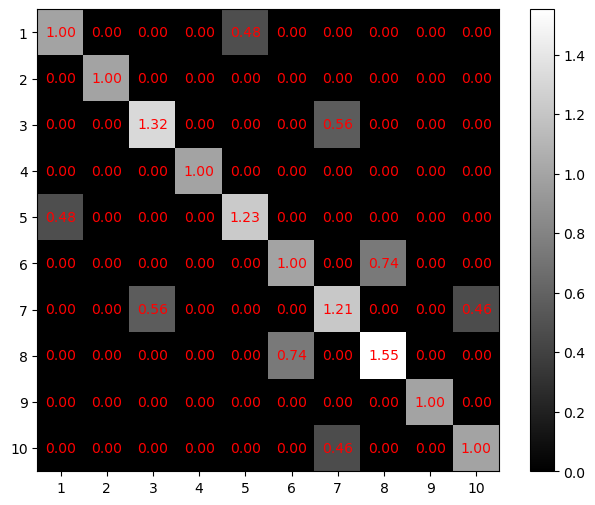

In [80]:
normalized_precision_matrix = precision_matrix
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_precision_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_precision_matrix) + 1))
plt.imshow(normalized_precision_matrix, cmap='gray', interpolation='nearest')

# Overlaying the values of the matrix on the plot
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{normalized_precision_matrix[i, j]:.2f}', ha='center', va='center', color='red')


plt.colorbar()
plt.show()

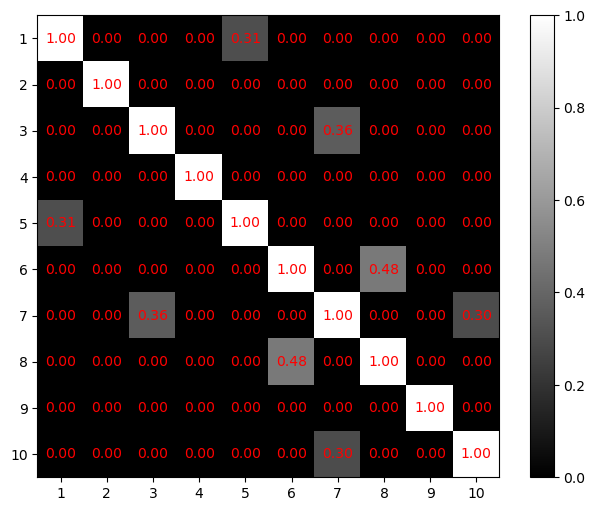

In [65]:
normalized_precision_matrix = precision_matrix / np.max(precision_matrix)
np.fill_diagonal(normalized_precision_matrix, 1)

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_precision_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_precision_matrix) + 1))
plt.imshow(normalized_precision_matrix, cmap='gray', interpolation='nearest')

# Overlaying the values of the matrix on the plot
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{normalized_precision_matrix[i, j]:.2f}', ha='center', va='center', color='red')


plt.colorbar()
plt.show()

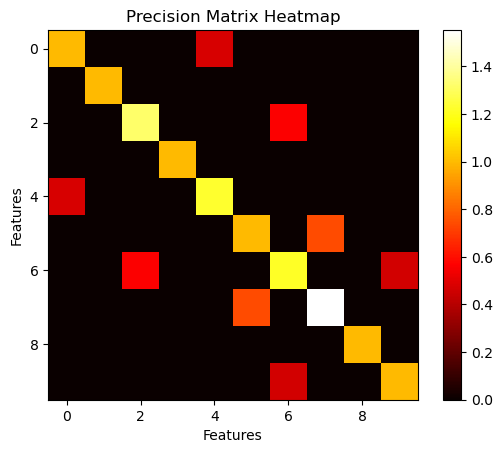

In [55]:
plt.imshow(precision_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Precision Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [56]:
print(precision_matrix)

[[1.         0.         0.         0.         0.47863488 0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.31756499 0.         0.         0.
  0.56352905 0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.47863488 0.         0.         0.         1.22909135 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.74297105 0.         0.        ]
 [0.         0.         0.56352905 0.         0.         0.
  1.21466769 0.         0.         0.46332245]
 [0.         0.         0.         0.         0.         0.74297105
  0.         1.55200598 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.   

In [4]:

test_samples = torch.tensor(X).to(torch.float32)

numpy_samples = test_samples.numpy()

file_path = 'G/test_samples.txt'

with open(file_path, 'w') as f:
    for sample in numpy_samples:
        np.savetxt(f, sample.reshape(1, -1), fmt='%.6f')

print(f"Test samples saved to {file_path}")

Test samples saved to G/test_samples.txt


In [5]:
X = random_state.multivariate_normal(np.zeros(num_features), covariance_matrix, size=num_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)


validation_samples = torch.tensor(X).to(torch.float32)

numpy_samples = validation_samples.numpy()

file_path = 'G/validation_samples.txt'

with open(file_path, 'w') as f:
    for sample in numpy_samples:
        np.savetxt(f, sample.reshape(1, -1), fmt='%.6f')

print(f"Validation samples saved to {file_path}")

Validation samples saved to G/validation_samples.txt


In [2]:
testing_samples_path = 'G/test_samples.txt'
validation_samples_path = 'G/validation_samples.txt'
save_path = 'G/G-saved_models/G-10d-32_64_64.es_samples' # Change this to change path!

In [75]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)

print(test_samples)

tensor([[ 0.7235,  0.6240, -0.8337,  ..., -0.9717, -1.5492,  0.9459],
        [-0.3430, -0.9384, -0.3570,  ..., -1.4166, -0.2935,  0.8330],
        [ 0.3484,  0.7140,  2.9361,  ..., -1.9267,  0.7983,  0.8447],
        ...,
        [-0.4713,  0.5734,  1.2804,  ...,  1.0922,  0.0869,  2.7397],
        [ 2.1501,  1.5671,  1.0426,  ...,  0.2305, -1.5594,  0.4539],
        [-0.7092,  1.4596, -0.9813,  ...,  0.9996,  0.1188, -1.7062]])


In [9]:
test_samples.shape

torch.Size([10000, 10])

In [10]:
num_test = 10000
num_pairs = 5
num_features = num_pairs * 2
hidden_layers = [32, 64, 64]
nb_steps = 50

lr = 0.01
num_epochs = 100

In [11]:
training_sizes = [100, 500, 1000, 2500, 5000]
random_regs = [1, 0.1, 0.01, 0.001, 0]

In [12]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [13]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

In [14]:
def generate_g(num_train, num_feat):
    X = random_state.multivariate_normal(np.zeros(num_feat), covariance_matrix, size=num_train)
    X -= X.mean(axis=0)
    X /= X.std(axis=0)
    return torch.tensor(X, dtype=torch.float32)

## Train the UMNN using loss

In [15]:
# This implements algorithm 1 for training the UMNN to learn the map Sk for all k.
for t in range(len(training_sizes)):
    num_train = training_sizes[t]
    X_tr = generate_g(num_train, num_pairs * 2)

    for i in kths:

        kth = i
        print('kth =', kth)
        best_val_overall = float('inf')
        opt_reg = 0
        opt_Sk = None
        each_learnt_map = {}
        non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

        for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
            regLambda = random_regs[j]
            Sk = copy.deepcopy(fixed_map)[kth]
            optimizer = optim.Adam(Sk.parameters(), lr=lr)
            n = X_tr.shape[0]
            early_stop_counter = 0
            best_epoch = 0
            best_valL = float('inf')
            for epoch in range(num_epochs):
                zk = X_tr.detach().requires_grad_(True)
                h = zk[:, non_kth]
                x = zk[:, [kth]]
                # This implements (4) - reugularized maximum likelihood estimator.
                # 1st part of equation loss regularized.
                sk_zi = Sk(x, h)
                # 2nd part of equation
                jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
                
                # Regularized Loss 
                loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n 
                regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
                loss += regLambda * regulariser
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Validation
                Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
                val_loss = test_losses(Sk_zi_val, jacobian_val)#, kth)
                print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

                # Save the smallest validation loss at each loop.
                if val_loss[1] < best_valL:
                    best_valL = val_loss[1]
                    if val_loss[1] < best_val_overall: # overall for all λ and epoch
                        best_val_overall = val_loss[1]
                        opt_reg = regLambda
                        opt_Sk = Sk
                        
                    best_epoch = epoch
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                # Check for early stopping
                if early_stop_counter >= 10:
                    print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                    break

            each_learnt_map.setdefault(regLambda, []).append(Sk)

        # Test the best model
        Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

        all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
        print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

        all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
        all_opt_maps.setdefault(num_train, []).append(opt_Sk)
        opt_regs.setdefault(num_train, []).append(opt_reg)
        
    print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.23112188279628754, 1.704081654548645)
Val 100st λ = 1, Epoch 1: (0.2328503578901291, 1.6815634965896606)
Val 100st λ = 1, Epoch 2: (0.28287121653556824, 1.5869544744491577)
Val 100st λ = 1, Epoch 3: (0.3287806510925293, 1.5276503562927246)
Val 100st λ = 1, Epoch 4: (0.3415454030036926, 1.5082600116729736)
Val 100st λ = 1, Epoch 5: (0.3293848931789398, 1.5159282684326172)
Val 100st λ = 1, Epoch 6: (0.31944647431373596, 1.5420429706573486)
Val 100st λ = 1, Epoch 7: (0.3365684747695923, 1.565155029296875)
Val 100st λ = 1, Epoch 8: (0.368380069732666, 1.5520927906036377)
Val 100st λ = 1, Epoch 9: (0.4119802415370941, 1.5082628726959229)
Val 100st λ = 1, Epoch 10: (0.4671570062637329, 1.4681637287139893)
Val 100st λ = 1, Epoch 11: (0.5014797449111938, 1.4616458415985107)
Val 100st λ = 1, Epoch 12: (0.5152986645698547, 1.4850571155548096)
Val 100st λ = 1, Epoch 13: (0.543171226978302, 1.5224685668945312)
Val 100st λ = 1, Epoch 14: (0.5759843587875366, 1.546770930

Random Regs:  20%|██        | 1/5 [01:00<04:03, 60.96s/it]

Val 100st λ = 1, Epoch 21: (0.8175187110900879, 1.5833629369735718)
Early stopping at Epoch 21 for best epoch 11.
Val 100st λ = 0.1, Epoch 0: (0.8904890418052673, 1.4286084175109863)
Val 100st λ = 0.1, Epoch 1: (0.7209445238113403, 1.4121168851852417)
Val 100st λ = 0.1, Epoch 2: (0.6699463725090027, 1.4102100133895874)
Val 100st λ = 0.1, Epoch 3: (0.7687169909477234, 1.4048681259155273)
Val 100st λ = 0.1, Epoch 4: (1.0576608180999756, 1.4420108795166016)
Val 100st λ = 0.1, Epoch 5: (1.1885164976119995, 1.4675627946853638)
Val 100st λ = 0.1, Epoch 6: (1.2624468803405762, 1.5024042129516602)
Val 100st λ = 0.1, Epoch 7: (1.8677043914794922, 1.6550015211105347)
Val 100st λ = 0.1, Epoch 8: (2.360139846801758, 1.8190937042236328)
Val 100st λ = 0.1, Epoch 9: (2.4556894302368164, 1.9176832437515259)
Val 100st λ = 0.1, Epoch 10: (4.248321056365967, 2.4139626026153564)
Val 100st λ = 0.1, Epoch 11: (2.3634793758392334, 1.9009654521942139)
Val 100st λ = 0.1, Epoch 12: (2.1396186351776123, 1.856740

Random Regs:  40%|████      | 2/5 [01:40<02:24, 48.19s/it]

Val 100st λ = 0.1, Epoch 13: (2.6345016956329346, 1.969320297241211)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0.01, Epoch 0: (0.9493013620376587, 1.4384955167770386)
Val 100st λ = 0.01, Epoch 1: (0.8144981265068054, 1.4158257246017456)
Val 100st λ = 0.01, Epoch 2: (0.7698174118995667, 1.40985107421875)
Val 100st λ = 0.01, Epoch 3: (0.8888519406318665, 1.4160990715026855)
Val 100st λ = 0.01, Epoch 4: (1.24286687374115, 1.483043909072876)
Val 100st λ = 0.01, Epoch 5: (1.3087761402130127, 1.4978835582733154)
Val 100st λ = 0.01, Epoch 6: (1.4162752628326416, 1.5369449853897095)
Val 100st λ = 0.01, Epoch 7: (2.3629703521728516, 1.7818509340286255)
Val 100st λ = 0.01, Epoch 8: (2.8466548919677734, 1.9390299320220947)
Val 100st λ = 0.01, Epoch 9: (4.469793796539307, 2.3709981441497803)
Val 100st λ = 0.01, Epoch 10: (3.189950942993164, 2.1569526195526123)
Val 100st λ = 0.01, Epoch 11: (5.495330810546875, 2.745770215988159)


Random Regs:  60%|██████    | 3/5 [02:15<01:24, 42.21s/it]

Val 100st λ = 0.01, Epoch 12: (5.057309627532959, 2.629700183868408)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.001, Epoch 0: (0.9525658488273621, 1.4390122890472412)
Val 100st λ = 0.001, Epoch 1: (0.8234295845031738, 1.4167276620864868)
Val 100st λ = 0.001, Epoch 2: (0.7824379801750183, 1.411106824874878)
Val 100st λ = 0.001, Epoch 3: (0.9066562056541443, 1.419249415397644)
Val 100st λ = 0.001, Epoch 4: (1.26472806930542, 1.4890124797821045)
Val 100st λ = 0.001, Epoch 5: (1.3133758306503296, 1.4994736909866333)
Val 100st λ = 0.001, Epoch 6: (1.4331305027008057, 1.5404105186462402)
Val 100st λ = 0.001, Epoch 7: (2.367302179336548, 1.7846909761428833)
Val 100st λ = 0.001, Epoch 8: (2.7655601501464844, 1.9193533658981323)
Val 100st λ = 0.001, Epoch 9: (4.510797023773193, 2.396627902984619)
Val 100st λ = 0.001, Epoch 10: (3.102046251296997, 2.132415294647217)
Val 100st λ = 0.001, Epoch 11: (4.805130481719971, 2.569575786590576)


Random Regs:  80%|████████  | 4/5 [02:55<00:41, 41.26s/it]

Val 100st λ = 0.001, Epoch 12: (5.85931921005249, 2.8950891494750977)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0, Epoch 0: (0.9534502625465393, 1.4391968250274658)
Val 100st λ = 0, Epoch 1: (0.824480414390564, 1.41684091091156)
Val 100st λ = 0, Epoch 2: (0.7828896641731262, 1.4113997220993042)
Val 100st λ = 0, Epoch 3: (0.9061672687530518, 1.419427514076233)
Val 100st λ = 0, Epoch 4: (1.2594566345214844, 1.4877254962921143)
Val 100st λ = 0, Epoch 5: (1.3107333183288574, 1.4991177320480347)
Val 100st λ = 0, Epoch 6: (1.4349784851074219, 1.5407017469406128)
Val 100st λ = 0, Epoch 7: (2.372183322906494, 1.787347674369812)
Val 100st λ = 0, Epoch 8: (2.8476555347442627, 1.944081425666809)
Val 100st λ = 0, Epoch 9: (4.598535060882568, 2.4182586669921875)
Val 100st λ = 0, Epoch 10: (3.106192111968994, 2.137845039367676)
Val 100st λ = 0, Epoch 11: (5.009183883666992, 2.615567445755005)


Val 100st λ = 0, Epoch 12: (6.152154445648193, 2.958975076675415)
Early stopping at Epoch 12 for best epoch 2.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.2766852080821991, 1.6165944337844849)
Val 100st λ = 1, Epoch 1: (0.21745477616786957, 1.7602827548980713)
Val 100st λ = 1, Epoch 2: (0.23697099089622498, 1.6789458990097046)
Val 100st λ = 1, Epoch 3: (0.28493261337280273, 1.5908006429672241)
Val 100st λ = 1, Epoch 4: (0.33216172456741333, 1.539273738861084)
Val 100st λ = 1, Epoch 5: (0.35291561484336853, 1.5230838060379028)
Val 100st λ = 1, Epoch 6: (0.3503071963787079, 1.5270723104476929)
Val 100st λ = 1, Epoch 7: (0.33556991815567017, 1.5429470539093018)
Val 100st λ = 1, Epoch 8: (0.31915414333343506, 1.566101312637329)
Val 100st λ = 1, Epoch 9: (0.3083220422267914, 1.5919549465179443)
Val 100st λ = 1, Epoch 10: (0.3074997365474701, 1.6108832359313965)
Val 100st λ = 1, Epoch 11: (0.31829169392585754, 1.6143693923950195)
Val 100st λ = 1, Epoch 12: (0.34133872389793396, 1.6032650470733643)
Val 100st λ = 1, Epoch 13: (0.3766215443611145, 1.5832439661026)
Val 100st λ = 1, Epoch 14: (0.4240023195743561, 1.5639

Random Regs:  20%|██        | 1/5 [00:43<02:55, 43.95s/it]

Val 100st λ = 1, Epoch 15: (0.4780194163322449, 1.5540584325790405)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.1, Epoch 0: (0.7473265528678894, 1.4260398149490356)
Val 100st λ = 0.1, Epoch 1: (0.6918659210205078, 1.4356772899627686)
Val 100st λ = 0.1, Epoch 2: (1.0053092241287231, 1.468037486076355)
Val 100st λ = 0.1, Epoch 3: (1.00442373752594, 1.4782160520553589)
Val 100st λ = 0.1, Epoch 4: (1.244570255279541, 1.5312659740447998)
Val 100st λ = 0.1, Epoch 5: (2.0448102951049805, 1.7220406532287598)
Val 100st λ = 0.1, Epoch 6: (1.6343591213226318, 1.649938702583313)
Val 100st λ = 0.1, Epoch 7: (2.9974684715270996, 2.023456335067749)
Val 100st λ = 0.1, Epoch 8: (2.7737841606140137, 1.9683982133865356)
Val 100st λ = 0.1, Epoch 9: (3.476914405822754, 2.1873106956481934)


Random Regs:  40%|████      | 2/5 [01:13<01:46, 35.58s/it]

Val 100st λ = 0.1, Epoch 10: (5.178234577178955, 2.7177886962890625)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.01, Epoch 0: (0.9159400463104248, 1.4425809383392334)
Val 100st λ = 0.01, Epoch 1: (0.7004492282867432, 1.4322541952133179)
Val 100st λ = 0.01, Epoch 2: (0.8448622226715088, 1.4443464279174805)
Val 100st λ = 0.01, Epoch 3: (1.2561765909194946, 1.5243393182754517)
Val 100st λ = 0.01, Epoch 4: (1.3896806240081787, 1.5576096773147583)
Val 100st λ = 0.01, Epoch 5: (1.5065727233886719, 1.5887126922607422)
Val 100st λ = 0.01, Epoch 6: (2.6264877319335938, 1.851898193359375)
Val 100st λ = 0.01, Epoch 7: (3.1649694442749023, 2.008531332015991)
Val 100st λ = 0.01, Epoch 8: (3.4854557514190674, 2.124905586242676)
Val 100st λ = 0.01, Epoch 9: (7.075166702270508, 3.1925723552703857)
Val 100st λ = 0.01, Epoch 10: (3.1402957439422607, 2.081105947494507)


Random Regs:  60%|██████    | 3/5 [01:43<01:06, 33.14s/it]

Val 100st λ = 0.01, Epoch 11: (4.666323184967041, 2.4402835369110107)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.9305065274238586, 1.4448941946029663)
Val 100st λ = 0.001, Epoch 1: (0.7080912590026855, 1.4321192502975464)
Val 100st λ = 0.001, Epoch 2: (0.8407804369926453, 1.4440077543258667)
Val 100st λ = 0.001, Epoch 3: (1.2541598081588745, 1.5243152379989624)
Val 100st λ = 0.001, Epoch 4: (1.4400478601455688, 1.5697660446166992)
Val 100st λ = 0.001, Epoch 5: (1.5283995866775513, 1.5927380323410034)
Val 100st λ = 0.001, Epoch 6: (2.5559329986572266, 1.8351720571517944)
Val 100st λ = 0.001, Epoch 7: (3.4665024280548096, 2.08206844329834)
Val 100st λ = 0.001, Epoch 8: (3.121870517730713, 2.0300495624542236)
Val 100st λ = 0.001, Epoch 9: (6.834575176239014, 3.118093490600586)
Val 100st λ = 0.001, Epoch 10: (3.519956111907959, 2.1742091178894043)


Random Regs:  80%|████████  | 4/5 [02:14<00:32, 32.28s/it]

Val 100st λ = 0.001, Epoch 11: (5.034221649169922, 2.553515672683716)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (0.9317497611045837, 1.4451014995574951)
Val 100st λ = 0, Epoch 1: (0.7096676826477051, 1.4320815801620483)
Val 100st λ = 0, Epoch 2: (0.8397612571716309, 1.4439338445663452)
Val 100st λ = 0, Epoch 3: (1.2544915676116943, 1.5243734121322632)
Val 100st λ = 0, Epoch 4: (1.4445306062698364, 1.5709277391433716)
Val 100st λ = 0, Epoch 5: (1.527137041091919, 1.592729926109314)
Val 100st λ = 0, Epoch 6: (2.5560312271118164, 1.832942008972168)
Val 100st λ = 0, Epoch 7: (3.548999786376953, 2.098849058151245)
Val 100st λ = 0, Epoch 8: (3.1126067638397217, 2.029909372329712)
Val 100st λ = 0, Epoch 9: (6.804657936096191, 3.1272993087768555)
Val 100st λ = 0, Epoch 10: (3.5118014812469482, 2.1775145530700684)


Val 100st λ = 0, Epoch 11: (4.846128940582275, 2.5152933597564697)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.259406179189682, 1.5960431098937988)
Val 100st λ = 1, Epoch 1: (0.18173587322235107, 1.7639286518096924)
Val 100st λ = 1, Epoch 2: (0.19125930964946747, 1.6878751516342163)
Val 100st λ = 1, Epoch 3: (0.23471808433532715, 1.583640456199646)
Val 100st λ = 1, Epoch 4: (0.2842361330986023, 1.5088595151901245)
Val 100st λ = 1, Epoch 5: (0.31724923849105835, 1.470853567123413)
Val 100st λ = 1, Epoch 6: (0.3298707902431488, 1.4624131917953491)
Val 100st λ = 1, Epoch 7: (0.3293532729148865, 1.4681810140609741)
Val 100st λ = 1, Epoch 8: (0.3244720697402954, 1.4776771068572998)
Val 100st λ = 1, Epoch 9: (0.32076501846313477, 1.4814544916152954)
Val 100st λ = 1, Epoch 10: (0.3185400366783142, 1.4763224124908447)
Val 100st λ = 1, Epoch 11: (0.32404467463493347, 1.4686615467071533)
Val 100st λ = 1, Epoch 12: (0.33643054962158203, 1.4590892791748047)
Val 100st λ = 1, Epoch 13: (0.3531303405761719, 1.450982928276062)
Val 100st λ = 1, Epoch 14: (0.37271469831466675, 1.4496

Random Regs:  20%|██        | 1/5 [01:12<04:51, 72.84s/it]

Val 100st λ = 1, Epoch 28: (0.8420831561088562, 1.5500788688659668)
Early stopping at Epoch 28 for best epoch 18.
Val 100st λ = 0.1, Epoch 0: (0.5033384561538696, 1.414966344833374)
Val 100st λ = 0.1, Epoch 1: (0.9986735582351685, 1.417328953742981)
Val 100st λ = 0.1, Epoch 2: (0.8173551559448242, 1.3789502382278442)
Val 100st λ = 0.1, Epoch 3: (0.7893282175064087, 1.386011004447937)
Val 100st λ = 0.1, Epoch 4: (1.217145562171936, 1.4546347856521606)
Val 100st λ = 0.1, Epoch 5: (1.9716664552688599, 1.6450515985488892)
Val 100st λ = 0.1, Epoch 6: (1.5709892511367798, 1.5631144046783447)
Val 100st λ = 0.1, Epoch 7: (1.8695828914642334, 1.633939504623413)
Val 100st λ = 0.1, Epoch 8: (2.6874282360076904, 1.8753310441970825)
Val 100st λ = 0.1, Epoch 9: (2.3415846824645996, 1.7889773845672607)
Val 100st λ = 0.1, Epoch 10: (3.4321115016937256, 2.0981485843658447)
Val 100st λ = 0.1, Epoch 11: (5.0215935707092285, 2.582169532775879)


Random Regs:  40%|████      | 2/5 [01:47<02:30, 50.27s/it]

Val 100st λ = 0.1, Epoch 12: (3.939633369445801, 2.3350796699523926)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.01, Epoch 0: (0.9284334778785706, 1.4160590171813965)
Val 100st λ = 0.01, Epoch 1: (0.5841175317764282, 1.3840383291244507)
Val 100st λ = 0.01, Epoch 2: (0.9102025032043457, 1.3933755159378052)
Val 100st λ = 0.01, Epoch 3: (1.9226799011230469, 1.6184585094451904)
Val 100st λ = 0.01, Epoch 4: (1.3270128965377808, 1.492906093597412)
Val 100st λ = 0.01, Epoch 5: (1.4036771059036255, 1.5142728090286255)
Val 100st λ = 0.01, Epoch 6: (2.1969497203826904, 1.725927710533142)
Val 100st λ = 0.01, Epoch 7: (2.6928229331970215, 1.8786256313323975)
Val 100st λ = 0.01, Epoch 8: (2.5426833629608154, 1.8305275440216064)
Val 100st λ = 0.01, Epoch 9: (3.8856136798858643, 2.1581921577453613)
Val 100st λ = 0.01, Epoch 10: (4.820427894592285, 2.4317047595977783)


Random Regs:  60%|██████    | 3/5 [02:18<01:23, 41.53s/it]

Val 100st λ = 0.01, Epoch 11: (5.201840400695801, 2.6202023029327393)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.9653528332710266, 1.4228758811950684)
Val 100st λ = 0.001, Epoch 1: (0.5860192775726318, 1.3837215900421143)
Val 100st λ = 0.001, Epoch 2: (0.826019287109375, 1.3823771476745605)
Val 100st λ = 0.001, Epoch 3: (1.7485854625701904, 1.5736092329025269)
Val 100st λ = 0.001, Epoch 4: (1.510055422782898, 1.5288723707199097)
Val 100st λ = 0.001, Epoch 5: (1.5500651597976685, 1.5522253513336182)
Val 100st λ = 0.001, Epoch 6: (2.420030355453491, 1.7823495864868164)
Val 100st λ = 0.001, Epoch 7: (2.906402587890625, 1.9253710508346558)
Val 100st λ = 0.001, Epoch 8: (2.885327100753784, 1.9141974449157715)
Val 100st λ = 0.001, Epoch 9: (5.146915912628174, 2.4831979274749756)
Val 100st λ = 0.001, Epoch 10: (4.297982215881348, 2.302429437637329)
Val 100st λ = 0.001, Epoch 11: (7.241265773773193, 3.175636053085327)


Random Regs:  80%|████████  | 4/5 [02:53<00:39, 39.06s/it]

Val 100st λ = 0.001, Epoch 12: (9.347001075744629, 3.672874927520752)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0, Epoch 0: (0.9667907953262329, 1.4231256246566772)
Val 100st λ = 0, Epoch 1: (0.5887717008590698, 1.3834682703018188)
Val 100st λ = 0, Epoch 2: (0.8294309377670288, 1.3827943801879883)
Val 100st λ = 0, Epoch 3: (1.7697221040725708, 1.5791339874267578)
Val 100st λ = 0, Epoch 4: (1.4975614547729492, 1.5259617567062378)
Val 100st λ = 0, Epoch 5: (1.5485715866088867, 1.5508545637130737)
Val 100st λ = 0, Epoch 6: (2.4277777671813965, 1.7842166423797607)
Val 100st λ = 0, Epoch 7: (2.9017550945281982, 1.924878716468811)
Val 100st λ = 0, Epoch 8: (2.926685094833374, 1.924720287322998)
Val 100st λ = 0, Epoch 9: (5.237024307250977, 2.497199058532715)
Val 100st λ = 0, Epoch 10: (4.260049343109131, 2.2858335971832275)
Val 100st λ = 0, Epoch 11: (7.317921161651611, 3.1740753650665283)


Val 100st λ = 0, Epoch 12: (9.590144157409668, 3.69098162651062)
Early stopping at Epoch 12 for best epoch 2.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.41858863830566406, 1.4907667636871338)
Val 100st λ = 1, Epoch 1: (0.23029698431491852, 1.829598069190979)
Val 100st λ = 1, Epoch 2: (0.22146248817443848, 1.7958338260650635)
Val 100st λ = 1, Epoch 3: (0.25239643454551697, 1.6620007753372192)
Val 100st λ = 1, Epoch 4: (0.31432807445526123, 1.566716194152832)
Val 100st λ = 1, Epoch 5: (0.36603179574012756, 1.520172357559204)
Val 100st λ = 1, Epoch 6: (0.3897906243801117, 1.5047380924224854)
Val 100st λ = 1, Epoch 7: (0.3903648853302002, 1.5068769454956055)
Val 100st λ = 1, Epoch 8: (0.37680715322494507, 1.5221234560012817)
Val 100st λ = 1, Epoch 9: (0.35930025577545166, 1.5485632419586182)


Random Regs:  20%|██        | 1/5 [00:30<02:01, 30.34s/it]

Val 100st λ = 1, Epoch 10: (0.3465450406074524, 1.5824525356292725)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.1, Epoch 0: (0.4541107714176178, 1.4697798490524292)
Val 100st λ = 0.1, Epoch 1: (0.5286139249801636, 1.4468153715133667)
Val 100st λ = 0.1, Epoch 2: (0.6837459206581116, 1.4295167922973633)
Val 100st λ = 0.1, Epoch 3: (0.8390883803367615, 1.4403725862503052)
Val 100st λ = 0.1, Epoch 4: (0.9569575190544128, 1.465917944908142)
Val 100st λ = 0.1, Epoch 5: (1.0251868963241577, 1.497156023979187)
Val 100st λ = 0.1, Epoch 6: (1.1029393672943115, 1.5425193309783936)
Val 100st λ = 0.1, Epoch 7: (1.287632942199707, 1.6089894771575928)
Val 100st λ = 0.1, Epoch 8: (1.7030069828033447, 1.732125997543335)
Val 100st λ = 0.1, Epoch 9: (2.3513498306274414, 1.9365617036819458)
Val 100st λ = 0.1, Epoch 10: (2.667417526245117, 2.0437352657318115)
Val 100st λ = 0.1, Epoch 11: (3.0153582096099854, 2.1491007804870605)


Random Regs:  40%|████      | 2/5 [01:06<01:41, 33.88s/it]

Val 100st λ = 0.1, Epoch 12: (4.390967845916748, 2.5211246013641357)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.01, Epoch 0: (0.48074230551719666, 1.4594306945800781)
Val 100st λ = 0.01, Epoch 1: (0.6135406494140625, 1.4333966970443726)
Val 100st λ = 0.01, Epoch 2: (0.8430578112602234, 1.4394538402557373)
Val 100st λ = 0.01, Epoch 3: (1.0870156288146973, 1.4859896898269653)
Val 100st λ = 0.01, Epoch 4: (1.2038233280181885, 1.5235941410064697)
Val 100st λ = 0.01, Epoch 5: (1.192683458328247, 1.54349684715271)
Val 100st λ = 0.01, Epoch 6: (1.280309796333313, 1.5989614725112915)
Val 100st λ = 0.01, Epoch 7: (1.6665858030319214, 1.7220568656921387)
Val 100st λ = 0.01, Epoch 8: (2.5865142345428467, 1.9973949193954468)
Val 100st λ = 0.01, Epoch 9: (3.5275537967681885, 2.273329734802246)
Val 100st λ = 0.01, Epoch 10: (3.666792869567871, 2.296035051345825)


Random Regs:  60%|██████    | 3/5 [01:45<01:12, 36.07s/it]

Val 100st λ = 0.01, Epoch 11: (4.819835186004639, 2.557339668273926)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.4834042191505432, 1.4584908485412598)
Val 100st λ = 0.001, Epoch 1: (0.6227009296417236, 1.4325857162475586)
Val 100st λ = 0.001, Epoch 2: (0.8637873530387878, 1.4422065019607544)
Val 100st λ = 0.001, Epoch 3: (1.1181931495666504, 1.4936081171035767)
Val 100st λ = 0.001, Epoch 4: (1.2192004919052124, 1.528014063835144)
Val 100st λ = 0.001, Epoch 5: (1.1926310062408447, 1.5432226657867432)
Val 100st λ = 0.001, Epoch 6: (1.2786874771118164, 1.596529483795166)
Val 100st λ = 0.001, Epoch 7: (1.68082594871521, 1.7243530750274658)
Val 100st λ = 0.001, Epoch 8: (2.6484735012054443, 2.0152361392974854)
Val 100st λ = 0.001, Epoch 9: (3.668233871459961, 2.3116118907928467)
Val 100st λ = 0.001, Epoch 10: (3.8458027839660645, 2.3325114250183105)


Random Regs:  80%|████████  | 4/5 [02:23<00:36, 36.83s/it]

Val 100st λ = 0.001, Epoch 11: (5.324254512786865, 2.6465601921081543)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (0.483901709318161, 1.458313226699829)
Val 100st λ = 0, Epoch 1: (0.6241581439971924, 1.4324278831481934)
Val 100st λ = 0, Epoch 2: (0.8668949007987976, 1.4425464868545532)
Val 100st λ = 0, Epoch 3: (1.1224708557128906, 1.4946221113204956)
Val 100st λ = 0, Epoch 4: (1.2265806198120117, 1.5301462411880493)
Val 100st λ = 0, Epoch 5: (1.1977624893188477, 1.5451430082321167)
Val 100st λ = 0, Epoch 6: (1.2828503847122192, 1.5987168550491333)
Val 100st λ = 0, Epoch 7: (1.693066954612732, 1.7274714708328247)
Val 100st λ = 0, Epoch 8: (2.6785244941711426, 2.021566867828369)
Val 100st λ = 0, Epoch 9: (3.7103803157806396, 2.3193726539611816)
Val 100st λ = 0, Epoch 10: (3.7593131065368652, 2.3102023601531982)


Val 100st λ = 0, Epoch 11: (5.077179908752441, 2.597425699234009)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.22176754474639893, 1.6890960931777954)
Val 100st λ = 1, Epoch 1: (0.19504110515117645, 1.7189053297042847)
Val 100st λ = 1, Epoch 2: (0.22136983275413513, 1.640703558921814)
Val 100st λ = 1, Epoch 3: (0.2612329125404358, 1.5720067024230957)
Val 100st λ = 1, Epoch 4: (0.2959042191505432, 1.529035210609436)
Val 100st λ = 1, Epoch 5: (0.3195614516735077, 1.5102691650390625)
Val 100st λ = 1, Epoch 6: (0.3409988582134247, 1.514018177986145)
Val 100st λ = 1, Epoch 7: (0.370259165763855, 1.5313441753387451)
Val 100st λ = 1, Epoch 8: (0.3903530538082123, 1.5387409925460815)
Val 100st λ = 1, Epoch 9: (0.40607526898384094, 1.5298538208007812)
Val 100st λ = 1, Epoch 10: (0.42222270369529724, 1.5113041400909424)
Val 100st λ = 1, Epoch 11: (0.4378616213798523, 1.4948047399520874)
Val 100st λ = 1, Epoch 12: (0.4431241452693939, 1.4859955310821533)
Val 100st λ = 1, Epoch 13: (0.43468403816223145, 1.483442783355713)
Val 100st λ = 1, Epoch 14: (0.42532628774642944, 1.488884

Random Regs:  20%|██        | 1/5 [01:01<04:05, 61.41s/it]

Val 100st λ = 1, Epoch 23: (0.6953729391098022, 1.5631914138793945)
Early stopping at Epoch 23 for best epoch 13.
Val 100st λ = 0.1, Epoch 0: (0.9051481485366821, 1.4309300184249878)
Val 100st λ = 0.1, Epoch 1: (0.5906082987785339, 1.4243507385253906)
Val 100st λ = 0.1, Epoch 2: (0.6842960119247437, 1.4096311330795288)
Val 100st λ = 0.1, Epoch 3: (1.0462119579315186, 1.4454612731933594)
Val 100st λ = 0.1, Epoch 4: (1.3199249505996704, 1.509429693222046)
Val 100st λ = 0.1, Epoch 5: (1.1041814088821411, 1.4764351844787598)
Val 100st λ = 0.1, Epoch 6: (1.2087361812591553, 1.5140142440795898)
Val 100st λ = 0.1, Epoch 7: (1.7423985004425049, 1.6520371437072754)
Val 100st λ = 0.1, Epoch 8: (1.7698800563812256, 1.6684041023254395)
Val 100st λ = 0.1, Epoch 9: (1.5453444719314575, 1.6244920492172241)
Val 100st λ = 0.1, Epoch 10: (1.8522014617919922, 1.7058628797531128)
Val 100st λ = 0.1, Epoch 11: (2.5516202449798584, 1.9226866960525513)


Random Regs:  40%|████      | 2/5 [01:33<02:11, 43.95s/it]

Val 100st λ = 0.1, Epoch 12: (2.3676271438598633, 1.9038000106811523)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.01, Epoch 0: (1.0841892957687378, 1.4653065204620361)
Val 100st λ = 0.01, Epoch 1: (0.69991135597229, 1.4095289707183838)
Val 100st λ = 0.01, Epoch 2: (0.6552090048789978, 1.4109070301055908)
Val 100st λ = 0.01, Epoch 3: (0.889346718788147, 1.4220904111862183)
Val 100st λ = 0.01, Epoch 4: (1.4704101085662842, 1.5455561876296997)
Val 100st λ = 0.01, Epoch 5: (1.7100038528442383, 1.6131178140640259)
Val 100st λ = 0.01, Epoch 6: (1.4363197088241577, 1.5629385709762573)
Val 100st λ = 0.01, Epoch 7: (1.4710739850997925, 1.5825198888778687)
Val 100st λ = 0.01, Epoch 8: (1.901615023612976, 1.69974946975708)
Val 100st λ = 0.01, Epoch 9: (2.145106792449951, 1.7812588214874268)
Val 100st λ = 0.01, Epoch 10: (1.9689139127731323, 1.7544877529144287)


Random Regs:  60%|██████    | 3/5 [02:02<01:14, 37.11s/it]

Val 100st λ = 0.01, Epoch 11: (2.29022479057312, 1.85591459274292)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (1.098359227180481, 1.468669056892395)
Val 100st λ = 0.001, Epoch 1: (0.7109020352363586, 1.409195065498352)
Val 100st λ = 0.001, Epoch 2: (0.6566207408905029, 1.4111137390136719)
Val 100st λ = 0.001, Epoch 3: (0.8861682415008545, 1.422072410583496)
Val 100st λ = 0.001, Epoch 4: (1.4780266284942627, 1.5471760034561157)
Val 100st λ = 0.001, Epoch 5: (1.7817931175231934, 1.6315703392028809)
Val 100st λ = 0.001, Epoch 6: (1.4998934268951416, 1.5789011716842651)
Val 100st λ = 0.001, Epoch 7: (1.483099341392517, 1.5875047445297241)
Val 100st λ = 0.001, Epoch 8: (1.8682680130004883, 1.6874945163726807)
Val 100st λ = 0.001, Epoch 9: (2.2276461124420166, 1.8001916408538818)
Val 100st λ = 0.001, Epoch 10: (2.00996994972229, 1.7580260038375854)


Random Regs:  80%|████████  | 4/5 [02:30<00:33, 33.80s/it]

Val 100st λ = 0.001, Epoch 11: (2.179290771484375, 1.8181042671203613)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (1.0990229845046997, 1.4688266515731812)
Val 100st λ = 0, Epoch 1: (0.7117103338241577, 1.4091731309890747)
Val 100st λ = 0, Epoch 2: (0.6566362380981445, 1.410987377166748)
Val 100st λ = 0, Epoch 3: (0.889022707939148, 1.422436237335205)
Val 100st λ = 0, Epoch 4: (1.4882657527923584, 1.5497239828109741)
Val 100st λ = 0, Epoch 5: (1.783727765083313, 1.6321862936019897)
Val 100st λ = 0, Epoch 6: (1.5026123523712158, 1.5792206525802612)
Val 100st λ = 0, Epoch 7: (1.4898548126220703, 1.5888044834136963)
Val 100st λ = 0, Epoch 8: (1.8603705167770386, 1.6847976446151733)
Val 100st λ = 0, Epoch 9: (2.2242085933685303, 1.797485589981079)
Val 100st λ = 0, Epoch 10: (2.0241308212280273, 1.7594501972198486)


Val 100st λ = 0, Epoch 11: (2.1981213092803955, 1.8197461366653442)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.2998654246330261, 1.586857795715332)
Val 100st λ = 1, Epoch 1: (0.22856390476226807, 1.7824921607971191)
Val 100st λ = 1, Epoch 2: (0.221882164478302, 1.701535701751709)
Val 100st λ = 1, Epoch 3: (0.2470722496509552, 1.5778261423110962)
Val 100st λ = 1, Epoch 4: (0.29087573289871216, 1.4878811836242676)
Val 100st λ = 1, Epoch 5: (0.32695844769477844, 1.4313420057296753)
Val 100st λ = 1, Epoch 6: (0.3457629084587097, 1.401251196861267)
Val 100st λ = 1, Epoch 7: (0.3570560812950134, 1.395749568939209)
Val 100st λ = 1, Epoch 8: (0.3805452585220337, 1.4103024005889893)
Val 100st λ = 1, Epoch 9: (0.4074999690055847, 1.4192150831222534)
Val 100st λ = 1, Epoch 10: (0.42430540919303894, 1.4063236713409424)
Val 100st λ = 1, Epoch 11: (0.4366137385368347, 1.3781665563583374)
Val 100st λ = 1, Epoch 12: (0.446134090423584, 1.3530973196029663)
Val 100st λ = 1, Epoch 13: (0.45057883858680725, 1.3441208600997925)
Val 100st λ = 1, Epoch 14: (0.44554850459098816, 1.35027134

Random Regs:  20%|██        | 1/5 [00:56<03:47, 56.83s/it]

Val 100st λ = 1, Epoch 23: (0.4589499235153198, 1.3729335069656372)
Early stopping at Epoch 23 for best epoch 13.
Val 100st λ = 0.1, Epoch 0: (0.42135119438171387, 1.460432767868042)
Val 100st λ = 0.1, Epoch 1: (0.5979109406471252, 1.3919832706451416)
Val 100st λ = 0.1, Epoch 2: (0.9313502907752991, 1.392607569694519)
Val 100st λ = 0.1, Epoch 3: (1.134118914604187, 1.4123728275299072)
Val 100st λ = 0.1, Epoch 4: (1.0942233800888062, 1.3866801261901855)
Val 100st λ = 0.1, Epoch 5: (1.207979440689087, 1.4180810451507568)
Val 100st λ = 0.1, Epoch 6: (1.8496085405349731, 1.5769766569137573)
Val 100st λ = 0.1, Epoch 7: (3.882373332977295, 2.1639788150787354)
Val 100st λ = 0.1, Epoch 8: (2.717973470687866, 1.8829412460327148)
Val 100st λ = 0.1, Epoch 9: (2.9221198558807373, 1.9743943214416504)
Val 100st λ = 0.1, Epoch 10: (3.881168842315674, 2.240778923034668)
Val 100st λ = 0.1, Epoch 11: (4.52834415435791, 2.4119491577148438)
Val 100st λ = 0.1, Epoch 12: (4.501945972442627, 2.40874028205871

Random Regs:  40%|████      | 2/5 [01:32<02:13, 44.57s/it]

Val 100st λ = 0.1, Epoch 14: (5.701391696929932, 2.7712607383728027)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.01, Epoch 0: (0.482235848903656, 1.433532953262329)
Val 100st λ = 0.01, Epoch 1: (0.7592807412147522, 1.3888853788375854)
Val 100st λ = 0.01, Epoch 2: (1.2526516914367676, 1.4646494388580322)
Val 100st λ = 0.01, Epoch 3: (1.290085792541504, 1.4499168395996094)
Val 100st λ = 0.01, Epoch 4: (1.2184680700302124, 1.4230031967163086)
Val 100st λ = 0.01, Epoch 5: (1.5801278352737427, 1.5131802558898926)
Val 100st λ = 0.01, Epoch 6: (3.174267530441284, 1.96547269821167)
Val 100st λ = 0.01, Epoch 7: (4.547222137451172, 2.3906960487365723)
Val 100st λ = 0.01, Epoch 8: (3.9870903491973877, 2.3077175617218018)
Val 100st λ = 0.01, Epoch 9: (7.677852153778076, 3.3017172813415527)
Val 100st λ = 0.01, Epoch 10: (6.276731014251709, 2.9054391384124756)


Random Regs:  60%|██████    | 3/5 [02:02<01:15, 37.55s/it]

Val 100st λ = 0.01, Epoch 11: (8.450760841369629, 3.4894278049468994)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.48748478293418884, 1.4318761825561523)
Val 100st λ = 0.001, Epoch 1: (0.7772908210754395, 1.3901478052139282)
Val 100st λ = 0.001, Epoch 2: (1.2812947034835815, 1.4722963571548462)
Val 100st λ = 0.001, Epoch 3: (1.2946456670761108, 1.450766682624817)
Val 100st λ = 0.001, Epoch 4: (1.2256195545196533, 1.4247583150863647)
Val 100st λ = 0.001, Epoch 5: (1.628653645515442, 1.5244178771972656)
Val 100st λ = 0.001, Epoch 6: (3.41652250289917, 2.03466534614563)
Val 100st λ = 0.001, Epoch 7: (4.319586277008057, 2.32840633392334)
Val 100st λ = 0.001, Epoch 8: (4.510039329528809, 2.4496347904205322)
Val 100st λ = 0.001, Epoch 9: (9.339875221252441, 3.703435182571411)
Val 100st λ = 0.001, Epoch 10: (5.328909873962402, 2.7152140140533447)


Random Regs:  80%|████████  | 4/5 [02:30<00:34, 34.10s/it]

Val 100st λ = 0.001, Epoch 11: (7.258725166320801, 3.227269411087036)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (0.48755475878715515, 1.431835412979126)
Val 100st λ = 0, Epoch 1: (0.7784833312034607, 1.3902021646499634)
Val 100st λ = 0, Epoch 2: (1.2862412929534912, 1.4736660718917847)
Val 100st λ = 0, Epoch 3: (1.2998037338256836, 1.4521675109863281)
Val 100st λ = 0, Epoch 4: (1.2375322580337524, 1.4279550313949585)
Val 100st λ = 0, Epoch 5: (1.6400443315505981, 1.5277457237243652)
Val 100st λ = 0, Epoch 6: (3.4027647972106934, 2.034487009048462)
Val 100st λ = 0, Epoch 7: (4.289552688598633, 2.32165265083313)
Val 100st λ = 0, Epoch 8: (4.569420337677002, 2.465172290802002)
Val 100st λ = 0, Epoch 9: (9.665674209594727, 3.7520687580108643)
Val 100st λ = 0, Epoch 10: (5.439713954925537, 2.7346601486206055)


Val 100st λ = 0, Epoch 11: (7.642590522766113, 3.304875373840332)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358), (0.44031578302383423, 1.372782588005066)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.3527444005012512, 1.4970484972000122)
Val 100st λ = 1, Epoch 1: (0.21542653441429138, 1.6821120977401733)
Val 100st λ = 1, Epoch 2: (0.18713997304439545, 1.7136989831924438)
Val 100st λ = 1, Epoch 3: (0.18596307933330536, 1.6405599117279053)
Val 100st λ = 1, Epoch 4: (0.2018643617630005, 1.5564378499984741)
Val 100st λ = 1, Epoch 5: (0.2212788313627243, 1.4901686906814575)
Val 100st λ = 1, Epoch 6: (0.23712530732154846, 1.4423599243164062)
Val 100st λ = 1, Epoch 7: (0.25485068559646606, 1.4118484258651733)
Val 100st λ = 1, Epoch 8: (0.28534644842147827, 1.398125410079956)
Val 100st λ = 1, Epoch 9: (0.3241548240184784, 1.3896933794021606)
Val 100st λ = 1, Epoch 10: (0.3549060523509979, 1.371577262878418)
Val 100st λ = 1, Epoch 11: (0.3708127439022064, 1.3483412265777588)
Val 100st λ = 1, Epoch 12: (0.37677860260009766, 1.3322726488113403)
Val 100st λ = 1, Epoch 13: (0.37645742297172546, 1.3287731409072876)
Val 100st λ = 1, Epoch 14: (0.3731035888195038, 1.33

Random Regs:  20%|██        | 1/5 [00:57<03:48, 57.22s/it]

Val 100st λ = 1, Epoch 23: (0.4428214430809021, 1.382988691329956)
Early stopping at Epoch 23 for best epoch 13.
Val 100st λ = 0.1, Epoch 0: (0.4244616627693176, 1.4404371976852417)
Val 100st λ = 0.1, Epoch 1: (0.5192127823829651, 1.3835532665252686)
Val 100st λ = 0.1, Epoch 2: (0.7057008147239685, 1.3407459259033203)
Val 100st λ = 0.1, Epoch 3: (0.8983507752418518, 1.3242433071136475)
Val 100st λ = 0.1, Epoch 4: (0.8271500468254089, 1.2738845348358154)
Val 100st λ = 0.1, Epoch 5: (0.845583975315094, 1.262115716934204)
Val 100st λ = 0.1, Epoch 6: (1.381291389465332, 1.3469964265823364)
Val 100st λ = 0.1, Epoch 7: (2.421555757522583, 1.5885460376739502)
Val 100st λ = 0.1, Epoch 8: (1.7734475135803223, 1.4879810810089111)
Val 100st λ = 0.1, Epoch 9: (1.9728631973266602, 1.5459469556808472)
Val 100st λ = 0.1, Epoch 10: (2.5530331134796143, 1.712843418121338)
Val 100st λ = 0.1, Epoch 11: (2.4526021480560303, 1.6845898628234863)
Val 100st λ = 0.1, Epoch 12: (2.75002121925354, 1.759448289871

Random Regs:  40%|████      | 2/5 [01:35<02:17, 46.00s/it]

Val 100st λ = 0.1, Epoch 15: (5.356186866760254, 2.4000179767608643)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.01, Epoch 0: (0.5008609294891357, 1.4136556386947632)
Val 100st λ = 0.01, Epoch 1: (0.702746570110321, 1.3715606927871704)
Val 100st λ = 0.01, Epoch 2: (1.0583436489105225, 1.39280366897583)
Val 100st λ = 0.01, Epoch 3: (0.8963375687599182, 1.3202755451202393)
Val 100st λ = 0.01, Epoch 4: (0.8025841116905212, 1.2737361192703247)
Val 100st λ = 0.01, Epoch 5: (1.2500174045562744, 1.3189644813537598)
Val 100st λ = 0.01, Epoch 6: (3.3262808322906494, 1.7382616996765137)
Val 100st λ = 0.01, Epoch 7: (2.018117666244507, 1.523427128791809)
Val 100st λ = 0.01, Epoch 8: (2.376438856124878, 1.6218340396881104)
Val 100st λ = 0.01, Epoch 9: (3.9430480003356934, 2.050793170928955)
Val 100st λ = 0.01, Epoch 10: (3.327274799346924, 1.9090876579284668)
Val 100st λ = 0.01, Epoch 11: (3.129817485809326, 1.8720332384109497)
Val 100st λ = 0.01, Epoch 12: (4.7402472496032715, 2.

Random Regs:  60%|██████    | 3/5 [02:11<01:22, 41.39s/it]

Val 100st λ = 0.01, Epoch 14: (5.360557556152344, 2.381054401397705)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.001, Epoch 0: (0.5194847583770752, 1.4092177152633667)
Val 100st λ = 0.001, Epoch 1: (0.7324169278144836, 1.3724671602249146)
Val 100st λ = 0.001, Epoch 2: (1.0795936584472656, 1.3960661888122559)
Val 100st λ = 0.001, Epoch 3: (0.8821350932121277, 1.3168164491653442)
Val 100st λ = 0.001, Epoch 4: (0.8174574971199036, 1.2745367288589478)
Val 100st λ = 0.001, Epoch 5: (1.3735158443450928, 1.3418893814086914)
Val 100st λ = 0.001, Epoch 6: (3.4766786098480225, 1.7811918258666992)
Val 100st λ = 0.001, Epoch 7: (1.9647493362426758, 1.5249791145324707)
Val 100st λ = 0.001, Epoch 8: (2.4766476154327393, 1.646526575088501)
Val 100st λ = 0.001, Epoch 9: (4.328442573547363, 2.146559715270996)
Val 100st λ = 0.001, Epoch 10: (3.4037325382232666, 1.9187583923339844)
Val 100st λ = 0.001, Epoch 11: (3.069528818130493, 1.8471951484680176)
Val 100st λ = 0.001, Epoch 12: (4.51

Random Regs:  80%|████████  | 4/5 [02:47<00:39, 39.21s/it]

Val 100st λ = 0.001, Epoch 14: (6.217812538146973, 2.529778242111206)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0, Epoch 0: (0.5206145644187927, 1.4089714288711548)
Val 100st λ = 0, Epoch 1: (0.7359810471534729, 1.372676134109497)
Val 100st λ = 0, Epoch 2: (1.0853569507598877, 1.397036075592041)
Val 100st λ = 0, Epoch 3: (0.8797312378883362, 1.3161945343017578)
Val 100st λ = 0, Epoch 4: (0.817626953125, 1.274611473083496)
Val 100st λ = 0, Epoch 5: (1.3928420543670654, 1.3456132411956787)
Val 100st λ = 0, Epoch 6: (3.534679412841797, 1.7932878732681274)
Val 100st λ = 0, Epoch 7: (1.9415196180343628, 1.5217229127883911)
Val 100st λ = 0, Epoch 8: (2.4182376861572266, 1.6331942081451416)
Val 100st λ = 0, Epoch 9: (4.287041187286377, 2.136753559112549)
Val 100st λ = 0, Epoch 10: (3.4384031295776367, 1.9307574033737183)
Val 100st λ = 0, Epoch 11: (3.05121111869812, 1.845383644104004)
Val 100st λ = 0, Epoch 12: (4.338998317718506, 2.149679660797119)
Val 100st λ = 0, Epoch 13:

Val 100st λ = 0, Epoch 14: (6.420983791351318, 2.5904603004455566)
Early stopping at Epoch 14 for best epoch 4.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358), (0.44031578302383423, 1.372782588005066), (5.2070746421813965, 2.4442007541656494)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.31375160813331604, 1.5422555208206177)
Val 100st λ = 1, Epoch 1: (0.21194909512996674, 1.8099255561828613)
Val 100st λ = 1, Epoch 2: (0.20937860012054443, 1.7093148231506348)
Val 100st λ = 1, Epoch 3: (0.2401374876499176, 1.5721551179885864)
Val 100st λ = 1, Epoch 4: (0.2802691161632538, 1.4806450605392456)
Val 100st λ = 1, Epoch 5: (0.3040562868118286, 1.4275431632995605)
Val 100st λ = 1, Epoch 6: (0.3117612600326538, 1.4003143310546875)
Val 100st λ = 1, Epoch 7: (0.3239637017250061, 1.3961433172225952)
Val 100st λ = 1, Epoch 8: (0.3575020134449005, 1.407762050628662)
Val 100st λ = 1, Epoch 9: (0.3853437602519989, 1.4003374576568604)
Val 100st λ = 1, Epoch 10: (0.4003821313381195, 1.373644471168518)
Val 100st λ = 1, Epoch 11: (0.4118477702140808, 1.3506088256835938)
Val 100st λ = 1, Epoch 12: (0.420259028673172, 1.3413892984390259)
Val 100st λ = 1, Epoch 13: (0.4257638454437256, 1.345028281211853)
Val 100st λ = 1, Epoch 14: (0.4308519661426544, 1.359201192

Random Regs:  20%|██        | 1/5 [00:55<03:42, 55.66s/it]

Val 100st λ = 1, Epoch 22: (0.4831019639968872, 1.3943367004394531)
Early stopping at Epoch 22 for best epoch 12.
Val 100st λ = 0.1, Epoch 0: (0.4366721212863922, 1.4307020902633667)
Val 100st λ = 0.1, Epoch 1: (0.6371157169342041, 1.3709076642990112)
Val 100st λ = 0.1, Epoch 2: (1.0502556562423706, 1.3984742164611816)
Val 100st λ = 0.1, Epoch 3: (0.9363657236099243, 1.3457180261611938)
Val 100st λ = 0.1, Epoch 4: (0.8826237320899963, 1.3246705532073975)
Val 100st λ = 0.1, Epoch 5: (1.347283124923706, 1.4126837253570557)
Val 100st λ = 0.1, Epoch 6: (2.805929660797119, 1.8202409744262695)
Val 100st λ = 0.1, Epoch 7: (2.1565208435058594, 1.6645843982696533)
Val 100st λ = 0.1, Epoch 8: (2.210327386856079, 1.6963523626327515)
Val 100st λ = 0.1, Epoch 9: (2.9487178325653076, 1.9125158786773682)
Val 100st λ = 0.1, Epoch 10: (3.541649103164673, 2.0818898677825928)
Val 100st λ = 0.1, Epoch 11: (3.2283341884613037, 2.0149075984954834)
Val 100st λ = 0.1, Epoch 12: (3.5672924518585205, 2.15035080

Random Regs:  40%|████      | 2/5 [01:31<02:12, 44.07s/it]

Val 100st λ = 0.1, Epoch 14: (4.679373264312744, 2.6004955768585205)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.01, Epoch 0: (0.538105309009552, 1.4023468494415283)
Val 100st λ = 0.01, Epoch 1: (0.891080915927887, 1.3914988040924072)
Val 100st λ = 0.01, Epoch 2: (1.1231062412261963, 1.4108128547668457)
Val 100st λ = 0.01, Epoch 3: (0.9857097268104553, 1.3584306240081787)
Val 100st λ = 0.01, Epoch 4: (1.524330496788025, 1.46175217628479)
Val 100st λ = 0.01, Epoch 5: (3.289163827896118, 1.962783932685852)
Val 100st λ = 0.01, Epoch 6: (2.150566339492798, 1.6843105554580688)
Val 100st λ = 0.01, Epoch 7: (3.04288649559021, 1.9215433597564697)
Val 100st λ = 0.01, Epoch 8: (5.86052131652832, 2.7250471115112305)
Val 100st λ = 0.01, Epoch 9: (3.440392017364502, 2.0597732067108154)
Val 100st λ = 0.01, Epoch 10: (3.0947048664093018, 1.9788577556610107)
Val 100st λ = 0.01, Epoch 11: (4.585047721862793, 2.3402154445648193)
Val 100st λ = 0.01, Epoch 12: (8.345990180969238, 3.260718

Random Regs:  60%|██████    | 3/5 [02:04<01:18, 39.16s/it]

Val 100st λ = 0.01, Epoch 13: (6.525521755218506, 2.909665584564209)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0.001, Epoch 0: (0.5503852367401123, 1.4004392623901367)
Val 100st λ = 0.001, Epoch 1: (0.9216968417167664, 1.3968616724014282)
Val 100st λ = 0.001, Epoch 2: (1.1009113788604736, 1.405651569366455)
Val 100st λ = 0.001, Epoch 3: (1.0141016244888306, 1.3637467622756958)
Val 100st λ = 0.001, Epoch 4: (1.6750377416610718, 1.5008140802383423)
Val 100st λ = 0.001, Epoch 5: (3.3023295402526855, 1.9727773666381836)
Val 100st λ = 0.001, Epoch 6: (2.1402711868286133, 1.6946746110916138)
Val 100st λ = 0.001, Epoch 7: (3.4258673191070557, 2.0325093269348145)
Val 100st λ = 0.001, Epoch 8: (6.312167644500732, 2.848193883895874)
Val 100st λ = 0.001, Epoch 9: (3.3365602493286133, 2.0363903045654297)
Val 100st λ = 0.001, Epoch 10: (2.875086784362793, 1.9183367490768433)
Val 100st λ = 0.001, Epoch 11: (4.001419544219971, 2.1877691745758057)
Val 100st λ = 0.001, Epoch 12: (7.461

Random Regs:  80%|████████  | 4/5 [02:38<00:37, 37.10s/it]

Val 100st λ = 0.001, Epoch 13: (7.742855072021484, 3.1974661350250244)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0, Epoch 0: (0.553081750869751, 1.4000133275985718)
Val 100st λ = 0, Epoch 1: (0.9262267351150513, 1.397813081741333)
Val 100st λ = 0, Epoch 2: (1.0958448648452759, 1.404692530632019)
Val 100st λ = 0, Epoch 3: (1.0232731103897095, 1.3660531044006348)
Val 100st λ = 0, Epoch 4: (1.725694179534912, 1.5139719247817993)
Val 100st λ = 0, Epoch 5: (3.300464391708374, 1.967689871788025)
Val 100st λ = 0, Epoch 6: (2.1633334159851074, 1.7016398906707764)
Val 100st λ = 0, Epoch 7: (3.6143882274627686, 2.082228422164917)
Val 100st λ = 0, Epoch 8: (6.395484924316406, 2.857694625854492)
Val 100st λ = 0, Epoch 9: (3.3105106353759766, 2.0272486209869385)
Val 100st λ = 0, Epoch 10: (2.9270992279052734, 1.928222417831421)
Val 100st λ = 0, Epoch 11: (4.256567478179932, 2.2428524494171143)
Val 100st λ = 0, Epoch 12: (8.255341529846191, 3.234591484069824)


Val 100st λ = 0, Epoch 13: (7.714071750640869, 3.162675619125366)
Early stopping at Epoch 13 for best epoch 3.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358), (0.44031578302383423, 1.372782588005066), (5.2070746421813965, 2.4442007541656494), (4.3481340408325195, 2.5736987590789795)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.4036465883255005, 1.507580041885376)
Val 100st λ = 1, Epoch 1: (0.2387869656085968, 1.9232677221298218)
Val 100st λ = 1, Epoch 2: (0.22935278713703156, 1.8579789400100708)
Val 100st λ = 1, Epoch 3: (0.25621718168258667, 1.6854382753372192)
Val 100st λ = 1, Epoch 4: (0.3228132426738739, 1.5672560930252075)
Val 100st λ = 1, Epoch 5: (0.38278651237487793, 1.5108933448791504)
Val 100st λ = 1, Epoch 6: (0.4144035279750824, 1.4906032085418701)
Val 100st λ = 1, Epoch 7: (0.41838839650154114, 1.4903289079666138)
Val 100st λ = 1, Epoch 8: (0.40314051508903503, 1.5042352676391602)
Val 100st λ = 1, Epoch 9: (0.37862393260002136, 1.5320019721984863)
Val 100st λ = 1, Epoch 10: (0.35512784123420715, 1.5720937252044678)
Val 100st λ = 1, Epoch 11: (0.34079062938690186, 1.6166305541992188)
Val 100st λ = 1, Epoch 12: (0.3377288281917572, 1.647816777229309)
Val 100st λ = 1, Epoch 13: (0.341737300157547, 1.6517677307128906)
Val 100st λ = 1, Epoch 14: (0.3516252040863037, 1.631

Random Regs:  20%|██        | 1/5 [00:43<02:53, 43.36s/it]

Val 100st λ = 1, Epoch 17: (0.42582666873931885, 1.5526217222213745)
Early stopping at Epoch 17 for best epoch 7.
Val 100st λ = 0.1, Epoch 0: (0.4490761160850525, 1.4782381057739258)
Val 100st λ = 0.1, Epoch 1: (0.5180859565734863, 1.4490177631378174)
Val 100st λ = 0.1, Epoch 2: (0.6791154146194458, 1.4252572059631348)
Val 100st λ = 0.1, Epoch 3: (0.8441111445426941, 1.4351009130477905)
Val 100st λ = 0.1, Epoch 4: (0.9333215355873108, 1.453046202659607)
Val 100st λ = 0.1, Epoch 5: (0.9453074932098389, 1.4674285650253296)
Val 100st λ = 0.1, Epoch 6: (0.9670532941818237, 1.492027759552002)
Val 100st λ = 0.1, Epoch 7: (1.0891776084899902, 1.5349515676498413)
Val 100st λ = 0.1, Epoch 8: (1.3633497953414917, 1.6094969511032104)
Val 100st λ = 0.1, Epoch 9: (1.733852505683899, 1.7238671779632568)
Val 100st λ = 0.1, Epoch 10: (1.8675129413604736, 1.7880730628967285)
Val 100st λ = 0.1, Epoch 11: (2.0173771381378174, 1.8667640686035156)


Random Regs:  40%|████      | 2/5 [01:14<01:48, 36.06s/it]

Val 100st λ = 0.1, Epoch 12: (2.6787257194519043, 2.105180263519287)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.01, Epoch 0: (0.4737529456615448, 1.4664196968078613)
Val 100st λ = 0.01, Epoch 1: (0.6100879311561584, 1.4297683238983154)
Val 100st λ = 0.01, Epoch 2: (0.8514276146888733, 1.4343178272247314)
Val 100st λ = 0.01, Epoch 3: (1.0569785833358765, 1.474158763885498)
Val 100st λ = 0.01, Epoch 4: (1.0964125394821167, 1.4893368482589722)
Val 100st λ = 0.01, Epoch 5: (1.065090298652649, 1.4966202974319458)
Val 100st λ = 0.01, Epoch 6: (1.122695803642273, 1.5295147895812988)
Val 100st λ = 0.01, Epoch 7: (1.385565996170044, 1.6054091453552246)
Val 100st λ = 0.01, Epoch 8: (1.9013259410858154, 1.7527134418487549)
Val 100st λ = 0.01, Epoch 9: (2.2312307357788086, 1.8713234663009644)
Val 100st λ = 0.01, Epoch 10: (2.3251099586486816, 1.929879903793335)


Random Regs:  60%|██████    | 3/5 [01:43<01:05, 32.95s/it]

Val 100st λ = 0.01, Epoch 11: (2.8612067699432373, 2.1216790676116943)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.4778892695903778, 1.464540958404541)
Val 100st λ = 0.001, Epoch 1: (0.6196754574775696, 1.428541898727417)
Val 100st λ = 0.001, Epoch 2: (0.8710052371025085, 1.4369391202926636)
Val 100st λ = 0.001, Epoch 3: (1.0755321979522705, 1.4787546396255493)
Val 100st λ = 0.001, Epoch 4: (1.1065289974212646, 1.492650032043457)
Val 100st λ = 0.001, Epoch 5: (1.0784708261489868, 1.501907229423523)
Val 100st λ = 0.001, Epoch 6: (1.159607172012329, 1.5399928092956543)
Val 100st λ = 0.001, Epoch 7: (1.475697636604309, 1.6282930374145508)
Val 100st λ = 0.001, Epoch 8: (2.00280499458313, 1.782254695892334)
Val 100st λ = 0.001, Epoch 9: (2.224607229232788, 1.8725781440734863)
Val 100st λ = 0.001, Epoch 10: (2.344707489013672, 1.9407331943511963)


Random Regs:  80%|████████  | 4/5 [02:12<00:31, 31.44s/it]

Val 100st λ = 0.001, Epoch 11: (3.166553497314453, 2.214324712753296)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (0.4782237410545349, 1.464416742324829)
Val 100st λ = 0, Epoch 1: (0.6207011342048645, 1.4284359216690063)
Val 100st λ = 0, Epoch 2: (0.8727839589118958, 1.4371994733810425)
Val 100st λ = 0, Epoch 3: (1.0780874490737915, 1.4793510437011719)
Val 100st λ = 0, Epoch 4: (1.1083627939224243, 1.4931422472000122)
Val 100st λ = 0, Epoch 5: (1.0816013813018799, 1.5027183294296265)
Val 100st λ = 0, Epoch 6: (1.1671425104141235, 1.5418379306793213)
Val 100st λ = 0, Epoch 7: (1.4865829944610596, 1.6313179731369019)
Val 100st λ = 0, Epoch 8: (2.030219316482544, 1.790137529373169)
Val 100st λ = 0, Epoch 9: (2.2219860553741455, 1.8718146085739136)
Val 100st λ = 0, Epoch 10: (2.3537933826446533, 1.9438097476959229)


Val 100st λ = 0, Epoch 11: (3.195000648498535, 2.223414659500122)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358), (0.44031578302383423, 1.372782588005066), (5.2070746421813965, 2.4442007541656494), (4.3481340408325195, 2.5736987590789795), (2.733290672302246, 2.109165668487549)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.18523025512695312, 1.9128953218460083)
Val 100st λ = 1, Epoch 1: (0.20890837907791138, 1.6964236497879028)
Val 100st λ = 1, Epoch 2: (0.2924019396305084, 1.5513538122177124)
Val 100st λ = 1, Epoch 3: (0.35598471760749817, 1.4898802042007446)
Val 100st λ = 1, Epoch 4: (0.37128210067749023, 1.4700889587402344)
Val 100st λ = 1, Epoch 5: (0.3543414771556854, 1.468714714050293)
Val 100st λ = 1, Epoch 6: (0.32556143403053284, 1.4813482761383057)
Val 100st λ = 1, Epoch 7: (0.30432674288749695, 1.5108050107955933)
Val 100st λ = 1, Epoch 8: (0.30041417479515076, 1.5488910675048828)
Val 100st λ = 1, Epoch 9: (0.29999062418937683, 1.5665534734725952)
Val 100st λ = 1, Epoch 10: (0.3076052963733673, 1.5529232025146484)
Val 100st λ = 1, Epoch 11: (0.3239996135234833, 1.5139747858047485)
Val 100st λ = 1, Epoch 12: (0.3503074049949646, 1.4718537330627441)
Val 100st λ = 1, Epoch 13: (0.38025757670402527, 1.4422318935394287)
Val 100st λ = 1, Epoch 14: (0.40117117762565613, 1

Random Regs:  20%|██        | 1/5 [00:59<03:56, 59.24s/it]

Val 100st λ = 1, Epoch 24: (0.6849954128265381, 1.5000455379486084)
Early stopping at Epoch 24 for best epoch 14.
Val 100st λ = 0.1, Epoch 0: (1.1314997673034668, 1.47915780544281)
Val 100st λ = 0.1, Epoch 1: (0.8111345767974854, 1.4156959056854248)
Val 100st λ = 0.1, Epoch 2: (0.6246815323829651, 1.409671664237976)
Val 100st λ = 0.1, Epoch 3: (0.555081844329834, 1.412973165512085)
Val 100st λ = 0.1, Epoch 4: (0.5601259469985962, 1.401867389678955)
Val 100st λ = 0.1, Epoch 5: (0.6211740970611572, 1.3838711977005005)
Val 100st λ = 0.1, Epoch 6: (0.7563864588737488, 1.3774492740631104)
Val 100st λ = 0.1, Epoch 7: (1.0399565696716309, 1.4143511056900024)
Val 100st λ = 0.1, Epoch 8: (1.6083232164382935, 1.5422676801681519)
Val 100st λ = 0.1, Epoch 9: (2.164470672607422, 1.6831570863723755)
Val 100st λ = 0.1, Epoch 10: (2.2044975757598877, 1.705820083618164)
Val 100st λ = 0.1, Epoch 11: (2.26399564743042, 1.7389739751815796)
Val 100st λ = 0.1, Epoch 12: (2.874410390853882, 1.918021321296692

Random Regs:  40%|████      | 2/5 [01:40<02:26, 48.74s/it]

Val 100st λ = 0.1, Epoch 16: (4.90068244934082, 2.659234046936035)
Early stopping at Epoch 16 for best epoch 6.
Val 100st λ = 0.01, Epoch 0: (1.1509629487991333, 1.4848036766052246)
Val 100st λ = 0.01, Epoch 1: (0.9023118019104004, 1.4276762008666992)
Val 100st λ = 0.01, Epoch 2: (0.7283525466918945, 1.4076573848724365)
Val 100st λ = 0.01, Epoch 3: (0.6607518792152405, 1.4020330905914307)
Val 100st λ = 0.01, Epoch 4: (0.6725434064865112, 1.3930331468582153)
Val 100st λ = 0.01, Epoch 5: (0.7696284651756287, 1.3868374824523926)
Val 100st λ = 0.01, Epoch 6: (1.0215274095535278, 1.4120783805847168)
Val 100st λ = 0.01, Epoch 7: (1.6203200817108154, 1.5326672792434692)
Val 100st λ = 0.01, Epoch 8: (2.631267547607422, 1.7646450996398926)
Val 100st λ = 0.01, Epoch 9: (2.9418835639953613, 1.8453476428985596)
Val 100st λ = 0.01, Epoch 10: (3.2513813972473145, 1.909920334815979)
Val 100st λ = 0.01, Epoch 11: (4.397515773773193, 2.1790733337402344)
Val 100st λ = 0.01, Epoch 12: (5.328106880187988,

Random Regs:  60%|██████    | 3/5 [02:19<01:28, 44.02s/it]

Val 100st λ = 0.01, Epoch 15: (7.500607967376709, 3.0519254207611084)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.001, Epoch 0: (1.1518540382385254, 1.4851373434066772)
Val 100st λ = 0.001, Epoch 1: (0.9125419855117798, 1.4294730424880981)
Val 100st λ = 0.001, Epoch 2: (0.7397774457931519, 1.4083433151245117)
Val 100st λ = 0.001, Epoch 3: (0.6732842922210693, 1.4022034406661987)
Val 100st λ = 0.001, Epoch 4: (0.6883278489112854, 1.393670678138733)
Val 100st λ = 0.001, Epoch 5: (0.7922388315200806, 1.3896193504333496)
Val 100st λ = 0.001, Epoch 6: (1.0682843923568726, 1.4213184118270874)
Val 100st λ = 0.001, Epoch 7: (1.7410979270935059, 1.5570924282073975)
Val 100st λ = 0.001, Epoch 8: (2.846712112426758, 1.7961612939834595)
Val 100st λ = 0.001, Epoch 9: (3.0724990367889404, 1.8517601490020752)
Val 100st λ = 0.001, Epoch 10: (3.383192539215088, 1.9164347648620605)
Val 100st λ = 0.001, Epoch 11: (4.722140789031982, 2.22411847114563)
Val 100st λ = 0.001, Epoch 12: (5.590

Random Regs:  80%|████████  | 4/5 [02:56<00:41, 41.52s/it]

Val 100st λ = 0.001, Epoch 15: (8.858967781066895, 3.316572666168213)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0, Epoch 0: (1.1518934965133667, 1.4851481914520264)
Val 100st λ = 0, Epoch 1: (0.9136431813240051, 1.42964506149292)
Val 100st λ = 0, Epoch 2: (0.740794837474823, 1.4083857536315918)
Val 100st λ = 0, Epoch 3: (0.6740505695343018, 1.4021717309951782)
Val 100st λ = 0, Epoch 4: (0.6889507174491882, 1.3935770988464355)
Val 100st λ = 0, Epoch 5: (0.7928940057754517, 1.3894621133804321)
Val 100st λ = 0, Epoch 6: (1.0683025121688843, 1.4208496809005737)
Val 100st λ = 0, Epoch 7: (1.7465858459472656, 1.5581775903701782)
Val 100st λ = 0, Epoch 8: (2.8685967922210693, 1.8011645078659058)
Val 100st λ = 0, Epoch 9: (3.094951629638672, 1.8578863143920898)
Val 100st λ = 0, Epoch 10: (3.424678087234497, 1.9254781007766724)
Val 100st λ = 0, Epoch 11: (4.662081718444824, 2.212472915649414)
Val 100st λ = 0, Epoch 12: (5.465203285217285, 2.48022723197937)
Val 100st λ = 0, Epoc

Val 100st λ = 0, Epoch 15: (8.932517051696777, 3.3335914611816406)
Early stopping at Epoch 15 for best epoch 5.


Test 100, λ = 0.1: [(2.632110595703125, 1.9666099548339844), (5.893704891204834, 2.7294013500213623), (4.9831223487854, 2.4320003986358643), (4.353835582733154, 2.519447088241577), (2.299899101257324, 1.854272484779358), (0.44031578302383423, 1.372782588005066), (5.2070746421813965, 2.4442007541656494), (4.3481340408325195, 2.5736987590789795), (2.733290672302246, 2.109165668487549), (6.965188503265381, 2.7235772609710693)]
Optimal λ ∀ = {100: [0.1, 0.1, 0.1, 0.1, 0, 1, 0.1, 0.1, 0.1, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.2257883995771408, 1.7175943851470947)
Val 500st λ = 1, Epoch 1: (0.230378195643425, 1.6732908487319946)
Val 500st λ = 1, Epoch 2: (0.2758727967739105, 1.5809890031814575)
Val 500st λ = 1, Epoch 3: (0.31143447756767273, 1.5280011892318726)
Val 500st λ = 1, Epoch 4: (0.317699134349823, 1.5081270933151245)
Val 500st λ = 1, Epoch 5: (0.3007519245147705, 1.5094218254089355)
Val 500st λ = 1, Epoch 6: (0.2761184275150299, 1.5273407697677612)
Val 500st λ = 1, Epoch 7: (0.2607229948043823, 1.5536630153656006)
Val 500st λ = 1, Epoch 8: (0.25817278027534485, 1.561046838760376)
Val 500st λ = 1, Epoch 9: (0.2628270387649536, 1.5405367612838745)
Val 500st λ = 1, Epoch 10: (0.2749938368797302, 1.5104955434799194)
Val 500st λ = 1, Epoch 11: (0.29080578684806824, 1.4877012968063354)
Val 500st λ = 1, Epoch 12: (0.3011646866798401, 1.4781032800674438)
Val 500st λ = 1, Epoch 13: (0.30077075958251953, 1.4808439016342163)
Val 500st λ = 1, Epoch 14: (0.2922191917896271, 1.4930891

Random Regs:  20%|██        | 1/5 [00:57<03:51, 57.93s/it]

Val 500st λ = 1, Epoch 22: (0.32744765281677246, 1.497422218322754)
Early stopping at Epoch 22 for best epoch 12.
Val 500st λ = 0.1, Epoch 0: (0.9782314896583557, 1.4377514123916626)
Val 500st λ = 0.1, Epoch 1: (0.7082880139350891, 1.4001221656799316)
Val 500st λ = 0.1, Epoch 2: (0.5771268606185913, 1.3986115455627441)
Val 500st λ = 0.1, Epoch 3: (0.5270476341247559, 1.3921289443969727)
Val 500st λ = 0.1, Epoch 4: (0.5314252376556396, 1.3767677545547485)
Val 500st λ = 0.1, Epoch 5: (0.5801069140434265, 1.3585926294326782)
Val 500st λ = 0.1, Epoch 6: (0.669948935508728, 1.3406809568405151)
Val 500st λ = 0.1, Epoch 7: (0.8158947229385376, 1.3419363498687744)
Val 500st λ = 0.1, Epoch 8: (0.9254552721977234, 1.3537240028381348)
Val 500st λ = 0.1, Epoch 9: (0.9113261103630066, 1.3570493459701538)
Val 500st λ = 0.1, Epoch 10: (0.8454948663711548, 1.3535425662994385)
Val 500st λ = 0.1, Epoch 11: (0.8086318969726562, 1.3519691228866577)
Val 500st λ = 0.1, Epoch 12: (0.8312232494354248, 1.35677

Random Regs:  40%|████      | 2/5 [01:40<02:27, 49.10s/it]

Val 500st λ = 0.1, Epoch 16: (1.3055670261383057, 1.4890397787094116)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.01, Epoch 0: (1.0089683532714844, 1.4452202320098877)
Val 500st λ = 0.01, Epoch 1: (0.7800161838531494, 1.4035148620605469)
Val 500st λ = 0.01, Epoch 2: (0.659392237663269, 1.391304850578308)
Val 500st λ = 0.01, Epoch 3: (0.6115252375602722, 1.3791686296463013)
Val 500st λ = 0.01, Epoch 4: (0.6136970520019531, 1.3631494045257568)
Val 500st λ = 0.01, Epoch 5: (0.6689738035202026, 1.3501819372177124)
Val 500st λ = 0.01, Epoch 6: (0.7842629551887512, 1.3452672958374023)
Val 500st λ = 0.01, Epoch 7: (0.9737942814826965, 1.3675364255905151)
Val 500st λ = 0.01, Epoch 8: (1.0688177347183228, 1.3859021663665771)
Val 500st λ = 0.01, Epoch 9: (1.0128734111785889, 1.3797566890716553)
Val 500st λ = 0.01, Epoch 10: (0.9435251951217651, 1.3674975633621216)
Val 500st λ = 0.01, Epoch 11: (0.9404723644256592, 1.3664398193359375)
Val 500st λ = 0.01, Epoch 12: (1.011932611465

Random Regs:  60%|██████    | 3/5 [02:24<01:33, 46.81s/it]

Val 500st λ = 0.01, Epoch 16: (1.761624813079834, 1.6022204160690308)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.001, Epoch 0: (1.0114669799804688, 1.4458086490631104)
Val 500st λ = 0.001, Epoch 1: (0.7876737713813782, 1.403989315032959)
Val 500st λ = 0.001, Epoch 2: (0.6671401858329773, 1.3907617330551147)
Val 500st λ = 0.001, Epoch 3: (0.6193618178367615, 1.3780462741851807)
Val 500st λ = 0.001, Epoch 4: (0.6219566464424133, 1.3619941473007202)
Val 500st λ = 0.001, Epoch 5: (0.6796265840530396, 1.3497241735458374)
Val 500st λ = 0.001, Epoch 6: (0.8007999658584595, 1.3466384410858154)
Val 500st λ = 0.001, Epoch 7: (0.9937587380409241, 1.3719522953033447)
Val 500st λ = 0.001, Epoch 8: (1.0762332677841187, 1.3883061408996582)
Val 500st λ = 0.001, Epoch 9: (1.017608404159546, 1.3812546730041504)
Val 500st λ = 0.001, Epoch 10: (0.956437349319458, 1.3695193529129028)
Val 500st λ = 0.001, Epoch 11: (0.9657586812973022, 1.37052321434021)
Val 500st λ = 0.001, Epoch 12: (1.04

Random Regs:  80%|████████  | 4/5 [03:08<00:45, 45.42s/it]

Val 500st λ = 0.001, Epoch 16: (1.8657232522964478, 1.6294609308242798)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (1.011565923690796, 1.4458298683166504)
Val 500st λ = 0, Epoch 1: (0.788435697555542, 1.4040427207946777)
Val 500st λ = 0, Epoch 2: (0.6681846380233765, 1.3907097578048706)
Val 500st λ = 0, Epoch 3: (0.6210280060768127, 1.377822995185852)
Val 500st λ = 0, Epoch 4: (0.6242223381996155, 1.3616477251052856)
Val 500st λ = 0, Epoch 5: (0.6829677820205688, 1.349666953086853)
Val 500st λ = 0, Epoch 6: (0.8059486746788025, 1.346943974494934)
Val 500st λ = 0, Epoch 7: (0.9967159628868103, 1.3726447820663452)
Val 500st λ = 0, Epoch 8: (1.0756789445877075, 1.3881559371948242)
Val 500st λ = 0, Epoch 9: (1.0192272663116455, 1.3819918632507324)
Val 500st λ = 0, Epoch 10: (0.9573023915290833, 1.369979739189148)
Val 500st λ = 0, Epoch 11: (0.9682328104972839, 1.371222972869873)
Val 500st λ = 0, Epoch 12: (1.0587447881698608, 1.3927067518234253)
Val 500st λ = 0,

Val 500st λ = 0, Epoch 16: (1.8758821487426758, 1.6306521892547607)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.1: [(1.321204423904419, 1.4896820783615112)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.27448946237564087, 1.6228219270706177)
Val 500st λ = 1, Epoch 1: (0.22122806310653687, 1.734865665435791)
Val 500st λ = 1, Epoch 2: (0.2407195270061493, 1.6636402606964111)
Val 500st λ = 1, Epoch 3: (0.28049784898757935, 1.592564344406128)
Val 500st λ = 1, Epoch 4: (0.31480684876441956, 1.5521398782730103)
Val 500st λ = 1, Epoch 5: (0.3313027024269104, 1.5370010137557983)
Val 500st λ = 1, Epoch 6: (0.3312482237815857, 1.5381463766098022)
Val 500st λ = 1, Epoch 7: (0.32019585371017456, 1.5498173236846924)
Val 500st λ = 1, Epoch 8: (0.303827702999115, 1.5678513050079346)
Val 500st λ = 1, Epoch 9: (0.28753525018692017, 1.5868374109268188)
Val 500st λ = 1, Epoch 10: (0.2749750316143036, 1.6024106740951538)
Val 500st λ = 1, Epoch 11: (0.26821279525756836, 1.611788034439087)
Val 500st λ = 1, Epoch 12: (0.26745307445526123, 1.6140248775482178)
Val 500st λ = 1, Epoch 13: (0.271469384431839, 1.6098084449768066)
Val 500st λ = 1, Epoch 14: (0.2784729599952698, 1.60124

Random Regs:  20%|██        | 1/5 [00:40<02:41, 40.32s/it]

Val 500st λ = 1, Epoch 15: (0.2877323031425476, 1.591565489768982)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.1, Epoch 0: (0.894845724105835, 1.4463273286819458)
Val 500st λ = 0.1, Epoch 1: (0.5710026621818542, 1.4516279697418213)
Val 500st λ = 0.1, Epoch 2: (0.5936189889907837, 1.4402574300765991)
Val 500st λ = 0.1, Epoch 3: (0.6968928575515747, 1.4296902418136597)
Val 500st λ = 0.1, Epoch 4: (0.8130485415458679, 1.4361473321914673)
Val 500st λ = 0.1, Epoch 5: (0.8463823199272156, 1.441974401473999)
Val 500st λ = 0.1, Epoch 6: (0.8034995198249817, 1.4407304525375366)
Val 500st λ = 0.1, Epoch 7: (0.7599477767944336, 1.4433958530426025)
Val 500st λ = 0.1, Epoch 8: (0.7819909453392029, 1.4530308246612549)
Val 500st λ = 0.1, Epoch 9: (0.930223286151886, 1.473473072052002)
Val 500st λ = 0.1, Epoch 10: (1.1344895362854004, 1.504713535308838)
Val 500st λ = 0.1, Epoch 11: (1.0836578607559204, 1.5032399892807007)
Val 500st λ = 0.1, Epoch 12: (1.0215340852737427, 1.50307607650

Random Regs:  40%|████      | 2/5 [01:15<01:52, 37.58s/it]

Val 500st λ = 0.1, Epoch 13: (1.1366466283798218, 1.5311861038208008)
Early stopping at Epoch 13 for best epoch 3.
Val 500st λ = 0.01, Epoch 0: (1.1236625909805298, 1.4869657754898071)
Val 500st λ = 0.01, Epoch 1: (0.7050337791442871, 1.4305466413497925)
Val 500st λ = 0.01, Epoch 2: (0.5965033173561096, 1.438124179840088)
Val 500st λ = 0.01, Epoch 3: (0.6109265685081482, 1.4339419603347778)
Val 500st λ = 0.01, Epoch 4: (0.6736138463020325, 1.4288806915283203)
Val 500st λ = 0.01, Epoch 5: (0.7661155462265015, 1.432094931602478)
Val 500st λ = 0.01, Epoch 6: (0.8776602745056152, 1.4458307027816772)
Val 500st λ = 0.01, Epoch 7: (0.951206624507904, 1.458762764930725)
Val 500st λ = 0.01, Epoch 8: (0.9503195285797119, 1.4614754915237427)
Val 500st λ = 0.01, Epoch 9: (0.9129799604415894, 1.4619243144989014)
Val 500st λ = 0.01, Epoch 10: (0.9056721329689026, 1.4694465398788452)
Val 500st λ = 0.01, Epoch 11: (0.9796501398086548, 1.4853036403656006)
Val 500st λ = 0.01, Epoch 12: (1.17490756511688

Random Regs:  60%|██████    | 3/5 [01:54<01:15, 37.85s/it]

Val 500st λ = 0.01, Epoch 14: (1.3185933828353882, 1.5586384534835815)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.001, Epoch 0: (1.14651358127594, 1.492291808128357)
Val 500st λ = 0.001, Epoch 1: (0.7185279726982117, 1.429851770401001)
Val 500st λ = 0.001, Epoch 2: (0.6030094027519226, 1.4367159605026245)
Val 500st λ = 0.001, Epoch 3: (0.6111956238746643, 1.433610200881958)
Val 500st λ = 0.001, Epoch 4: (0.6697643399238586, 1.4288458824157715)
Val 500st λ = 0.001, Epoch 5: (0.7582285404205322, 1.4316431283950806)
Val 500st λ = 0.001, Epoch 6: (0.8703755140304565, 1.4451626539230347)
Val 500st λ = 0.001, Epoch 7: (0.9550615549087524, 1.4598705768585205)
Val 500st λ = 0.001, Epoch 8: (0.9628259539604187, 1.4637953042984009)
Val 500st λ = 0.001, Epoch 9: (0.9276595711708069, 1.4639992713928223)
Val 500st λ = 0.001, Epoch 10: (0.9127907156944275, 1.470023274421692)
Val 500st λ = 0.001, Epoch 11: (0.9714282751083374, 1.4842125177383423)
Val 500st λ = 0.001, Epoch 12: (1.14

Random Regs:  80%|████████  | 4/5 [02:32<00:37, 37.89s/it]

Val 500st λ = 0.001, Epoch 14: (1.3207459449768066, 1.5586758852005005)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0, Epoch 0: (1.1481289863586426, 1.4926775693893433)
Val 500st λ = 0, Epoch 1: (0.7197751402854919, 1.4297997951507568)
Val 500st λ = 0, Epoch 2: (0.603051483631134, 1.43665611743927)
Val 500st λ = 0, Epoch 3: (0.610592782497406, 1.4335941076278687)
Val 500st λ = 0, Epoch 4: (0.6682071685791016, 1.4287296533584595)
Val 500st λ = 0, Epoch 5: (0.7560301423072815, 1.4312336444854736)
Val 500st λ = 0, Epoch 6: (0.8685023188591003, 1.4446220397949219)
Val 500st λ = 0, Epoch 7: (0.9549058079719543, 1.4596220254898071)
Val 500st λ = 0, Epoch 8: (0.9625049233436584, 1.4634795188903809)
Val 500st λ = 0, Epoch 9: (0.9255231022834778, 1.4632253646850586)
Val 500st λ = 0, Epoch 10: (0.9057552218437195, 1.4686070680618286)
Val 500st λ = 0, Epoch 11: (0.956078827381134, 1.4818767309188843)
Val 500st λ = 0, Epoch 12: (1.1190704107284546, 1.5092419385910034)
Val 500st λ = 

Val 500st λ = 0, Epoch 14: (1.3346353769302368, 1.5597903728485107)
Early stopping at Epoch 14 for best epoch 4.


Test 500, λ = 0: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.25685635209083557, 1.6018199920654297)
Val 500st λ = 1, Epoch 1: (0.18024234473705292, 1.7686210870742798)
Val 500st λ = 1, Epoch 2: (0.19074465334415436, 1.693480134010315)
Val 500st λ = 1, Epoch 3: (0.2339102327823639, 1.5922495126724243)
Val 500st λ = 1, Epoch 4: (0.2806107699871063, 1.5219793319702148)
Val 500st λ = 1, Epoch 5: (0.3042828440666199, 1.4854717254638672)
Val 500st λ = 1, Epoch 6: (0.3028530776500702, 1.4728890657424927)
Val 500st λ = 1, Epoch 7: (0.28928783535957336, 1.476303219795227)
Val 500st λ = 1, Epoch 8: (0.2755124568939209, 1.4894654750823975)
Val 500st λ = 1, Epoch 9: (0.26763826608657837, 1.5062761306762695)
Val 500st λ = 1, Epoch 10: (0.26303333044052124, 1.5184650421142578)
Val 500st λ = 1, Epoch 11: (0.25605449080467224, 1.5191702842712402)
Val 500st λ = 1, Epoch 12: (0.2512268126010895, 1.5132421255111694)
Val 500st λ = 1, Epoch 13: (0.2517600357532501, 1.5057454109191895)
Val 500st λ = 1, Epoch 14: (0.2555420696735382, 1.498

Random Regs:  20%|██        | 1/5 [00:42<02:49, 42.33s/it]

Val 500st λ = 1, Epoch 16: (0.26480603218078613, 1.4905043840408325)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.1, Epoch 0: (0.37094223499298096, 1.4679605960845947)
Val 500st λ = 0.1, Epoch 1: (0.6782344579696655, 1.3763765096664429)
Val 500st λ = 0.1, Epoch 2: (0.9224490523338318, 1.382135272026062)
Val 500st λ = 0.1, Epoch 3: (0.7540673613548279, 1.3611592054367065)
Val 500st λ = 0.1, Epoch 4: (0.6424846649169922, 1.3482834100723267)
Val 500st λ = 0.1, Epoch 5: (0.6368934512138367, 1.3457854986190796)
Val 500st λ = 0.1, Epoch 6: (0.6716611981391907, 1.3357242345809937)
Val 500st λ = 0.1, Epoch 7: (0.7484484910964966, 1.3280974626541138)
Val 500st λ = 0.1, Epoch 8: (0.8923640847206116, 1.3484617471694946)
Val 500st λ = 0.1, Epoch 9: (0.9365805387496948, 1.3511549234390259)
Val 500st λ = 0.1, Epoch 10: (0.8898622989654541, 1.3447836637496948)
Val 500st λ = 0.1, Epoch 11: (0.8609750866889954, 1.3525619506835938)
Val 500st λ = 0.1, Epoch 12: (0.8978041410446167, 1.3633

Random Regs:  40%|████      | 2/5 [01:27<02:12, 44.23s/it]

Val 500st λ = 0.1, Epoch 17: (1.106773853302002, 1.4218229055404663)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.01, Epoch 0: (0.8113870620727539, 1.3938652276992798)
Val 500st λ = 0.01, Epoch 1: (0.45562535524368286, 1.4179266691207886)
Val 500st λ = 0.01, Epoch 2: (0.6875753402709961, 1.3545914888381958)
Val 500st λ = 0.01, Epoch 3: (1.0892107486724854, 1.3994865417480469)
Val 500st λ = 0.01, Epoch 4: (0.9244257807731628, 1.3535548448562622)
Val 500st λ = 0.01, Epoch 5: (0.7631441354751587, 1.3431718349456787)
Val 500st λ = 0.01, Epoch 6: (0.7230157256126404, 1.3413279056549072)
Val 500st λ = 0.01, Epoch 7: (0.8029440641403198, 1.336652398109436)
Val 500st λ = 0.01, Epoch 8: (1.0335545539855957, 1.3687810897827148)
Val 500st λ = 0.01, Epoch 9: (1.210455298423767, 1.4084705114364624)
Val 500st λ = 0.01, Epoch 10: (1.1331441402435303, 1.3995834589004517)
Val 500st λ = 0.01, Epoch 11: (1.0746231079101562, 1.397308349609375)
Val 500st λ = 0.01, Epoch 12: (1.1593320369720

Random Regs:  60%|██████    | 3/5 [02:13<01:29, 44.93s/it]

Val 500st λ = 0.01, Epoch 17: (1.5287785530090332, 1.5388432741165161)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.001, Epoch 0: (0.862128734588623, 1.4001516103744507)
Val 500st λ = 0.001, Epoch 1: (0.4682830572128296, 1.4118882417678833)
Val 500st λ = 0.001, Epoch 2: (0.6214847564697266, 1.3566762208938599)
Val 500st λ = 0.001, Epoch 3: (0.9414060711860657, 1.3667575120925903)
Val 500st λ = 0.001, Epoch 4: (1.0155984163284302, 1.3703351020812988)
Val 500st λ = 0.001, Epoch 5: (0.8810985088348389, 1.3500773906707764)
Val 500st λ = 0.001, Epoch 6: (0.8048012852668762, 1.3460865020751953)
Val 500st λ = 0.001, Epoch 7: (0.8609687089920044, 1.3465278148651123)
Val 500st λ = 0.001, Epoch 8: (1.0852895975112915, 1.3809157609939575)
Val 500st λ = 0.001, Epoch 9: (1.2307631969451904, 1.414063572883606)
Val 500st λ = 0.001, Epoch 10: (1.111332893371582, 1.3968979120254517)
Val 500st λ = 0.001, Epoch 11: (1.0720750093460083, 1.4004508256912231)
Val 500st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [02:56<00:44, 44.20s/it]

Val 500st λ = 0.001, Epoch 16: (1.5451760292053223, 1.5365052223205566)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (0.8648539185523987, 1.4005521535873413)
Val 500st λ = 0, Epoch 1: (0.46946802735328674, 1.4114090204238892)
Val 500st λ = 0, Epoch 2: (0.6197192668914795, 1.3567365407943726)
Val 500st λ = 0, Epoch 3: (0.9364784359931946, 1.365756869316101)
Val 500st λ = 0, Epoch 4: (1.0184792280197144, 1.3707331418991089)
Val 500st λ = 0, Epoch 5: (0.8860682845115662, 1.350777268409729)
Val 500st λ = 0, Epoch 6: (0.8105651140213013, 1.3468676805496216)
Val 500st λ = 0, Epoch 7: (0.865699827671051, 1.3469678163528442)
Val 500st λ = 0, Epoch 8: (1.0878911018371582, 1.3815492391586304)
Val 500st λ = 0, Epoch 9: (1.22065007686615, 1.411913514137268)
Val 500st λ = 0, Epoch 10: (1.1133086681365967, 1.3980445861816406)
Val 500st λ = 0, Epoch 11: (1.0911083221435547, 1.4032248258590698)
Val 500st λ = 0, Epoch 12: (1.2748380899429321, 1.4466679096221924)
Val 500st λ = 

Val 500st λ = 0, Epoch 16: (1.6045923233032227, 1.5504863262176514)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.1: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.41686031222343445, 1.4938132762908936)
Val 500st λ = 1, Epoch 1: (0.23013707995414734, 1.8536052703857422)
Val 500st λ = 1, Epoch 2: (0.219926655292511, 1.8003265857696533)
Val 500st λ = 1, Epoch 3: (0.2510594129562378, 1.659969687461853)
Val 500st λ = 1, Epoch 4: (0.3083190619945526, 1.568253755569458)
Val 500st λ = 1, Epoch 5: (0.352592796087265, 1.525178074836731)
Val 500st λ = 1, Epoch 6: (0.37221240997314453, 1.5100970268249512)
Val 500st λ = 1, Epoch 7: (0.37019363045692444, 1.5113624334335327)
Val 500st λ = 1, Epoch 8: (0.35278597474098206, 1.5245450735092163)
Val 500st λ = 1, Epoch 9: (0.32628706097602844, 1.5480419397354126)


Random Regs:  20%|██        | 1/5 [00:27<01:50, 27.52s/it]

Val 500st λ = 1, Epoch 10: (0.2969638705253601, 1.579918384552002)
Early stopping at Epoch 10 for best epoch 0.
Val 500st λ = 0.1, Epoch 0: (0.4249330163002014, 1.4851839542388916)
Val 500st λ = 0.1, Epoch 1: (0.5036267638206482, 1.4487162828445435)
Val 500st λ = 0.1, Epoch 2: (0.615912675857544, 1.4259828329086304)
Val 500st λ = 0.1, Epoch 3: (0.6983980536460876, 1.4211816787719727)
Val 500st λ = 0.1, Epoch 4: (0.7433053255081177, 1.4221588373184204)
Val 500st λ = 0.1, Epoch 5: (0.7548485398292542, 1.4236482381820679)
Val 500st λ = 0.1, Epoch 6: (0.7443495392799377, 1.4253385066986084)
Val 500st λ = 0.1, Epoch 7: (0.72174072265625, 1.428816556930542)
Val 500st λ = 0.1, Epoch 8: (0.6986463665962219, 1.4352993965148926)
Val 500st λ = 0.1, Epoch 9: (0.6869140267372131, 1.443774938583374)
Val 500st λ = 0.1, Epoch 10: (0.6993476152420044, 1.4522117376327515)
Val 500st λ = 0.1, Epoch 11: (0.7403221130371094, 1.4615191221237183)
Val 500st λ = 0.1, Epoch 12: (0.8090982437133789, 1.47523295879

Random Regs:  40%|████      | 2/5 [01:02<01:35, 31.89s/it]

Val 500st λ = 0.1, Epoch 13: (0.8955690860748291, 1.495300054550171)
Early stopping at Epoch 13 for best epoch 3.
Val 500st λ = 0.01, Epoch 0: (0.42951101064682007, 1.48214852809906)
Val 500st λ = 0.01, Epoch 1: (0.5545762181282043, 1.4356727600097656)
Val 500st λ = 0.01, Epoch 2: (0.6928220391273499, 1.4212065935134888)
Val 500st λ = 0.01, Epoch 3: (0.7861818075180054, 1.4239022731781006)
Val 500st λ = 0.01, Epoch 4: (0.8316039443016052, 1.4282423257827759)
Val 500st λ = 0.01, Epoch 5: (0.8403695821762085, 1.4302161931991577)
Val 500st λ = 0.01, Epoch 6: (0.8297001719474792, 1.4313308000564575)
Val 500st λ = 0.01, Epoch 7: (0.8130953311920166, 1.434083342552185)
Val 500st λ = 0.01, Epoch 8: (0.7973871231079102, 1.4407154321670532)
Val 500st λ = 0.01, Epoch 9: (0.7882962822914124, 1.4510889053344727)
Val 500st λ = 0.01, Epoch 10: (0.801505982875824, 1.463498592376709)
Val 500st λ = 0.01, Epoch 11: (0.859247624874115, 1.4797254800796509)


Random Regs:  60%|██████    | 3/5 [01:35<01:04, 32.49s/it]

Val 500st λ = 0.01, Epoch 12: (0.9670571684837341, 1.5054931640625)
Early stopping at Epoch 12 for best epoch 2.
Val 500st λ = 0.001, Epoch 0: (0.4301474094390869, 1.481744408607483)
Val 500st λ = 0.001, Epoch 1: (0.5599952936172485, 1.4345760345458984)
Val 500st λ = 0.001, Epoch 2: (0.7017883062362671, 1.4211452007293701)
Val 500st λ = 0.001, Epoch 3: (0.7970103621482849, 1.4247210025787354)
Val 500st λ = 0.001, Epoch 4: (0.8425558805465698, 1.4294078350067139)
Val 500st λ = 0.001, Epoch 5: (0.8505634069442749, 1.4313733577728271)
Val 500st λ = 0.001, Epoch 6: (0.8378324508666992, 1.4322556257247925)
Val 500st λ = 0.001, Epoch 7: (0.82049161195755, 1.4349879026412964)
Val 500st λ = 0.001, Epoch 8: (0.8049867749214172, 1.4419245719909668)
Val 500st λ = 0.001, Epoch 9: (0.7984742522239685, 1.4531344175338745)
Val 500st λ = 0.001, Epoch 10: (0.8138617277145386, 1.4651858806610107)
Val 500st λ = 0.001, Epoch 11: (0.8723547458648682, 1.481260895729065)


Random Regs:  80%|████████  | 4/5 [02:08<00:32, 32.63s/it]

Val 500st λ = 0.001, Epoch 12: (0.9778335094451904, 1.5063668489456177)
Early stopping at Epoch 12 for best epoch 2.
Val 500st λ = 0, Epoch 0: (0.43014878034591675, 1.481743335723877)
Val 500st λ = 0, Epoch 1: (0.5605606436729431, 1.4344638586044312)
Val 500st λ = 0, Epoch 2: (0.7027263641357422, 1.4211342334747314)
Val 500st λ = 0, Epoch 3: (0.7979639768600464, 1.4247846603393555)
Val 500st λ = 0, Epoch 4: (0.8432716727256775, 1.4294737577438354)
Val 500st λ = 0, Epoch 5: (0.8512203097343445, 1.4314379692077637)
Val 500st λ = 0, Epoch 6: (0.8384877443313599, 1.4323070049285889)
Val 500st λ = 0, Epoch 7: (0.8214142918586731, 1.4350553750991821)
Val 500st λ = 0, Epoch 8: (0.8050894737243652, 1.4418656826019287)
Val 500st λ = 0, Epoch 9: (0.7964738607406616, 1.452392339706421)
Val 500st λ = 0, Epoch 10: (0.8122876286506653, 1.4646391868591309)
Val 500st λ = 0, Epoch 11: (0.8694890737533569, 1.4805691242218018)


Val 500st λ = 0, Epoch 12: (0.9660617709159851, 1.5031706094741821)
Early stopping at Epoch 12 for best epoch 2.


Test 500, λ = 0: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.2205049842596054, 1.6907864809036255)
Val 500st λ = 1, Epoch 1: (0.19575998187065125, 1.7187750339508057)
Val 500st λ = 1, Epoch 2: (0.21996182203292847, 1.636151909828186)
Val 500st λ = 1, Epoch 3: (0.25516557693481445, 1.5684456825256348)
Val 500st λ = 1, Epoch 4: (0.28087952733039856, 1.5270863771438599)
Val 500st λ = 1, Epoch 5: (0.2910289764404297, 1.5055791139602661)
Val 500st λ = 1, Epoch 6: (0.2898859679698944, 1.4994664192199707)
Val 500st λ = 1, Epoch 7: (0.28488466143608093, 1.5065333843231201)
Val 500st λ = 1, Epoch 8: (0.2774743139743805, 1.5189995765686035)
Val 500st λ = 1, Epoch 9: (0.27167487144470215, 1.5306273698806763)
Val 500st λ = 1, Epoch 10: (0.27131468057632446, 1.533602237701416)
Val 500st λ = 1, Epoch 11: (0.27346140146255493, 1.5251065492630005)
Val 500st λ = 1, Epoch 12: (0.27888795733451843, 1.5123958587646484)
Val 500st λ = 1, Epoch 13: (0.2863912284374237, 1.502779245376587)
Val 500st λ = 1, Epoch 14: (0.2903316020965576, 1.49

Random Regs:  20%|██        | 1/5 [01:26<05:44, 86.20s/it]

Val 500st λ = 1, Epoch 33: (0.4992300271987915, 1.521079659461975)
Early stopping at Epoch 33 for best epoch 23.
Val 500st λ = 0.1, Epoch 0: (1.0391029119491577, 1.4521087408065796)
Val 500st λ = 0.1, Epoch 1: (0.5512377023696899, 1.408021330833435)
Val 500st λ = 0.1, Epoch 2: (0.43195149302482605, 1.4288095235824585)
Val 500st λ = 0.1, Epoch 3: (0.4557536840438843, 1.4003490209579468)
Val 500st λ = 0.1, Epoch 4: (0.5289336442947388, 1.367018699645996)
Val 500st λ = 0.1, Epoch 5: (0.635596513748169, 1.3471542596817017)
Val 500st λ = 0.1, Epoch 6: (0.7932762503623962, 1.35247802734375)
Val 500st λ = 0.1, Epoch 7: (0.9415742754936218, 1.3741369247436523)
Val 500st λ = 0.1, Epoch 8: (0.9804022908210754, 1.3872952461242676)
Val 500st λ = 0.1, Epoch 9: (0.9578314423561096, 1.3901232481002808)
Val 500st λ = 0.1, Epoch 10: (0.9235516786575317, 1.3857934474945068)
Val 500st λ = 0.1, Epoch 11: (0.903102695941925, 1.3793449401855469)
Val 500st λ = 0.1, Epoch 12: (0.9071547985076904, 1.3783655166

Random Regs:  40%|████      | 2/5 [02:06<02:57, 59.31s/it]

Val 500st λ = 0.1, Epoch 15: (1.0541678667068481, 1.434149980545044)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.01, Epoch 0: (1.2550514936447144, 1.5104700326919556)
Val 500st λ = 0.01, Epoch 1: (0.694781482219696, 1.396532416343689)
Val 500st λ = 0.01, Epoch 2: (0.48645707964897156, 1.4108400344848633)
Val 500st λ = 0.01, Epoch 3: (0.4543079435825348, 1.4048335552215576)
Val 500st λ = 0.01, Epoch 4: (0.48565608263015747, 1.380832552909851)
Val 500st λ = 0.01, Epoch 5: (0.5512008666992188, 1.3580471277236938)
Val 500st λ = 0.01, Epoch 6: (0.6583976149559021, 1.3457179069519043)
Val 500st λ = 0.01, Epoch 7: (0.8392965197563171, 1.3584085702896118)
Val 500st λ = 0.01, Epoch 8: (1.0531576871871948, 1.393682599067688)
Val 500st λ = 0.01, Epoch 9: (1.1346073150634766, 1.4143239259719849)
Val 500st λ = 0.01, Epoch 10: (1.1096196174621582, 1.4171115159988403)
Val 500st λ = 0.01, Epoch 11: (1.0636919736862183, 1.4141345024108887)
Val 500st λ = 0.01, Epoch 12: (1.0279002189636

Random Regs:  60%|██████    | 3/5 [02:49<01:43, 51.87s/it]

Val 500st λ = 0.01, Epoch 16: (1.1521368026733398, 1.4490437507629395)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.001, Epoch 0: (1.2677503824234009, 1.5143015384674072)
Val 500st λ = 0.001, Epoch 1: (0.7042070627212524, 1.3966712951660156)
Val 500st λ = 0.001, Epoch 2: (0.49267151951789856, 1.4090466499328613)
Val 500st λ = 0.001, Epoch 3: (0.4581839442253113, 1.403618335723877)
Val 500st λ = 0.001, Epoch 4: (0.4882938861846924, 1.3801952600479126)
Val 500st λ = 0.001, Epoch 5: (0.5540988445281982, 1.3577817678451538)
Val 500st λ = 0.001, Epoch 6: (0.6633736491203308, 1.3459609746932983)
Val 500st λ = 0.001, Epoch 7: (0.849534273147583, 1.3599259853363037)
Val 500st λ = 0.001, Epoch 8: (1.0733647346496582, 1.3982067108154297)
Val 500st λ = 0.001, Epoch 9: (1.1548800468444824, 1.4193350076675415)
Val 500st λ = 0.001, Epoch 10: (1.1229486465454102, 1.4205477237701416)
Val 500st λ = 0.001, Epoch 11: (1.0708940029144287, 1.4159927368164062)
Val 500st λ = 0.001, Epoch 12: 

Random Regs:  80%|████████  | 4/5 [03:32<00:48, 48.27s/it]

Val 500st λ = 0.001, Epoch 16: (1.161818027496338, 1.4517332315444946)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (1.2690894603729248, 1.5147032737731934)
Val 500st λ = 0, Epoch 1: (0.7055205702781677, 1.3966779708862305)
Val 500st λ = 0, Epoch 2: (0.4933357536792755, 1.4088650941848755)
Val 500st λ = 0, Epoch 3: (0.4585489332675934, 1.4035935401916504)
Val 500st λ = 0, Epoch 4: (0.4886208772659302, 1.3801931142807007)
Val 500st λ = 0, Epoch 5: (0.5546162128448486, 1.3578013181686401)
Val 500st λ = 0, Epoch 6: (0.6646060347557068, 1.3461054563522339)
Val 500st λ = 0, Epoch 7: (0.8527502417564392, 1.360573649406433)
Val 500st λ = 0, Epoch 8: (1.0754977464675903, 1.3985395431518555)
Val 500st λ = 0, Epoch 9: (1.15578031539917, 1.4191945791244507)
Val 500st λ = 0, Epoch 10: (1.1236742734909058, 1.4201805591583252)
Val 500st λ = 0, Epoch 11: (1.0712469816207886, 1.415400743484497)
Val 500st λ = 0, Epoch 12: (1.0320614576339722, 1.4055312871932983)
Val 500st λ = 

Val 500st λ = 0, Epoch 16: (1.157410740852356, 1.4514977931976318)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.01: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.29595187306404114, 1.5988572835922241)
Val 500st λ = 1, Epoch 1: (0.2191220074892044, 1.8239593505859375)
Val 500st λ = 1, Epoch 2: (0.20971612632274628, 1.7215983867645264)
Val 500st λ = 1, Epoch 3: (0.24207793176174164, 1.5918139219284058)
Val 500st λ = 1, Epoch 4: (0.28759798407554626, 1.5060341358184814)
Val 500st λ = 1, Epoch 5: (0.31310147047042847, 1.4577271938323975)
Val 500st λ = 1, Epoch 6: (0.3091965317726135, 1.4341334104537964)
Val 500st λ = 1, Epoch 7: (0.28538283705711365, 1.4297746419906616)
Val 500st λ = 1, Epoch 8: (0.2586914896965027, 1.4449164867401123)
Val 500st λ = 1, Epoch 9: (0.2452881932258606, 1.4746317863464355)
Val 500st λ = 1, Epoch 10: (0.24805523455142975, 1.4954001903533936)
Val 500st λ = 1, Epoch 11: (0.253545343875885, 1.486955165863037)
Val 500st λ = 1, Epoch 12: (0.25761544704437256, 1.4579107761383057)
Val 500st λ = 1, Epoch 13: (0.2651124596595764, 1.4275028705596924)
Val 500st λ = 1, Epoch 14: (0.2752707600593567, 1.40

Random Regs:  20%|██        | 1/5 [01:06<04:24, 66.18s/it]

Val 500st λ = 1, Epoch 25: (0.29505211114883423, 1.4089356660842896)
Early stopping at Epoch 25 for best epoch 15.
Val 500st λ = 0.1, Epoch 0: (0.332607626914978, 1.513174057006836)
Val 500st λ = 0.1, Epoch 1: (0.5101759433746338, 1.3929941654205322)
Val 500st λ = 0.1, Epoch 2: (0.7736425995826721, 1.3592627048492432)
Val 500st λ = 0.1, Epoch 3: (0.8829319477081299, 1.3471499681472778)
Val 500st λ = 0.1, Epoch 4: (0.7722771167755127, 1.3020925521850586)
Val 500st λ = 0.1, Epoch 5: (0.6429463624954224, 1.2675844430923462)
Val 500st λ = 0.1, Epoch 6: (0.6008794903755188, 1.2628333568572998)
Val 500st λ = 0.1, Epoch 7: (0.6964837908744812, 1.2698410749435425)
Val 500st λ = 0.1, Epoch 8: (0.936080276966095, 1.2729570865631104)
Val 500st λ = 0.1, Epoch 9: (1.3585118055343628, 1.3261878490447998)
Val 500st λ = 0.1, Epoch 10: (1.2216763496398926, 1.3023279905319214)
Val 500st λ = 0.1, Epoch 11: (0.9765522480010986, 1.2727093696594238)
Val 500st λ = 0.1, Epoch 12: (0.8608433604240417, 1.267111

Random Regs:  40%|████      | 2/5 [01:49<02:38, 52.71s/it]

Val 500st λ = 0.1, Epoch 16: (1.2388149499893188, 1.3283355236053467)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.01, Epoch 0: (0.39107152819633484, 1.4583203792572021)
Val 500st λ = 0.01, Epoch 1: (0.6751577258110046, 1.368539810180664)
Val 500st λ = 0.01, Epoch 2: (1.0971741676330566, 1.4067188501358032)
Val 500st λ = 0.01, Epoch 3: (0.8950925469398499, 1.3376210927963257)
Val 500st λ = 0.01, Epoch 4: (0.6794081330299377, 1.2838877439498901)
Val 500st λ = 0.01, Epoch 5: (0.5912453532218933, 1.265821933746338)
Val 500st λ = 0.01, Epoch 6: (0.6597275137901306, 1.264053463935852)
Val 500st λ = 0.01, Epoch 7: (0.9246260523796082, 1.2710851430892944)
Val 500st λ = 0.01, Epoch 8: (1.5956811904907227, 1.3678020238876343)
Val 500st λ = 0.01, Epoch 9: (1.6402051448822021, 1.3779481649398804)
Val 500st λ = 0.01, Epoch 10: (1.274449110031128, 1.3208447694778442)
Val 500st λ = 0.01, Epoch 11: (1.087066888809204, 1.299198865890503)
Val 500st λ = 0.01, Epoch 12: (1.067587971687317

Random Regs:  60%|██████    | 3/5 [02:32<01:36, 48.48s/it]

Val 500st λ = 0.01, Epoch 16: (1.4922195672988892, 1.3814483880996704)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.001, Epoch 0: (0.4019448757171631, 1.4510468244552612)
Val 500st λ = 0.001, Epoch 1: (0.7054445147514343, 1.368347406387329)
Val 500st λ = 0.001, Epoch 2: (1.1356395483016968, 1.4146417379379272)
Val 500st λ = 0.001, Epoch 3: (0.8801103830337524, 1.3333748579025269)
Val 500st λ = 0.001, Epoch 4: (0.657660722732544, 1.2820998430252075)
Val 500st λ = 0.001, Epoch 5: (0.5820038914680481, 1.267020583152771)
Val 500st λ = 0.001, Epoch 6: (0.6686010360717773, 1.2624584436416626)
Val 500st λ = 0.001, Epoch 7: (0.9623843431472778, 1.2730151414871216)
Val 500st λ = 0.001, Epoch 8: (1.6631091833114624, 1.3834913969039917)
Val 500st λ = 0.001, Epoch 9: (1.612273931503296, 1.374682903289795)
Val 500st λ = 0.001, Epoch 10: (1.2556641101837158, 1.3199033737182617)
Val 500st λ = 0.001, Epoch 11: (1.09108304977417, 1.3011502027511597)
Val 500st λ = 0.001, Epoch 12: (1.088

Random Regs:  80%|████████  | 4/5 [03:16<00:46, 46.74s/it]

Val 500st λ = 0.001, Epoch 16: (1.532043218612671, 1.3862805366516113)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (0.40284186601638794, 1.4503711462020874)
Val 500st λ = 0, Epoch 1: (0.7075368165969849, 1.368250846862793)
Val 500st λ = 0, Epoch 2: (1.136387825012207, 1.4146124124526978)
Val 500st λ = 0, Epoch 3: (0.8777922987937927, 1.3327769041061401)
Val 500st λ = 0, Epoch 4: (0.6549495458602905, 1.281982660293579)
Val 500st λ = 0, Epoch 5: (0.5804095268249512, 1.2671748399734497)
Val 500st λ = 0, Epoch 6: (0.6665480136871338, 1.2626285552978516)
Val 500st λ = 0, Epoch 7: (0.959028422832489, 1.27286958694458)
Val 500st λ = 0, Epoch 8: (1.661014437675476, 1.381625771522522)
Val 500st λ = 0, Epoch 9: (1.6330513954162598, 1.3777717351913452)
Val 500st λ = 0, Epoch 10: (1.2744247913360596, 1.3220620155334473)
Val 500st λ = 0, Epoch 11: (1.0973749160766602, 1.3016220331192017)
Val 500st λ = 0, Epoch 12: (1.0851441621780396, 1.2955729961395264)
Val 500st λ = 0, 

Val 500st λ = 0, Epoch 16: (1.5617049932479858, 1.3905035257339478)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.001: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343), (1.428921103477478, 1.3829073905944824)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3490646183490753, 1.5016335248947144)
Val 500st λ = 1, Epoch 1: (0.21409691870212555, 1.711265206336975)
Val 500st λ = 1, Epoch 2: (0.19169344007968903, 1.7119311094284058)
Val 500st λ = 1, Epoch 3: (0.19475047290325165, 1.6326595544815063)
Val 500st λ = 1, Epoch 4: (0.21198242902755737, 1.5575262308120728)
Val 500st λ = 1, Epoch 5: (0.22615528106689453, 1.5017579793930054)
Val 500st λ = 1, Epoch 6: (0.2304573357105255, 1.4618860483169556)
Val 500st λ = 1, Epoch 7: (0.2282470017671585, 1.43684720993042)
Val 500st λ = 1, Epoch 8: (0.2310699224472046, 1.427942156791687)
Val 500st λ = 1, Epoch 9: (0.24410071969032288, 1.4266284704208374)
Val 500st λ = 1, Epoch 10: (0.25548461079597473, 1.4143695831298828)
Val 500st λ = 1, Epoch 11: (0.262180358171463, 1.394335150718689)
Val 500st λ = 1, Epoch 12: (0.2678379416465759, 1.3795125484466553)
Val 500st λ = 1, Epoch 13: (0.27062103152275085, 1.3761097192764282)
Val 500st λ = 1, Epoch 14: (0.2681375741958618, 1.381826

Random Regs:  20%|██        | 1/5 [00:59<03:59, 59.88s/it]

Val 500st λ = 1, Epoch 23: (0.24090272188186646, 1.4378362894058228)
Early stopping at Epoch 23 for best epoch 13.
Val 500st λ = 0.1, Epoch 0: (0.38047775626182556, 1.4591643810272217)
Val 500st λ = 0.1, Epoch 1: (0.4753664433956146, 1.3890550136566162)
Val 500st λ = 0.1, Epoch 2: (0.61662358045578, 1.3318792581558228)
Val 500st λ = 0.1, Epoch 3: (0.6976805329322815, 1.2866278886795044)
Val 500st λ = 0.1, Epoch 4: (0.6269521117210388, 1.236699104309082)
Val 500st λ = 0.1, Epoch 5: (0.5925121903419495, 1.2266125679016113)
Val 500st λ = 0.1, Epoch 6: (0.6839918494224548, 1.2336552143096924)
Val 500st λ = 0.1, Epoch 7: (0.8550240993499756, 1.2311875820159912)
Val 500st λ = 0.1, Epoch 8: (0.9166191220283508, 1.235739827156067)
Val 500st λ = 0.1, Epoch 9: (0.851200520992279, 1.2304702997207642)
Val 500st λ = 0.1, Epoch 10: (0.7707797288894653, 1.224424958229065)
Val 500st λ = 0.1, Epoch 11: (0.7307232022285461, 1.2306239604949951)
Val 500st λ = 0.1, Epoch 12: (0.7456178665161133, 1.23607885

Random Regs:  40%|████      | 2/5 [01:53<02:47, 55.90s/it]

Val 500st λ = 0.1, Epoch 20: (1.4748691320419312, 1.4043630361557007)
Early stopping at Epoch 20 for best epoch 10.
Val 500st λ = 0.01, Epoch 0: (0.45298993587493896, 1.423592448234558)
Val 500st λ = 0.01, Epoch 1: (0.6508329510688782, 1.3624036312103271)
Val 500st λ = 0.01, Epoch 2: (0.8561452627182007, 1.3398650884628296)
Val 500st λ = 0.01, Epoch 3: (0.6672764420509338, 1.2682117223739624)
Val 500st λ = 0.01, Epoch 4: (0.5496134757995605, 1.2348276376724243)
Val 500st λ = 0.01, Epoch 5: (0.6510530114173889, 1.2261608839035034)
Val 500st λ = 0.01, Epoch 6: (1.0183442831039429, 1.2598345279693604)
Val 500st λ = 0.01, Epoch 7: (1.1137933731079102, 1.273452877998352)
Val 500st λ = 0.01, Epoch 8: (0.976470947265625, 1.25187349319458)
Val 500st λ = 0.01, Epoch 9: (0.8952350616455078, 1.2408720254898071)
Val 500st λ = 0.01, Epoch 10: (0.8935939073562622, 1.2498441934585571)
Val 500st λ = 0.01, Epoch 11: (0.9247278571128845, 1.2566654682159424)
Val 500st λ = 0.01, Epoch 12: (1.0121817588806

Random Regs:  60%|██████    | 3/5 [02:33<01:38, 49.10s/it]

Val 500st λ = 0.01, Epoch 15: (1.387148380279541, 1.3689842224121094)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.001, Epoch 0: (0.4725567102432251, 1.4169853925704956)
Val 500st λ = 0.001, Epoch 1: (0.689148485660553, 1.362516164779663)
Val 500st λ = 0.001, Epoch 2: (0.8312612175941467, 1.3337528705596924)
Val 500st λ = 0.001, Epoch 3: (0.6452608108520508, 1.263687252998352)
Val 500st λ = 0.001, Epoch 4: (0.5585182905197144, 1.232416033744812)
Val 500st λ = 0.001, Epoch 5: (0.7284879088401794, 1.2246061563491821)
Val 500st λ = 0.001, Epoch 6: (1.2503994703292847, 1.3045074939727783)
Val 500st λ = 0.001, Epoch 7: (1.0206263065338135, 1.265920877456665)
Val 500st λ = 0.001, Epoch 8: (0.910347044467926, 1.2447144985198975)
Val 500st λ = 0.001, Epoch 9: (0.9445943236351013, 1.2529598474502563)
Val 500st λ = 0.001, Epoch 10: (0.9909088015556335, 1.2672240734100342)
Val 500st λ = 0.001, Epoch 11: (0.9561426639556885, 1.2630964517593384)
Val 500st λ = 0.001, Epoch 12: (0.954

Random Regs:  80%|████████  | 4/5 [03:14<00:45, 45.77s/it]

Val 500st λ = 0.001, Epoch 15: (1.450727939605713, 1.384994387626648)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0, Epoch 0: (0.47313642501831055, 1.4168041944503784)
Val 500st λ = 0, Epoch 1: (0.6914069056510925, 1.362578272819519)
Val 500st λ = 0, Epoch 2: (0.8311676383018494, 1.333685040473938)
Val 500st λ = 0, Epoch 3: (0.6444938778877258, 1.2634992599487305)
Val 500st λ = 0, Epoch 4: (0.5585768222808838, 1.2323654890060425)
Val 500st λ = 0, Epoch 5: (0.7278215289115906, 1.2242859601974487)
Val 500st λ = 0, Epoch 6: (1.2633552551269531, 1.307306170463562)
Val 500st λ = 0, Epoch 7: (1.0236454010009766, 1.2660571336746216)
Val 500st λ = 0, Epoch 8: (0.9073079228401184, 1.2449016571044922)
Val 500st λ = 0, Epoch 9: (0.9380003213882446, 1.252027988433838)
Val 500st λ = 0, Epoch 10: (0.9952664971351624, 1.2684880495071411)
Val 500st λ = 0, Epoch 11: (0.9700340032577515, 1.2659146785736084)
Val 500st λ = 0, Epoch 12: (0.9581732749938965, 1.2704271078109741)
Val 500st λ = 

Val 500st λ = 0, Epoch 15: (1.473698377609253, 1.3908283710479736)
Early stopping at Epoch 15 for best epoch 5.


Test 500, λ = 0: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343), (1.428921103477478, 1.3829073905944824), (1.3940597772598267, 1.3975110054016113)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.31512635946273804, 1.5480235815048218)
Val 500st λ = 1, Epoch 1: (0.21565192937850952, 1.84260892868042)
Val 500st λ = 1, Epoch 2: (0.20716245472431183, 1.7276675701141357)
Val 500st λ = 1, Epoch 3: (0.23546339571475983, 1.5896332263946533)
Val 500st λ = 1, Epoch 4: (0.27227452397346497, 1.5032719373703003)
Val 500st λ = 1, Epoch 5: (0.291578084230423, 1.454405426979065)
Val 500st λ = 1, Epoch 6: (0.2882102131843567, 1.4281882047653198)
Val 500st λ = 1, Epoch 7: (0.2712198495864868, 1.4189400672912598)
Val 500st λ = 1, Epoch 8: (0.2582700550556183, 1.429134726524353)
Val 500st λ = 1, Epoch 9: (0.26407572627067566, 1.4546669721603394)
Val 500st λ = 1, Epoch 10: (0.27148112654685974, 1.4619625806808472)
Val 500st λ = 1, Epoch 11: (0.27130061388015747, 1.444287657737732)
Val 500st λ = 1, Epoch 12: (0.2720516622066498, 1.4200527667999268)
Val 500st λ = 1, Epoch 13: (0.27714887261390686, 1.4032914638519287)
Val 500st λ = 1, Epoch 14: (0.2817442715167999, 1.39731

Random Regs:  20%|██        | 1/5 [01:02<04:10, 62.53s/it]

Val 500st λ = 1, Epoch 24: (0.2902746796607971, 1.4082633256912231)
Early stopping at Epoch 24 for best epoch 14.
Val 500st λ = 0.1, Epoch 0: (0.35753148794174194, 1.4767781496047974)
Val 500st λ = 0.1, Epoch 1: (0.5151729583740234, 1.38313889503479)
Val 500st λ = 0.1, Epoch 2: (0.7443742752075195, 1.3487958908081055)
Val 500st λ = 0.1, Epoch 3: (0.7470799684524536, 1.3101308345794678)
Val 500st λ = 0.1, Epoch 4: (0.6346988677978516, 1.2642452716827393)
Val 500st λ = 0.1, Epoch 5: (0.6000881791114807, 1.2579668760299683)
Val 500st λ = 0.1, Epoch 6: (0.7131603360176086, 1.2713313102722168)
Val 500st λ = 0.1, Epoch 7: (0.9289407134056091, 1.2748632431030273)
Val 500st λ = 0.1, Epoch 8: (1.1790639162063599, 1.3172684907913208)
Val 500st λ = 0.1, Epoch 9: (1.0608919858932495, 1.2893917560577393)
Val 500st λ = 0.1, Epoch 10: (0.8838936686515808, 1.2614158391952515)
Val 500st λ = 0.1, Epoch 11: (0.7877151966094971, 1.2564865350723267)
Val 500st λ = 0.1, Epoch 12: (0.7634438872337341, 1.25607

Random Regs:  40%|████      | 2/5 [02:00<02:59, 59.97s/it]

Val 500st λ = 0.1, Epoch 22: (1.4786258935928345, 1.4411141872406006)
Early stopping at Epoch 22 for best epoch 12.
Val 500st λ = 0.01, Epoch 0: (0.4189154803752899, 1.4318181276321411)
Val 500st λ = 0.01, Epoch 1: (0.6772457957267761, 1.362947702407837)
Val 500st λ = 0.01, Epoch 2: (0.9679224491119385, 1.3691728115081787)
Val 500st λ = 0.01, Epoch 3: (0.7335810661315918, 1.2888331413269043)
Val 500st λ = 0.01, Epoch 4: (0.59799724817276, 1.259643316268921)
Val 500st λ = 0.01, Epoch 5: (0.6600046753883362, 1.2661888599395752)
Val 500st λ = 0.01, Epoch 6: (0.8907864093780518, 1.2742582559585571)
Val 500st λ = 0.01, Epoch 7: (1.2957183122634888, 1.3477156162261963)
Val 500st λ = 0.01, Epoch 8: (1.3556995391845703, 1.3652011156082153)
Val 500st λ = 0.01, Epoch 9: (1.1355042457580566, 1.309455394744873)
Val 500st λ = 0.01, Epoch 10: (0.9762018918991089, 1.2827872037887573)
Val 500st λ = 0.01, Epoch 11: (0.9218908548355103, 1.2765748500823975)
Val 500st λ = 0.01, Epoch 12: (0.96433335542678

Random Regs:  60%|██████    | 3/5 [02:38<01:39, 49.69s/it]

Val 500st λ = 0.01, Epoch 14: (1.2930073738098145, 1.35883629322052)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.001, Epoch 0: (0.42623016238212585, 1.4279812574386597)
Val 500st λ = 0.001, Epoch 1: (0.6997081637382507, 1.3630849123001099)
Val 500st λ = 0.001, Epoch 2: (0.9798800349235535, 1.3703300952911377)
Val 500st λ = 0.001, Epoch 3: (0.7289704084396362, 1.2869659662246704)
Val 500st λ = 0.001, Epoch 4: (0.5976191759109497, 1.260401964187622)
Val 500st λ = 0.001, Epoch 5: (0.6790680289268494, 1.2664483785629272)
Val 500st λ = 0.001, Epoch 6: (0.938636064529419, 1.2776947021484375)
Val 500st λ = 0.001, Epoch 7: (1.3756227493286133, 1.3694185018539429)
Val 500st λ = 0.001, Epoch 8: (1.3402379751205444, 1.3606723546981812)
Val 500st λ = 0.001, Epoch 9: (1.1084086894989014, 1.3047304153442383)
Val 500st λ = 0.001, Epoch 10: (0.9669519066810608, 1.282426118850708)
Val 500st λ = 0.001, Epoch 11: (0.9310640692710876, 1.2765302658081055)
Val 500st λ = 0.001, Epoch 12: (0.

Random Regs:  80%|████████  | 4/5 [03:15<00:44, 44.87s/it]

Val 500st λ = 0.001, Epoch 14: (1.3268426656723022, 1.3677171468734741)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0, Epoch 0: (0.42764812707901, 1.4274975061416626)
Val 500st λ = 0, Epoch 1: (0.7025467157363892, 1.3633925914764404)
Val 500st λ = 0, Epoch 2: (0.9805865287780762, 1.3704804182052612)
Val 500st λ = 0, Epoch 3: (0.7267985343933105, 1.2867984771728516)
Val 500st λ = 0, Epoch 4: (0.5973780155181885, 1.2608652114868164)
Val 500st λ = 0, Epoch 5: (0.683616578578949, 1.2664161920547485)
Val 500st λ = 0, Epoch 6: (0.9500538110733032, 1.2788255214691162)
Val 500st λ = 0, Epoch 7: (1.3891044855117798, 1.3733034133911133)
Val 500st λ = 0, Epoch 8: (1.332065463066101, 1.358450174331665)
Val 500st λ = 0, Epoch 9: (1.1023794412612915, 1.3039262294769287)
Val 500st λ = 0, Epoch 10: (0.9663040041923523, 1.282923936843872)
Val 500st λ = 0, Epoch 11: (0.9364234209060669, 1.2774744033813477)
Val 500st λ = 0, Epoch 12: (1.0099631547927856, 1.289128303527832)
Val 500st λ = 0,

Val 500st λ = 0, Epoch 14: (1.3381311893463135, 1.3706159591674805)
Early stopping at Epoch 14 for best epoch 4.


Test 500, λ = 0.1: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343), (1.428921103477478, 1.3829073905944824), (1.3940597772598267, 1.3975110054016113), (1.414776086807251, 1.4446115493774414)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3986053764820099, 1.5113986730575562)
Val 500st λ = 1, Epoch 1: (0.24338695406913757, 1.9619574546813965)
Val 500st λ = 1, Epoch 2: (0.22918470203876495, 1.8662173748016357)
Val 500st λ = 1, Epoch 3: (0.2557279169559479, 1.6820200681686401)
Val 500st λ = 1, Epoch 4: (0.32446151971817017, 1.5625479221343994)
Val 500st λ = 1, Epoch 5: (0.3840990662574768, 1.5071792602539062)
Val 500st λ = 1, Epoch 6: (0.41419756412506104, 1.486859917640686)
Val 500st λ = 1, Epoch 7: (0.4160330891609192, 1.4851447343826294)
Val 500st λ = 1, Epoch 8: (0.39684683084487915, 1.4960168600082397)
Val 500st λ = 1, Epoch 9: (0.36446046829223633, 1.5180234909057617)
Val 500st λ = 1, Epoch 10: (0.32640886306762695, 1.5506494045257568)
Val 500st λ = 1, Epoch 11: (0.28999030590057373, 1.591347098350525)
Val 500st λ = 1, Epoch 12: (0.26144611835479736, 1.6329623460769653)
Val 500st λ = 1, Epoch 13: (0.24396274983882904, 1.6643928289413452)
Val 500st λ = 1, Epoch 14: (0.23736800253391266, 1

Random Regs:  20%|██        | 1/5 [00:45<03:02, 45.53s/it]

Val 500st λ = 1, Epoch 17: (0.2683432698249817, 1.620949625968933)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.1, Epoch 0: (0.4041239619255066, 1.5062652826309204)
Val 500st λ = 0.1, Epoch 1: (0.49904337525367737, 1.4552415609359741)
Val 500st λ = 0.1, Epoch 2: (0.6346823573112488, 1.4249321222305298)
Val 500st λ = 0.1, Epoch 3: (0.7339649200439453, 1.4211368560791016)
Val 500st λ = 0.1, Epoch 4: (0.7836359143257141, 1.4238312244415283)
Val 500st λ = 0.1, Epoch 5: (0.7910397052764893, 1.4255573749542236)
Val 500st λ = 0.1, Epoch 6: (0.7698118090629578, 1.4263437986373901)
Val 500st λ = 0.1, Epoch 7: (0.7338646054267883, 1.428841233253479)
Val 500st λ = 0.1, Epoch 8: (0.6979753375053406, 1.435210108757019)
Val 500st λ = 0.1, Epoch 9: (0.6814191937446594, 1.4450092315673828)
Val 500st λ = 0.1, Epoch 10: (0.7015969157218933, 1.454682469367981)
Val 500st λ = 0.1, Epoch 11: (0.7671855688095093, 1.4639472961425781)
Val 500st λ = 0.1, Epoch 12: (0.8703218698501587, 1.47801077

Random Regs:  40%|████      | 2/5 [01:20<01:58, 39.54s/it]

Val 500st λ = 0.1, Epoch 13: (0.957859992980957, 1.4970107078552246)
Early stopping at Epoch 13 for best epoch 3.
Val 500st λ = 0.01, Epoch 0: (0.40992215275764465, 1.501692533493042)
Val 500st λ = 0.01, Epoch 1: (0.5551036596298218, 1.4388357400894165)
Val 500st λ = 0.01, Epoch 2: (0.7257446050643921, 1.4212876558303833)
Val 500st λ = 0.01, Epoch 3: (0.8422489762306213, 1.4289730787277222)
Val 500st λ = 0.01, Epoch 4: (0.8908772468566895, 1.4361375570297241)
Val 500st λ = 0.01, Epoch 5: (0.8891721367835999, 1.437515377998352)
Val 500st λ = 0.01, Epoch 6: (0.860584020614624, 1.4366455078125)
Val 500st λ = 0.01, Epoch 7: (0.8233193755149841, 1.4379955530166626)
Val 500st λ = 0.01, Epoch 8: (0.7946559190750122, 1.444798231124878)
Val 500st λ = 0.01, Epoch 9: (0.8026449680328369, 1.4581360816955566)
Val 500st λ = 0.01, Epoch 10: (0.8755421042442322, 1.4785749912261963)
Val 500st λ = 0.01, Epoch 11: (1.0285253524780273, 1.5123952627182007)


Random Regs:  60%|██████    | 3/5 [01:53<01:13, 36.50s/it]

Val 500st λ = 0.01, Epoch 12: (1.20601224899292, 1.557000994682312)
Early stopping at Epoch 12 for best epoch 2.
Val 500st λ = 0.001, Epoch 0: (0.41048499941825867, 1.5012032985687256)
Val 500st λ = 0.001, Epoch 1: (0.5610142350196838, 1.4374589920043945)
Val 500st λ = 0.001, Epoch 2: (0.7354989647865295, 1.4214708805084229)
Val 500st λ = 0.001, Epoch 3: (0.8545263409614563, 1.4305033683776855)
Val 500st λ = 0.001, Epoch 4: (0.9046967625617981, 1.4383705854415894)
Val 500st λ = 0.001, Epoch 5: (0.9057629108428955, 1.4402494430541992)
Val 500st λ = 0.001, Epoch 6: (0.8767149448394775, 1.4389697313308716)
Val 500st λ = 0.001, Epoch 7: (0.8366695046424866, 1.4394125938415527)
Val 500st λ = 0.001, Epoch 8: (0.8073694705963135, 1.4459891319274902)
Val 500st λ = 0.001, Epoch 9: (0.816504955291748, 1.4604803323745728)
Val 500st λ = 0.001, Epoch 10: (0.8969268798828125, 1.4834972620010376)
Val 500st λ = 0.001, Epoch 11: (1.0771435499191284, 1.5235776901245117)


Random Regs:  80%|████████  | 4/5 [02:26<00:34, 34.98s/it]

Val 500st λ = 0.001, Epoch 12: (1.270201563835144, 1.5716749429702759)
Early stopping at Epoch 12 for best epoch 2.
Val 500st λ = 0, Epoch 0: (0.4106404781341553, 1.501076102256775)
Val 500st λ = 0, Epoch 1: (0.5617724061012268, 1.437280535697937)
Val 500st λ = 0, Epoch 2: (0.7368048429489136, 1.4215097427368164)
Val 500st λ = 0, Epoch 3: (0.8564671874046326, 1.4307796955108643)
Val 500st λ = 0, Epoch 4: (0.9065724015235901, 1.4387197494506836)
Val 500st λ = 0, Epoch 5: (0.9071086645126343, 1.4405252933502197)
Val 500st λ = 0, Epoch 6: (0.8760401010513306, 1.4389228820800781)
Val 500st λ = 0, Epoch 7: (0.8344898223876953, 1.439142107963562)
Val 500st λ = 0, Epoch 8: (0.8063387274742126, 1.445834755897522)
Val 500st λ = 0, Epoch 9: (0.8192954659461975, 1.4605686664581299)
Val 500st λ = 0, Epoch 10: (0.903973400592804, 1.4843801259994507)
Val 500st λ = 0, Epoch 11: (1.083587408065796, 1.5252565145492554)


Val 500st λ = 0, Epoch 12: (1.2737666368484497, 1.5735076665878296)
Early stopping at Epoch 12 for best epoch 2.


Test 500, λ = 0.1: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343), (1.428921103477478, 1.3829073905944824), (1.3940597772598267, 1.3975110054016113), (1.414776086807251, 1.4446115493774414), (0.9890023469924927, 1.4929639101028442)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.18877927958965302, 1.9497121572494507)
Val 500st λ = 1, Epoch 1: (0.20770572125911713, 1.7066653966903687)
Val 500st λ = 1, Epoch 2: (0.2949833869934082, 1.5540727376937866)
Val 500st λ = 1, Epoch 3: (0.35768604278564453, 1.4961128234863281)
Val 500st λ = 1, Epoch 4: (0.3725951910018921, 1.4808954000473022)
Val 500st λ = 1, Epoch 5: (0.3580916225910187, 1.4821189641952515)
Val 500st λ = 1, Epoch 6: (0.32807686924934387, 1.4921979904174805)
Val 500st λ = 1, Epoch 7: (0.2913562059402466, 1.5106394290924072)
Val 500st λ = 1, Epoch 8: (0.2567346692085266, 1.5396713018417358)
Val 500st λ = 1, Epoch 9: (0.23266874253749847, 1.5730738639831543)
Val 500st λ = 1, Epoch 10: (0.2218242734670639, 1.5916014909744263)
Val 500st λ = 1, Epoch 11: (0.22495196759700775, 1.5836076736450195)
Val 500st λ = 1, Epoch 12: (0.23508429527282715, 1.5562773942947388)
Val 500st λ = 1, Epoch 13: (0.25291040539741516, 1.5262490510940552)


Random Regs:  20%|██        | 1/5 [00:38<02:33, 38.33s/it]

Val 500st λ = 1, Epoch 14: (0.2731267213821411, 1.5014067888259888)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.1, Epoch 0: (1.1762984991073608, 1.4915804862976074)
Val 500st λ = 0.1, Epoch 1: (0.764941930770874, 1.4103307723999023)
Val 500st λ = 0.1, Epoch 2: (0.5576828122138977, 1.4111816883087158)
Val 500st λ = 0.1, Epoch 3: (0.47239160537719727, 1.4217028617858887)
Val 500st λ = 0.1, Epoch 4: (0.4527937173843384, 1.414567232131958)
Val 500st λ = 0.1, Epoch 5: (0.4697287678718567, 1.3931621313095093)
Val 500st λ = 0.1, Epoch 6: (0.5149664878845215, 1.3668084144592285)
Val 500st λ = 0.1, Epoch 7: (0.5950447916984558, 1.34474515914917)
Val 500st λ = 0.1, Epoch 8: (0.7164891362190247, 1.3367247581481934)
Val 500st λ = 0.1, Epoch 9: (0.8253488540649414, 1.3430107831954956)
Val 500st λ = 0.1, Epoch 10: (0.8618183135986328, 1.3505403995513916)
Val 500st λ = 0.1, Epoch 11: (0.8514467477798462, 1.353939414024353)
Val 500st λ = 0.1, Epoch 12: (0.8401671648025513, 1.353839516

Random Regs:  40%|████      | 2/5 [01:26<02:12, 44.18s/it]

Val 500st λ = 0.1, Epoch 18: (1.1357488632202148, 1.433103084564209)
Early stopping at Epoch 18 for best epoch 8.
Val 500st λ = 0.01, Epoch 0: (1.1933085918426514, 1.496873378753662)
Val 500st λ = 0.01, Epoch 1: (0.8265302181243896, 1.4165960550308228)
Val 500st λ = 0.01, Epoch 2: (0.6288900375366211, 1.4043184518814087)
Val 500st λ = 0.01, Epoch 3: (0.5476953983306885, 1.4055179357528687)
Val 500st λ = 0.01, Epoch 4: (0.5297043323516846, 1.3966063261032104)
Val 500st λ = 0.01, Epoch 5: (0.5497680306434631, 1.3783035278320312)
Val 500st λ = 0.01, Epoch 6: (0.60455322265625, 1.3575891256332397)
Val 500st λ = 0.01, Epoch 7: (0.7057408690452576, 1.3447797298431396)
Val 500st λ = 0.01, Epoch 8: (0.8512449860572815, 1.3503330945968628)
Val 500st λ = 0.01, Epoch 9: (0.9497871398925781, 1.3635410070419312)
Val 500st λ = 0.01, Epoch 10: (0.9652186036109924, 1.3720179796218872)
Val 500st λ = 0.01, Epoch 11: (0.9570477604866028, 1.3757097721099854)
Val 500st λ = 0.01, Epoch 12: (0.95921528339385

Random Regs:  60%|██████    | 3/5 [02:12<01:30, 45.07s/it]

Val 500st λ = 0.01, Epoch 17: (1.1603318452835083, 1.428709626197815)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.001, Epoch 0: (1.19497811794281, 1.497423529624939)
Val 500st λ = 0.001, Epoch 1: (0.8331540822982788, 1.4174267053604126)
Val 500st λ = 0.001, Epoch 2: (0.6360830068588257, 1.4039644002914429)
Val 500st λ = 0.001, Epoch 3: (0.5544100403785706, 1.4045064449310303)
Val 500st λ = 0.001, Epoch 4: (0.5363511443138123, 1.395513653755188)
Val 500st λ = 0.001, Epoch 5: (0.557338535785675, 1.3774263858795166)
Val 500st λ = 0.001, Epoch 6: (0.613751232624054, 1.3573821783065796)
Val 500st λ = 0.001, Epoch 7: (0.7170601487159729, 1.3455114364624023)
Val 500st λ = 0.001, Epoch 8: (0.8659478425979614, 1.3523703813552856)
Val 500st λ = 0.001, Epoch 9: (0.9663549065589905, 1.3661690950393677)
Val 500st λ = 0.001, Epoch 10: (0.9801930785179138, 1.3750290870666504)
Val 500st λ = 0.001, Epoch 11: (0.9662644267082214, 1.3785343170166016)
Val 500st λ = 0.001, Epoch 12: (0.969

Random Regs:  80%|████████  | 4/5 [02:58<00:45, 45.38s/it]

Val 500st λ = 0.001, Epoch 17: (1.1524251699447632, 1.4264310598373413)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0, Epoch 0: (1.1949856281280518, 1.4974255561828613)
Val 500st λ = 0, Epoch 1: (0.8338484764099121, 1.4175045490264893)
Val 500st λ = 0, Epoch 2: (0.6368293166160583, 1.4039167165756226)
Val 500st λ = 0, Epoch 3: (0.5551938414573669, 1.4043712615966797)
Val 500st λ = 0, Epoch 4: (0.5372738838195801, 1.3953555822372437)
Val 500st λ = 0, Epoch 5: (0.5585994720458984, 1.3773049116134644)
Val 500st λ = 0, Epoch 6: (0.6155713796615601, 1.3574026823043823)
Val 500st λ = 0, Epoch 7: (0.7193799614906311, 1.3456876277923584)
Val 500st λ = 0, Epoch 8: (0.8687928915023804, 1.3527812957763672)
Val 500st λ = 0, Epoch 9: (0.9669570326805115, 1.3664026260375977)
Val 500st λ = 0, Epoch 10: (0.9794006943702698, 1.3751120567321777)
Val 500st λ = 0, Epoch 11: (0.9667745232582092, 1.378782868385315)
Val 500st λ = 0, Epoch 12: (0.9743028879165649, 1.3789221048355103)
Val 500st 

Val 500st λ = 0, Epoch 17: (1.160778522491455, 1.4286197423934937)
Early stopping at Epoch 17 for best epoch 7.


Test 500, λ = 0.1: [(1.321204423904419, 1.4896820783615112), (1.2886146306991577, 1.5522575378417969), (1.1568859815597534, 1.436024785041809), (0.9505144357681274, 1.5076539516448975), (1.141736626625061, 1.4559367895126343), (1.428921103477478, 1.3829073905944824), (1.3940597772598267, 1.3975110054016113), (1.414776086807251, 1.4446115493774414), (0.9890023469924927, 1.4929639101028442), (1.1947146654129028, 1.4387198686599731)]
Optimal λ ∀ = {100: [0.1, 0.1, 0.1, 0.1, 0, 1, 0.1, 0.1, 0.1, 0.1], 500: [0.1, 0, 0.1, 0, 0.01, 0.001, 0, 0.1, 0.1, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.22521072626113892, 1.722670316696167)
Val 1000st λ = 1, Epoch 1: (0.23032331466674805, 1.674188256263733)
Val 1000st λ = 1, Epoch 2: (0.2772102653980255, 1.5831650495529175)
Val 1000st λ = 1, Epoch 3: (0.3134811520576477, 1.531480312347412)
Val 1000st λ = 1, Epoch 4: (0.3197096586227417, 1.5130629539489746)
Val 1000st λ = 1, Epoch 5: (0.301742285490036, 1.5150405168533325)
Val 1000st λ = 1, Epoch 6: (0.2718942165374756, 1.5326486825942993)
Val 1000st λ = 1, Epoch 7: (0.24623599648475647, 1.561724066734314)
Val 1000st λ = 1, Epoch 8: (0.24020731449127197, 1.5776393413543701)
Val 1000st λ = 1, Epoch 9: (0.2473430633544922, 1.5613151788711548)
Val 1000st λ = 1, Epoch 10: (0.26347196102142334, 1.528920292854309)
Val 1000st λ = 1, Epoch 11: (0.28395259380340576, 1.4992984533309937)
Val 1000st λ = 1, Epoch 12: (0.29996737837791443, 1.4822981357574463)
Val 1000st λ = 1, Epoch 13: (0.30340486764907837, 1.4797711372375488)
Val 1000st λ = 1, Epoch 14: (0.29490864276

Random Regs:  20%|██        | 1/5 [01:04<04:16, 64.22s/it]

Val 1000st λ = 1, Epoch 23: (0.3016524016857147, 1.4957900047302246)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0.1, Epoch 0: (1.0066887140274048, 1.445021390914917)
Val 1000st λ = 0.1, Epoch 1: (0.7160466909408569, 1.4021501541137695)
Val 1000st λ = 0.1, Epoch 2: (0.5769156217575073, 1.4010688066482544)
Val 1000st λ = 0.1, Epoch 3: (0.51719069480896, 1.3988569974899292)
Val 1000st λ = 0.1, Epoch 4: (0.5080264806747437, 1.3863345384597778)
Val 1000st λ = 0.1, Epoch 5: (0.5330996513366699, 1.3708370923995972)
Val 1000st λ = 0.1, Epoch 6: (0.5841019749641418, 1.3535226583480835)
Val 1000st λ = 0.1, Epoch 7: (0.6647354364395142, 1.3402917385101318)
Val 1000st λ = 0.1, Epoch 8: (0.7816150188446045, 1.337758183479309)
Val 1000st λ = 0.1, Epoch 9: (0.8600524663925171, 1.344010353088379)
Val 1000st λ = 0.1, Epoch 10: (0.8478290438652039, 1.3436132669448853)
Val 1000st λ = 0.1, Epoch 11: (0.7954928278923035, 1.3410847187042236)
Val 1000st λ = 0.1, Epoch 12: (0.744532167911529

Random Regs:  40%|████      | 2/5 [01:55<02:49, 56.50s/it]

Val 1000st λ = 0.1, Epoch 18: (0.8665371537208557, 1.3637784719467163)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0.01, Epoch 0: (1.0315592288970947, 1.4511350393295288)
Val 1000st λ = 0.01, Epoch 1: (0.7796944379806519, 1.405493140220642)
Val 1000st λ = 0.01, Epoch 2: (0.6503532528877258, 1.3940194845199585)
Val 1000st λ = 0.01, Epoch 3: (0.5934903025627136, 1.3857078552246094)
Val 1000st λ = 0.01, Epoch 4: (0.5829957723617554, 1.3720767498016357)
Val 1000st λ = 0.01, Epoch 5: (0.614083468914032, 1.358156681060791)
Val 1000st λ = 0.01, Epoch 6: (0.6884419322013855, 1.3473914861679077)
Val 1000st λ = 0.01, Epoch 7: (0.8084219694137573, 1.3455156087875366)
Val 1000st λ = 0.01, Epoch 8: (0.9594466090202332, 1.3616026639938354)
Val 1000st λ = 0.01, Epoch 9: (0.9860411286354065, 1.3665326833724976)
Val 1000st λ = 0.01, Epoch 10: (0.9121853709220886, 1.3548204898834229)
Val 1000st λ = 0.01, Epoch 11: (0.8302478790283203, 1.345029354095459)
Val 1000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [02:56<01:57, 58.77s/it]

Val 1000st λ = 0.01, Epoch 22: (1.0895106792449951, 1.4104654788970947)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0.001, Epoch 0: (1.0353013277053833, 1.4521949291229248)
Val 1000st λ = 0.001, Epoch 1: (0.7884352803230286, 1.4065994024276733)
Val 1000st λ = 0.001, Epoch 2: (0.6597315669059753, 1.3938089609146118)
Val 1000st λ = 0.001, Epoch 3: (0.6004244089126587, 1.385264277458191)
Val 1000st λ = 0.001, Epoch 4: (0.5893337726593018, 1.371661901473999)
Val 1000st λ = 0.001, Epoch 5: (0.6209734082221985, 1.3577605485916138)
Val 1000st λ = 0.001, Epoch 6: (0.697395920753479, 1.3474788665771484)
Val 1000st λ = 0.001, Epoch 7: (0.822809100151062, 1.3466346263885498)
Val 1000st λ = 0.001, Epoch 8: (0.9818401336669922, 1.3656610250473022)
Val 1000st λ = 0.001, Epoch 9: (0.9972674250602722, 1.3692494630813599)
Val 1000st λ = 0.001, Epoch 10: (0.9177486300468445, 1.3568629026412964)
Val 1000st λ = 0.001, Epoch 11: (0.8354787826538086, 1.3465136289596558)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [03:59<01:00, 60.20s/it]

Val 1000st λ = 0.001, Epoch 22: (1.1121618747711182, 1.414559245109558)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0, Epoch 0: (1.035325288772583, 1.4522000551223755)
Val 1000st λ = 0, Epoch 1: (0.7891126871109009, 1.406646490097046)
Val 1000st λ = 0, Epoch 2: (0.6605675220489502, 1.393757939338684)
Val 1000st λ = 0, Epoch 3: (0.6012904644012451, 1.3851550817489624)
Val 1000st λ = 0, Epoch 4: (0.5901885032653809, 1.371532678604126)
Val 1000st λ = 0, Epoch 5: (0.6220096945762634, 1.3576784133911133)
Val 1000st λ = 0, Epoch 6: (0.6985234022140503, 1.3474256992340088)
Val 1000st λ = 0, Epoch 7: (0.8242874145507812, 1.3468488454818726)
Val 1000st λ = 0, Epoch 8: (0.9832295775413513, 1.3659151792526245)
Val 1000st λ = 0, Epoch 9: (0.9985795021057129, 1.369508147239685)
Val 1000st λ = 0, Epoch 10: (0.9189172983169556, 1.3571051359176636)
Val 1000st λ = 0, Epoch 11: (0.8364571332931519, 1.3465995788574219)
Val 1000st λ = 0, Epoch 12: (0.7904007434844971, 1.3435850143432617)


Val 1000st λ = 0, Epoch 22: (1.1126152276992798, 1.4127016067504883)
Early stopping at Epoch 22 for best epoch 12.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.27330514788627625, 1.624665379524231)
Val 1000st λ = 1, Epoch 1: (0.21826232969760895, 1.7368855476379395)
Val 1000st λ = 1, Epoch 2: (0.23851965367794037, 1.6647202968597412)
Val 1000st λ = 1, Epoch 3: (0.2791021764278412, 1.593368411064148)
Val 1000st λ = 1, Epoch 4: (0.31316158175468445, 1.5532152652740479)
Val 1000st λ = 1, Epoch 5: (0.3296845555305481, 1.5376815795898438)
Val 1000st λ = 1, Epoch 6: (0.3309036195278168, 1.5369548797607422)
Val 1000st λ = 1, Epoch 7: (0.32168471813201904, 1.5453985929489136)
Val 1000st λ = 1, Epoch 8: (0.30639368295669556, 1.5598983764648438)
Val 1000st λ = 1, Epoch 9: (0.28882163763046265, 1.577897310256958)
Val 1000st λ = 1, Epoch 10: (0.27228596806526184, 1.5967435836791992)
Val 1000st λ = 1, Epoch 11: (0.25948449969291687, 1.613207459449768)
Val 1000st λ = 1, Epoch 12: (0.2524513900279999, 1.6234911680221558)
Val 1000st λ = 1, Epoch 13: (0.2512858211994171, 1.625565767288208)
Val 1000st λ = 1, Epoch 14: (0.254966080

Random Regs:  20%|██        | 1/5 [00:47<03:08, 47.16s/it]

Val 1000st λ = 1, Epoch 16: (0.27059078216552734, 1.5985831022262573)
Early stopping at Epoch 16 for best epoch 6.
Val 1000st λ = 0.1, Epoch 0: (0.8770476579666138, 1.4404555559158325)
Val 1000st λ = 0.1, Epoch 1: (0.5549221634864807, 1.4412741661071777)
Val 1000st λ = 0.1, Epoch 2: (0.5277654528617859, 1.4410759210586548)
Val 1000st λ = 0.1, Epoch 3: (0.5683143734931946, 1.4318411350250244)
Val 1000st λ = 0.1, Epoch 4: (0.6268036365509033, 1.4260095357894897)
Val 1000st λ = 0.1, Epoch 5: (0.6867473125457764, 1.425004243850708)
Val 1000st λ = 0.1, Epoch 6: (0.7321299314498901, 1.426734447479248)
Val 1000st λ = 0.1, Epoch 7: (0.7440063953399658, 1.4275239706039429)
Val 1000st λ = 0.1, Epoch 8: (0.727229118347168, 1.4268397092819214)
Val 1000st λ = 0.1, Epoch 9: (0.701917827129364, 1.4268159866333008)
Val 1000st λ = 0.1, Epoch 10: (0.6880246996879578, 1.4289802312850952)
Val 1000st λ = 0.1, Epoch 11: (0.7023906707763672, 1.4337953329086304)
Val 1000st λ = 0.1, Epoch 12: (0.75341510772705

Random Regs:  40%|████      | 2/5 [01:39<02:29, 49.95s/it]

Val 1000st λ = 0.1, Epoch 15: (0.8103100657463074, 1.4531792402267456)
Early stopping at Epoch 15 for best epoch 5.
Val 1000st λ = 0.01, Epoch 0: (1.1562917232513428, 1.4948768615722656)
Val 1000st λ = 0.01, Epoch 1: (0.6963125467300415, 1.42365562915802)
Val 1000st λ = 0.01, Epoch 2: (0.5672475695610046, 1.4327771663665771)
Val 1000st λ = 0.01, Epoch 3: (0.5491718649864197, 1.434726357460022)
Val 1000st λ = 0.01, Epoch 4: (0.5663904547691345, 1.4314464330673218)
Val 1000st λ = 0.01, Epoch 5: (0.5952653288841248, 1.4276936054229736)
Val 1000st λ = 0.01, Epoch 6: (0.6296379566192627, 1.424709677696228)
Val 1000st λ = 0.01, Epoch 7: (0.6680740118026733, 1.4228771924972534)
Val 1000st λ = 0.01, Epoch 8: (0.7109349370002747, 1.4227347373962402)
Val 1000st λ = 0.01, Epoch 9: (0.7556924819946289, 1.424651026725769)
Val 1000st λ = 0.01, Epoch 10: (0.7961540222167969, 1.4282335042953491)
Val 1000st λ = 0.01, Epoch 11: (0.8185487985610962, 1.4314488172531128)
Val 1000st λ = 0.01, Epoch 12: (0.8

Random Regs:  60%|██████    | 3/5 [02:43<01:53, 56.67s/it]

Val 1000st λ = 0.01, Epoch 18: (0.910280704498291, 1.4634543657302856)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0.001, Epoch 0: (1.1756720542907715, 1.4998217821121216)
Val 1000st λ = 0.001, Epoch 1: (0.707164466381073, 1.42343008518219)
Val 1000st λ = 0.001, Epoch 2: (0.5736173391342163, 1.431664228439331)
Val 1000st λ = 0.001, Epoch 3: (0.5524490475654602, 1.4340598583221436)
Val 1000st λ = 0.001, Epoch 4: (0.5682828426361084, 1.4311109781265259)
Val 1000st λ = 0.001, Epoch 5: (0.5971933603286743, 1.4274272918701172)
Val 1000st λ = 0.001, Epoch 6: (0.6329273581504822, 1.4243443012237549)
Val 1000st λ = 0.001, Epoch 7: (0.6743340492248535, 1.4224075078964233)
Val 1000st λ = 0.001, Epoch 8: (0.7212343811988831, 1.4223335981369019)
Val 1000st λ = 0.001, Epoch 9: (0.770414412021637, 1.424643874168396)
Val 1000st λ = 0.001, Epoch 10: (0.811860203742981, 1.428653597831726)
Val 1000st λ = 0.001, Epoch 11: (0.8315038681030273, 1.4318736791610718)
Val 1000st λ = 0.001, Epoc

Random Regs:  80%|████████  | 4/5 [03:46<00:59, 59.18s/it]

Val 1000st λ = 0.001, Epoch 18: (0.9039519429206848, 1.4640182256698608)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0, Epoch 0: (1.1773754358291626, 1.5002700090408325)
Val 1000st λ = 0, Epoch 1: (0.7082619667053223, 1.423399567604065)
Val 1000st λ = 0, Epoch 2: (0.5743678212165833, 1.431495189666748)
Val 1000st λ = 0, Epoch 3: (0.5527041554450989, 1.4339752197265625)
Val 1000st λ = 0, Epoch 4: (0.5680895447731018, 1.4310898780822754)
Val 1000st λ = 0, Epoch 5: (0.5961064696311951, 1.4275293350219727)
Val 1000st λ = 0, Epoch 6: (0.6301838755607605, 1.4246054887771606)
Val 1000st λ = 0, Epoch 7: (0.669109046459198, 1.4227842092514038)
Val 1000st λ = 0, Epoch 8: (0.7132436633110046, 1.422640323638916)
Val 1000st λ = 0, Epoch 9: (0.7603918313980103, 1.4246796369552612)
Val 1000st λ = 0, Epoch 10: (0.8031755089759827, 1.428451657295227)
Val 1000st λ = 0, Epoch 11: (0.8295347094535828, 1.432142972946167)
Val 1000st λ = 0, Epoch 12: (0.8311309218406677, 1.4337512254714966)
V

Val 1000st λ = 0, Epoch 18: (0.8933507204055786, 1.4605921506881714)
Early stopping at Epoch 18 for best epoch 8.


Test 1000, λ = 0.001: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.25518691539764404, 1.6043437719345093)
Val 1000st λ = 1, Epoch 1: (0.18080557882785797, 1.764451503753662)
Val 1000st λ = 1, Epoch 2: (0.19186967611312866, 1.690995454788208)
Val 1000st λ = 1, Epoch 3: (0.23107270896434784, 1.596158742904663)
Val 1000st λ = 1, Epoch 4: (0.2705857753753662, 1.5312950611114502)
Val 1000st λ = 1, Epoch 5: (0.2937243580818176, 1.4930438995361328)
Val 1000st λ = 1, Epoch 6: (0.2979736626148224, 1.4753031730651855)
Val 1000st λ = 1, Epoch 7: (0.2914799451828003, 1.4724068641662598)
Val 1000st λ = 1, Epoch 8: (0.2822733521461487, 1.479813814163208)
Val 1000st λ = 1, Epoch 9: (0.27473610639572144, 1.4923722743988037)
Val 1000st λ = 1, Epoch 10: (0.265088826417923, 1.501368522644043)
Val 1000st λ = 1, Epoch 11: (0.253260999917984, 1.5037683248519897)
Val 1000st λ = 1, Epoch 12: (0.24519164860248566, 1.5039825439453125)
Val 1000st λ = 1, Epoch 13: (0.24234315752983093, 1.5042897462844849)
Val 1000st λ = 1, Epoch 14: (0.2420944422483

Random Regs:  20%|██        | 1/5 [00:50<03:23, 50.85s/it]

Val 1000st λ = 1, Epoch 17: (0.24208857119083405, 1.5059902667999268)
Early stopping at Epoch 17 for best epoch 7.
Val 1000st λ = 0.1, Epoch 0: (0.38071268796920776, 1.462697982788086)
Val 1000st λ = 0.1, Epoch 1: (0.6948817372322083, 1.375702142715454)
Val 1000st λ = 0.1, Epoch 2: (0.8733628392219543, 1.3736355304718018)
Val 1000st λ = 0.1, Epoch 3: (0.6909195184707642, 1.3552273511886597)
Val 1000st λ = 0.1, Epoch 4: (0.6000624299049377, 1.341469645500183)
Val 1000st λ = 0.1, Epoch 5: (0.6077466607093811, 1.3432488441467285)
Val 1000st λ = 0.1, Epoch 6: (0.6171783208847046, 1.3289295434951782)
Val 1000st λ = 0.1, Epoch 7: (0.6488090753555298, 1.3145884275436401)
Val 1000st λ = 0.1, Epoch 8: (0.7239587306976318, 1.3150981664657593)
Val 1000st λ = 0.1, Epoch 9: (0.7842693328857422, 1.3148090839385986)
Val 1000st λ = 0.1, Epoch 10: (0.7784891724586487, 1.308976173400879)
Val 1000st λ = 0.1, Epoch 11: (0.7351083755493164, 1.306760311126709)
Val 1000st λ = 0.1, Epoch 12: (0.70055824518203

Random Regs:  40%|████      | 2/5 [01:53<02:52, 57.59s/it]

Val 1000st λ = 0.1, Epoch 21: (1.056640625, 1.3722660541534424)
Early stopping at Epoch 21 for best epoch 11.
Val 1000st λ = 0.01, Epoch 0: (0.891444206237793, 1.4052168130874634)
Val 1000st λ = 0.01, Epoch 1: (0.44883018732070923, 1.414211392402649)
Val 1000st λ = 0.01, Epoch 2: (0.5485427379608154, 1.3649975061416626)
Val 1000st λ = 0.01, Epoch 3: (0.7747368812561035, 1.3426882028579712)
Val 1000st λ = 0.01, Epoch 4: (0.9501151442527771, 1.3541675806045532)
Val 1000st λ = 0.01, Epoch 5: (0.8583487272262573, 1.3329594135284424)
Val 1000st λ = 0.01, Epoch 6: (0.753645658493042, 1.3255056142807007)
Val 1000st λ = 0.01, Epoch 7: (0.7120484113693237, 1.3171659708023071)
Val 1000st λ = 0.01, Epoch 8: (0.7335897088050842, 1.3077640533447266)
Val 1000st λ = 0.01, Epoch 9: (0.8086487054824829, 1.3124557733535767)
Val 1000st λ = 0.01, Epoch 10: (0.8786039352416992, 1.3218929767608643)
Val 1000st λ = 0.01, Epoch 11: (0.8760666847229004, 1.3203235864639282)
Val 1000st λ = 0.01, Epoch 12: (0.8515

Random Regs:  60%|██████    | 3/5 [02:46<01:51, 55.71s/it]

Val 1000st λ = 0.01, Epoch 18: (1.0411022901535034, 1.3641101121902466)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0.001, Epoch 0: (0.9564731121063232, 1.4164676666259766)
Val 1000st λ = 0.001, Epoch 1: (0.4684334993362427, 1.4049129486083984)
Val 1000st λ = 0.001, Epoch 2: (0.5102792382240295, 1.3738406896591187)
Val 1000st λ = 0.001, Epoch 3: (0.6669804453849792, 1.3386989831924438)
Val 1000st λ = 0.001, Epoch 4: (0.8656606078147888, 1.3402975797653198)
Val 1000st λ = 0.001, Epoch 5: (0.9331645369529724, 1.342102289199829)
Val 1000st λ = 0.001, Epoch 6: (0.8543645143508911, 1.3280744552612305)
Val 1000st λ = 0.001, Epoch 7: (0.7762110233306885, 1.319216251373291)
Val 1000st λ = 0.001, Epoch 8: (0.7454542517662048, 1.3094791173934937)
Val 1000st λ = 0.001, Epoch 9: (0.7715298533439636, 1.308281660079956)
Val 1000st λ = 0.001, Epoch 10: (0.8255057334899902, 1.3149794340133667)
Val 1000st λ = 0.001, Epoch 11: (0.8606168031692505, 1.3196837902069092)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [03:42<00:55, 55.92s/it]

Val 1000st λ = 0.001, Epoch 19: (1.2254540920257568, 1.4048261642456055)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0, Epoch 0: (0.9629322290420532, 1.4176799058914185)
Val 1000st λ = 0, Epoch 1: (0.47082462906837463, 1.4039855003356934)
Val 1000st λ = 0, Epoch 2: (0.5073451399803162, 1.374550700187683)
Val 1000st λ = 0, Epoch 3: (0.6590999960899353, 1.338838815689087)
Val 1000st λ = 0, Epoch 4: (0.855765163898468, 1.3388258218765259)
Val 1000st λ = 0, Epoch 5: (0.9357413053512573, 1.3423529863357544)
Val 1000st λ = 0, Epoch 6: (0.8627908825874329, 1.3284684419631958)
Val 1000st λ = 0, Epoch 7: (0.7824596762657166, 1.3198868036270142)
Val 1000st λ = 0, Epoch 8: (0.7463080883026123, 1.3101106882095337)
Val 1000st λ = 0, Epoch 9: (0.7678788304328918, 1.3079135417938232)
Val 1000st λ = 0, Epoch 10: (0.822451114654541, 1.3142216205596924)
Val 1000st λ = 0, Epoch 11: (0.8629516959190369, 1.319885492324829)
Val 1000st λ = 0, Epoch 12: (0.874666690826416, 1.323727011680603)
V

Val 1000st λ = 0, Epoch 19: (1.2270292043685913, 1.4052671194076538)
Early stopping at Epoch 19 for best epoch 9.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.4121106266975403, 1.4950661659240723)
Val 1000st λ = 1, Epoch 1: (0.2298779934644699, 1.8688536882400513)
Val 1000st λ = 1, Epoch 2: (0.22083377838134766, 1.8000118732452393)
Val 1000st λ = 1, Epoch 3: (0.2539641559123993, 1.655686378479004)
Val 1000st λ = 1, Epoch 4: (0.3128998875617981, 1.563632607460022)
Val 1000st λ = 1, Epoch 5: (0.35762330889701843, 1.5209916830062866)
Val 1000st λ = 1, Epoch 6: (0.37661901116371155, 1.5061875581741333)
Val 1000st λ = 1, Epoch 7: (0.37353238463401794, 1.5074561834335327)
Val 1000st λ = 1, Epoch 8: (0.35493117570877075, 1.5203778743743896)
Val 1000st λ = 1, Epoch 9: (0.32741090655326843, 1.5434763431549072)


Random Regs:  20%|██        | 1/5 [00:30<02:03, 30.95s/it]

Val 1000st λ = 1, Epoch 10: (0.2970452308654785, 1.5751508474349976)
Early stopping at Epoch 10 for best epoch 0.
Val 1000st λ = 0.1, Epoch 0: (0.41821175813674927, 1.48843252658844)
Val 1000st λ = 0.1, Epoch 1: (0.5044142007827759, 1.4479739665985107)
Val 1000st λ = 0.1, Epoch 2: (0.6166079044342041, 1.4245802164077759)
Val 1000st λ = 0.1, Epoch 3: (0.6966065168380737, 1.41985285282135)
Val 1000st λ = 0.1, Epoch 4: (0.7345485091209412, 1.4201478958129883)
Val 1000st λ = 0.1, Epoch 5: (0.742078959941864, 1.420625925064087)
Val 1000st λ = 0.1, Epoch 6: (0.7327298521995544, 1.4209941625595093)
Val 1000st λ = 0.1, Epoch 7: (0.7154941558837891, 1.4218945503234863)
Val 1000st λ = 0.1, Epoch 8: (0.6962411999702454, 1.4241364002227783)
Val 1000st λ = 0.1, Epoch 9: (0.6788035035133362, 1.4283026456832886)
Val 1000st λ = 0.1, Epoch 10: (0.6660100817680359, 1.4338440895080566)
Val 1000st λ = 0.1, Epoch 11: (0.6577075123786926, 1.4384177923202515)
Val 1000st λ = 0.1, Epoch 12: (0.6590564250946045

Random Regs:  40%|████      | 2/5 [01:10<01:48, 36.00s/it]

Val 1000st λ = 0.1, Epoch 13: (0.6759654879570007, 1.4427951574325562)
Early stopping at Epoch 13 for best epoch 3.
Val 1000st λ = 0.01, Epoch 0: (0.42096877098083496, 1.4866244792938232)
Val 1000st λ = 0.01, Epoch 1: (0.5531561970710754, 1.4352110624313354)
Val 1000st λ = 0.01, Epoch 2: (0.6933411359786987, 1.4198520183563232)
Val 1000st λ = 0.01, Epoch 3: (0.7854324579238892, 1.4225811958312988)
Val 1000st λ = 0.01, Epoch 4: (0.8226599097251892, 1.4258400201797485)
Val 1000st λ = 0.01, Epoch 5: (0.821139931678772, 1.4261616468429565)
Val 1000st λ = 0.01, Epoch 6: (0.8009606599807739, 1.4253110885620117)
Val 1000st λ = 0.01, Epoch 7: (0.7757952809333801, 1.4251312017440796)
Val 1000st λ = 0.01, Epoch 8: (0.7538583278656006, 1.426955223083496)
Val 1000st λ = 0.01, Epoch 9: (0.7403945922851562, 1.431578516960144)
Val 1000st λ = 0.01, Epoch 10: (0.7364900708198547, 1.4371994733810425)
Val 1000st λ = 0.01, Epoch 11: (0.7399787306785583, 1.439822793006897)


Random Regs:  60%|██████    | 3/5 [01:47<01:13, 36.56s/it]

Val 1000st λ = 0.01, Epoch 12: (0.7567263245582581, 1.441255807876587)
Early stopping at Epoch 12 for best epoch 2.
Val 1000st λ = 0.001, Epoch 0: (0.4210662245750427, 1.4865292310714722)
Val 1000st λ = 0.001, Epoch 1: (0.5580593943595886, 1.4341801404953003)
Val 1000st λ = 0.001, Epoch 2: (0.7012127041816711, 1.4197615385055542)
Val 1000st λ = 0.001, Epoch 3: (0.7946845293045044, 1.4232531785964966)
Val 1000st λ = 0.001, Epoch 4: (0.8318084478378296, 1.4268159866333008)
Val 1000st λ = 0.001, Epoch 5: (0.8291290402412415, 1.4270336627960205)
Val 1000st λ = 0.001, Epoch 6: (0.8078895807266235, 1.4259862899780273)
Val 1000st λ = 0.001, Epoch 7: (0.7824282646179199, 1.4256458282470703)
Val 1000st λ = 0.001, Epoch 8: (0.7605477571487427, 1.4273960590362549)
Val 1000st λ = 0.001, Epoch 9: (0.7480072379112244, 1.432295560836792)
Val 1000st λ = 0.001, Epoch 10: (0.7456681132316589, 1.4381158351898193)
Val 1000st λ = 0.001, Epoch 11: (0.7508036494255066, 1.440839171409607)


Random Regs:  80%|████████  | 4/5 [02:24<00:36, 36.58s/it]

Val 1000st λ = 0.001, Epoch 12: (0.7707875370979309, 1.4427974224090576)
Early stopping at Epoch 12 for best epoch 2.
Val 1000st λ = 0, Epoch 0: (0.42112013697624207, 1.4864941835403442)
Val 1000st λ = 0, Epoch 1: (0.5585850477218628, 1.4340680837631226)
Val 1000st λ = 0, Epoch 2: (0.7021734118461609, 1.4197627305984497)
Val 1000st λ = 0, Epoch 3: (0.7954667806625366, 1.4233319759368896)
Val 1000st λ = 0, Epoch 4: (0.8325966000556946, 1.4268958568572998)
Val 1000st λ = 0, Epoch 5: (0.8298807144165039, 1.4270751476287842)
Val 1000st λ = 0, Epoch 6: (0.8085336089134216, 1.4260042905807495)
Val 1000st λ = 0, Epoch 7: (0.7822937369346619, 1.425587773323059)
Val 1000st λ = 0, Epoch 8: (0.7599958181381226, 1.427266240119934)
Val 1000st λ = 0, Epoch 9: (0.7486388683319092, 1.4320951700210571)
Val 1000st λ = 0, Epoch 10: (0.7488104104995728, 1.4381277561187744)
Val 1000st λ = 0, Epoch 11: (0.7551097869873047, 1.4407378435134888)


Val 1000st λ = 0, Epoch 12: (0.7743132710456848, 1.4422558546066284)
Early stopping at Epoch 12 for best epoch 2.


Test 1000, λ = 0.001: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.21993717551231384, 1.692337155342102)
Val 1000st λ = 1, Epoch 1: (0.19430296123027802, 1.7190773487091064)
Val 1000st λ = 1, Epoch 2: (0.21920813620090485, 1.637711524963379)
Val 1000st λ = 1, Epoch 3: (0.2545369267463684, 1.5708335638046265)
Val 1000st λ = 1, Epoch 4: (0.2799733281135559, 1.530269742012024)
Val 1000st λ = 1, Epoch 5: (0.2894667685031891, 1.5095785856246948)
Val 1000st λ = 1, Epoch 6: (0.2867530286312103, 1.5035500526428223)
Val 1000st λ = 1, Epoch 7: (0.27739518880844116, 1.5079454183578491)
Val 1000st λ = 1, Epoch 8: (0.26468297839164734, 1.5183805227279663)
Val 1000st λ = 1, Epoch 9: (0.2543056607246399, 1.5311627388000488)
Val 1000st λ = 1, Epoch 10: (0.24860364198684692, 1.5375603437423706)
Val 1000st λ = 1, Epoch 11: (0.24700897932052612, 1.5355826616287231)
Val 1000st λ = 1, Epoch 12: (0.2496204823255539, 1.5295040607452393)
Val 1000st λ = 1, Epoch 13: (0.25452762842178345, 1.522459626197815)
Val 1000st λ = 1, Epoch 14: (0.258629232

Random Regs:  20%|██        | 1/5 [00:48<03:14, 48.70s/it]

Val 1000st λ = 1, Epoch 16: (0.26127272844314575, 1.511093258857727)
Early stopping at Epoch 16 for best epoch 6.
Val 1000st λ = 0.1, Epoch 0: (1.15433931350708, 1.479334831237793)
Val 1000st λ = 0.1, Epoch 1: (0.6170554757118225, 1.4005662202835083)
Val 1000st λ = 0.1, Epoch 2: (0.4352216124534607, 1.4313913583755493)
Val 1000st λ = 0.1, Epoch 3: (0.41817402839660645, 1.4211148023605347)
Val 1000st λ = 0.1, Epoch 4: (0.44688311219215393, 1.3981634378433228)
Val 1000st λ = 0.1, Epoch 5: (0.4851829409599304, 1.3777605295181274)
Val 1000st λ = 0.1, Epoch 6: (0.5272409319877625, 1.3591965436935425)
Val 1000st λ = 0.1, Epoch 7: (0.5840325951576233, 1.345486044883728)
Val 1000st λ = 0.1, Epoch 8: (0.657986044883728, 1.3385347127914429)
Val 1000st λ = 0.1, Epoch 9: (0.7276054620742798, 1.3357186317443848)
Val 1000st λ = 0.1, Epoch 10: (0.7713084816932678, 1.3369287252426147)
Val 1000st λ = 0.1, Epoch 11: (0.7824702858924866, 1.3390684127807617)
Val 1000st λ = 0.1, Epoch 12: (0.76609092950820

Random Regs:  40%|████      | 2/5 [01:45<02:40, 53.63s/it]

Val 1000st λ = 0.1, Epoch 19: (0.7921019196510315, 1.356321930885315)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0.01, Epoch 0: (1.3041741847991943, 1.5231817960739136)
Val 1000st λ = 0.01, Epoch 1: (0.7299164533615112, 1.3979332447052002)
Val 1000st λ = 0.01, Epoch 2: (0.5185369849205017, 1.4068650007247925)
Val 1000st λ = 0.01, Epoch 3: (0.465631902217865, 1.4082603454589844)
Val 1000st λ = 0.01, Epoch 4: (0.46950218081474304, 1.3931728601455688)
Val 1000st λ = 0.01, Epoch 5: (0.49923035502433777, 1.3756855726242065)
Val 1000st λ = 0.01, Epoch 6: (0.5451379418373108, 1.3582062721252441)
Val 1000st λ = 0.01, Epoch 7: (0.610145092010498, 1.3431048393249512)
Val 1000st λ = 0.01, Epoch 8: (0.7056118845939636, 1.337980031967163)
Val 1000st λ = 0.01, Epoch 9: (0.8165396451950073, 1.3437995910644531)
Val 1000st λ = 0.01, Epoch 10: (0.8881504535675049, 1.3510398864746094)
Val 1000st λ = 0.01, Epoch 11: (0.8967868685722351, 1.352678656578064)
Val 1000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [02:39<01:46, 53.47s/it]

Val 1000st λ = 0.01, Epoch 18: (0.8540825247764587, 1.359581470489502)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0.001, Epoch 0: (1.315718412399292, 1.5268555879592896)
Val 1000st λ = 0.001, Epoch 1: (0.7385473847389221, 1.3983482122421265)
Val 1000st λ = 0.001, Epoch 2: (0.5252174139022827, 1.4052702188491821)
Val 1000st λ = 0.001, Epoch 3: (0.4708992838859558, 1.4071455001831055)
Val 1000st λ = 0.001, Epoch 4: (0.474739670753479, 1.3919779062271118)
Val 1000st λ = 0.001, Epoch 5: (0.5053364634513855, 1.3742045164108276)
Val 1000st λ = 0.001, Epoch 6: (0.5534574389457703, 1.3569250106811523)
Val 1000st λ = 0.001, Epoch 7: (0.6217268109321594, 1.3425084352493286)
Val 1000st λ = 0.001, Epoch 8: (0.7214500904083252, 1.3386681079864502)
Val 1000st λ = 0.001, Epoch 9: (0.8352885246276855, 1.3464078903198242)
Val 1000st λ = 0.001, Epoch 10: (0.9012959599494934, 1.3535997867584229)
Val 1000st λ = 0.001, Epoch 11: (0.9039303064346313, 1.3541826009750366)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [03:32<00:53, 53.57s/it]

Val 1000st λ = 0.001, Epoch 18: (0.8495322465896606, 1.3598006963729858)
Early stopping at Epoch 18 for best epoch 8.
Val 1000st λ = 0, Epoch 0: (1.3171896934509277, 1.5273298025131226)
Val 1000st λ = 0, Epoch 1: (0.7393867373466492, 1.3983712196350098)
Val 1000st λ = 0, Epoch 2: (0.5258665084838867, 1.405106782913208)
Val 1000st λ = 0, Epoch 3: (0.4713618755340576, 1.4070355892181396)
Val 1000st λ = 0, Epoch 4: (0.47504130005836487, 1.3919093608856201)
Val 1000st λ = 0, Epoch 5: (0.5056251883506775, 1.374146819114685)
Val 1000st λ = 0, Epoch 6: (0.5539101362228394, 1.356877088546753)
Val 1000st λ = 0, Epoch 7: (0.6224882006645203, 1.3425019979476929)
Val 1000st λ = 0, Epoch 8: (0.7228549718856812, 1.338820457458496)
Val 1000st λ = 0, Epoch 9: (0.8368566632270813, 1.3466554880142212)
Val 1000st λ = 0, Epoch 10: (0.9020630717277527, 1.3536961078643799)
Val 1000st λ = 0, Epoch 11: (0.9042164087295532, 1.3542369604110718)
Val 1000st λ = 0, Epoch 12: (0.8715789914131165, 1.3512579202651978

Val 1000st λ = 0, Epoch 18: (0.8504823446273804, 1.3595694303512573)
Early stopping at Epoch 18 for best epoch 8.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.2978026568889618, 1.6018544435501099)
Val 1000st λ = 1, Epoch 1: (0.22310306131839752, 1.8174246549606323)
Val 1000st λ = 1, Epoch 2: (0.21237771213054657, 1.716278314590454)
Val 1000st λ = 1, Epoch 3: (0.24331992864608765, 1.5887788534164429)
Val 1000st λ = 1, Epoch 4: (0.2878741919994354, 1.503947138786316)
Val 1000st λ = 1, Epoch 5: (0.3126490116119385, 1.4559199810028076)
Val 1000st λ = 1, Epoch 6: (0.30916517972946167, 1.4327774047851562)
Val 1000st λ = 1, Epoch 7: (0.2869773805141449, 1.4292999505996704)
Val 1000st λ = 1, Epoch 8: (0.26153460144996643, 1.4449301958084106)
Val 1000st λ = 1, Epoch 9: (0.2442890852689743, 1.4725053310394287)
Val 1000st λ = 1, Epoch 10: (0.2375737428665161, 1.4944067001342773)
Val 1000st λ = 1, Epoch 11: (0.23475566506385803, 1.493837833404541)
Val 1000st λ = 1, Epoch 12: (0.23336513340473175, 1.4751029014587402)
Val 1000st λ = 1, Epoch 13: (0.23717686533927917, 1.4527019262313843)
Val 1000st λ = 1, Epoch 14: (0.24589310

Random Regs:  20%|██        | 1/5 [01:16<05:05, 76.33s/it]

Val 1000st λ = 1, Epoch 26: (0.24306151270866394, 1.4382688999176025)
Early stopping at Epoch 26 for best epoch 16.
Val 1000st λ = 0.1, Epoch 0: (0.323285311460495, 1.536126971244812)
Val 1000st λ = 0.1, Epoch 1: (0.4767635762691498, 1.4083092212677002)
Val 1000st λ = 0.1, Epoch 2: (0.6768438220024109, 1.3618478775024414)
Val 1000st λ = 0.1, Epoch 3: (0.7823624014854431, 1.3449962139129639)
Val 1000st λ = 0.1, Epoch 4: (0.7460736036300659, 1.3120976686477661)
Val 1000st λ = 0.1, Epoch 5: (0.6472705006599426, 1.2763370275497437)
Val 1000st λ = 0.1, Epoch 6: (0.563768208026886, 1.264496088027954)
Val 1000st λ = 0.1, Epoch 7: (0.552806556224823, 1.2736589908599854)
Val 1000st λ = 0.1, Epoch 8: (0.5917895436286926, 1.2616267204284668)
Val 1000st λ = 0.1, Epoch 9: (0.6516775488853455, 1.2355306148529053)
Val 1000st λ = 0.1, Epoch 10: (0.7342444658279419, 1.2256734371185303)
Val 1000st λ = 0.1, Epoch 11: (0.7922062873840332, 1.230264663696289)
Val 1000st λ = 0.1, Epoch 12: (0.784444570541381

Random Regs:  40%|████      | 2/5 [02:28<03:41, 73.69s/it]

Val 1000st λ = 0.1, Epoch 24: (0.805319607257843, 1.2491066455841064)
Early stopping at Epoch 24 for best epoch 14.
Val 1000st λ = 0.01, Epoch 0: (0.3551085591316223, 1.494849681854248)
Val 1000st λ = 0.01, Epoch 1: (0.5813725590705872, 1.3787004947662354)
Val 1000st λ = 0.01, Epoch 2: (0.90362548828125, 1.3753870725631714)
Val 1000st λ = 0.01, Epoch 3: (0.8964115977287292, 1.3494125604629517)
Val 1000st λ = 0.01, Epoch 4: (0.7495388388633728, 1.299088478088379)
Val 1000st λ = 0.01, Epoch 5: (0.6198875308036804, 1.2685421705245972)
Val 1000st λ = 0.01, Epoch 6: (0.5681076049804688, 1.265290379524231)
Val 1000st λ = 0.01, Epoch 7: (0.5988341569900513, 1.2612777948379517)
Val 1000st λ = 0.01, Epoch 8: (0.6710566282272339, 1.2416975498199463)
Val 1000st λ = 0.01, Epoch 9: (0.7732242941856384, 1.228745937347412)
Val 1000st λ = 0.01, Epoch 10: (0.8833554983139038, 1.2371693849563599)
Val 1000st λ = 0.01, Epoch 11: (0.917083740234375, 1.242628574371338)
Val 1000st λ = 0.01, Epoch 12: (0.8744

Random Regs:  60%|██████    | 3/5 [03:25<02:12, 66.13s/it]

Val 1000st λ = 0.01, Epoch 19: (0.9149888157844543, 1.2494581937789917)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0.001, Epoch 0: (0.3608136475086212, 1.4893563985824585)
Val 1000st λ = 0.001, Epoch 1: (0.598232090473175, 1.3763797283172607)
Val 1000st λ = 0.001, Epoch 2: (0.9366764426231384, 1.3806672096252441)
Val 1000st λ = 0.001, Epoch 3: (0.9001567959785461, 1.349445104598999)
Val 1000st λ = 0.001, Epoch 4: (0.7425554394721985, 1.2981176376342773)
Val 1000st λ = 0.001, Epoch 5: (0.6161421537399292, 1.2689757347106934)
Val 1000st λ = 0.001, Epoch 6: (0.5665086507797241, 1.2645071744918823)
Val 1000st λ = 0.001, Epoch 7: (0.5988717079162598, 1.2595915794372559)
Val 1000st λ = 0.001, Epoch 8: (0.6752505898475647, 1.2403278350830078)
Val 1000st λ = 0.001, Epoch 9: (0.7850288152694702, 1.2289161682128906)
Val 1000st λ = 0.001, Epoch 10: (0.8933994770050049, 1.2381086349487305)
Val 1000st λ = 0.001, Epoch 11: (0.9195449352264404, 1.2424521446228027)
Val 1000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [04:21<01:02, 62.31s/it]

Val 1000st λ = 0.001, Epoch 19: (0.9272502064704895, 1.2513920068740845)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0, Epoch 0: (0.36091670393943787, 1.4888701438903809)
Val 1000st λ = 0, Epoch 1: (0.5994443893432617, 1.3760263919830322)
Val 1000st λ = 0, Epoch 2: (0.9405892491340637, 1.381186842918396)
Val 1000st λ = 0, Epoch 3: (0.9009983539581299, 1.3493345975875854)
Val 1000st λ = 0, Epoch 4: (0.7417699694633484, 1.29787015914917)
Val 1000st λ = 0, Epoch 5: (0.6158267259597778, 1.269227147102356)
Val 1000st λ = 0, Epoch 6: (0.5674901008605957, 1.2647268772125244)
Val 1000st λ = 0, Epoch 7: (0.6012181043624878, 1.2594128847122192)
Val 1000st λ = 0, Epoch 8: (0.6794663667678833, 1.2403019666671753)
Val 1000st λ = 0, Epoch 9: (0.79194575548172, 1.2296602725982666)
Val 1000st λ = 0, Epoch 10: (0.8989073038101196, 1.239106297492981)
Val 1000st λ = 0, Epoch 11: (0.9202545881271362, 1.2426611185073853)
Val 1000st λ = 0, Epoch 12: (0.8768714070320129, 1.2357856035232544)
V

Val 1000st λ = 0, Epoch 19: (0.9477408528327942, 1.2554537057876587)
Early stopping at Epoch 19 for best epoch 9.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296), (0.7638962864875793, 1.2454893589019775)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.3485262095928192, 1.5021909475326538)
Val 1000st λ = 1, Epoch 1: (0.2128216177225113, 1.7107208967208862)
Val 1000st λ = 1, Epoch 2: (0.19128499925136566, 1.7088650465011597)
Val 1000st λ = 1, Epoch 3: (0.1950121521949768, 1.6295101642608643)
Val 1000st λ = 1, Epoch 4: (0.211793452501297, 1.5548522472381592)
Val 1000st λ = 1, Epoch 5: (0.22556230425834656, 1.4996188879013062)
Val 1000st λ = 1, Epoch 6: (0.22915858030319214, 1.4599984884262085)
Val 1000st λ = 1, Epoch 7: (0.22581090033054352, 1.434923768043518)
Val 1000st λ = 1, Epoch 8: (0.22798927128314972, 1.4269100427627563)
Val 1000st λ = 1, Epoch 9: (0.24434906244277954, 1.428747534751892)
Val 1000st λ = 1, Epoch 10: (0.2565149962902069, 1.4151180982589722)
Val 1000st λ = 1, Epoch 11: (0.26125675439834595, 1.3893669843673706)
Val 1000st λ = 1, Epoch 12: (0.2660123407840729, 1.368897557258606)
Val 1000st λ = 1, Epoch 13: (0.26919442415237427, 1.3615474700927734)
Val 1000st λ = 1, Epoch 14: (0.267266929

Random Regs:  20%|██        | 1/5 [01:07<04:29, 67.25s/it]

Val 1000st λ = 1, Epoch 23: (0.21719957888126373, 1.4409393072128296)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0.1, Epoch 0: (0.3816698491573334, 1.4593794345855713)
Val 1000st λ = 0.1, Epoch 1: (0.476307213306427, 1.3885133266448975)
Val 1000st λ = 0.1, Epoch 2: (0.6148389577865601, 1.3310914039611816)
Val 1000st λ = 0.1, Epoch 3: (0.6835364103317261, 1.2838449478149414)
Val 1000st λ = 0.1, Epoch 4: (0.5949773788452148, 1.2326301336288452)
Val 1000st λ = 0.1, Epoch 5: (0.5672610998153687, 1.2292025089263916)
Val 1000st λ = 0.1, Epoch 6: (0.6939622163772583, 1.2333102226257324)
Val 1000st λ = 0.1, Epoch 7: (0.8943504095077515, 1.2247414588928223)
Val 1000st λ = 0.1, Epoch 8: (0.9043365120887756, 1.2236669063568115)
Val 1000st λ = 0.1, Epoch 9: (0.7817355394363403, 1.206081748008728)
Val 1000st λ = 0.1, Epoch 10: (0.6896489858627319, 1.2004821300506592)
Val 1000st λ = 0.1, Epoch 11: (0.6454219222068787, 1.2042590379714966)
Val 1000st λ = 0.1, Epoch 12: (0.63641387224

Random Regs:  40%|████      | 2/5 [02:06<03:07, 62.52s/it]

Val 1000st λ = 0.1, Epoch 20: (0.967565655708313, 1.2521604299545288)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0.01, Epoch 0: (0.4592389166355133, 1.422560453414917)
Val 1000st λ = 0.01, Epoch 1: (0.6534743905067444, 1.3637595176696777)
Val 1000st λ = 0.01, Epoch 2: (0.8529009819030762, 1.3416788578033447)
Val 1000st λ = 0.01, Epoch 3: (0.655246913433075, 1.2668709754943848)
Val 1000st λ = 0.01, Epoch 4: (0.527596652507782, 1.2328624725341797)
Val 1000st λ = 0.01, Epoch 5: (0.6272431015968323, 1.2260288000106812)
Val 1000st λ = 0.01, Epoch 6: (0.9801916480064392, 1.2417616844177246)
Val 1000st λ = 0.01, Epoch 7: (1.1213325262069702, 1.2649792432785034)
Val 1000st λ = 0.01, Epoch 8: (0.9215959310531616, 1.2290279865264893)
Val 1000st λ = 0.01, Epoch 9: (0.8068078756332397, 1.2123347520828247)
Val 1000st λ = 0.01, Epoch 10: (0.781073272228241, 1.2084286212921143)
Val 1000st λ = 0.01, Epoch 11: (0.7958324551582336, 1.2110140323638916)
Val 1000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [03:05<02:02, 61.03s/it]

Val 1000st λ = 0.01, Epoch 20: (1.2538471221923828, 1.3158916234970093)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0.001, Epoch 0: (0.4770091474056244, 1.416761875152588)
Val 1000st λ = 0.001, Epoch 1: (0.6864675879478455, 1.3636720180511475)
Val 1000st λ = 0.001, Epoch 2: (0.8425709009170532, 1.33757483959198)
Val 1000st λ = 0.001, Epoch 3: (0.6349338293075562, 1.2624810934066772)
Val 1000st λ = 0.001, Epoch 4: (0.5288608074188232, 1.2322020530700684)
Val 1000st λ = 0.001, Epoch 5: (0.6805517077445984, 1.2200428247451782)
Val 1000st λ = 0.001, Epoch 6: (1.1801890134811401, 1.2770076990127563)
Val 1000st λ = 0.001, Epoch 7: (1.011246919631958, 1.2547626495361328)
Val 1000st λ = 0.001, Epoch 8: (0.8616539835929871, 1.226690411567688)
Val 1000st λ = 0.001, Epoch 9: (0.8379119634628296, 1.2159829139709473)
Val 1000st λ = 0.001, Epoch 10: (0.8586300015449524, 1.2181715965270996)
Val 1000st λ = 0.001, Epoch 11: (0.8437607288360596, 1.2207285165786743)
Val 1000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [04:01<00:59, 59.12s/it]

Val 1000st λ = 0.001, Epoch 19: (1.370896577835083, 1.3430124521255493)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0, Epoch 0: (0.47815924882888794, 1.416396141052246)
Val 1000st λ = 0, Epoch 1: (0.6892805099487305, 1.3637586832046509)
Val 1000st λ = 0, Epoch 2: (0.8428859114646912, 1.3375390768051147)
Val 1000st λ = 0, Epoch 3: (0.6349207758903503, 1.2624460458755493)
Val 1000st λ = 0, Epoch 4: (0.5294255614280701, 1.2320730686187744)
Val 1000st λ = 0, Epoch 5: (0.6810204386711121, 1.2198816537857056)
Val 1000st λ = 0, Epoch 6: (1.18186354637146, 1.2775509357452393)
Val 1000st λ = 0, Epoch 7: (1.0130443572998047, 1.2554694414138794)
Val 1000st λ = 0, Epoch 8: (0.8642926216125488, 1.227147102355957)
Val 1000st λ = 0, Epoch 9: (0.8406919836997986, 1.2163913249969482)
Val 1000st λ = 0, Epoch 10: (0.861401379108429, 1.2189840078353882)
Val 1000st λ = 0, Epoch 11: (0.8433109521865845, 1.2206947803497314)
Val 1000st λ = 0, Epoch 12: (0.7945888042449951, 1.2192022800445557)


Val 1000st λ = 0, Epoch 19: (1.3712574243545532, 1.3431968688964844)
Early stopping at Epoch 19 for best epoch 9.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296), (0.7638962864875793, 1.2454893589019775), (1.0410919189453125, 1.2616147994995117)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.31360384821891785, 1.5503052473068237)
Val 1000st λ = 1, Epoch 1: (0.22000733017921448, 1.8505734205245972)
Val 1000st λ = 1, Epoch 2: (0.21122710406780243, 1.7286373376846313)
Val 1000st λ = 1, Epoch 3: (0.24437551200389862, 1.5909645557403564)
Val 1000st λ = 1, Epoch 4: (0.286983847618103, 1.5094290971755981)
Val 1000st λ = 1, Epoch 5: (0.30775120854377747, 1.4668467044830322)
Val 1000st λ = 1, Epoch 6: (0.30183592438697815, 1.4460941553115845)
Val 1000st λ = 1, Epoch 7: (0.27872157096862793, 1.4402085542678833)
Val 1000st λ = 1, Epoch 8: (0.2529318630695343, 1.4494587182998657)
Val 1000st λ = 1, Epoch 9: (0.23950177431106567, 1.4734543561935425)
Val 1000st λ = 1, Epoch 10: (0.23891456425189972, 1.491769790649414)
Val 1000st λ = 1, Epoch 11: (0.23649151623249054, 1.4838987588882446)
Val 1000st λ = 1, Epoch 12: (0.23513634502887726, 1.4613063335418701)
Val 1000st λ = 1, Epoch 13: (0.2407434731721878, 1.4403011798858643)
Val 1000st λ = 1, Epoch 14: (0.2502

Random Regs:  20%|██        | 1/5 [01:13<04:54, 73.61s/it]

Val 1000st λ = 1, Epoch 25: (0.24103723466396332, 1.438984751701355)
Early stopping at Epoch 25 for best epoch 15.
Val 1000st λ = 0.1, Epoch 0: (0.33461031317710876, 1.5035593509674072)
Val 1000st λ = 0.1, Epoch 1: (0.4810728132724762, 1.3962966203689575)
Val 1000st λ = 0.1, Epoch 2: (0.6534367799758911, 1.3520612716674805)
Val 1000st λ = 0.1, Epoch 3: (0.7220785021781921, 1.3218181133270264)
Val 1000st λ = 0.1, Epoch 4: (0.6605516672134399, 1.2799031734466553)
Val 1000st λ = 0.1, Epoch 5: (0.5904355049133301, 1.2579450607299805)
Val 1000st λ = 0.1, Epoch 6: (0.5881466865539551, 1.2609943151474)
Val 1000st λ = 0.1, Epoch 7: (0.6271703839302063, 1.2495836019515991)
Val 1000st λ = 0.1, Epoch 8: (0.682748556137085, 1.227030634880066)
Val 1000st λ = 0.1, Epoch 9: (0.7444808483123779, 1.2250230312347412)
Val 1000st λ = 0.1, Epoch 10: (0.7440775036811829, 1.22617506980896)
Val 1000st λ = 0.1, Epoch 11: (0.6940591335296631, 1.222019910812378)
Val 1000st λ = 0.1, Epoch 12: (0.6361414790153503,

Random Regs:  40%|████      | 2/5 [02:18<03:25, 68.36s/it]

Val 1000st λ = 0.1, Epoch 22: (0.7734130620956421, 1.2388875484466553)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0.01, Epoch 0: (0.3745024800300598, 1.4614269733428955)
Val 1000st λ = 0.01, Epoch 1: (0.5873763561248779, 1.3685376644134521)
Val 1000st λ = 0.01, Epoch 2: (0.8446248769760132, 1.3555822372436523)
Val 1000st λ = 0.01, Epoch 3: (0.7890321612358093, 1.3098781108856201)
Val 1000st λ = 0.01, Epoch 4: (0.655271589756012, 1.2658956050872803)
Val 1000st λ = 0.01, Epoch 5: (0.6012184023857117, 1.255393385887146)
Val 1000st λ = 0.01, Epoch 6: (0.646615743637085, 1.2551755905151367)
Val 1000st λ = 0.01, Epoch 7: (0.7300875782966614, 1.2330968379974365)
Val 1000st λ = 0.01, Epoch 8: (0.8534000515937805, 1.234783411026001)
Val 1000st λ = 0.01, Epoch 9: (0.8858896493911743, 1.2409673929214478)
Val 1000st λ = 0.01, Epoch 10: (0.8156570196151733, 1.2292569875717163)
Val 1000st λ = 0.01, Epoch 11: (0.7281776666641235, 1.2205272912979126)
Val 1000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [03:21<02:11, 65.81s/it]

Val 1000st λ = 0.01, Epoch 21: (0.9188876748085022, 1.2533776760101318)
Early stopping at Epoch 21 for best epoch 11.
Val 1000st λ = 0.001, Epoch 0: (0.38100719451904297, 1.4559389352798462)
Val 1000st λ = 0.001, Epoch 1: (0.6048351526260376, 1.3655507564544678)
Val 1000st λ = 0.001, Epoch 2: (0.8709038496017456, 1.3573027849197388)
Val 1000st λ = 0.001, Epoch 3: (0.7882208824157715, 1.3067853450775146)
Val 1000st λ = 0.001, Epoch 4: (0.6482217907905579, 1.2644238471984863)
Val 1000st λ = 0.001, Epoch 5: (0.5998047590255737, 1.254778265953064)
Val 1000st λ = 0.001, Epoch 6: (0.6534948945045471, 1.2532477378845215)
Val 1000st λ = 0.001, Epoch 7: (0.7442165017127991, 1.2315438985824585)
Val 1000st λ = 0.001, Epoch 8: (0.8734908699989319, 1.2372550964355469)
Val 1000st λ = 0.001, Epoch 9: (0.8962168097496033, 1.2421804666519165)
Val 1000st λ = 0.001, Epoch 10: (0.8159171938896179, 1.2284976243972778)
Val 1000st λ = 0.001, Epoch 11: (0.7244555950164795, 1.220131516456604)
Val 1000st λ = 0.

Random Regs:  80%|████████  | 4/5 [04:23<01:04, 64.31s/it]

Val 1000st λ = 0.001, Epoch 21: (0.94344562292099, 1.256575107574463)
Early stopping at Epoch 21 for best epoch 11.
Val 1000st λ = 0, Epoch 0: (0.381368488073349, 1.4556227922439575)
Val 1000st λ = 0, Epoch 1: (0.6061385273933411, 1.365389108657837)
Val 1000st λ = 0, Epoch 2: (0.8728225827217102, 1.35750412940979)
Val 1000st λ = 0, Epoch 3: (0.7889882922172546, 1.3067359924316406)
Val 1000st λ = 0, Epoch 4: (0.6478171348571777, 1.2643797397613525)
Val 1000st λ = 0, Epoch 5: (0.599135160446167, 1.2548259496688843)
Val 1000st λ = 0, Epoch 6: (0.6534366607666016, 1.2528856992721558)
Val 1000st λ = 0, Epoch 7: (0.7454050779342651, 1.2312020063400269)
Val 1000st λ = 0, Epoch 8: (0.8776080012321472, 1.2378919124603271)
Val 1000st λ = 0, Epoch 9: (0.8981627225875854, 1.2425109148025513)
Val 1000st λ = 0, Epoch 10: (0.8163467049598694, 1.2283602952957153)
Val 1000st λ = 0, Epoch 11: (0.7255382537841797, 1.220125436782837)
Val 1000st λ = 0, Epoch 12: (0.6680397391319275, 1.2226059436798096)
Val

Val 1000st λ = 0, Epoch 21: (0.9542933702468872, 1.2588212490081787)
Early stopping at Epoch 21 for best epoch 11.


Test 1000, λ = 0: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296), (0.7638962864875793, 1.2454893589019775), (1.0410919189453125, 1.2616147994995117), (0.9675444960594177, 1.269023060798645)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.4012933671474457, 1.5092334747314453)
Val 1000st λ = 1, Epoch 1: (0.24428237974643707, 1.9634418487548828)
Val 1000st λ = 1, Epoch 2: (0.2290094494819641, 1.866289496421814)
Val 1000st λ = 1, Epoch 3: (0.2553110122680664, 1.6815500259399414)
Val 1000st λ = 1, Epoch 4: (0.32307764887809753, 1.563132882118225)
Val 1000st λ = 1, Epoch 5: (0.38188469409942627, 1.5077565908432007)
Val 1000st λ = 1, Epoch 6: (0.4116031527519226, 1.4872244596481323)
Val 1000st λ = 1, Epoch 7: (0.4132741093635559, 1.485371708869934)
Val 1000st λ = 1, Epoch 8: (0.39406055212020874, 1.4960787296295166)
Val 1000st λ = 1, Epoch 9: (0.3618374168872833, 1.5175973176956177)
Val 1000st λ = 1, Epoch 10: (0.3239891827106476, 1.549140214920044)
Val 1000st λ = 1, Epoch 11: (0.2872583270072937, 1.5883857011795044)
Val 1000st λ = 1, Epoch 12: (0.25732511281967163, 1.6292542219161987)
Val 1000st λ = 1, Epoch 13: (0.23759013414382935, 1.6616079807281494)
Val 1000st λ = 1, Epoch 14: (0.22846092283

Random Regs:  20%|██        | 1/5 [00:51<03:26, 51.72s/it]

Val 1000st λ = 1, Epoch 17: (0.25396084785461426, 1.628118634223938)
Early stopping at Epoch 17 for best epoch 7.
Val 1000st λ = 0.1, Epoch 0: (0.4051275849342346, 1.505733847618103)
Val 1000st λ = 0.1, Epoch 1: (0.49415361881256104, 1.4562894105911255)
Val 1000st λ = 0.1, Epoch 2: (0.6247903108596802, 1.4249582290649414)
Val 1000st λ = 0.1, Epoch 3: (0.7212266325950623, 1.4198758602142334)
Val 1000st λ = 0.1, Epoch 4: (0.7672807574272156, 1.4213107824325562)
Val 1000st λ = 0.1, Epoch 5: (0.7725467681884766, 1.4216859340667725)
Val 1000st λ = 0.1, Epoch 6: (0.7530129551887512, 1.4208197593688965)
Val 1000st λ = 0.1, Epoch 7: (0.7197641730308533, 1.4201411008834839)
Val 1000st λ = 0.1, Epoch 8: (0.6804038882255554, 1.4209363460540771)
Val 1000st λ = 0.1, Epoch 9: (0.6411260366439819, 1.4239144325256348)
Val 1000st λ = 0.1, Epoch 10: (0.6093894243240356, 1.4285449981689453)
Val 1000st λ = 0.1, Epoch 11: (0.5931283831596375, 1.4327939748764038)
Val 1000st λ = 0.1, Epoch 12: (0.59712612628

Random Regs:  40%|████      | 2/5 [01:31<02:13, 44.57s/it]

Val 1000st λ = 0.1, Epoch 13: (0.6208787560462952, 1.434556245803833)
Early stopping at Epoch 13 for best epoch 3.
Val 1000st λ = 0.01, Epoch 0: (0.40819406509399414, 1.5030871629714966)
Val 1000st λ = 0.01, Epoch 1: (0.5445604920387268, 1.4407496452331543)
Val 1000st λ = 0.01, Epoch 2: (0.7059435844421387, 1.4202765226364136)
Val 1000st λ = 0.01, Epoch 3: (0.8150190711021423, 1.4248348474502563)
Val 1000st λ = 0.01, Epoch 4: (0.8546370267868042, 1.4291380643844604)
Val 1000st λ = 0.01, Epoch 5: (0.8509799838066101, 1.4287655353546143)
Val 1000st λ = 0.01, Epoch 6: (0.8256734013557434, 1.4260749816894531)
Val 1000st λ = 0.01, Epoch 7: (0.7896156311035156, 1.4230759143829346)
Val 1000st λ = 0.01, Epoch 8: (0.7487331628799438, 1.4211184978485107)
Val 1000st λ = 0.01, Epoch 9: (0.7088728547096252, 1.4210710525512695)
Val 1000st λ = 0.01, Epoch 10: (0.6767569780349731, 1.4229739904403687)
Val 1000st λ = 0.01, Epoch 11: (0.6601359844207764, 1.425782561302185)


Random Regs:  60%|██████    | 3/5 [02:08<01:22, 41.19s/it]

Val 1000st λ = 0.01, Epoch 12: (0.6651421189308167, 1.4279506206512451)
Early stopping at Epoch 12 for best epoch 2.
Val 1000st λ = 0.001, Epoch 0: (0.4084145426750183, 1.502919316291809)
Val 1000st λ = 0.001, Epoch 1: (0.5498623251914978, 1.4394640922546387)
Val 1000st λ = 0.001, Epoch 2: (0.715031087398529, 1.4202405214309692)
Val 1000st λ = 0.001, Epoch 3: (0.8258874416351318, 1.4258918762207031)
Val 1000st λ = 0.001, Epoch 4: (0.8640960454940796, 1.430335521697998)
Val 1000st λ = 0.001, Epoch 5: (0.8593272566795349, 1.4298185110092163)
Val 1000st λ = 0.001, Epoch 6: (0.8329465985298157, 1.426850438117981)
Val 1000st λ = 0.001, Epoch 7: (0.7962384819984436, 1.4236204624176025)
Val 1000st λ = 0.001, Epoch 8: (0.7547450661659241, 1.421409010887146)
Val 1000st λ = 0.001, Epoch 9: (0.714467465877533, 1.4211012125015259)
Val 1000st λ = 0.001, Epoch 10: (0.6826348900794983, 1.4227956533432007)
Val 1000st λ = 0.001, Epoch 11: (0.6674962639808655, 1.4255344867706299)


Random Regs:  80%|████████  | 4/5 [02:45<00:39, 39.40s/it]

Val 1000st λ = 0.001, Epoch 12: (0.6740670800209045, 1.427909016609192)
Early stopping at Epoch 12 for best epoch 2.
Val 1000st λ = 0, Epoch 0: (0.4084071218967438, 1.5029083490371704)
Val 1000st λ = 0, Epoch 1: (0.5505226254463196, 1.4393017292022705)
Val 1000st λ = 0, Epoch 2: (0.7160939574241638, 1.420241355895996)
Val 1000st λ = 0, Epoch 3: (0.8271061778068542, 1.4260152578353882)
Val 1000st λ = 0, Epoch 4: (0.8652024865150452, 1.4304783344268799)
Val 1000st λ = 0, Epoch 5: (0.8603137731552124, 1.429940938949585)
Val 1000st λ = 0, Epoch 6: (0.8339453339576721, 1.4269582033157349)
Val 1000st λ = 0, Epoch 7: (0.7972536683082581, 1.4236937761306763)
Val 1000st λ = 0, Epoch 8: (0.7558228969573975, 1.4214452505111694)
Val 1000st λ = 0, Epoch 9: (0.7157278060913086, 1.4210795164108276)
Val 1000st λ = 0, Epoch 10: (0.6839444041252136, 1.422717809677124)
Val 1000st λ = 0, Epoch 11: (0.6686363220214844, 1.425449252128601)


Val 1000st λ = 0, Epoch 12: (0.6748259663581848, 1.4278486967086792)
Early stopping at Epoch 12 for best epoch 2.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296), (0.7638962864875793, 1.2454893589019775), (1.0410919189453125, 1.2616147994995117), (0.9675444960594177, 1.269023060798645), (0.6302412748336792, 1.4326980113983154)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.18977712094783783, 1.9510042667388916)
Val 1000st λ = 1, Epoch 1: (0.20758692920207977, 1.7079986333847046)
Val 1000st λ = 1, Epoch 2: (0.2906709313392639, 1.5579990148544312)
Val 1000st λ = 1, Epoch 3: (0.3511458933353424, 1.5003353357315063)
Val 1000st λ = 1, Epoch 4: (0.370369017124176, 1.4824132919311523)
Val 1000st λ = 1, Epoch 5: (0.36148443818092346, 1.4802647829055786)
Val 1000st λ = 1, Epoch 6: (0.3357284963130951, 1.4866621494293213)
Val 1000st λ = 1, Epoch 7: (0.3004453182220459, 1.5006203651428223)
Val 1000st λ = 1, Epoch 8: (0.26212620735168457, 1.523659110069275)
Val 1000st λ = 1, Epoch 9: (0.22893810272216797, 1.5557136535644531)
Val 1000st λ = 1, Epoch 10: (0.20936408638954163, 1.585641622543335)
Val 1000st λ = 1, Epoch 11: (0.20696301758289337, 1.596280574798584)
Val 1000st λ = 1, Epoch 12: (0.21323049068450928, 1.5826478004455566)
Val 1000st λ = 1, Epoch 13: (0.22432297468185425, 1.5562138557434082)
Val 1000st λ = 1, Epoch 14: (0.23956032

Random Regs:  20%|██        | 1/5 [01:03<04:13, 63.41s/it]

Val 1000st λ = 1, Epoch 15: (0.25599926710128784, 1.505172610282898)
Early stopping at Epoch 15 for best epoch 5.
Val 1000st λ = 0.1, Epoch 0: (1.2048513889312744, 1.49935781955719)
Val 1000st λ = 0.1, Epoch 1: (0.775270402431488, 1.4131265878677368)
Val 1000st λ = 0.1, Epoch 2: (0.5728985071182251, 1.4128354787826538)
Val 1000st λ = 0.1, Epoch 3: (0.48616883158683777, 1.4224116802215576)
Val 1000st λ = 0.1, Epoch 4: (0.4514123201370239, 1.4202171564102173)
Val 1000st λ = 0.1, Epoch 5: (0.43984994292259216, 1.4072848558425903)
Val 1000st λ = 0.1, Epoch 6: (0.4418141543865204, 1.3887958526611328)
Val 1000st λ = 0.1, Epoch 7: (0.4571303129196167, 1.369544506072998)
Val 1000st λ = 0.1, Epoch 8: (0.4880523383617401, 1.351698875427246)
Val 1000st λ = 0.1, Epoch 9: (0.5333718657493591, 1.3356881141662598)
Val 1000st λ = 0.1, Epoch 10: (0.5979502201080322, 1.3244045972824097)
Val 1000st λ = 0.1, Epoch 11: (0.6802374720573425, 1.3187803030014038)
Val 1000st λ = 0.1, Epoch 12: (0.74882090091705

Random Regs:  40%|████      | 2/5 [02:31<03:53, 77.82s/it]

Val 1000st λ = 0.1, Epoch 24: (0.8342498540878296, 1.3426889181137085)
Early stopping at Epoch 24 for best epoch 14.
Val 1000st λ = 0.01, Epoch 0: (1.2154264450073242, 1.5027556419372559)
Val 1000st λ = 0.01, Epoch 1: (0.8302986025810242, 1.418365716934204)
Val 1000st λ = 0.01, Epoch 2: (0.6317875385284424, 1.4066903591156006)
Val 1000st λ = 0.01, Epoch 3: (0.5445647239685059, 1.4087103605270386)
Val 1000st λ = 0.01, Epoch 4: (0.5085053443908691, 1.403359293937683)
Val 1000st λ = 0.01, Epoch 5: (0.496561199426651, 1.3895670175552368)
Val 1000st λ = 0.01, Epoch 6: (0.5002301335334778, 1.3710960149765015)
Val 1000st λ = 0.01, Epoch 7: (0.5213091373443604, 1.352560043334961)
Val 1000st λ = 0.01, Epoch 8: (0.5618546605110168, 1.3364622592926025)
Val 1000st λ = 0.01, Epoch 9: (0.6215282082557678, 1.3242757320404053)
Val 1000st λ = 0.01, Epoch 10: (0.7093114852905273, 1.3211625814437866)
Val 1000st λ = 0.01, Epoch 11: (0.8084642887115479, 1.3266304731369019)
Val 1000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [03:56<02:41, 80.99s/it]

Val 1000st λ = 0.01, Epoch 20: (0.8150218725204468, 1.3348097801208496)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0.001, Epoch 0: (1.2164002656936646, 1.503080129623413)
Val 1000st λ = 0.001, Epoch 1: (0.8365562558174133, 1.4190924167633057)
Val 1000st λ = 0.001, Epoch 2: (0.6382194757461548, 1.4062001705169678)
Val 1000st λ = 0.001, Epoch 3: (0.5507420301437378, 1.4073909521102905)
Val 1000st λ = 0.001, Epoch 4: (0.514177143573761, 1.4016976356506348)
Val 1000st λ = 0.001, Epoch 5: (0.5023096799850464, 1.3877466917037964)
Val 1000st λ = 0.001, Epoch 6: (0.5064786672592163, 1.3692320585250854)
Val 1000st λ = 0.001, Epoch 7: (0.5289037823677063, 1.3508692979812622)
Val 1000st λ = 0.001, Epoch 8: (0.570940375328064, 1.3350285291671753)
Val 1000st λ = 0.001, Epoch 9: (0.6320780515670776, 1.3233917951583862)
Val 1000st λ = 0.001, Epoch 10: (0.7220568060874939, 1.3214502334594727)
Val 1000st λ = 0.001, Epoch 11: (0.822929859161377, 1.3284045457839966)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [05:32<01:26, 86.91s/it]

Val 1000st λ = 0.001, Epoch 20: (0.8304199576377869, 1.3360235691070557)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0, Epoch 0: (1.2165035009384155, 1.5031087398529053)
Val 1000st λ = 0, Epoch 1: (0.8372583985328674, 1.419157862663269)
Val 1000st λ = 0, Epoch 2: (0.6389447450637817, 1.406130075454712)
Val 1000st λ = 0, Epoch 3: (0.5514842867851257, 1.4072110652923584)
Val 1000st λ = 0, Epoch 4: (0.5148836970329285, 1.401437520980835)
Val 1000st λ = 0, Epoch 5: (0.5029909014701843, 1.387449026107788)
Val 1000st λ = 0, Epoch 6: (0.5073747634887695, 1.3689405918121338)
Val 1000st λ = 0, Epoch 7: (0.5298963189125061, 1.3505703210830688)
Val 1000st λ = 0, Epoch 8: (0.5722493529319763, 1.334641933441162)
Val 1000st λ = 0, Epoch 9: (0.6341943740844727, 1.3231117725372314)
Val 1000st λ = 0, Epoch 10: (0.7255953550338745, 1.321470022201538)
Val 1000st λ = 0, Epoch 11: (0.8258519172668457, 1.3287221193313599)
Val 1000st λ = 0, Epoch 12: (0.8847161531448364, 1.3354235887527466)


Val 1000st λ = 0, Epoch 20: (0.8347845673561096, 1.336454153060913)
Early stopping at Epoch 20 for best epoch 10.


Test 1000, λ = 0.1: [(0.8665100336074829, 1.3655273914337158), (0.9113542437553406, 1.4590115547180176), (1.0164988040924072, 1.371978998184204), (0.7542737126350403, 1.440804362297058), (0.804876983165741, 1.3551238775253296), (0.7638962864875793, 1.2454893589019775), (1.0410919189453125, 1.2616147994995117), (0.9675444960594177, 1.269023060798645), (0.6302412748336792, 1.4326980113983154), (0.862359881401062, 1.34037446975708)]
Optimal λ ∀ = {100: [0.1, 0.1, 0.1, 0.1, 0, 1, 0.1, 0.1, 0.1, 0.1], 500: [0.1, 0, 0.1, 0, 0.01, 0.001, 0, 0.1, 0.1, 0.1], 1000: [0.1, 0.001, 0.1, 0.001, 0.1, 0.1, 0.1, 0, 0.1, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.22511588037014008, 1.725813627243042)
Val 2500st λ = 1, Epoch 1: (0.23194527626037598, 1.6725941896438599)
Val 2500st λ = 1, Epoch 2: (0.2797083556652069, 1.580441951751709)
Val 2500st λ = 1, Epoch 3: (0.31605321168899536, 1.5284098386764526)
Val 2500st λ = 1, Epoch 4: (0.3220755457878113, 1.50852632522583)
Val 2500st λ = 1, Epoch 5: (0.30286529660224915, 1.5090001821517944)
Val 2500st λ = 1, Epoch 6: (0.2721145749092102, 1.5260603427886963)
Val 2500st λ = 1, Epoch 7: (0.24712131917476654, 1.5536412000656128)
Val 2500st λ = 1, Epoch 8: (0.23824231326580048, 1.5694949626922607)
Val 2500st λ = 1, Epoch 9: (0.24141928553581238, 1.5597165822982788)
Val 2500st λ = 1, Epoch 10: (0.25310245156288147, 1.534501314163208)
Val 2500st λ = 1, Epoch 11: (0.2701927721500397, 1.5098272562026978)
Val 2500st λ = 1, Epoch 12: (0.28479257225990295, 1.4942365884780884)
Val 2500st λ = 1, Epoch 13: (0.2897060215473175, 1.4897818565368652)
Val 2500st λ = 1, Epoch 14: (0.284455746

Random Regs:  20%|██        | 1/5 [02:01<08:04, 121.22s/it]

Val 2500st λ = 1, Epoch 23: (0.2747645080089569, 1.4996871948242188)
Early stopping at Epoch 23 for best epoch 13.
Val 2500st λ = 0.1, Epoch 0: (0.9846842885017395, 1.4385640621185303)
Val 2500st λ = 0.1, Epoch 1: (0.6950744390487671, 1.3995920419692993)
Val 2500st λ = 0.1, Epoch 2: (0.5580331683158875, 1.400381326675415)
Val 2500st λ = 0.1, Epoch 3: (0.5045187473297119, 1.3946638107299805)
Val 2500st λ = 0.1, Epoch 4: (0.4998537302017212, 1.3794715404510498)
Val 2500st λ = 0.1, Epoch 5: (0.5227841138839722, 1.3629786968231201)
Val 2500st λ = 0.1, Epoch 6: (0.5613806843757629, 1.3459193706512451)
Val 2500st λ = 0.1, Epoch 7: (0.6248382329940796, 1.3366496562957764)
Val 2500st λ = 0.1, Epoch 8: (0.7004224061965942, 1.3293319940567017)
Val 2500st λ = 0.1, Epoch 9: (0.7598766684532166, 1.3278497457504272)
Val 2500st λ = 0.1, Epoch 10: (0.7729923129081726, 1.3264719247817993)
Val 2500st λ = 0.1, Epoch 11: (0.7527156472206116, 1.3245048522949219)
Val 2500st λ = 0.1, Epoch 12: (0.71654248237

Random Regs:  40%|████      | 2/5 [03:13<04:37, 92.51s/it] 

Val 2500st λ = 0.1, Epoch 22: (0.7180486917495728, 1.330234169960022)
Early stopping at Epoch 22 for best epoch 12.
Val 2500st λ = 0.01, Epoch 0: (1.0248157978057861, 1.4483704566955566)
Val 2500st λ = 0.01, Epoch 1: (0.7623828053474426, 1.4029382467269897)
Val 2500st λ = 0.01, Epoch 2: (0.6350969672203064, 1.393489956855774)
Val 2500st λ = 0.01, Epoch 3: (0.5788348317146301, 1.3833739757537842)
Val 2500st λ = 0.01, Epoch 4: (0.5652143955230713, 1.3670852184295654)
Val 2500st λ = 0.01, Epoch 5: (0.5831248164176941, 1.352744460105896)
Val 2500st λ = 0.01, Epoch 6: (0.6251804828643799, 1.3396841287612915)
Val 2500st λ = 0.01, Epoch 7: (0.6998677253723145, 1.3346902132034302)
Val 2500st λ = 0.01, Epoch 8: (0.8049254417419434, 1.3361822366714478)
Val 2500st λ = 0.01, Epoch 9: (0.8771289587020874, 1.3399730920791626)
Val 2500st λ = 0.01, Epoch 10: (0.8678971529006958, 1.3365648984909058)
Val 2500st λ = 0.01, Epoch 11: (0.8154149055480957, 1.3294962644577026)
Val 2500st λ = 0.01, Epoch 12: (

Random Regs:  60%|██████    | 3/5 [04:28<02:49, 84.57s/it]

Val 2500st λ = 0.01, Epoch 23: (0.8513981103897095, 1.3385354280471802)
Early stopping at Epoch 23 for best epoch 13.
Val 2500st λ = 0.001, Epoch 0: (1.026682734489441, 1.4489046335220337)
Val 2500st λ = 0.001, Epoch 1: (0.7683520913124084, 1.4033448696136475)
Val 2500st λ = 0.001, Epoch 2: (0.6416674256324768, 1.3931841850280762)
Val 2500st λ = 0.001, Epoch 3: (0.5860498547554016, 1.3827203512191772)
Val 2500st λ = 0.001, Epoch 4: (0.5726406574249268, 1.3662127256393433)
Val 2500st λ = 0.001, Epoch 5: (0.5903753042221069, 1.3518403768539429)
Val 2500st λ = 0.001, Epoch 6: (0.6331996917724609, 1.3393279314041138)
Val 2500st λ = 0.001, Epoch 7: (0.708279013633728, 1.3349276781082153)
Val 2500st λ = 0.001, Epoch 8: (0.8136969208717346, 1.3376644849777222)
Val 2500st λ = 0.001, Epoch 9: (0.8870799541473389, 1.3416564464569092)
Val 2500st λ = 0.001, Epoch 10: (0.8768596053123474, 1.3379874229431152)
Val 2500st λ = 0.001, Epoch 11: (0.822755753993988, 1.330329179763794)
Val 2500st λ = 0.001

Random Regs:  80%|████████  | 4/5 [06:15<01:33, 93.44s/it]

Val 2500st λ = 0.001, Epoch 23: (0.8624451160430908, 1.3391146659851074)
Early stopping at Epoch 23 for best epoch 13.
Val 2500st λ = 0, Epoch 0: (1.0268222093582153, 1.4489376544952393)
Val 2500st λ = 0, Epoch 1: (0.7690249681472778, 1.4033910036087036)
Val 2500st λ = 0, Epoch 2: (0.6424946188926697, 1.39315927028656)
Val 2500st λ = 0, Epoch 3: (0.5869051218032837, 1.3826600313186646)
Val 2500st λ = 0, Epoch 4: (0.5737748742103577, 1.3661415576934814)
Val 2500st λ = 0, Epoch 5: (0.5915544033050537, 1.351802110671997)
Val 2500st λ = 0, Epoch 6: (0.6339009404182434, 1.3392921686172485)
Val 2500st λ = 0, Epoch 7: (0.7087641954421997, 1.335039734840393)
Val 2500st λ = 0, Epoch 8: (0.8139130473136902, 1.3377577066421509)
Val 2500st λ = 0, Epoch 9: (0.8873657584190369, 1.3417861461639404)
Val 2500st λ = 0, Epoch 10: (0.8778505921363831, 1.3381978273391724)
Val 2500st λ = 0, Epoch 11: (0.8240324258804321, 1.330548882484436)
Val 2500st λ = 0, Epoch 12: (0.7659111618995667, 1.3256746530532837)

Val 2500st λ = 0, Epoch 23: (0.8597612380981445, 1.3383203744888306)
Early stopping at Epoch 23 for best epoch 13.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.27419203519821167, 1.6232887506484985)
Val 2500st λ = 1, Epoch 1: (0.21840409934520721, 1.740782618522644)
Val 2500st λ = 1, Epoch 2: (0.23596295714378357, 1.6699405908584595)
Val 2500st λ = 1, Epoch 3: (0.2741861641407013, 1.5986899137496948)
Val 2500st λ = 1, Epoch 4: (0.30807602405548096, 1.5571706295013428)
Val 2500st λ = 1, Epoch 5: (0.3262081742286682, 1.5395667552947998)
Val 2500st λ = 1, Epoch 6: (0.3297978937625885, 1.5364378690719604)
Val 2500st λ = 1, Epoch 7: (0.32317572832107544, 1.5422639846801758)
Val 2500st λ = 1, Epoch 8: (0.31014370918273926, 1.5543032884597778)
Val 2500st λ = 1, Epoch 9: (0.29370245337486267, 1.5708261728286743)
Val 2500st λ = 1, Epoch 10: (0.2769758701324463, 1.5893551111221313)
Val 2500st λ = 1, Epoch 11: (0.26298317313194275, 1.606515645980835)
Val 2500st λ = 1, Epoch 12: (0.25355684757232666, 1.619265079498291)
Val 2500st λ = 1, Epoch 13: (0.24934913218021393, 1.6253852844238281)
Val 2500st λ = 1, Epoch 14: (0.250054

Random Regs:  20%|██        | 1/5 [01:15<05:03, 75.92s/it]

Val 2500st λ = 1, Epoch 16: (0.2619403898715973, 1.606755018234253)
Early stopping at Epoch 16 for best epoch 6.
Val 2500st λ = 0.1, Epoch 0: (0.9411231875419617, 1.4506199359893799)
Val 2500st λ = 0.1, Epoch 1: (0.5743654370307922, 1.4369903802871704)
Val 2500st λ = 0.1, Epoch 2: (0.5124804377555847, 1.4442540407180786)
Val 2500st λ = 0.1, Epoch 3: (0.5319317579269409, 1.4374874830245972)
Val 2500st λ = 0.1, Epoch 4: (0.5682724714279175, 1.4307233095169067)
Val 2500st λ = 0.1, Epoch 5: (0.606935977935791, 1.426110863685608)
Val 2500st λ = 0.1, Epoch 6: (0.6441282629966736, 1.4233468770980835)
Val 2500st λ = 0.1, Epoch 7: (0.6730871796607971, 1.4219751358032227)
Val 2500st λ = 0.1, Epoch 8: (0.6864616870880127, 1.421311616897583)
Val 2500st λ = 0.1, Epoch 9: (0.6847519278526306, 1.4208927154541016)
Val 2500st λ = 0.1, Epoch 10: (0.6722245812416077, 1.4209150075912476)
Val 2500st λ = 0.1, Epoch 11: (0.6534130573272705, 1.4218262434005737)
Val 2500st λ = 0.1, Epoch 12: (0.633672535419464

Random Regs:  40%|████      | 2/5 [02:43<04:08, 82.78s/it]

Val 2500st λ = 0.1, Epoch 19: (0.6725265979766846, 1.4299805164337158)
Early stopping at Epoch 19 for best epoch 9.
Val 2500st λ = 0.01, Epoch 0: (1.2452141046524048, 1.5186220407485962)
Val 2500st λ = 0.01, Epoch 1: (0.7189886569976807, 1.4229724407196045)
Val 2500st λ = 0.01, Epoch 2: (0.5641897916793823, 1.433000087738037)
Val 2500st λ = 0.01, Epoch 3: (0.535493016242981, 1.4370390176773071)
Val 2500st λ = 0.01, Epoch 4: (0.5462729334831238, 1.4342049360275269)
Val 2500st λ = 0.01, Epoch 5: (0.5686969757080078, 1.4302912950515747)
Val 2500st λ = 0.01, Epoch 6: (0.5948388576507568, 1.4268220663070679)
Val 2500st λ = 0.01, Epoch 7: (0.6228412389755249, 1.4240189790725708)
Val 2500st λ = 0.01, Epoch 8: (0.6520929932594299, 1.4219129085540771)
Val 2500st λ = 0.01, Epoch 9: (0.6821786761283875, 1.4205816984176636)
Val 2500st λ = 0.01, Epoch 10: (0.7115778923034668, 1.4200929403305054)
Val 2500st λ = 0.01, Epoch 11: (0.7353613972663879, 1.420282006263733)
Val 2500st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [04:13<02:52, 86.22s/it]

Val 2500st λ = 0.01, Epoch 20: (0.7390298247337341, 1.424180269241333)
Early stopping at Epoch 20 for best epoch 10.
Val 2500st λ = 0.001, Epoch 0: (1.2753028869628906, 1.5270261764526367)
Val 2500st λ = 0.001, Epoch 1: (0.7319708466529846, 1.4228967428207397)
Val 2500st λ = 0.001, Epoch 2: (0.5696747899055481, 1.4320306777954102)
Val 2500st λ = 0.001, Epoch 3: (0.537428081035614, 1.4366317987442017)
Val 2500st λ = 0.001, Epoch 4: (0.5465112924575806, 1.4340782165527344)
Val 2500st λ = 0.001, Epoch 5: (0.5679672360420227, 1.4303057193756104)
Val 2500st λ = 0.001, Epoch 6: (0.5931819677352905, 1.4269481897354126)
Val 2500st λ = 0.001, Epoch 7: (0.6203461289405823, 1.4241758584976196)
Val 2500st λ = 0.001, Epoch 8: (0.6488984227180481, 1.4220548868179321)
Val 2500st λ = 0.001, Epoch 9: (0.6789528727531433, 1.4206756353378296)
Val 2500st λ = 0.001, Epoch 10: (0.7093474864959717, 1.4201267957687378)
Val 2500st λ = 0.001, Epoch 11: (0.7362934947013855, 1.4203541278839111)
Val 2500st λ = 0.0

Random Regs:  80%|████████  | 4/5 [05:44<01:28, 88.02s/it]

Val 2500st λ = 0.001, Epoch 20: (0.7390175461769104, 1.4246147871017456)
Early stopping at Epoch 20 for best epoch 10.
Val 2500st λ = 0, Epoch 0: (1.2798631191253662, 1.5283138751983643)
Val 2500st λ = 0, Epoch 1: (0.7334024906158447, 1.4229061603546143)
Val 2500st λ = 0, Epoch 2: (0.5700775980949402, 1.4319628477096558)
Val 2500st λ = 0, Epoch 3: (0.5373989343643188, 1.4366466999053955)
Val 2500st λ = 0, Epoch 4: (0.5463528633117676, 1.4341020584106445)
Val 2500st λ = 0, Epoch 5: (0.5677701830863953, 1.4303265810012817)
Val 2500st λ = 0, Epoch 6: (0.5929691195487976, 1.4269663095474243)
Val 2500st λ = 0, Epoch 7: (0.6200982332229614, 1.424194574356079)
Val 2500st λ = 0, Epoch 8: (0.6486237645149231, 1.422075629234314)
Val 2500st λ = 0, Epoch 9: (0.6786014437675476, 1.4206898212432861)
Val 2500st λ = 0, Epoch 10: (0.7090609669685364, 1.420135259628296)
Val 2500st λ = 0, Epoch 11: (0.7361823916435242, 1.4203691482543945)
Val 2500st λ = 0, Epoch 12: (0.752383291721344, 1.4207981824874878

Val 2500st λ = 0, Epoch 20: (0.738097608089447, 1.4247632026672363)
Early stopping at Epoch 20 for best epoch 10.


Test 2500, λ = 0.01: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.2550479471683502, 1.6039084196090698)
Val 2500st λ = 1, Epoch 1: (0.17995838820934296, 1.7625433206558228)
Val 2500st λ = 1, Epoch 2: (0.190715953707695, 1.6895486116409302)
Val 2500st λ = 1, Epoch 3: (0.23077872395515442, 1.5938653945922852)
Val 2500st λ = 1, Epoch 4: (0.2725887894630432, 1.5273778438568115)
Val 2500st λ = 1, Epoch 5: (0.29668664932250977, 1.4897911548614502)
Val 2500st λ = 1, Epoch 6: (0.2997126579284668, 1.47412109375)
Val 2500st λ = 1, Epoch 7: (0.2903938889503479, 1.4736709594726562)
Val 2500st λ = 1, Epoch 8: (0.2780405282974243, 1.4831105470657349)
Val 2500st λ = 1, Epoch 9: (0.2675371766090393, 1.4969074726104736)
Val 2500st λ = 1, Epoch 10: (0.2557496130466461, 1.5065850019454956)
Val 2500st λ = 1, Epoch 11: (0.24391596019268036, 1.5104609727859497)
Val 2500st λ = 1, Epoch 12: (0.23650239408016205, 1.5120038986206055)
Val 2500st λ = 1, Epoch 13: (0.23401175439357758, 1.5128058195114136)
Val 2500st λ = 1, Epoch 14: (0.2339099049568

Random Regs:  20%|██        | 1/5 [01:19<05:18, 79.59s/it]

Val 2500st λ = 1, Epoch 17: (0.2331666648387909, 1.5083340406417847)
Early stopping at Epoch 17 for best epoch 7.
Val 2500st λ = 0.1, Epoch 0: (0.3421785235404968, 1.4828704595565796)
Val 2500st λ = 0.1, Epoch 1: (0.6107838749885559, 1.3766357898712158)
Val 2500st λ = 0.1, Epoch 2: (0.8665788769721985, 1.3717191219329834)
Val 2500st λ = 0.1, Epoch 3: (0.724326491355896, 1.3472340106964111)
Val 2500st λ = 0.1, Epoch 4: (0.6152153015136719, 1.3411587476730347)
Val 2500st λ = 0.1, Epoch 5: (0.5865050554275513, 1.3421745300292969)
Val 2500st λ = 0.1, Epoch 6: (0.576971173286438, 1.3294696807861328)
Val 2500st λ = 0.1, Epoch 7: (0.5847042798995972, 1.3121073246002197)
Val 2500st λ = 0.1, Epoch 8: (0.6263253688812256, 1.3044087886810303)
Val 2500st λ = 0.1, Epoch 9: (0.671416163444519, 1.30232572555542)
Val 2500st λ = 0.1, Epoch 10: (0.6793029308319092, 1.2971745729446411)
Val 2500st λ = 0.1, Epoch 11: (0.6653083562850952, 1.292303442955017)
Val 2500st λ = 0.1, Epoch 12: (0.6521552801132202,

Random Regs:  40%|████      | 2/5 [03:30<05:29, 109.74s/it]

Val 2500st λ = 0.1, Epoch 29: (0.8019894361495972, 1.308704137802124)
Early stopping at Epoch 29 for best epoch 19.
Val 2500st λ = 0.01, Epoch 0: (0.7979881763458252, 1.3897725343704224)
Val 2500st λ = 0.01, Epoch 1: (0.419353187084198, 1.4218007326126099)
Val 2500st λ = 0.01, Epoch 2: (0.6018602252006531, 1.3521993160247803)
Val 2500st λ = 0.01, Epoch 3: (0.9121680855751038, 1.357618808746338)
Val 2500st λ = 0.01, Epoch 4: (0.86171555519104, 1.335494875907898)
Val 2500st λ = 0.01, Epoch 5: (0.7282184958457947, 1.3171098232269287)
Val 2500st λ = 0.01, Epoch 6: (0.6489497423171997, 1.3114800453186035)
Val 2500st λ = 0.01, Epoch 7: (0.6270975470542908, 1.3024812936782837)
Val 2500st λ = 0.01, Epoch 8: (0.6478668451309204, 1.2950360774993896)
Val 2500st λ = 0.01, Epoch 9: (0.6978011131286621, 1.294411540031433)
Val 2500st λ = 0.01, Epoch 10: (0.7431847453117371, 1.2953450679779053)
Val 2500st λ = 0.01, Epoch 11: (0.7664622068405151, 1.2955060005187988)
Val 2500st λ = 0.01, Epoch 12: (0.77

Random Regs:  60%|██████    | 3/5 [05:24<03:43, 111.85s/it]

Val 2500st λ = 0.01, Epoch 25: (0.8709253072738647, 1.3154717683792114)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.001, Epoch 0: (0.8783330917358398, 1.400063157081604)
Val 2500st λ = 0.001, Epoch 1: (0.444224089384079, 1.4087506532669067)
Val 2500st λ = 0.001, Epoch 2: (0.5410865545272827, 1.3627748489379883)
Val 2500st λ = 0.001, Epoch 3: (0.7335200309753418, 1.3369024991989136)
Val 2500st λ = 0.001, Epoch 4: (0.8946329355239868, 1.3412624597549438)
Val 2500st λ = 0.001, Epoch 5: (0.8443700671195984, 1.3240360021591187)
Val 2500st λ = 0.001, Epoch 6: (0.7442389726638794, 1.308747410774231)
Val 2500st λ = 0.001, Epoch 7: (0.6765592694282532, 1.3005802631378174)
Val 2500st λ = 0.001, Epoch 8: (0.651119589805603, 1.2946484088897705)
Val 2500st λ = 0.001, Epoch 9: (0.6606659889221191, 1.2931745052337646)
Val 2500st λ = 0.001, Epoch 10: (0.6887912154197693, 1.2933223247528076)
Val 2500st λ = 0.001, Epoch 11: (0.7237786650657654, 1.2935949563980103)
Val 2500st λ = 0.001

Random Regs:  80%|████████  | 4/5 [06:50<01:41, 101.65s/it]

Val 2500st λ = 0.001, Epoch 19: (0.7766599655151367, 1.2963216304779053)
Early stopping at Epoch 19 for best epoch 9.
Val 2500st λ = 0, Epoch 0: (0.8826717734336853, 1.4008409976959229)
Val 2500st λ = 0, Epoch 1: (0.4464815855026245, 1.4078491926193237)
Val 2500st λ = 0, Epoch 2: (0.5393747091293335, 1.3633259534835815)
Val 2500st λ = 0, Epoch 3: (0.7273844480514526, 1.336762547492981)
Val 2500st λ = 0, Epoch 4: (0.8923938274383545, 1.3411113023757935)
Val 2500st λ = 0, Epoch 5: (0.8483037948608398, 1.3246521949768066)
Val 2500st λ = 0, Epoch 6: (0.7489176988601685, 1.3089548349380493)
Val 2500st λ = 0, Epoch 7: (0.680367112159729, 1.300731897354126)
Val 2500st λ = 0, Epoch 8: (0.653430163860321, 1.2947227954864502)
Val 2500st λ = 0, Epoch 9: (0.6620103120803833, 1.2931828498840332)
Val 2500st λ = 0, Epoch 10: (0.6892391443252563, 1.2932487726211548)
Val 2500st λ = 0, Epoch 11: (0.7238572239875793, 1.2935457229614258)
Val 2500st λ = 0, Epoch 12: (0.7590940594673157, 1.2949600219726562)

Val 2500st λ = 0, Epoch 19: (0.7737332582473755, 1.2960909605026245)
Early stopping at Epoch 19 for best epoch 9.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.4123201072216034, 1.495050311088562)
Val 2500st λ = 1, Epoch 1: (0.23094229400157928, 1.8736042976379395)
Val 2500st λ = 1, Epoch 2: (0.2204151600599289, 1.7983428239822388)
Val 2500st λ = 1, Epoch 3: (0.25460749864578247, 1.653642177581787)
Val 2500st λ = 1, Epoch 4: (0.31362003087997437, 1.5629518032073975)
Val 2500st λ = 1, Epoch 5: (0.35734114050865173, 1.521149754524231)
Val 2500st λ = 1, Epoch 6: (0.3755052983760834, 1.5066559314727783)
Val 2500st λ = 1, Epoch 7: (0.37237459421157837, 1.5077425241470337)
Val 2500st λ = 1, Epoch 8: (0.3545627295970917, 1.5198935270309448)
Val 2500st λ = 1, Epoch 9: (0.3282467722892761, 1.5414496660232544)


Random Regs:  20%|██        | 1/5 [00:37<02:29, 37.47s/it]

Val 2500st λ = 1, Epoch 10: (0.2990330457687378, 1.5706429481506348)
Early stopping at Epoch 10 for best epoch 0.
Val 2500st λ = 0.1, Epoch 0: (0.4130016267299652, 1.4916644096374512)
Val 2500st λ = 0.1, Epoch 1: (0.5043191909790039, 1.448143482208252)
Val 2500st λ = 0.1, Epoch 2: (0.6148474812507629, 1.4246327877044678)
Val 2500st λ = 0.1, Epoch 3: (0.6899906396865845, 1.4196165800094604)
Val 2500st λ = 0.1, Epoch 4: (0.7284916639328003, 1.4196072816848755)
Val 2500st λ = 0.1, Epoch 5: (0.7397999167442322, 1.4198273420333862)
Val 2500st λ = 0.1, Epoch 6: (0.7354885935783386, 1.4196454286575317)
Val 2500st λ = 0.1, Epoch 7: (0.7223501801490784, 1.4193992614746094)
Val 2500st λ = 0.1, Epoch 8: (0.7043855786323547, 1.4194622039794922)
Val 2500st λ = 0.1, Epoch 9: (0.6836175918579102, 1.4201003313064575)
Val 2500st λ = 0.1, Epoch 10: (0.6622306108474731, 1.4214040040969849)
Val 2500st λ = 0.1, Epoch 11: (0.6430101990699768, 1.4230079650878906)
Val 2500st λ = 0.1, Epoch 12: (0.629303693771

Random Regs:  40%|████      | 2/5 [01:36<02:30, 50.05s/it]

Val 2500st λ = 0.1, Epoch 17: (0.6681901216506958, 1.425897479057312)
Early stopping at Epoch 17 for best epoch 7.
Val 2500st λ = 0.01, Epoch 0: (0.4153006076812744, 1.4900161027908325)
Val 2500st λ = 0.01, Epoch 1: (0.5525720119476318, 1.4353361129760742)
Val 2500st λ = 0.01, Epoch 2: (0.6898713707923889, 1.4196958541870117)
Val 2500st λ = 0.01, Epoch 3: (0.776775598526001, 1.4215984344482422)
Val 2500st λ = 0.01, Epoch 4: (0.814324676990509, 1.4244468212127686)
Val 2500st λ = 0.01, Epoch 5: (0.8194046020507812, 1.42485773563385)
Val 2500st λ = 0.01, Epoch 6: (0.8071686625480652, 1.4237056970596313)
Val 2500st λ = 0.01, Epoch 7: (0.7867829203605652, 1.4221152067184448)
Val 2500st λ = 0.01, Epoch 8: (0.7631071209907532, 1.4207637310028076)
Val 2500st λ = 0.01, Epoch 9: (0.7388415336608887, 1.419982671737671)
Val 2500st λ = 0.01, Epoch 10: (0.7156741619110107, 1.419908881187439)
Val 2500st λ = 0.01, Epoch 11: (0.6958709359169006, 1.4204603433609009)


Random Regs:  60%|██████    | 3/5 [02:20<01:34, 47.37s/it]

Val 2500st λ = 0.01, Epoch 12: (0.6826885938644409, 1.4212487936019897)
Early stopping at Epoch 12 for best epoch 2.
Val 2500st λ = 0.001, Epoch 0: (0.415742963552475, 1.4897093772888184)
Val 2500st λ = 0.001, Epoch 1: (0.5572422742843628, 1.4343448877334595)
Val 2500st λ = 0.001, Epoch 2: (0.6972944140434265, 1.4195629358291626)
Val 2500st λ = 0.001, Epoch 3: (0.785490095615387, 1.4221552610397339)
Val 2500st λ = 0.001, Epoch 4: (0.8232638835906982, 1.425279140472412)
Val 2500st λ = 0.001, Epoch 5: (0.8276620507240295, 1.4256492853164673)
Val 2500st λ = 0.001, Epoch 6: (0.8148783445358276, 1.4243814945220947)
Val 2500st λ = 0.001, Epoch 7: (0.7938698530197144, 1.42261803150177)
Val 2500st λ = 0.001, Epoch 8: (0.7695059776306152, 1.421080231666565)
Val 2500st λ = 0.001, Epoch 9: (0.7445184588432312, 1.4201377630233765)
Val 2500st λ = 0.001, Epoch 10: (0.7206727266311646, 1.4199130535125732)
Val 2500st λ = 0.001, Epoch 11: (0.7003663182258606, 1.4203418493270874)


Random Regs:  80%|████████  | 4/5 [03:04<00:46, 46.14s/it]

Val 2500st λ = 0.001, Epoch 12: (0.6872895359992981, 1.4210445880889893)
Early stopping at Epoch 12 for best epoch 2.
Val 2500st λ = 0, Epoch 0: (0.4157727360725403, 1.4896897077560425)
Val 2500st λ = 0, Epoch 1: (0.5577573776245117, 1.4342416524887085)
Val 2500st λ = 0, Epoch 2: (0.6981503963470459, 1.4195576906204224)
Val 2500st λ = 0, Epoch 3: (0.7864957451820374, 1.4222275018692017)
Val 2500st λ = 0, Epoch 4: (0.8242596387863159, 1.4253798723220825)
Val 2500st λ = 0, Epoch 5: (0.8285677433013916, 1.4257453680038452)
Val 2500st λ = 0, Epoch 6: (0.8156930208206177, 1.4244630336761475)
Val 2500st λ = 0, Epoch 7: (0.7946459650993347, 1.422680139541626)
Val 2500st λ = 0, Epoch 8: (0.7702876925468445, 1.421125054359436)
Val 2500st λ = 0, Epoch 9: (0.7453832626342773, 1.4201685190200806)
Val 2500st λ = 0, Epoch 10: (0.7217093110084534, 1.4199318885803223)
Val 2500st λ = 0, Epoch 11: (0.701431155204773, 1.4203542470932007)


Val 2500st λ = 0, Epoch 12: (0.6879839301109314, 1.4210469722747803)
Early stopping at Epoch 12 for best epoch 2.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.21931728720664978, 1.69535493850708)
Val 2500st λ = 1, Epoch 1: (0.1943598985671997, 1.7192168235778809)
Val 2500st λ = 1, Epoch 2: (0.2192796766757965, 1.6363306045532227)
Val 2500st λ = 1, Epoch 3: (0.25426217913627625, 1.5700342655181885)
Val 2500st λ = 1, Epoch 4: (0.27856990694999695, 1.5302937030792236)
Val 2500st λ = 1, Epoch 5: (0.28588518500328064, 1.5098586082458496)
Val 2500st λ = 1, Epoch 6: (0.280656635761261, 1.5026905536651611)
Val 2500st λ = 1, Epoch 7: (0.2709939777851105, 1.506864309310913)
Val 2500st λ = 1, Epoch 8: (0.2610374689102173, 1.5172759294509888)
Val 2500st λ = 1, Epoch 9: (0.25383803248405457, 1.5295385122299194)
Val 2500st λ = 1, Epoch 10: (0.25163787603378296, 1.5374568700790405)
Val 2500st λ = 1, Epoch 11: (0.25045543909072876, 1.5359402894973755)
Val 2500st λ = 1, Epoch 12: (0.2503773868083954, 1.5286132097244263)
Val 2500st λ = 1, Epoch 13: (0.2527009844779968, 1.5206388235092163)
Val 2500st λ = 1, Epoch 14: (0.2560639977

Random Regs:  20%|██        | 1/5 [00:56<03:45, 56.37s/it]

Val 2500st λ = 1, Epoch 16: (0.2583096921443939, 1.5101053714752197)
Early stopping at Epoch 16 for best epoch 6.
Val 2500st λ = 0.1, Epoch 0: (1.1342780590057373, 1.473448634147644)
Val 2500st λ = 0.1, Epoch 1: (0.6139790415763855, 1.3999989032745361)
Val 2500st λ = 0.1, Epoch 2: (0.44291242957115173, 1.424405813217163)
Val 2500st λ = 0.1, Epoch 3: (0.4174242913722992, 1.4164247512817383)
Val 2500st λ = 0.1, Epoch 4: (0.43529829382896423, 1.3968398571014404)
Val 2500st λ = 0.1, Epoch 5: (0.46551913022994995, 1.3773154020309448)
Val 2500st λ = 0.1, Epoch 6: (0.5019567012786865, 1.3584126234054565)
Val 2500st λ = 0.1, Epoch 7: (0.5554996728897095, 1.3450613021850586)
Val 2500st λ = 0.1, Epoch 8: (0.6252098679542542, 1.3362984657287598)
Val 2500st λ = 0.1, Epoch 9: (0.692724347114563, 1.3301573991775513)
Val 2500st λ = 0.1, Epoch 10: (0.7439202070236206, 1.3295944929122925)
Val 2500st λ = 0.1, Epoch 11: (0.7602027058601379, 1.3287442922592163)
Val 2500st λ = 0.1, Epoch 12: (0.74502044916

Random Regs:  40%|████      | 2/5 [02:11<03:22, 67.44s/it]

Val 2500st λ = 0.1, Epoch 24: (0.7203223705291748, 1.3314788341522217)
Early stopping at Epoch 24 for best epoch 14.
Val 2500st λ = 0.01, Epoch 0: (1.2959821224212646, 1.5203503370285034)
Val 2500st λ = 0.01, Epoch 1: (0.719473659992218, 1.3959001302719116)
Val 2500st λ = 0.01, Epoch 2: (0.508278489112854, 1.4039263725280762)
Val 2500st λ = 0.01, Epoch 3: (0.4559389352798462, 1.40449857711792)
Val 2500st λ = 0.01, Epoch 4: (0.45728424191474915, 1.389967441558838)
Val 2500st λ = 0.01, Epoch 5: (0.47990185022354126, 1.37393319606781)
Val 2500st λ = 0.01, Epoch 6: (0.5141095519065857, 1.3582732677459717)
Val 2500st λ = 0.01, Epoch 7: (0.5643683671951294, 1.3450175523757935)
Val 2500st λ = 0.01, Epoch 8: (0.6384110450744629, 1.337525725364685)
Val 2500st λ = 0.01, Epoch 9: (0.7211745381355286, 1.3333556652069092)
Val 2500st λ = 0.01, Epoch 10: (0.7990145087242126, 1.335154414176941)
Val 2500st λ = 0.01, Epoch 11: (0.8457759022712708, 1.337907075881958)
Val 2500st λ = 0.01, Epoch 12: (0.848

Random Regs:  60%|██████    | 3/5 [03:34<02:29, 74.74s/it]

Val 2500st λ = 0.01, Epoch 25: (0.813072144985199, 1.3380893468856812)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.001, Epoch 0: (1.3050546646118164, 1.5232478380203247)
Val 2500st λ = 0.001, Epoch 1: (0.726940929889679, 1.396150827407837)
Val 2500st λ = 0.001, Epoch 2: (0.5141938328742981, 1.4024152755737305)
Val 2500st λ = 0.001, Epoch 3: (0.4604366421699524, 1.402994155883789)
Val 2500st λ = 0.001, Epoch 4: (0.46089819073677063, 1.3887379169464111)
Val 2500st λ = 0.001, Epoch 5: (0.48324984312057495, 1.3728424310684204)
Val 2500st λ = 0.001, Epoch 6: (0.5179151892662048, 1.3574440479278564)
Val 2500st λ = 0.001, Epoch 7: (0.5689578652381897, 1.3444362878799438)
Val 2500st λ = 0.001, Epoch 8: (0.6441425085067749, 1.3373122215270996)
Val 2500st λ = 0.001, Epoch 9: (0.728512704372406, 1.3338078260421753)
Val 2500st λ = 0.001, Epoch 10: (0.8075692653656006, 1.3362244367599487)
Val 2500st λ = 0.001, Epoch 11: (0.8553902506828308, 1.3393495082855225)
Val 2500st λ = 0.00

Random Regs:  80%|████████  | 4/5 [05:16<01:25, 85.23s/it]

Val 2500st λ = 0.001, Epoch 26: (0.8386278748512268, 1.342740774154663)
Early stopping at Epoch 26 for best epoch 16.
Val 2500st λ = 0, Epoch 0: (1.3070156574249268, 1.5238362550735474)
Val 2500st λ = 0, Epoch 1: (0.7280490398406982, 1.3962030410766602)
Val 2500st λ = 0, Epoch 2: (0.5150089859962463, 1.4022763967514038)
Val 2500st λ = 0, Epoch 3: (0.46111002564430237, 1.4028865098953247)
Val 2500st λ = 0, Epoch 4: (0.4617191553115845, 1.3886111974716187)
Val 2500st λ = 0, Epoch 5: (0.4841577410697937, 1.372699499130249)
Val 2500st λ = 0, Epoch 6: (0.5189703106880188, 1.3572736978530884)
Val 2500st λ = 0, Epoch 7: (0.5699831247329712, 1.3442530632019043)
Val 2500st λ = 0, Epoch 8: (0.6452826857566833, 1.3371673822402954)
Val 2500st λ = 0, Epoch 9: (0.7302075028419495, 1.3338044881820679)
Val 2500st λ = 0, Epoch 10: (0.809176504611969, 1.3363158702850342)
Val 2500st λ = 0, Epoch 11: (0.8560431599617004, 1.3393580913543701)
Val 2500st λ = 0, Epoch 12: (0.8577181696891785, 1.33753049373626

Val 2500st λ = 0, Epoch 26: (0.8472986221313477, 1.343388319015503)
Early stopping at Epoch 26 for best epoch 16.


Test 2500, λ = 0: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.2957095801830292, 1.6015211343765259)
Val 2500st λ = 1, Epoch 1: (0.22193247079849243, 1.8147644996643066)
Val 2500st λ = 1, Epoch 2: (0.21058888733386993, 1.7146550416946411)
Val 2500st λ = 1, Epoch 3: (0.24062922596931458, 1.5866597890853882)
Val 2500st λ = 1, Epoch 4: (0.2841476500034332, 1.5002281665802002)
Val 2500st λ = 1, Epoch 5: (0.3089618384838104, 1.4502912759780884)
Val 2500st λ = 1, Epoch 6: (0.3064388930797577, 1.4260456562042236)
Val 2500st λ = 1, Epoch 7: (0.28579095005989075, 1.422621726989746)
Val 2500st λ = 1, Epoch 8: (0.2618856728076935, 1.438525915145874)
Val 2500st λ = 1, Epoch 9: (0.24543459713459015, 1.4652986526489258)
Val 2500st λ = 1, Epoch 10: (0.23987169563770294, 1.485918402671814)
Val 2500st λ = 1, Epoch 11: (0.23780831694602966, 1.4831111431121826)
Val 2500st λ = 1, Epoch 12: (0.23679810762405396, 1.4618889093399048)
Val 2500st λ = 1, Epoch 13: (0.24127545952796936, 1.4379478693008423)
Val 2500st λ = 1, Epoch 14: (0.2505302

Random Regs:  20%|██        | 1/5 [01:31<06:05, 91.36s/it]

Val 2500st λ = 1, Epoch 25: (0.2361970990896225, 1.4418660402297974)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.1, Epoch 0: (0.3162093162536621, 1.5365519523620605)
Val 2500st λ = 0.1, Epoch 1: (0.4696761667728424, 1.4056652784347534)
Val 2500st λ = 0.1, Epoch 2: (0.6716296076774597, 1.3548084497451782)
Val 2500st λ = 0.1, Epoch 3: (0.7881857752799988, 1.3348225355148315)
Val 2500st λ = 0.1, Epoch 4: (0.7531978487968445, 1.2997535467147827)
Val 2500st λ = 0.1, Epoch 5: (0.6589426398277283, 1.2654603719711304)
Val 2500st λ = 0.1, Epoch 6: (0.5815364122390747, 1.2543941736221313)
Val 2500st λ = 0.1, Epoch 7: (0.5739132761955261, 1.2621994018554688)
Val 2500st λ = 0.1, Epoch 8: (0.6224076151847839, 1.2540175914764404)
Val 2500st λ = 0.1, Epoch 9: (0.6876067519187927, 1.2287542819976807)
Val 2500st λ = 0.1, Epoch 10: (0.7704905271530151, 1.220240831375122)
Val 2500st λ = 0.1, Epoch 11: (0.815116822719574, 1.2230864763259888)
Val 2500st λ = 0.1, Epoch 12: (0.794918060302

Random Regs:  40%|████      | 2/5 [02:52<04:15, 85.30s/it]

Val 2500st λ = 0.1, Epoch 24: (0.7537590265274048, 1.2208302021026611)
Early stopping at Epoch 24 for best epoch 14.
Val 2500st λ = 0.01, Epoch 0: (0.3395785987377167, 1.502501130104065)
Val 2500st λ = 0.01, Epoch 1: (0.5563346147537231, 1.3767802715301514)
Val 2500st λ = 0.01, Epoch 2: (0.8617716431617737, 1.3622758388519287)
Val 2500st λ = 0.01, Epoch 3: (0.8924466371536255, 1.3401254415512085)
Val 2500st λ = 0.01, Epoch 4: (0.7671816349029541, 1.290507197380066)
Val 2500st λ = 0.01, Epoch 5: (0.6479011178016663, 1.257490873336792)
Val 2500st λ = 0.01, Epoch 6: (0.5950289964675903, 1.2516978979110718)
Val 2500st λ = 0.01, Epoch 7: (0.6265232563018799, 1.2571260929107666)
Val 2500st λ = 0.01, Epoch 8: (0.6974397301673889, 1.2430610656738281)
Val 2500st λ = 0.01, Epoch 9: (0.7901836633682251, 1.2270301580429077)
Val 2500st λ = 0.01, Epoch 10: (0.8954738974571228, 1.232621431350708)
Val 2500st λ = 0.01, Epoch 11: (0.93675696849823, 1.2392300367355347)
Val 2500st λ = 0.01, Epoch 12: (0.8

Random Regs:  60%|██████    | 3/5 [04:28<03:00, 90.14s/it]

Val 2500st λ = 0.01, Epoch 29: (0.899699866771698, 1.237520694732666)
Early stopping at Epoch 29 for best epoch 19.
Val 2500st λ = 0.001, Epoch 0: (0.3437636196613312, 1.4970468282699585)
Val 2500st λ = 0.001, Epoch 1: (0.5711798667907715, 1.373565435409546)
Val 2500st λ = 0.001, Epoch 2: (0.8965498208999634, 1.366496205329895)
Val 2500st λ = 0.001, Epoch 3: (0.8955702781677246, 1.3390121459960938)
Val 2500st λ = 0.001, Epoch 4: (0.7558212280273438, 1.287749171257019)
Val 2500st λ = 0.001, Epoch 5: (0.6368138194084167, 1.256898283958435)
Val 2500st λ = 0.001, Epoch 6: (0.5923800468444824, 1.252188801765442)
Val 2500st λ = 0.001, Epoch 7: (0.630993664264679, 1.2559490203857422)
Val 2500st λ = 0.001, Epoch 8: (0.7084460258483887, 1.2410027980804443)
Val 2500st λ = 0.001, Epoch 9: (0.8105238676071167, 1.2274459600448608)
Val 2500st λ = 0.001, Epoch 10: (0.9203809499740601, 1.2362139225006104)
Val 2500st λ = 0.001, Epoch 11: (0.9520236253738403, 1.2417185306549072)
Val 2500st λ = 0.001, Ep

Random Regs:  80%|████████  | 4/5 [06:00<01:31, 91.05s/it]

Val 2500st λ = 0.001, Epoch 29: (0.9084417223930359, 1.2374267578125)
Early stopping at Epoch 29 for best epoch 19.
Val 2500st λ = 0, Epoch 0: (0.34398651123046875, 1.4967997074127197)
Val 2500st λ = 0, Epoch 1: (0.5729035139083862, 1.3732906579971313)
Val 2500st λ = 0, Epoch 2: (0.9014398455619812, 1.3673373460769653)
Val 2500st λ = 0, Epoch 3: (0.8964513540267944, 1.3392384052276611)
Val 2500st λ = 0, Epoch 4: (0.7545718550682068, 1.2876207828521729)
Val 2500st λ = 0, Epoch 5: (0.6356172561645508, 1.2568714618682861)
Val 2500st λ = 0, Epoch 6: (0.5915011763572693, 1.2525126934051514)
Val 2500st λ = 0, Epoch 7: (0.6304489374160767, 1.255591869354248)
Val 2500st λ = 0, Epoch 8: (0.7080147862434387, 1.2400974035263062)
Val 2500st λ = 0, Epoch 9: (0.811179518699646, 1.2270901203155518)
Val 2500st λ = 0, Epoch 10: (0.921654224395752, 1.2362288236618042)
Val 2500st λ = 0, Epoch 11: (0.9539310932159424, 1.2418420314788818)
Val 2500st λ = 0, Epoch 12: (0.9055972099304199, 1.233581781387329)


Val 2500st λ = 0, Epoch 24: (0.8750998973846436, 1.2363444566726685)
Early stopping at Epoch 24 for best epoch 14.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512), (0.7188664674758911, 1.2210042476654053)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.35011979937553406, 1.5010713338851929)
Val 2500st λ = 1, Epoch 1: (0.21443013846874237, 1.7081851959228516)
Val 2500st λ = 1, Epoch 2: (0.19183821976184845, 1.7086340188980103)
Val 2500st λ = 1, Epoch 3: (0.194473996758461, 1.6312432289123535)
Val 2500st λ = 1, Epoch 4: (0.2104378044605255, 1.5574089288711548)
Val 2500st λ = 1, Epoch 5: (0.22404050827026367, 1.5018187761306763)
Val 2500st λ = 1, Epoch 6: (0.22846806049346924, 1.4613374471664429)
Val 2500st λ = 1, Epoch 7: (0.22622738778591156, 1.4355273246765137)
Val 2500st λ = 1, Epoch 8: (0.22840064764022827, 1.425902009010315)
Val 2500st λ = 1, Epoch 9: (0.24181732535362244, 1.425139307975769)
Val 2500st λ = 1, Epoch 10: (0.2516512870788574, 1.412269115447998)
Val 2500st λ = 1, Epoch 11: (0.2553230822086334, 1.3917824029922485)
Val 2500st λ = 1, Epoch 12: (0.25837019085884094, 1.3773784637451172)
Val 2500st λ = 1, Epoch 13: (0.2599087953567505, 1.3741360902786255)
Val 2500st λ = 1, Epoch 14: (0.25721389

Random Regs:  20%|██        | 1/5 [01:23<05:35, 83.89s/it]

Val 2500st λ = 1, Epoch 23: (0.20389248430728912, 1.456821322441101)
Early stopping at Epoch 23 for best epoch 13.
Val 2500st λ = 0.1, Epoch 0: (0.36904412508010864, 1.4666717052459717)
Val 2500st λ = 0.1, Epoch 1: (0.4489733874797821, 1.3958714008331299)
Val 2500st λ = 0.1, Epoch 2: (0.5418594479560852, 1.3369580507278442)
Val 2500st λ = 0.1, Epoch 3: (0.6127767562866211, 1.2851238250732422)
Val 2500st λ = 0.1, Epoch 4: (0.6154898405075073, 1.234139323234558)
Val 2500st λ = 0.1, Epoch 5: (0.5978134870529175, 1.2120980024337769)
Val 2500st λ = 0.1, Epoch 6: (0.6836992502212524, 1.22959566116333)
Val 2500st λ = 0.1, Epoch 7: (0.7882774472236633, 1.2105369567871094)
Val 2500st λ = 0.1, Epoch 8: (0.8134527206420898, 1.2011321783065796)
Val 2500st λ = 0.1, Epoch 9: (0.7229740023612976, 1.1957682371139526)
Val 2500st λ = 0.1, Epoch 10: (0.6251211166381836, 1.1981555223464966)
Val 2500st λ = 0.1, Epoch 11: (0.560275673866272, 1.2061176300048828)
Val 2500st λ = 0.1, Epoch 12: (0.5290364623069

Random Regs:  40%|████      | 2/5 [03:24<05:15, 105.22s/it]

Val 2500st λ = 0.1, Epoch 32: (0.7751386761665344, 1.2122011184692383)
Early stopping at Epoch 32 for best epoch 22.
Val 2500st λ = 0.01, Epoch 0: (0.40982890129089355, 1.43930983543396)
Val 2500st λ = 0.01, Epoch 1: (0.5593759417533875, 1.3653680086135864)
Val 2500st λ = 0.01, Epoch 2: (0.7632177472114563, 1.327957272529602)
Val 2500st λ = 0.01, Epoch 3: (0.713016152381897, 1.2718416452407837)
Val 2500st λ = 0.01, Epoch 4: (0.584903359413147, 1.2199677228927612)
Val 2500st λ = 0.01, Epoch 5: (0.6104108095169067, 1.2267496585845947)
Val 2500st λ = 0.01, Epoch 6: (0.781094491481781, 1.2234609127044678)
Val 2500st λ = 0.01, Epoch 7: (1.0045042037963867, 1.231968641281128)
Val 2500st λ = 0.01, Epoch 8: (0.9119158983230591, 1.2151105403900146)
Val 2500st λ = 0.01, Epoch 9: (0.7506751418113708, 1.1971341371536255)
Val 2500st λ = 0.01, Epoch 10: (0.6479651927947998, 1.1972861289978027)
Val 2500st λ = 0.01, Epoch 11: (0.59979248046875, 1.2012697458267212)
Val 2500st λ = 0.01, Epoch 12: (0.589

Random Regs:  60%|██████    | 3/5 [05:21<03:41, 110.69s/it]

Val 2500st λ = 0.01, Epoch 25: (0.7955406308174133, 1.2061136960983276)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.001, Epoch 0: (0.4179159998893738, 1.435250163078308)
Val 2500st λ = 0.001, Epoch 1: (0.5825140476226807, 1.3625144958496094)
Val 2500st λ = 0.001, Epoch 2: (0.8066776394844055, 1.3326175212860107)
Val 2500st λ = 0.001, Epoch 3: (0.7002349495887756, 1.2692124843597412)
Val 2500st λ = 0.001, Epoch 4: (0.5630245208740234, 1.2216455936431885)
Val 2500st λ = 0.001, Epoch 5: (0.6042802929878235, 1.2283754348754883)
Val 2500st λ = 0.001, Epoch 6: (0.7858210802078247, 1.2215059995651245)
Val 2500st λ = 0.001, Epoch 7: (1.0310441255569458, 1.2372013330459595)
Val 2500st λ = 0.001, Epoch 8: (0.9262664914131165, 1.2177566289901733)
Val 2500st λ = 0.001, Epoch 9: (0.75929856300354, 1.1980026960372925)
Val 2500st λ = 0.001, Epoch 10: (0.6558494567871094, 1.197280764579773)
Val 2500st λ = 0.001, Epoch 11: (0.6077283024787903, 1.200701117515564)
Val 2500st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [07:19<01:53, 113.65s/it]

Val 2500st λ = 0.001, Epoch 25: (0.7895651459693909, 1.2052971124649048)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0, Epoch 0: (0.4191396236419678, 1.4346524477005005)
Val 2500st λ = 0, Epoch 1: (0.5849311351776123, 1.3622082471847534)
Val 2500st λ = 0, Epoch 2: (0.8102730512619019, 1.3329410552978516)
Val 2500st λ = 0, Epoch 3: (0.6992501020431519, 1.268825888633728)
Val 2500st λ = 0, Epoch 4: (0.5615875124931335, 1.2216453552246094)
Val 2500st λ = 0, Epoch 5: (0.6051297187805176, 1.2284244298934937)
Val 2500st λ = 0, Epoch 6: (0.7891510725021362, 1.2212297916412354)
Val 2500st λ = 0, Epoch 7: (1.0357458591461182, 1.2381622791290283)
Val 2500st λ = 0, Epoch 8: (0.9242995381355286, 1.2176398038864136)
Val 2500st λ = 0, Epoch 9: (0.7575788497924805, 1.197995901107788)
Val 2500st λ = 0, Epoch 10: (0.6559637784957886, 1.1973868608474731)
Val 2500st λ = 0, Epoch 11: (0.6086418628692627, 1.2006746530532837)
Val 2500st λ = 0, Epoch 12: (0.5981655120849609, 1.20009028911590

Val 2500st λ = 0, Epoch 25: (0.7938599586486816, 1.2053347826004028)
Early stopping at Epoch 25 for best epoch 15.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512), (0.7188664674758911, 1.2210042476654053), (0.7625132203102112, 1.2171664237976074)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.3132134974002838, 1.5483530759811401)
Val 2500st λ = 1, Epoch 1: (0.21666744351387024, 1.8570269346237183)
Val 2500st λ = 1, Epoch 2: (0.20761744678020477, 1.7296597957611084)
Val 2500st λ = 1, Epoch 3: (0.23979637026786804, 1.5876680612564087)
Val 2500st λ = 1, Epoch 4: (0.27973154187202454, 1.5045620203018188)
Val 2500st λ = 1, Epoch 5: (0.2991217374801636, 1.4601197242736816)
Val 2500st λ = 1, Epoch 6: (0.29409587383270264, 1.436598777770996)
Val 2500st λ = 1, Epoch 7: (0.272596538066864, 1.4278939962387085)
Val 2500st λ = 1, Epoch 8: (0.2505640387535095, 1.4366755485534668)
Val 2500st λ = 1, Epoch 9: (0.24596460163593292, 1.4631812572479248)
Val 2500st λ = 1, Epoch 10: (0.2515057325363159, 1.4796935319900513)
Val 2500st λ = 1, Epoch 11: (0.249069482088089, 1.4673655033111572)
Val 2500st λ = 1, Epoch 12: (0.24531258642673492, 1.4424043893814087)
Val 2500st λ = 1, Epoch 13: (0.24790580570697784, 1.4224421977996826)
Val 2500st λ = 1, Epoch 14: (0.25447517

Random Regs:  20%|██        | 1/5 [01:16<05:06, 76.56s/it]

Val 2500st λ = 1, Epoch 25: (0.23155418038368225, 1.4374440908432007)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.1, Epoch 0: (0.32894638180732727, 1.5028483867645264)
Val 2500st λ = 0.1, Epoch 1: (0.467038094997406, 1.3944612741470337)
Val 2500st λ = 0.1, Epoch 2: (0.6195107698440552, 1.3445888757705688)
Val 2500st λ = 0.1, Epoch 3: (0.6881654858589172, 1.3089531660079956)
Val 2500st λ = 0.1, Epoch 4: (0.6418655514717102, 1.2651947736740112)
Val 2500st λ = 0.1, Epoch 5: (0.5802022218704224, 1.2463419437408447)
Val 2500st λ = 0.1, Epoch 6: (0.6028458476066589, 1.2633873224258423)
Val 2500st λ = 0.1, Epoch 7: (0.6548823714256287, 1.2489070892333984)
Val 2500st λ = 0.1, Epoch 8: (0.7189685106277466, 1.2230775356292725)
Val 2500st λ = 0.1, Epoch 9: (0.7855771780014038, 1.221421480178833)
Val 2500st λ = 0.1, Epoch 10: (0.7783031463623047, 1.2210702896118164)
Val 2500st λ = 0.1, Epoch 11: (0.7180408835411072, 1.2148017883300781)
Val 2500st λ = 0.1, Epoch 12: (0.6517842411

Random Regs:  40%|████      | 2/5 [02:51<04:21, 87.13s/it]

Val 2500st λ = 0.1, Epoch 31: (0.7003360390663147, 1.2225849628448486)
Early stopping at Epoch 31 for best epoch 21.
Val 2500st λ = 0.01, Epoch 0: (0.3622308373451233, 1.4635258913040161)
Val 2500st λ = 0.01, Epoch 1: (0.5530108213424683, 1.3668853044509888)
Val 2500st λ = 0.01, Epoch 2: (0.7673003077507019, 1.3389500379562378)
Val 2500st λ = 0.01, Epoch 3: (0.7765071392059326, 1.297273874282837)
Val 2500st λ = 0.01, Epoch 4: (0.6653322577476501, 1.25014066696167)
Val 2500st λ = 0.01, Epoch 5: (0.6200001239776611, 1.2462931871414185)
Val 2500st λ = 0.01, Epoch 6: (0.6963614821434021, 1.2629436254501343)
Val 2500st λ = 0.01, Epoch 7: (0.7788974642753601, 1.2368268966674805)
Val 2500st λ = 0.01, Epoch 8: (0.8944941163063049, 1.2346874475479126)
Val 2500st λ = 0.01, Epoch 9: (0.9165557622909546, 1.237821340560913)
Val 2500st λ = 0.01, Epoch 10: (0.8372755646705627, 1.2237496376037598)
Val 2500st λ = 0.01, Epoch 11: (0.7417645454406738, 1.2133777141571045)
Val 2500st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [04:00<02:37, 78.95s/it]

Val 2500st λ = 0.01, Epoch 22: (0.8184756636619568, 1.225878357887268)
Early stopping at Epoch 22 for best epoch 12.
Val 2500st λ = 0.001, Epoch 0: (0.3678925037384033, 1.4584261178970337)
Val 2500st λ = 0.001, Epoch 1: (0.5668702721595764, 1.364338755607605)
Val 2500st λ = 0.001, Epoch 2: (0.7923202514648438, 1.340648889541626)
Val 2500st λ = 0.001, Epoch 3: (0.7786829471588135, 1.2951136827468872)
Val 2500st λ = 0.001, Epoch 4: (0.6538686752319336, 1.2480131387710571)
Val 2500st λ = 0.001, Epoch 5: (0.615312397480011, 1.248517632484436)
Val 2500st λ = 0.001, Epoch 6: (0.7006463408470154, 1.2594224214553833)
Val 2500st λ = 0.001, Epoch 7: (0.8011422753334045, 1.2340000867843628)
Val 2500st λ = 0.001, Epoch 8: (0.9294241666793823, 1.2398946285247803)
Val 2500st λ = 0.001, Epoch 9: (0.9296379089355469, 1.2394789457321167)
Val 2500st λ = 0.001, Epoch 10: (0.8343255519866943, 1.2222763299942017)
Val 2500st λ = 0.001, Epoch 11: (0.7348398566246033, 1.2125731706619263)
Val 2500st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [05:21<01:19, 79.99s/it]

Val 2500st λ = 0.001, Epoch 26: (0.8211203813552856, 1.2219511270523071)
Early stopping at Epoch 26 for best epoch 16.
Val 2500st λ = 0, Epoch 0: (0.368454247713089, 1.4579588174819946)
Val 2500st λ = 0, Epoch 1: (0.5695939064025879, 1.3640460968017578)
Val 2500st λ = 0, Epoch 2: (0.7990776300430298, 1.3415518999099731)
Val 2500st λ = 0, Epoch 3: (0.777334988117218, 1.294852614402771)
Val 2500st λ = 0, Epoch 4: (0.649101197719574, 1.248201608657837)
Val 2500st λ = 0, Epoch 5: (0.6115166544914246, 1.24845552444458)
Val 2500st λ = 0, Epoch 6: (0.6974963545799255, 1.2586109638214111)
Val 2500st λ = 0, Epoch 7: (0.800643801689148, 1.2337309122085571)
Val 2500st λ = 0, Epoch 8: (0.9320587515830994, 1.2402797937393188)
Val 2500st λ = 0, Epoch 9: (0.9328877925872803, 1.239972710609436)
Val 2500st λ = 0, Epoch 10: (0.8370809555053711, 1.2224293947219849)
Val 2500st λ = 0, Epoch 11: (0.7375162243843079, 1.2126914262771606)
Val 2500st λ = 0, Epoch 12: (0.6705554127693176, 1.213916301727295)
Val 

Val 2500st λ = 0, Epoch 26: (0.8246662616729736, 1.2223310470581055)
Early stopping at Epoch 26 for best epoch 16.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512), (0.7188664674758911, 1.2210042476654053), (0.7625132203102112, 1.2171664237976074), (0.691460907459259, 1.2257342338562012)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.4008316695690155, 1.5098122358322144)
Val 2500st λ = 1, Epoch 1: (0.24491776525974274, 1.9660695791244507)
Val 2500st λ = 1, Epoch 2: (0.22945354878902435, 1.8668017387390137)
Val 2500st λ = 1, Epoch 3: (0.25508397817611694, 1.6808279752731323)
Val 2500st λ = 1, Epoch 4: (0.3234937787055969, 1.5617531538009644)
Val 2500st λ = 1, Epoch 5: (0.38339459896087646, 1.5063893795013428)
Val 2500st λ = 1, Epoch 6: (0.4120202362537384, 1.4868853092193604)
Val 2500st λ = 1, Epoch 7: (0.41215333342552185, 1.4859240055084229)
Val 2500st λ = 1, Epoch 8: (0.3917126953601837, 1.4975135326385498)
Val 2500st λ = 1, Epoch 9: (0.35834264755249023, 1.5206044912338257)
Val 2500st λ = 1, Epoch 10: (0.318833589553833, 1.5552679300308228)
Val 2500st λ = 1, Epoch 11: (0.28016898036003113, 1.5993812084197998)
Val 2500st λ = 1, Epoch 12: (0.2518571615219116, 1.6398754119873047)
Val 2500st λ = 1, Epoch 13: (0.2365688532590866, 1.6647034883499146)
Val 2500st λ = 1, Epoch 14: (0.2318606

Random Regs:  20%|██        | 1/5 [00:53<03:34, 53.69s/it]

Val 2500st λ = 1, Epoch 17: (0.2597513198852539, 1.61884605884552)
Early stopping at Epoch 17 for best epoch 7.
Val 2500st λ = 0.1, Epoch 0: (0.4027969539165497, 1.5081239938735962)
Val 2500st λ = 0.1, Epoch 1: (0.4946933388710022, 1.4564934968948364)
Val 2500st λ = 0.1, Epoch 2: (0.626274585723877, 1.4253021478652954)
Val 2500st λ = 0.1, Epoch 3: (0.7203965783119202, 1.4200488328933716)
Val 2500st λ = 0.1, Epoch 4: (0.7656415104866028, 1.4211935997009277)
Val 2500st λ = 0.1, Epoch 5: (0.7739229798316956, 1.42180597782135)
Val 2500st λ = 0.1, Epoch 6: (0.7576718926429749, 1.4211853742599487)
Val 2500st λ = 0.1, Epoch 7: (0.7262961864471436, 1.420432209968567)
Val 2500st λ = 0.1, Epoch 8: (0.687356173992157, 1.4208812713623047)
Val 2500st λ = 0.1, Epoch 9: (0.6475924253463745, 1.4234706163406372)
Val 2500st λ = 0.1, Epoch 10: (0.614311933517456, 1.4280412197113037)
Val 2500st λ = 0.1, Epoch 11: (0.5946546792984009, 1.4326493740081787)
Val 2500st λ = 0.1, Epoch 12: (0.5908746123313904, 1

Random Regs:  40%|████      | 2/5 [01:35<02:19, 46.62s/it]

Val 2500st λ = 0.1, Epoch 13: (0.6010154485702515, 1.4335211515426636)
Early stopping at Epoch 13 for best epoch 3.
Val 2500st λ = 0.01, Epoch 0: (0.40410029888153076, 1.5069741010665894)
Val 2500st λ = 0.01, Epoch 1: (0.5439263582229614, 1.4413272142410278)
Val 2500st λ = 0.01, Epoch 2: (0.7063949704170227, 1.4205482006072998)
Val 2500st λ = 0.01, Epoch 3: (0.8148170113563538, 1.4247795343399048)
Val 2500st λ = 0.01, Epoch 4: (0.8579877018928528, 1.4295216798782349)
Val 2500st λ = 0.01, Epoch 5: (0.8579007983207703, 1.4296553134918213)
Val 2500st λ = 0.01, Epoch 6: (0.8338680863380432, 1.4270228147506714)
Val 2500st λ = 0.01, Epoch 7: (0.7970840930938721, 1.4238935708999634)
Val 2500st λ = 0.01, Epoch 8: (0.7538008093833923, 1.4218579530715942)
Val 2500st λ = 0.01, Epoch 9: (0.7091907262802124, 1.4220048189163208)
Val 2500st λ = 0.01, Epoch 10: (0.6711417436599731, 1.4245100021362305)
Val 2500st λ = 0.01, Epoch 11: (0.6490335464477539, 1.4276601076126099)


Random Regs:  60%|██████    | 3/5 [02:14<01:26, 43.12s/it]

Val 2500st λ = 0.01, Epoch 12: (0.6445178985595703, 1.4293665885925293)
Early stopping at Epoch 12 for best epoch 2.
Val 2500st λ = 0.001, Epoch 0: (0.404542475938797, 1.5066895484924316)
Val 2500st λ = 0.001, Epoch 1: (0.5490725040435791, 1.440071702003479)
Val 2500st λ = 0.001, Epoch 2: (0.7145890593528748, 1.4204908609390259)
Val 2500st λ = 0.001, Epoch 3: (0.8239813446998596, 1.4256515502929688)
Val 2500st λ = 0.001, Epoch 4: (0.8671906590461731, 1.4306994676589966)
Val 2500st λ = 0.001, Epoch 5: (0.8665364980697632, 1.4307576417922974)
Val 2500st λ = 0.001, Epoch 6: (0.8419613242149353, 1.4279048442840576)
Val 2500st λ = 0.001, Epoch 7: (0.8048442006111145, 1.4244999885559082)
Val 2500st λ = 0.001, Epoch 8: (0.7614974975585938, 1.4221280813217163)
Val 2500st λ = 0.001, Epoch 9: (0.7171892523765564, 1.4218688011169434)
Val 2500st λ = 0.001, Epoch 10: (0.67920982837677, 1.4240012168884277)
Val 2500st λ = 0.001, Epoch 11: (0.6560640931129456, 1.4270281791687012)


Random Regs:  80%|████████  | 4/5 [02:52<00:41, 41.28s/it]

Val 2500st λ = 0.001, Epoch 12: (0.6501836180686951, 1.4288688898086548)
Early stopping at Epoch 12 for best epoch 2.
Val 2500st λ = 0, Epoch 0: (0.4045496881008148, 1.5066741704940796)
Val 2500st λ = 0, Epoch 1: (0.5496446490287781, 1.4399324655532837)
Val 2500st λ = 0, Epoch 2: (0.7155596613883972, 1.4204902648925781)
Val 2500st λ = 0, Epoch 3: (0.82523512840271, 1.4257696866989136)
Val 2500st λ = 0, Epoch 4: (0.8683143258094788, 1.4308396577835083)
Val 2500st λ = 0, Epoch 5: (0.8675976991653442, 1.4308977127075195)
Val 2500st λ = 0, Epoch 6: (0.8429303765296936, 1.4280235767364502)
Val 2500st λ = 0, Epoch 7: (0.8056579828262329, 1.4245766401290894)
Val 2500st λ = 0, Epoch 8: (0.7622571587562561, 1.4221733808517456)
Val 2500st λ = 0, Epoch 9: (0.7179760932922363, 1.4218863248825073)
Val 2500st λ = 0, Epoch 10: (0.6797814965248108, 1.423993468284607)
Val 2500st λ = 0, Epoch 11: (0.6565664410591125, 1.4270389080047607)


Val 2500st λ = 0, Epoch 12: (0.650763750076294, 1.4288898706436157)
Early stopping at Epoch 12 for best epoch 2.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512), (0.7188664674758911, 1.2210042476654053), (0.7625132203102112, 1.2171664237976074), (0.691460907459259, 1.2257342338562012), (0.6133900284767151, 1.4336280822753906)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2500st λ = 1, Epoch 0: (0.18897224962711334, 1.9517954587936401)
Val 2500st λ = 1, Epoch 1: (0.2073407769203186, 1.704669713973999)
Val 2500st λ = 1, Epoch 2: (0.29126155376434326, 1.555893898010254)
Val 2500st λ = 1, Epoch 3: (0.3508606553077698, 1.498982548713684)
Val 2500st λ = 1, Epoch 4: (0.3674042224884033, 1.4818096160888672)
Val 2500st λ = 1, Epoch 5: (0.3551125228404999, 1.4809266328811646)
Val 2500st λ = 1, Epoch 6: (0.32590344548225403, 1.4896408319473267)
Val 2500st λ = 1, Epoch 7: (0.28737443685531616, 1.5071748495101929)
Val 2500st λ = 1, Epoch 8: (0.24724522233009338, 1.5351113080978394)
Val 2500st λ = 1, Epoch 9: (0.21716253459453583, 1.5705772638320923)
Val 2500st λ = 1, Epoch 10: (0.206644207239151, 1.5925486087799072)
Val 2500st λ = 1, Epoch 11: (0.20850011706352234, 1.5864814519882202)
Val 2500st λ = 1, Epoch 12: (0.21614889800548553, 1.5609796047210693)
Val 2500st λ = 1, Epoch 13: (0.22921538352966309, 1.531313419342041)
Val 2500st λ = 1, Epoch 14: (0.245573148

Random Regs:  20%|██        | 1/5 [00:47<03:09, 47.42s/it]

Val 2500st λ = 1, Epoch 15: (0.26025035977363586, 1.489315390586853)
Early stopping at Epoch 15 for best epoch 5.
Val 2500st λ = 0.1, Epoch 0: (1.2243918180465698, 1.5054080486297607)
Val 2500st λ = 0.1, Epoch 1: (0.787199079990387, 1.413849949836731)
Val 2500st λ = 0.1, Epoch 2: (0.5815234780311584, 1.4103623628616333)
Val 2500st λ = 0.1, Epoch 3: (0.4930175542831421, 1.4185506105422974)
Val 2500st λ = 0.1, Epoch 4: (0.45762792229652405, 1.4156767129898071)
Val 2500st λ = 0.1, Epoch 5: (0.44789329171180725, 1.4022108316421509)
Val 2500st λ = 0.1, Epoch 6: (0.4546109437942505, 1.383014440536499)
Val 2500st λ = 0.1, Epoch 7: (0.47726795077323914, 1.3626447916030884)
Val 2500st λ = 0.1, Epoch 8: (0.5159151554107666, 1.3439819812774658)
Val 2500st λ = 0.1, Epoch 9: (0.5681347846984863, 1.328249454498291)
Val 2500st λ = 0.1, Epoch 10: (0.6386032700538635, 1.317900538444519)
Val 2500st λ = 0.1, Epoch 11: (0.7106239795684814, 1.3125483989715576)
Val 2500st λ = 0.1, Epoch 12: (0.7435851097106

Random Regs:  40%|████      | 2/5 [02:05<03:16, 65.41s/it]

Val 2500st λ = 0.1, Epoch 25: (0.6864091157913208, 1.3080781698226929)
Early stopping at Epoch 25 for best epoch 15.
Val 2500st λ = 0.01, Epoch 0: (1.2294297218322754, 1.5072969198226929)
Val 2500st λ = 0.01, Epoch 1: (0.8440983891487122, 1.4197752475738525)
Val 2500st λ = 0.01, Epoch 2: (0.6434360146522522, 1.4047315120697021)
Val 2500st λ = 0.01, Epoch 3: (0.5550344586372375, 1.404893159866333)
Val 2500st λ = 0.01, Epoch 4: (0.5191570520401001, 1.398485779762268)
Val 2500st λ = 0.01, Epoch 5: (0.5100809335708618, 1.3839720487594604)
Val 2500st λ = 0.01, Epoch 6: (0.5199736952781677, 1.3649815320968628)
Val 2500st λ = 0.01, Epoch 7: (0.5502376556396484, 1.3463680744171143)
Val 2500st λ = 0.01, Epoch 8: (0.6003046631813049, 1.3312510251998901)
Val 2500st λ = 0.01, Epoch 9: (0.6688499450683594, 1.3219523429870605)
Val 2500st λ = 0.01, Epoch 10: (0.7554240226745605, 1.320793628692627)
Val 2500st λ = 0.01, Epoch 11: (0.8260096907615662, 1.3220794200897217)
Val 2500st λ = 0.01, Epoch 12: (

Random Regs:  60%|██████    | 3/5 [03:26<02:25, 72.62s/it]

Val 2500st λ = 0.01, Epoch 26: (0.776608407497406, 1.3140339851379395)
Early stopping at Epoch 26 for best epoch 16.
Val 2500st λ = 0.001, Epoch 0: (1.2309033870697021, 1.5078290700912476)
Val 2500st λ = 0.001, Epoch 1: (0.85093754529953, 1.4207093715667725)
Val 2500st λ = 0.001, Epoch 2: (0.6506121754646301, 1.4046040773391724)
Val 2500st λ = 0.001, Epoch 3: (0.5620672702789307, 1.4040859937667847)
Val 2500st λ = 0.001, Epoch 4: (0.5261056423187256, 1.397383689880371)
Val 2500st λ = 0.001, Epoch 5: (0.5172711610794067, 1.382742166519165)
Val 2500st λ = 0.001, Epoch 6: (0.5280029773712158, 1.3638489246368408)
Val 2500st λ = 0.001, Epoch 7: (0.5596374869346619, 1.3455994129180908)
Val 2500st λ = 0.001, Epoch 8: (0.6103993058204651, 1.3308777809143066)
Val 2500st λ = 0.001, Epoch 9: (0.6794540882110596, 1.3225057125091553)
Val 2500st λ = 0.001, Epoch 10: (0.7649443745613098, 1.321843147277832)
Val 2500st λ = 0.001, Epoch 11: (0.831891655921936, 1.3232073783874512)
Val 2500st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [04:48<01:16, 76.18s/it]

Val 2500st λ = 0.001, Epoch 26: (0.7766756415367126, 1.313507080078125)
Early stopping at Epoch 26 for best epoch 16.
Val 2500st λ = 0, Epoch 0: (1.23090660572052, 1.507830023765564)
Val 2500st λ = 0, Epoch 1: (0.851638674736023, 1.4207932949066162)
Val 2500st λ = 0, Epoch 2: (0.651356041431427, 1.404563069343567)
Val 2500st λ = 0, Epoch 3: (0.5627747774124146, 1.4039570093154907)
Val 2500st λ = 0, Epoch 4: (0.526781439781189, 1.397216558456421)
Val 2500st λ = 0, Epoch 5: (0.5179762244224548, 1.3825572729110718)
Val 2500st λ = 0, Epoch 6: (0.5288043022155762, 1.3636596202850342)
Val 2500st λ = 0, Epoch 7: (0.560533881187439, 1.3454318046569824)
Val 2500st λ = 0, Epoch 8: (0.611294686794281, 1.3307560682296753)
Val 2500st λ = 0, Epoch 9: (0.6804161667823792, 1.3225104808807373)
Val 2500st λ = 0, Epoch 10: (0.7658073902130127, 1.3219356536865234)
Val 2500st λ = 0, Epoch 11: (0.8323813080787659, 1.3233562707901)
Val 2500st λ = 0, Epoch 12: (0.841687023639679, 1.3204731941223145)
Val 2500s

Val 2500st λ = 0, Epoch 26: (0.7764973640441895, 1.3137906789779663)
Early stopping at Epoch 26 for best epoch 16.


Test 2500, λ = 0.1: [(0.7231864929199219, 1.3319517374038696), (0.750478982925415, 1.424069881439209), (0.834405779838562, 1.3302198648452759), (0.6626231074333191, 1.4267964363098145), (0.8504940271377563, 1.3446917533874512), (0.7188664674758911, 1.2210042476654053), (0.7625132203102112, 1.2171664237976074), (0.691460907459259, 1.2257342338562012), (0.6133900284767151, 1.4336280822753906), (0.7021960616111755, 1.305045485496521)]
Optimal λ ∀ = {100: [0.1, 0.1, 0.1, 0.1, 0, 1, 0.1, 0.1, 0.1, 0.1], 500: [0.1, 0, 0.1, 0, 0.01, 0.001, 0, 0.1, 0.1, 0.1], 1000: [0.1, 0.001, 0.1, 0.001, 0.1, 0.1, 0.1, 0, 0.1, 0.1], 2500: [0.1, 0.01, 0.1, 0.1, 0, 0.1, 0.1, 0.1, 0.1, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.2246292233467102, 1.726994514465332)
Val 5000st λ = 1, Epoch 1: (0.23222970962524414, 1.672723412513733)
Val 5000st λ = 1, Epoch 2: (0.279336154460907, 1.5802533626556396)
Val 5000st λ = 1, Epoch 3: (0.3145163357257843, 1.5290085077285767)
Val 5000st λ = 1, Epoch 4: (0.3202255070209503, 1.5098814964294434)
Val 5000st λ = 1, Epoch 5: (0.301853209733963, 1.5103055238723755)
Val 5000st λ = 1, Epoch 6: (0.27150318026542664, 1.5265103578567505)
Val 5000st λ = 1, Epoch 7: (0.24514593183994293, 1.5542969703674316)
Val 5000st λ = 1, Epoch 8: (0.23474495112895966, 1.5709021091461182)
Val 5000st λ = 1, Epoch 9: (0.23764990270137787, 1.561583161354065)
Val 5000st λ = 1, Epoch 10: (0.24961307644844055, 1.5361146926879883)
Val 5000st λ = 1, Epoch 11: (0.26690104603767395, 1.5102434158325195)
Val 5000st λ = 1, Epoch 12: (0.281723290681839, 1.4946588277816772)
Val 5000st λ = 1, Epoch 13: (0.2864147424697876, 1.4912123680114746)
Val 5000st λ = 1, Epoch 14: (0.280516535043

Random Regs:  20%|██        | 1/5 [01:30<06:02, 90.52s/it]

Val 5000st λ = 1, Epoch 23: (0.26935330033302307, 1.5041697025299072)
Early stopping at Epoch 23 for best epoch 13.
Val 5000st λ = 0.1, Epoch 0: (1.0062607526779175, 1.4434577226638794)
Val 5000st λ = 0.1, Epoch 1: (0.690348744392395, 1.4002563953399658)
Val 5000st λ = 0.1, Epoch 2: (0.548767626285553, 1.4038434028625488)
Val 5000st λ = 0.1, Epoch 3: (0.49715375900268555, 1.3995453119277954)
Val 5000st λ = 0.1, Epoch 4: (0.4919198453426361, 1.3836326599121094)
Val 5000st λ = 0.1, Epoch 5: (0.5099566578865051, 1.3655290603637695)
Val 5000st λ = 0.1, Epoch 6: (0.5431480407714844, 1.3472130298614502)
Val 5000st λ = 0.1, Epoch 7: (0.596218466758728, 1.3345640897750854)
Val 5000st λ = 0.1, Epoch 8: (0.6653931140899658, 1.3270071744918823)
Val 5000st λ = 0.1, Epoch 9: (0.7301558256149292, 1.3249815702438354)
Val 5000st λ = 0.1, Epoch 10: (0.7573592662811279, 1.3249431848526)
Val 5000st λ = 0.1, Epoch 11: (0.7475060820579529, 1.3235362768173218)
Val 5000st λ = 0.1, Epoch 12: (0.71808749437332

Random Regs:  40%|████      | 2/5 [02:57<04:24, 88.29s/it]

Val 5000st λ = 0.1, Epoch 22: (0.6444008946418762, 1.3273651599884033)
Early stopping at Epoch 22 for best epoch 12.
Val 5000st λ = 0.01, Epoch 0: (1.038582682609558, 1.4517598152160645)
Val 5000st λ = 0.01, Epoch 1: (0.7555322647094727, 1.4024147987365723)
Val 5000st λ = 0.01, Epoch 2: (0.6223558187484741, 1.3943367004394531)
Val 5000st λ = 0.01, Epoch 3: (0.5663275718688965, 1.385493278503418)
Val 5000st λ = 0.01, Epoch 4: (0.5523031949996948, 1.36952543258667)
Val 5000st λ = 0.01, Epoch 5: (0.563807487487793, 1.3533066511154175)
Val 5000st λ = 0.01, Epoch 6: (0.5984906554222107, 1.338567852973938)
Val 5000st λ = 0.01, Epoch 7: (0.6625566482543945, 1.3292466402053833)
Val 5000st λ = 0.01, Epoch 8: (0.7547977566719055, 1.327871561050415)
Val 5000st λ = 0.01, Epoch 9: (0.8399192690849304, 1.3328795433044434)
Val 5000st λ = 0.01, Epoch 10: (0.8584877848625183, 1.3337407112121582)
Val 5000st λ = 0.01, Epoch 11: (0.8256756067276001, 1.3287770748138428)
Val 5000st λ = 0.01, Epoch 12: (0.77

Random Regs:  60%|██████    | 3/5 [04:27<02:58, 89.38s/it]

Val 5000st λ = 0.01, Epoch 23: (0.7742051482200623, 1.3263788223266602)
Early stopping at Epoch 23 for best epoch 13.
Val 5000st λ = 0.001, Epoch 0: (1.0420337915420532, 1.4527087211608887)
Val 5000st λ = 0.001, Epoch 1: (0.7631260752677917, 1.403031587600708)
Val 5000st λ = 0.001, Epoch 2: (0.6314283609390259, 1.3940316438674927)
Val 5000st λ = 0.001, Epoch 3: (0.5743275284767151, 1.3847607374191284)
Val 5000st λ = 0.001, Epoch 4: (0.559577465057373, 1.3688069581985474)
Val 5000st λ = 0.001, Epoch 5: (0.5705238580703735, 1.3526993989944458)
Val 5000st λ = 0.001, Epoch 6: (0.6050187349319458, 1.3382065296173096)
Val 5000st λ = 0.001, Epoch 7: (0.6690534949302673, 1.3290380239486694)
Val 5000st λ = 0.001, Epoch 8: (0.7635877132415771, 1.3283743858337402)
Val 5000st λ = 0.001, Epoch 9: (0.8517829179763794, 1.3340779542922974)
Val 5000st λ = 0.001, Epoch 10: (0.8691539764404297, 1.3350456953048706)
Val 5000st λ = 0.001, Epoch 11: (0.8331299424171448, 1.3295727968215942)
Val 5000st λ = 0.0

Random Regs:  80%|████████  | 4/5 [06:01<01:31, 91.01s/it]

Val 5000st λ = 0.001, Epoch 23: (0.7903624773025513, 1.3271491527557373)
Early stopping at Epoch 23 for best epoch 13.
Val 5000st λ = 0, Epoch 0: (1.0420444011688232, 1.4527171850204468)
Val 5000st λ = 0, Epoch 1: (0.7637997269630432, 1.403071403503418)
Val 5000st λ = 0, Epoch 2: (0.6322307586669922, 1.3939660787582397)
Val 5000st λ = 0, Epoch 3: (0.5752220153808594, 1.3846220970153809)
Val 5000st λ = 0, Epoch 4: (0.560395359992981, 1.368668794631958)
Val 5000st λ = 0, Epoch 5: (0.5713090300559998, 1.3525776863098145)
Val 5000st λ = 0, Epoch 6: (0.6060607433319092, 1.3380885124206543)
Val 5000st λ = 0, Epoch 7: (0.6707337498664856, 1.3289653062820435)
Val 5000st λ = 0, Epoch 8: (0.7659932971000671, 1.328433632850647)
Val 5000st λ = 0, Epoch 9: (0.8542381525039673, 1.3343018293380737)
Val 5000st λ = 0, Epoch 10: (0.870478093624115, 1.3351062536239624)
Val 5000st λ = 0, Epoch 11: (0.8331903219223022, 1.3295230865478516)
Val 5000st λ = 0, Epoch 12: (0.7796176671981812, 1.3244731426239014)

Val 5000st λ = 0, Epoch 23: (0.7945364713668823, 1.3273448944091797)
Early stopping at Epoch 23 for best epoch 13.


Test 5000, λ = 0.01: [(0.7817915081977844, 1.3302420377731323)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.27393603324890137, 1.623612642288208)
Val 5000st λ = 1, Epoch 1: (0.21842898428440094, 1.7399507761001587)
Val 5000st λ = 1, Epoch 2: (0.23539786040782928, 1.6712226867675781)
Val 5000st λ = 1, Epoch 3: (0.27245813608169556, 1.6012126207351685)
Val 5000st λ = 1, Epoch 4: (0.30600106716156006, 1.5594028234481812)
Val 5000st λ = 1, Epoch 5: (0.32551559805870056, 1.5402575731277466)
Val 5000st λ = 1, Epoch 6: (0.3306939899921417, 1.5356332063674927)
Val 5000st λ = 1, Epoch 7: (0.32558244466781616, 1.5399329662322998)
Val 5000st λ = 1, Epoch 8: (0.31387031078338623, 1.550289273262024)
Val 5000st λ = 1, Epoch 9: (0.29851895570755005, 1.565001130104065)
Val 5000st λ = 1, Epoch 10: (0.28201717138290405, 1.5824891328811646)
Val 5000st λ = 1, Epoch 11: (0.26672065258026123, 1.6004962921142578)
Val 5000st λ = 1, Epoch 12: (0.25480884313583374, 1.6159287691116333)
Val 5000st λ = 1, Epoch 13: (0.24780794978141785, 1.6256072521209717)
Val 5000st λ = 1, Epoch 14: (0.246

Random Regs:  20%|██        | 1/5 [01:07<04:29, 67.28s/it]

Val 5000st λ = 1, Epoch 16: (0.2559671998023987, 1.6134376525878906)
Early stopping at Epoch 16 for best epoch 6.
Val 5000st λ = 0.1, Epoch 0: (0.9487341046333313, 1.452138900756836)
Val 5000st λ = 0.1, Epoch 1: (0.5848941206932068, 1.4345146417617798)
Val 5000st λ = 0.1, Epoch 2: (0.5148167610168457, 1.4435465335845947)
Val 5000st λ = 0.1, Epoch 3: (0.5302740335464478, 1.437788486480713)
Val 5000st λ = 0.1, Epoch 4: (0.5625856518745422, 1.4313801527023315)
Val 5000st λ = 0.1, Epoch 5: (0.596652626991272, 1.4267990589141846)
Val 5000st λ = 0.1, Epoch 6: (0.6306543350219727, 1.423657774925232)
Val 5000st λ = 0.1, Epoch 7: (0.6636397242546082, 1.4216716289520264)
Val 5000st λ = 0.1, Epoch 8: (0.6894237995147705, 1.4207978248596191)
Val 5000st λ = 0.1, Epoch 9: (0.6985853314399719, 1.4204705953598022)
Val 5000st λ = 0.1, Epoch 10: (0.6938817501068115, 1.4202731847763062)
Val 5000st λ = 0.1, Epoch 11: (0.6812068819999695, 1.4203358888626099)
Val 5000st λ = 0.1, Epoch 12: (0.665753185749054

Random Regs:  40%|████      | 2/5 [02:27<03:45, 75.11s/it]

Val 5000st λ = 0.1, Epoch 20: (0.6664770841598511, 1.4256157875061035)
Early stopping at Epoch 20 for best epoch 10.
Val 5000st λ = 0.01, Epoch 0: (1.2834848165512085, 1.53020441532135)
Val 5000st λ = 0.01, Epoch 1: (0.7381043434143066, 1.4228748083114624)
Val 5000st λ = 0.01, Epoch 2: (0.5762899518013, 1.4300460815429688)
Val 5000st λ = 0.01, Epoch 3: (0.5390357375144958, 1.4358066320419312)
Val 5000st λ = 0.01, Epoch 4: (0.5425493121147156, 1.4347476959228516)
Val 5000st λ = 0.01, Epoch 5: (0.5608499050140381, 1.431374430656433)
Val 5000st λ = 0.01, Epoch 6: (0.5868922472000122, 1.4274873733520508)
Val 5000st λ = 0.01, Epoch 7: (0.6206644177436829, 1.4237782955169678)
Val 5000st λ = 0.01, Epoch 8: (0.6641950607299805, 1.4209235906600952)
Val 5000st λ = 0.01, Epoch 9: (0.7173043489456177, 1.4201719760894775)
Val 5000st λ = 0.01, Epoch 10: (0.7601783275604248, 1.4214035272598267)
Val 5000st λ = 0.01, Epoch 11: (0.7725861072540283, 1.421891450881958)
Val 5000st λ = 0.01, Epoch 12: (0.76

Random Regs:  60%|██████    | 3/5 [04:07<02:52, 86.29s/it]

Val 5000st λ = 0.01, Epoch 24: (0.7340590357780457, 1.4229573011398315)
Early stopping at Epoch 24 for best epoch 14.
Val 5000st λ = 0.001, Epoch 0: (1.309073567390442, 1.5375093221664429)
Val 5000st λ = 0.001, Epoch 1: (0.7498401403427124, 1.4230550527572632)
Val 5000st λ = 0.001, Epoch 2: (0.5840480327606201, 1.428756594657898)
Val 5000st λ = 0.001, Epoch 3: (0.5430600643157959, 1.4349275827407837)
Val 5000st λ = 0.001, Epoch 4: (0.5441186428070068, 1.4343469142913818)
Val 5000st λ = 0.001, Epoch 5: (0.5611322522163391, 1.431213140487671)
Val 5000st λ = 0.001, Epoch 6: (0.5864381790161133, 1.4274392127990723)
Val 5000st λ = 0.001, Epoch 7: (0.6195865869522095, 1.4238345623016357)
Val 5000st λ = 0.001, Epoch 8: (0.6623995900154114, 1.421047568321228)
Val 5000st λ = 0.001, Epoch 9: (0.7148138284683228, 1.4202473163604736)
Val 5000st λ = 0.001, Epoch 10: (0.7614589333534241, 1.4216251373291016)
Val 5000st λ = 0.001, Epoch 11: (0.7797812223434448, 1.4225023984909058)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [05:40<01:28, 88.76s/it]

Val 5000st λ = 0.001, Epoch 25: (0.7329970002174377, 1.423340082168579)
Early stopping at Epoch 25 for best epoch 15.
Val 5000st λ = 0, Epoch 0: (1.3126730918884277, 1.5385639667510986)
Val 5000st λ = 0, Epoch 1: (0.7512943744659424, 1.4231257438659668)
Val 5000st λ = 0, Epoch 2: (0.5850443243980408, 1.4286091327667236)
Val 5000st λ = 0, Epoch 3: (0.5435100793838501, 1.4348435401916504)
Val 5000st λ = 0, Epoch 4: (0.5442492961883545, 1.4343308210372925)
Val 5000st λ = 0, Epoch 5: (0.5611183047294617, 1.4312201738357544)
Val 5000st λ = 0, Epoch 6: (0.5864936709403992, 1.427426815032959)
Val 5000st λ = 0, Epoch 7: (0.62013179063797, 1.4237686395645142)
Val 5000st λ = 0, Epoch 8: (0.6638901233673096, 1.4209496974945068)
Val 5000st λ = 0, Epoch 9: (0.7176727652549744, 1.4202531576156616)
Val 5000st λ = 0, Epoch 10: (0.7644873261451721, 1.421746850013733)
Val 5000st λ = 0, Epoch 11: (0.7817252278327942, 1.4226036071777344)
Val 5000st λ = 0, Epoch 12: (0.773866593837738, 1.421889305114746)
V

Val 5000st λ = 0, Epoch 25: (0.7306028008460999, 1.423918604850769)
Early stopping at Epoch 25 for best epoch 15.


Test 5000, λ = 0.01: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.2555921971797943, 1.6047056913375854)
Val 5000st λ = 1, Epoch 1: (0.18015046417713165, 1.7633476257324219)
Val 5000st λ = 1, Epoch 2: (0.19115622341632843, 1.690548300743103)
Val 5000st λ = 1, Epoch 3: (0.2318371683359146, 1.5953974723815918)
Val 5000st λ = 1, Epoch 4: (0.27376407384872437, 1.5304588079452515)
Val 5000st λ = 1, Epoch 5: (0.29659903049468994, 1.4940906763076782)
Val 5000st λ = 1, Epoch 6: (0.2980513274669647, 1.478851318359375)
Val 5000st λ = 1, Epoch 7: (0.2880505919456482, 1.4786491394042969)
Val 5000st λ = 1, Epoch 8: (0.2755514085292816, 1.4877077341079712)
Val 5000st λ = 1, Epoch 9: (0.26544636487960815, 1.5007902383804321)
Val 5000st λ = 1, Epoch 10: (0.25549760460853577, 1.5109044313430786)
Val 5000st λ = 1, Epoch 11: (0.2440279871225357, 1.5143678188323975)
Val 5000st λ = 1, Epoch 12: (0.235978364944458, 1.514939785003662)
Val 5000st λ = 1, Epoch 13: (0.23337608575820923, 1.5151538848876953)
Val 5000st λ = 1, Epoch 14: (0.2331923991

Random Regs:  20%|██        | 1/5 [01:11<04:46, 71.51s/it]

Val 5000st λ = 1, Epoch 17: (0.23142552375793457, 1.5124895572662354)
Early stopping at Epoch 17 for best epoch 7.
Val 5000st λ = 0.1, Epoch 0: (0.3393573760986328, 1.4848276376724243)
Val 5000st λ = 0.1, Epoch 1: (0.6014658808708191, 1.3762272596359253)
Val 5000st λ = 0.1, Epoch 2: (0.8677208423614502, 1.3713345527648926)
Val 5000st λ = 0.1, Epoch 3: (0.724955141544342, 1.3428382873535156)
Val 5000st λ = 0.1, Epoch 4: (0.6060128808021545, 1.3363817930221558)
Val 5000st λ = 0.1, Epoch 5: (0.5657032132148743, 1.340316653251648)
Val 5000st λ = 0.1, Epoch 6: (0.5564108490943909, 1.3365839719772339)
Val 5000st λ = 0.1, Epoch 7: (0.5576081275939941, 1.321589708328247)
Val 5000st λ = 0.1, Epoch 8: (0.5852684378623962, 1.3101112842559814)
Val 5000st λ = 0.1, Epoch 9: (0.6352763772010803, 1.3048350811004639)
Val 5000st λ = 0.1, Epoch 10: (0.671145498752594, 1.301161766052246)
Val 5000st λ = 0.1, Epoch 11: (0.6747570633888245, 1.2960914373397827)
Val 5000st λ = 0.1, Epoch 12: (0.659129679203033

Random Regs:  40%|████      | 2/5 [03:03<04:45, 95.14s/it]

Val 5000st λ = 0.1, Epoch 27: (0.680760383605957, 1.2941317558288574)
Early stopping at Epoch 27 for best epoch 17.
Val 5000st λ = 0.01, Epoch 0: (0.9391046762466431, 1.4103500843048096)
Val 5000st λ = 0.01, Epoch 1: (0.4528300166130066, 1.4015796184539795)
Val 5000st λ = 0.01, Epoch 2: (0.48495155572891235, 1.3735603094100952)
Val 5000st λ = 0.01, Epoch 3: (0.6057470440864563, 1.3360099792480469)
Val 5000st λ = 0.01, Epoch 4: (0.7534602880477905, 1.3245407342910767)
Val 5000st λ = 0.01, Epoch 5: (0.8350302577018738, 1.3224272727966309)
Val 5000st λ = 0.01, Epoch 6: (0.807868480682373, 1.3124666213989258)
Val 5000st λ = 0.01, Epoch 7: (0.7422414422035217, 1.302201509475708)
Val 5000st λ = 0.01, Epoch 8: (0.6842854619026184, 1.2943018674850464)
Val 5000st λ = 0.01, Epoch 9: (0.651480495929718, 1.2909202575683594)
Val 5000st λ = 0.01, Epoch 10: (0.6421740055084229, 1.2906101942062378)
Val 5000st λ = 0.01, Epoch 11: (0.6493101716041565, 1.29080069065094)
Val 5000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [05:00<03:30, 105.20s/it]

Val 5000st λ = 0.01, Epoch 29: (0.7681221961975098, 1.2983956336975098)
Early stopping at Epoch 29 for best epoch 19.
Val 5000st λ = 0.001, Epoch 0: (1.0188969373703003, 1.4271705150604248)
Val 5000st λ = 0.001, Epoch 1: (0.4824230968952179, 1.3920934200286865)
Val 5000st λ = 0.001, Epoch 2: (0.4638112783432007, 1.3832511901855469)
Val 5000st λ = 0.001, Epoch 3: (0.5500267744064331, 1.345672607421875)
Val 5000st λ = 0.001, Epoch 4: (0.6695071458816528, 1.324996829032898)
Val 5000st λ = 0.001, Epoch 5: (0.7925372123718262, 1.3212236166000366)
Val 5000st λ = 0.001, Epoch 6: (0.8374845385551453, 1.317895531654358)
Val 5000st λ = 0.001, Epoch 7: (0.8051025867462158, 1.3079965114593506)
Val 5000st λ = 0.001, Epoch 8: (0.7469842433929443, 1.2977427244186401)
Val 5000st λ = 0.001, Epoch 9: (0.695351779460907, 1.291189432144165)
Val 5000st λ = 0.001, Epoch 10: (0.6635361909866333, 1.2890729904174805)
Val 5000st λ = 0.001, Epoch 11: (0.6518515944480896, 1.289611577987671)
Val 5000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [07:06<01:53, 113.34s/it]

Val 5000st λ = 0.001, Epoch 31: (0.7626842260360718, 1.2962199449539185)
Early stopping at Epoch 31 for best epoch 21.
Val 5000st λ = 0, Epoch 0: (1.0237469673156738, 1.4283056259155273)
Val 5000st λ = 0, Epoch 1: (0.48477455973625183, 1.3914391994476318)
Val 5000st λ = 0, Epoch 2: (0.46339404582977295, 1.3836276531219482)
Val 5000st λ = 0, Epoch 3: (0.5478652119636536, 1.346237301826477)
Val 5000st λ = 0, Epoch 4: (0.6655117869377136, 1.3252458572387695)
Val 5000st λ = 0, Epoch 5: (0.7910457849502563, 1.32138991355896)
Val 5000st λ = 0, Epoch 6: (0.8379606008529663, 1.3182010650634766)
Val 5000st λ = 0, Epoch 7: (0.8061882853507996, 1.308241844177246)
Val 5000st λ = 0, Epoch 8: (0.7491665482521057, 1.2980270385742188)
Val 5000st λ = 0, Epoch 9: (0.6978751420974731, 1.2912989854812622)
Val 5000st λ = 0, Epoch 10: (0.6656239032745361, 1.289017915725708)
Val 5000st λ = 0, Epoch 11: (0.6532226800918579, 1.289475679397583)
Val 5000st λ = 0, Epoch 12: (0.655709981918335, 1.290419101715088)


Val 5000st λ = 0, Epoch 31: (0.770606279373169, 1.297542929649353)
Early stopping at Epoch 31 for best epoch 21.


Test 5000, λ = 0.001: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.40993407368659973, 1.4969367980957031)
Val 5000st λ = 1, Epoch 1: (0.2309413105249405, 1.8784717321395874)
Val 5000st λ = 1, Epoch 2: (0.22044764459133148, 1.7970622777938843)
Val 5000st λ = 1, Epoch 3: (0.2561627924442291, 1.650612473487854)
Val 5000st λ = 1, Epoch 4: (0.3165814280509949, 1.559992790222168)
Val 5000st λ = 1, Epoch 5: (0.3606991469860077, 1.5186272859573364)
Val 5000st λ = 1, Epoch 6: (0.378255158662796, 1.5047686100006104)
Val 5000st λ = 1, Epoch 7: (0.3741380274295807, 1.506441354751587)
Val 5000st λ = 1, Epoch 8: (0.3553810119628906, 1.5191197395324707)
Val 5000st λ = 1, Epoch 9: (0.3283688426017761, 1.5411170721054077)


Random Regs:  20%|██        | 1/5 [00:44<02:57, 44.31s/it]

Val 5000st λ = 1, Epoch 10: (0.2986913323402405, 1.570574164390564)
Early stopping at Epoch 10 for best epoch 0.
Val 5000st λ = 0.1, Epoch 0: (0.41145363450050354, 1.4927878379821777)
Val 5000st λ = 0.1, Epoch 1: (0.506330668926239, 1.4473973512649536)
Val 5000st λ = 0.1, Epoch 2: (0.6182129383087158, 1.4243334531784058)
Val 5000st λ = 0.1, Epoch 3: (0.6935746669769287, 1.4197050333023071)
Val 5000st λ = 0.1, Epoch 4: (0.7305207848548889, 1.41977858543396)
Val 5000st λ = 0.1, Epoch 5: (0.7404937148094177, 1.420021891593933)
Val 5000st λ = 0.1, Epoch 6: (0.734726071357727, 1.4198890924453735)
Val 5000st λ = 0.1, Epoch 7: (0.7208372354507446, 1.4197012186050415)
Val 5000st λ = 0.1, Epoch 8: (0.7032139301300049, 1.4197543859481812)
Val 5000st λ = 0.1, Epoch 9: (0.6844598650932312, 1.4201562404632568)
Val 5000st λ = 0.1, Epoch 10: (0.6661028265953064, 1.42094087600708)
Val 5000st λ = 0.1, Epoch 11: (0.6491380333900452, 1.4220553636550903)
Val 5000st λ = 0.1, Epoch 12: (0.6344258189201355, 

Random Regs:  40%|████      | 2/5 [01:53<02:57, 59.04s/it]

Val 5000st λ = 0.1, Epoch 17: (0.614102303981781, 1.4269884824752808)
Early stopping at Epoch 17 for best epoch 7.
Val 5000st λ = 0.01, Epoch 0: (0.41472628712654114, 1.490431785583496)
Val 5000st λ = 0.01, Epoch 1: (0.5533880591392517, 1.435113787651062)
Val 5000st λ = 0.01, Epoch 2: (0.6888946890830994, 1.4197947978973389)
Val 5000st λ = 0.01, Epoch 3: (0.772516131401062, 1.4213436841964722)
Val 5000st λ = 0.01, Epoch 4: (0.8103295564651489, 1.4240676164627075)
Val 5000st λ = 0.01, Epoch 5: (0.8174469470977783, 1.4247212409973145)
Val 5000st λ = 0.01, Epoch 6: (0.8076067566871643, 1.423887014389038)
Val 5000st λ = 0.01, Epoch 7: (0.7898931503295898, 1.4225417375564575)
Val 5000st λ = 0.01, Epoch 8: (0.7694599032402039, 1.4213011264801025)
Val 5000st λ = 0.01, Epoch 9: (0.7487850785255432, 1.4204083681106567)
Val 5000st λ = 0.01, Epoch 10: (0.7295409440994263, 1.419986605644226)
Val 5000st λ = 0.01, Epoch 11: (0.7124729156494141, 1.4200204610824585)


Random Regs:  60%|██████    | 3/5 [02:47<01:53, 56.80s/it]

Val 5000st λ = 0.01, Epoch 12: (0.6980575323104858, 1.4204211235046387)
Early stopping at Epoch 12 for best epoch 2.
Val 5000st λ = 0.001, Epoch 0: (0.41474997997283936, 1.490404725074768)
Val 5000st λ = 0.001, Epoch 1: (0.5581166744232178, 1.4341239929199219)
Val 5000st λ = 0.001, Epoch 2: (0.6964430809020996, 1.4196525812149048)
Val 5000st λ = 0.001, Epoch 3: (0.7812142372131348, 1.4218688011169434)
Val 5000st λ = 0.001, Epoch 4: (0.8191663026809692, 1.424863338470459)
Val 5000st λ = 0.001, Epoch 5: (0.825779914855957, 1.425512671470642)
Val 5000st λ = 0.001, Epoch 6: (0.8151952028274536, 1.4245471954345703)
Val 5000st λ = 0.001, Epoch 7: (0.7967549562454224, 1.4230372905731201)
Val 5000st λ = 0.001, Epoch 8: (0.7757814526557922, 1.4216372966766357)
Val 5000st λ = 0.001, Epoch 9: (0.7548597455024719, 1.4206249713897705)
Val 5000st λ = 0.001, Epoch 10: (0.73562091588974, 1.420101523399353)
Val 5000st λ = 0.001, Epoch 11: (0.7187476754188538, 1.4200619459152222)


Random Regs:  80%|████████  | 4/5 [03:41<00:55, 55.63s/it]

Val 5000st λ = 0.001, Epoch 12: (0.7047442197799683, 1.42039155960083)
Early stopping at Epoch 12 for best epoch 2.
Val 5000st λ = 0, Epoch 0: (0.41476908326148987, 1.4903922080993652)
Val 5000st λ = 0, Epoch 1: (0.5586708188056946, 1.434012532234192)
Val 5000st λ = 0, Epoch 2: (0.6973527669906616, 1.419640302658081)
Val 5000st λ = 0, Epoch 3: (0.7822258472442627, 1.4219337701797485)
Val 5000st λ = 0, Epoch 4: (0.8201766610145569, 1.42495596408844)
Val 5000st λ = 0, Epoch 5: (0.8267349004745483, 1.425602674484253)
Val 5000st λ = 0, Epoch 6: (0.8161090016365051, 1.424626350402832)
Val 5000st λ = 0, Epoch 7: (0.7976037263870239, 1.4231061935424805)
Val 5000st λ = 0, Epoch 8: (0.7766141295433044, 1.4216965436935425)
Val 5000st λ = 0, Epoch 9: (0.7556326389312744, 1.4206669330596924)
Val 5000st λ = 0, Epoch 10: (0.7362163066864014, 1.4201160669326782)
Val 5000st λ = 0, Epoch 11: (0.7191848754882812, 1.420059323310852)


Val 5000st λ = 0, Epoch 12: (0.7050417065620422, 1.4203768968582153)
Early stopping at Epoch 12 for best epoch 2.


Test 5000, λ = 0: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.2189389318227768, 1.6953808069229126)
Val 5000st λ = 1, Epoch 1: (0.19390307366847992, 1.7200597524642944)
Val 5000st λ = 1, Epoch 2: (0.21915081143379211, 1.6366474628448486)
Val 5000st λ = 1, Epoch 3: (0.254891961812973, 1.5698403120040894)
Val 5000st λ = 1, Epoch 4: (0.2799960970878601, 1.5299166440963745)
Val 5000st λ = 1, Epoch 5: (0.2882081866264343, 1.5091179609298706)
Val 5000st λ = 1, Epoch 6: (0.2830634117126465, 1.5018812417984009)
Val 5000st λ = 1, Epoch 7: (0.2724308371543884, 1.505725622177124)
Val 5000st λ = 1, Epoch 8: (0.2610698342323303, 1.5153937339782715)
Val 5000st λ = 1, Epoch 9: (0.2522392272949219, 1.5272603034973145)
Val 5000st λ = 1, Epoch 10: (0.24825969338417053, 1.5374122858047485)
Val 5000st λ = 1, Epoch 11: (0.24562960863113403, 1.5399967432022095)
Val 5000st λ = 1, Epoch 12: (0.24380981922149658, 1.536280632019043)
Val 5000st λ = 1, Epoch 13: (0.24435514211654663, 1.530493974685669)
Val 5000st λ = 1, Epoch 14: (0.24712385237

Random Regs:  20%|██        | 1/5 [01:05<04:23, 65.93s/it]

Val 5000st λ = 1, Epoch 16: (0.2524743676185608, 1.518750786781311)
Early stopping at Epoch 16 for best epoch 6.
Val 5000st λ = 0.1, Epoch 0: (1.1754826307296753, 1.4847360849380493)
Val 5000st λ = 0.1, Epoch 1: (0.6216863989830017, 1.404525876045227)
Val 5000st λ = 0.1, Epoch 2: (0.44587257504463196, 1.4315557479858398)
Val 5000st λ = 0.1, Epoch 3: (0.4216366410255432, 1.4226568937301636)
Val 5000st λ = 0.1, Epoch 4: (0.4384573996067047, 1.404542326927185)
Val 5000st λ = 0.1, Epoch 5: (0.46378692984580994, 1.3870271444320679)
Val 5000st λ = 0.1, Epoch 6: (0.49003326892852783, 1.368509292602539)
Val 5000st λ = 0.1, Epoch 7: (0.5230373740196228, 1.3512758016586304)
Val 5000st λ = 0.1, Epoch 8: (0.5776709914207458, 1.3419067859649658)
Val 5000st λ = 0.1, Epoch 9: (0.6383436322212219, 1.3324673175811768)
Val 5000st λ = 0.1, Epoch 10: (0.6958598494529724, 1.327598214149475)
Val 5000st λ = 0.1, Epoch 11: (0.7343899011611938, 1.3284498453140259)
Val 5000st λ = 0.1, Epoch 12: (0.7415842413902

Random Regs:  40%|████      | 2/5 [02:42<04:11, 83.76s/it]

Val 5000st λ = 0.1, Epoch 24: (0.6426079273223877, 1.3297969102859497)
Early stopping at Epoch 24 for best epoch 14.
Val 5000st λ = 0.01, Epoch 0: (1.326097011566162, 1.529272437095642)
Val 5000st λ = 0.01, Epoch 1: (0.7256616950035095, 1.3984906673431396)
Val 5000st λ = 0.01, Epoch 2: (0.5118860602378845, 1.4101382493972778)
Val 5000st λ = 0.01, Epoch 3: (0.45976439118385315, 1.4107613563537598)
Val 5000st λ = 0.01, Epoch 4: (0.4605250060558319, 1.3966177701950073)
Val 5000st λ = 0.01, Epoch 5: (0.47948673367500305, 1.381688117980957)
Val 5000st λ = 0.01, Epoch 6: (0.505236804485321, 1.366456151008606)
Val 5000st λ = 0.01, Epoch 7: (0.5385029911994934, 1.350706934928894)
Val 5000st λ = 0.01, Epoch 8: (0.591596245765686, 1.3396885395050049)
Val 5000st λ = 0.01, Epoch 9: (0.6657817959785461, 1.3345844745635986)
Val 5000st λ = 0.01, Epoch 10: (0.739741325378418, 1.3317220211029053)
Val 5000st λ = 0.01, Epoch 11: (0.7991878390312195, 1.334059715270996)
Val 5000st λ = 0.01, Epoch 12: (0.82

Random Regs:  60%|██████    | 3/5 [04:47<03:25, 102.61s/it]

Val 5000st λ = 0.01, Epoch 31: (0.747088611125946, 1.3291140794754028)
Early stopping at Epoch 31 for best epoch 21.
Val 5000st λ = 0.001, Epoch 0: (1.3366948366165161, 1.5327214002609253)
Val 5000st λ = 0.001, Epoch 1: (0.7346971035003662, 1.3985453844070435)
Val 5000st λ = 0.001, Epoch 2: (0.5187583565711975, 1.4077999591827393)
Val 5000st λ = 0.001, Epoch 3: (0.4642126262187958, 1.409071922302246)
Val 5000st λ = 0.001, Epoch 4: (0.46335676312446594, 1.3953884840011597)
Val 5000st λ = 0.001, Epoch 5: (0.4817850887775421, 1.3805017471313477)
Val 5000st λ = 0.001, Epoch 6: (0.5078480839729309, 1.3653981685638428)
Val 5000st λ = 0.001, Epoch 7: (0.542078971862793, 1.3499513864517212)
Val 5000st λ = 0.001, Epoch 8: (0.5964311957359314, 1.339208960533142)
Val 5000st λ = 0.001, Epoch 9: (0.672187089920044, 1.3342043161392212)
Val 5000st λ = 0.001, Epoch 10: (0.7497149109840393, 1.3320949077606201)
Val 5000st λ = 0.001, Epoch 11: (0.8109905123710632, 1.335140585899353)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [06:49<01:50, 110.37s/it]

Val 5000st λ = 0.001, Epoch 30: (0.748897135257721, 1.3288779258728027)
Early stopping at Epoch 30 for best epoch 20.
Val 5000st λ = 0, Epoch 0: (1.3375037908554077, 1.5329737663269043)
Val 5000st λ = 0, Epoch 1: (0.7353907227516174, 1.398566484451294)
Val 5000st λ = 0, Epoch 2: (0.5193506479263306, 1.4076521396636963)
Val 5000st λ = 0, Epoch 3: (0.46474528312683105, 1.4088871479034424)
Val 5000st λ = 0, Epoch 4: (0.4638507068157196, 1.39519202709198)
Val 5000st λ = 0, Epoch 5: (0.48230671882629395, 1.3802911043167114)
Val 5000st λ = 0, Epoch 6: (0.5085275173187256, 1.3651858568191528)
Val 5000st λ = 0, Epoch 7: (0.5429871082305908, 1.349777340888977)
Val 5000st λ = 0, Epoch 8: (0.5975683927536011, 1.339078426361084)
Val 5000st λ = 0, Epoch 9: (0.6735169887542725, 1.3341748714447021)
Val 5000st λ = 0, Epoch 10: (0.7507166266441345, 1.3321723937988281)
Val 5000st λ = 0, Epoch 11: (0.8113588094711304, 1.3352302312850952)
Val 5000st λ = 0, Epoch 12: (0.8325878977775574, 1.3366087675094604

Val 5000st λ = 0, Epoch 30: (0.747687816619873, 1.3285623788833618)
Early stopping at Epoch 30 for best epoch 20.


Test 5000, λ = 0.1: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.2963173985481262, 1.601698637008667)
Val 5000st λ = 1, Epoch 1: (0.22059354186058044, 1.8209620714187622)
Val 5000st λ = 1, Epoch 2: (0.20948085188865662, 1.7194759845733643)
Val 5000st λ = 1, Epoch 3: (0.23970827460289001, 1.5898990631103516)
Val 5000st λ = 1, Epoch 4: (0.2835357189178467, 1.5027621984481812)
Val 5000st λ = 1, Epoch 5: (0.30802980065345764, 1.4529920816421509)
Val 5000st λ = 1, Epoch 6: (0.30449169874191284, 1.4288409948349)
Val 5000st λ = 1, Epoch 7: (0.28206193447113037, 1.4248446226119995)
Val 5000st λ = 1, Epoch 8: (0.25587931275367737, 1.4400513172149658)
Val 5000st λ = 1, Epoch 9: (0.23775529861450195, 1.467694640159607)
Val 5000st λ = 1, Epoch 10: (0.231668159365654, 1.491150140762329)
Val 5000st λ = 1, Epoch 11: (0.22942711412906647, 1.4916852712631226)
Val 5000st λ = 1, Epoch 12: (0.22793816030025482, 1.472524642944336)
Val 5000st λ = 1, Epoch 13: (0.23202234506607056, 1.4487786293029785)
Val 5000st λ = 1, Epoch 14: (0.2420091927

Random Regs:  20%|██        | 1/5 [01:40<06:43, 100.87s/it]

Val 5000st λ = 1, Epoch 26: (0.23380190134048462, 1.4356781244277954)
Early stopping at Epoch 26 for best epoch 16.
Val 5000st λ = 0.1, Epoch 0: (0.3136958181858063, 1.5408008098602295)
Val 5000st λ = 0.1, Epoch 1: (0.47238829731941223, 1.4051308631896973)
Val 5000st λ = 0.1, Epoch 2: (0.6791405081748962, 1.3565438985824585)
Val 5000st λ = 0.1, Epoch 3: (0.7798327207565308, 1.3376119136810303)
Val 5000st λ = 0.1, Epoch 4: (0.739357054233551, 1.3020075559616089)
Val 5000st λ = 0.1, Epoch 5: (0.6423845887184143, 1.2636737823486328)
Val 5000st λ = 0.1, Epoch 6: (0.554986298084259, 1.247552752494812)
Val 5000st λ = 0.1, Epoch 7: (0.5343639850616455, 1.2586294412612915)
Val 5000st λ = 0.1, Epoch 8: (0.5707498788833618, 1.255133032798767)
Val 5000st λ = 0.1, Epoch 9: (0.6205886006355286, 1.2288931608200073)
Val 5000st λ = 0.1, Epoch 10: (0.69154292345047, 1.213793158531189)
Val 5000st λ = 0.1, Epoch 11: (0.7529982924461365, 1.217119574546814)
Val 5000st λ = 0.1, Epoch 12: (0.7543162107467651

Random Regs:  40%|████      | 2/5 [03:01<04:27, 89.20s/it] 

Val 5000st λ = 0.1, Epoch 20: (0.6018404364585876, 1.2165013551712036)
Early stopping at Epoch 20 for best epoch 10.
Val 5000st λ = 0.01, Epoch 0: (0.3392713963985443, 1.5021915435791016)
Val 5000st λ = 0.01, Epoch 1: (0.558661937713623, 1.3772894144058228)
Val 5000st λ = 0.01, Epoch 2: (0.848008930683136, 1.363616943359375)
Val 5000st λ = 0.01, Epoch 3: (0.8828516602516174, 1.342279314994812)
Val 5000st λ = 0.01, Epoch 4: (0.7640981078147888, 1.2919214963912964)
Val 5000st λ = 0.01, Epoch 5: (0.6373955011367798, 1.2539691925048828)
Val 5000st λ = 0.01, Epoch 6: (0.5674903988838196, 1.2457901239395142)
Val 5000st λ = 0.01, Epoch 7: (0.5839174389839172, 1.2518965005874634)
Val 5000st λ = 0.01, Epoch 8: (0.64280104637146, 1.238797903060913)
Val 5000st λ = 0.01, Epoch 9: (0.7214045524597168, 1.2189204692840576)
Val 5000st λ = 0.01, Epoch 10: (0.8213065266609192, 1.2204569578170776)
Val 5000st λ = 0.01, Epoch 11: (0.8683179616928101, 1.22869074344635)
Val 5000st λ = 0.01, Epoch 12: (0.8382

Random Regs:  60%|██████    | 3/5 [05:00<03:25, 102.69s/it]

Val 5000st λ = 0.01, Epoch 30: (0.7640332579612732, 1.2143802642822266)
Early stopping at Epoch 30 for best epoch 20.
Val 5000st λ = 0.001, Epoch 0: (0.3426392376422882, 1.497496247291565)
Val 5000st λ = 0.001, Epoch 1: (0.5703692436218262, 1.3747150897979736)
Val 5000st λ = 0.001, Epoch 2: (0.8729038238525391, 1.3664612770080566)
Val 5000st λ = 0.001, Epoch 3: (0.8882376551628113, 1.3421097993850708)
Val 5000st λ = 0.001, Epoch 4: (0.759807825088501, 1.2904505729675293)
Val 5000st λ = 0.001, Epoch 5: (0.6340965628623962, 1.2537617683410645)
Val 5000st λ = 0.001, Epoch 6: (0.5700945258140564, 1.2458912134170532)
Val 5000st λ = 0.001, Epoch 7: (0.5912045240402222, 1.250537633895874)
Val 5000st λ = 0.001, Epoch 8: (0.6547331809997559, 1.2365659475326538)
Val 5000st λ = 0.001, Epoch 9: (0.7420839667320251, 1.2186241149902344)
Val 5000st λ = 0.001, Epoch 10: (0.8449760675430298, 1.2235307693481445)
Val 5000st λ = 0.001, Epoch 11: (0.8736151456832886, 1.2294087409973145)
Val 5000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [07:12<01:54, 114.24s/it]

Val 5000st λ = 0.001, Epoch 29: (0.7726240754127502, 1.2143590450286865)
Early stopping at Epoch 29 for best epoch 19.
Val 5000st λ = 0, Epoch 0: (0.34297001361846924, 1.4969955682754517)
Val 5000st λ = 0, Epoch 1: (0.5716140866279602, 1.3744291067123413)
Val 5000st λ = 0, Epoch 2: (0.8760796785354614, 1.3667869567871094)
Val 5000st λ = 0, Epoch 3: (0.8888393640518188, 1.341979742050171)
Val 5000st λ = 0, Epoch 4: (0.7588110566139221, 1.2901452779769897)
Val 5000st λ = 0, Epoch 5: (0.6332505345344543, 1.2537460327148438)
Val 5000st λ = 0, Epoch 6: (0.5698127746582031, 1.2460094690322876)
Val 5000st λ = 0, Epoch 7: (0.5903036594390869, 1.2507195472717285)
Val 5000st λ = 0, Epoch 8: (0.6516228318214417, 1.2368799448013306)
Val 5000st λ = 0, Epoch 9: (0.7353134155273438, 1.2183489799499512)
Val 5000st λ = 0, Epoch 10: (0.8374775648117065, 1.2223793268203735)
Val 5000st λ = 0, Epoch 11: (0.8743289113044739, 1.229271650314331)
Val 5000st λ = 0, Epoch 12: (0.8406602740287781, 1.2254377603530

Val 5000st λ = 0, Epoch 29: (0.7797899842262268, 1.2145366668701172)
Early stopping at Epoch 29 for best epoch 19.


Test 5000, λ = 0.01: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313), (0.7311781048774719, 1.209837555885315)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3498099446296692, 1.500853180885315)
Val 5000st λ = 1, Epoch 1: (0.2148146629333496, 1.7088350057601929)
Val 5000st λ = 1, Epoch 2: (0.192649707198143, 1.7079004049301147)
Val 5000st λ = 1, Epoch 3: (0.19529230892658234, 1.6304240226745605)
Val 5000st λ = 1, Epoch 4: (0.21107438206672668, 1.5567569732666016)
Val 5000st λ = 1, Epoch 5: (0.2245544195175171, 1.5015212297439575)
Val 5000st λ = 1, Epoch 6: (0.22900190949440002, 1.4614551067352295)
Val 5000st λ = 1, Epoch 7: (0.22684438526630402, 1.4354008436203003)
Val 5000st λ = 1, Epoch 8: (0.2286674827337265, 1.424838662147522)
Val 5000st λ = 1, Epoch 9: (0.241258442401886, 1.4236209392547607)
Val 5000st λ = 1, Epoch 10: (0.2510600686073303, 1.4121274948120117)
Val 5000st λ = 1, Epoch 11: (0.25453731417655945, 1.3923758268356323)
Val 5000st λ = 1, Epoch 12: (0.2571614980697632, 1.3777060508728027)
Val 5000st λ = 1, Epoch 13: (0.25852662324905396, 1.3740490674972534)
Val 5000st λ = 1, Epoch 14: (0.25592100620

Random Regs:  20%|██        | 1/5 [01:47<07:10, 107.55s/it]

Val 5000st λ = 1, Epoch 23: (0.20199334621429443, 1.4594041109085083)
Early stopping at Epoch 23 for best epoch 13.
Val 5000st λ = 0.1, Epoch 0: (0.3690859079360962, 1.4659091234207153)
Val 5000st λ = 0.1, Epoch 1: (0.4514631927013397, 1.3944321870803833)
Val 5000st λ = 0.1, Epoch 2: (0.5503658652305603, 1.3349050283432007)
Val 5000st λ = 0.1, Epoch 3: (0.6303112506866455, 1.283379077911377)
Val 5000st λ = 0.1, Epoch 4: (0.6217203140258789, 1.2315572500228882)
Val 5000st λ = 0.1, Epoch 5: (0.5931822061538696, 1.211377501487732)
Val 5000st λ = 0.1, Epoch 6: (0.6680930852890015, 1.230170726776123)
Val 5000st λ = 0.1, Epoch 7: (0.7523345351219177, 1.2074400186538696)
Val 5000st λ = 0.1, Epoch 8: (0.7836987972259521, 1.1958134174346924)
Val 5000st λ = 0.1, Epoch 9: (0.7074005007743835, 1.192173957824707)
Val 5000st λ = 0.1, Epoch 10: (0.6140024662017822, 1.1958825588226318)
Val 5000st λ = 0.1, Epoch 11: (0.5485498309135437, 1.2056968212127686)
Val 5000st λ = 0.1, Epoch 12: (0.5148009657859

Random Regs:  40%|████      | 2/5 [03:27<05:08, 102.92s/it]

Val 5000st λ = 0.1, Epoch 27: (0.6234146952629089, 1.192643165588379)
Early stopping at Epoch 27 for best epoch 17.
Val 5000st λ = 0.01, Epoch 0: (0.40785518288612366, 1.4412118196487427)
Val 5000st λ = 0.01, Epoch 1: (0.5623915195465088, 1.3652194738388062)
Val 5000st λ = 0.01, Epoch 2: (0.772624671459198, 1.3284498453140259)
Val 5000st λ = 0.01, Epoch 3: (0.719630241394043, 1.2718281745910645)
Val 5000st λ = 0.01, Epoch 4: (0.5836111903190613, 1.2193955183029175)
Val 5000st λ = 0.01, Epoch 5: (0.602695107460022, 1.227859616279602)
Val 5000st λ = 0.01, Epoch 6: (0.764043927192688, 1.2204068899154663)
Val 5000st λ = 0.01, Epoch 7: (0.9722200632095337, 1.223333716392517)
Val 5000st λ = 0.01, Epoch 8: (0.8769913911819458, 1.2076759338378906)
Val 5000st λ = 0.01, Epoch 9: (0.7244783043861389, 1.192777156829834)
Val 5000st λ = 0.01, Epoch 10: (0.6288034319877625, 1.1939775943756104)
Val 5000st λ = 0.01, Epoch 11: (0.585839033126831, 1.2014118432998657)
Val 5000st λ = 0.01, Epoch 12: (0.572

Random Regs:  60%|██████    | 3/5 [05:34<03:47, 113.82s/it]

Val 5000st λ = 0.01, Epoch 32: (0.7877311706542969, 1.1982725858688354)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0.001, Epoch 0: (0.41286376118659973, 1.4383984804153442)
Val 5000st λ = 0.001, Epoch 1: (0.580012857913971, 1.3628833293914795)
Val 5000st λ = 0.001, Epoch 2: (0.8076080679893494, 1.332453727722168)
Val 5000st λ = 0.001, Epoch 3: (0.7116366028785706, 1.2705320119857788)
Val 5000st λ = 0.001, Epoch 4: (0.5680466890335083, 1.2210007905960083)
Val 5000st λ = 0.001, Epoch 5: (0.595483660697937, 1.2279537916183472)
Val 5000st λ = 0.001, Epoch 6: (0.763200044631958, 1.2193665504455566)
Val 5000st λ = 0.001, Epoch 7: (0.9822739958763123, 1.22559654712677)
Val 5000st λ = 0.001, Epoch 8: (0.8966035842895508, 1.2106267213821411)
Val 5000st λ = 0.001, Epoch 9: (0.7411935925483704, 1.1935136318206787)
Val 5000st λ = 0.001, Epoch 10: (0.6398311853408813, 1.1931077241897583)
Val 5000st λ = 0.001, Epoch 11: (0.5923017263412476, 1.2000503540039062)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [07:32<01:55, 115.76s/it]

Val 5000st λ = 0.001, Epoch 32: (0.7994109392166138, 1.1990002393722534)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0, Epoch 0: (0.4146095812320709, 1.4373998641967773)
Val 5000st λ = 0, Epoch 1: (0.5834367871284485, 1.3623965978622437)
Val 5000st λ = 0, Epoch 2: (0.8116044402122498, 1.3327640295028687)
Val 5000st λ = 0, Epoch 3: (0.7103405594825745, 1.2699799537658691)
Val 5000st λ = 0, Epoch 4: (0.566032350063324, 1.2209495306015015)
Val 5000st λ = 0, Epoch 5: (0.5966143012046814, 1.227941632270813)
Val 5000st λ = 0, Epoch 6: (0.7670220732688904, 1.2189884185791016)
Val 5000st λ = 0, Epoch 7: (0.9867926239967346, 1.2261868715286255)
Val 5000st λ = 0, Epoch 8: (0.8964566588401794, 1.2107768058776855)
Val 5000st λ = 0, Epoch 9: (0.7401067018508911, 1.1934937238693237)
Val 5000st λ = 0, Epoch 10: (0.6396761536598206, 1.1932077407836914)
Val 5000st λ = 0, Epoch 11: (0.5930402278900146, 1.200224757194519)
Val 5000st λ = 0, Epoch 12: (0.576730489730835, 1.2017738819122314

Val 5000st λ = 0, Epoch 32: (0.8058226704597473, 1.199693202972412)
Early stopping at Epoch 32 for best epoch 22.


Test 5000, λ = 0.1: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313), (0.7311781048774719, 1.209837555885315), (0.6165224313735962, 1.1948257684707642)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3132742941379547, 1.5493947267532349)
Val 5000st λ = 1, Epoch 1: (0.21539241075515747, 1.8517650365829468)
Val 5000st λ = 1, Epoch 2: (0.2071501463651657, 1.7303788661956787)
Val 5000st λ = 1, Epoch 3: (0.23771630227565765, 1.5922974348068237)
Val 5000st λ = 1, Epoch 4: (0.27623867988586426, 1.5105913877487183)
Val 5000st λ = 1, Epoch 5: (0.29501083493232727, 1.466068983078003)
Val 5000st λ = 1, Epoch 6: (0.28903186321258545, 1.4418116807937622)
Val 5000st λ = 1, Epoch 7: (0.2670072913169861, 1.4327490329742432)
Val 5000st λ = 1, Epoch 8: (0.24692457914352417, 1.442726969718933)
Val 5000st λ = 1, Epoch 9: (0.24592936038970947, 1.4686071872711182)
Val 5000st λ = 1, Epoch 10: (0.24801155924797058, 1.4751060009002686)
Val 5000st λ = 1, Epoch 11: (0.2440623641014099, 1.456941843032837)
Val 5000st λ = 1, Epoch 12: (0.24391373991966248, 1.4331616163253784)
Val 5000st λ = 1, Epoch 13: (0.25052598118782043, 1.417374849319458)
Val 5000st λ = 1, Epoch 14: (0.2571696

Random Regs:  20%|██        | 1/5 [01:28<05:52, 88.15s/it]

Val 5000st λ = 1, Epoch 24: (0.2241043746471405, 1.4476109743118286)
Early stopping at Epoch 24 for best epoch 14.
Val 5000st λ = 0.1, Epoch 0: (0.3297775685787201, 1.5025137662887573)
Val 5000st λ = 0.1, Epoch 1: (0.47232961654663086, 1.3952471017837524)
Val 5000st λ = 0.1, Epoch 2: (0.6272439360618591, 1.3463003635406494)
Val 5000st λ = 0.1, Epoch 3: (0.6858375072479248, 1.3091657161712646)
Val 5000st λ = 0.1, Epoch 4: (0.6195625066757202, 1.2627851963043213)
Val 5000st λ = 0.1, Epoch 5: (0.5531718134880066, 1.247563362121582)
Val 5000st λ = 0.1, Epoch 6: (0.5878188014030457, 1.2653871774673462)
Val 5000st λ = 0.1, Epoch 7: (0.6475973129272461, 1.2402358055114746)
Val 5000st λ = 0.1, Epoch 8: (0.7290273904800415, 1.2206830978393555)
Val 5000st λ = 0.1, Epoch 9: (0.7808295488357544, 1.2240772247314453)
Val 5000st λ = 0.1, Epoch 10: (0.749630868434906, 1.223604679107666)
Val 5000st λ = 0.1, Epoch 11: (0.6787484884262085, 1.2194679975509644)
Val 5000st λ = 0.1, Epoch 12: (0.611289918422

Random Regs:  40%|████      | 2/5 [03:24<05:13, 104.64s/it]

Val 5000st λ = 0.1, Epoch 32: (0.6381850242614746, 1.2164618968963623)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0.01, Epoch 0: (0.378038614988327, 1.453889012336731)
Val 5000st λ = 0.01, Epoch 1: (0.5857712626457214, 1.3661384582519531)
Val 5000st λ = 0.01, Epoch 2: (0.8198047280311584, 1.3468173742294312)
Val 5000st λ = 0.01, Epoch 3: (0.7313621044158936, 1.2905718088150024)
Val 5000st λ = 0.01, Epoch 4: (0.5875557065010071, 1.2491480112075806)
Val 5000st λ = 0.01, Epoch 5: (0.571972668170929, 1.2577992677688599)
Val 5000st λ = 0.01, Epoch 6: (0.6570716500282288, 1.247322916984558)
Val 5000st λ = 0.01, Epoch 7: (0.7830585241317749, 1.2271884679794312)
Val 5000st λ = 0.01, Epoch 8: (0.9044171571731567, 1.2391661405563354)
Val 5000st λ = 0.01, Epoch 9: (0.8800376057624817, 1.2356367111206055)
Val 5000st λ = 0.01, Epoch 10: (0.7810488343238831, 1.2208789587020874)
Val 5000st λ = 0.01, Epoch 11: (0.6882579326629639, 1.2144125699996948)
Val 5000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [05:14<03:34, 107.39s/it]

Val 5000st λ = 0.01, Epoch 30: (0.7162870764732361, 1.215595006942749)
Early stopping at Epoch 30 for best epoch 20.
Val 5000st λ = 0.001, Epoch 0: (0.389716237783432, 1.446288824081421)
Val 5000st λ = 0.001, Epoch 1: (0.604949951171875, 1.3636730909347534)
Val 5000st λ = 0.001, Epoch 2: (0.8421722054481506, 1.3470377922058105)
Val 5000st λ = 0.001, Epoch 3: (0.7207875847816467, 1.2849773168563843)
Val 5000st λ = 0.001, Epoch 4: (0.5739661455154419, 1.248875379562378)
Val 5000st λ = 0.001, Epoch 5: (0.5780260562896729, 1.2597782611846924)
Val 5000st λ = 0.001, Epoch 6: (0.6735173463821411, 1.2423138618469238)
Val 5000st λ = 0.001, Epoch 7: (0.8167285323143005, 1.2285094261169434)
Val 5000st λ = 0.001, Epoch 8: (0.9269149899482727, 1.2432194948196411)
Val 5000st λ = 0.001, Epoch 9: (0.8794980049133301, 1.2349311113357544)
Val 5000st λ = 0.001, Epoch 10: (0.7712575197219849, 1.2192442417144775)
Val 5000st λ = 0.001, Epoch 11: (0.6805590391159058, 1.2143943309783936)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [06:33<01:35, 95.79s/it] 

Val 5000st λ = 0.001, Epoch 21: (0.7763623595237732, 1.2168647050857544)
Early stopping at Epoch 21 for best epoch 11.
Val 5000st λ = 0, Epoch 0: (0.3905191719532013, 1.44575834274292)
Val 5000st λ = 0, Epoch 1: (0.607017457485199, 1.3634419441223145)
Val 5000st λ = 0, Epoch 2: (0.8467154502868652, 1.347543716430664)
Val 5000st λ = 0, Epoch 3: (0.7191399335861206, 1.2845245599746704)
Val 5000st λ = 0, Epoch 4: (0.5714524984359741, 1.2490977048873901)
Val 5000st λ = 0, Epoch 5: (0.5771268010139465, 1.2600386142730713)
Val 5000st λ = 0, Epoch 6: (0.6731414794921875, 1.2420330047607422)
Val 5000st λ = 0, Epoch 7: (0.8168467879295349, 1.2284002304077148)
Val 5000st λ = 0, Epoch 8: (0.9275493621826172, 1.2433117628097534)
Val 5000st λ = 0, Epoch 9: (0.8813177943229675, 1.2352123260498047)
Val 5000st λ = 0, Epoch 10: (0.7734181880950928, 1.219421625137329)
Val 5000st λ = 0, Epoch 11: (0.6824851632118225, 1.2144094705581665)
Val 5000st λ = 0, Epoch 12: (0.6286509037017822, 1.2179032564163208)

Val 5000st λ = 0, Epoch 21: (0.7734219431877136, 1.2171131372451782)
Early stopping at Epoch 21 for best epoch 11.


Test 5000, λ = 0.1: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313), (0.7311781048774719, 1.209837555885315), (0.6165224313735962, 1.1948257684707642), (0.6240804195404053, 1.211883544921875)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.40019944310188293, 1.5099250078201294)
Val 5000st λ = 1, Epoch 1: (0.245184063911438, 1.9693187475204468)
Val 5000st λ = 1, Epoch 2: (0.22861409187316895, 1.8667312860488892)
Val 5000st λ = 1, Epoch 3: (0.2550686299800873, 1.6798179149627686)
Val 5000st λ = 1, Epoch 4: (0.3234754204750061, 1.5613185167312622)
Val 5000st λ = 1, Epoch 5: (0.38223618268966675, 1.5068426132202148)
Val 5000st λ = 1, Epoch 6: (0.4113949239253998, 1.486937165260315)
Val 5000st λ = 1, Epoch 7: (0.412550687789917, 1.4853345155715942)
Val 5000st λ = 1, Epoch 8: (0.39308682084083557, 1.4960805177688599)
Val 5000st λ = 1, Epoch 9: (0.360778272151947, 1.517645001411438)
Val 5000st λ = 1, Epoch 10: (0.32284653186798096, 1.549217700958252)
Val 5000st λ = 1, Epoch 11: (0.2859022617340088, 1.5883055925369263)
Val 5000st λ = 1, Epoch 12: (0.2555067241191864, 1.62894606590271)
Val 5000st λ = 1, Epoch 13: (0.23509421944618225, 1.6618989706039429)
Val 5000st λ = 1, Epoch 14: (0.225387260317802

Random Regs:  20%|██        | 1/5 [01:04<04:16, 64.19s/it]

Val 5000st λ = 1, Epoch 17: (0.2487364262342453, 1.633112907409668)
Early stopping at Epoch 17 for best epoch 7.
Val 5000st λ = 0.1, Epoch 0: (0.40235435962677, 1.5077918767929077)
Val 5000st λ = 0.1, Epoch 1: (0.4975908100605011, 1.4545860290527344)
Val 5000st λ = 0.1, Epoch 2: (0.6316256523132324, 1.4239805936813354)
Val 5000st λ = 0.1, Epoch 3: (0.7277074456214905, 1.4196951389312744)
Val 5000st λ = 0.1, Epoch 4: (0.7702369093894958, 1.4211899042129517)
Val 5000st λ = 0.1, Epoch 5: (0.7724060416221619, 1.4213323593139648)
Val 5000st λ = 0.1, Epoch 6: (0.7514743804931641, 1.420285701751709)
Val 5000st λ = 0.1, Epoch 7: (0.7181423902511597, 1.4194879531860352)
Val 5000st λ = 0.1, Epoch 8: (0.6790434122085571, 1.4200539588928223)
Val 5000st λ = 0.1, Epoch 9: (0.6394563317298889, 1.4224375486373901)
Val 5000st λ = 0.1, Epoch 10: (0.6053664088249207, 1.4262168407440186)
Val 5000st λ = 0.1, Epoch 11: (0.5830349326133728, 1.4297701120376587)
Val 5000st λ = 0.1, Epoch 12: (0.575141072273254

Random Regs:  40%|████      | 2/5 [02:07<03:10, 63.62s/it]

Val 5000st λ = 0.1, Epoch 17: (0.6671006679534912, 1.4220197200775146)
Early stopping at Epoch 17 for best epoch 7.
Val 5000st λ = 0.01, Epoch 0: (0.4029507040977478, 1.5070258378982544)
Val 5000st λ = 0.01, Epoch 1: (0.5475945472717285, 1.4397331476211548)
Val 5000st λ = 0.01, Epoch 2: (0.7106881737709045, 1.4200360774993896)
Val 5000st λ = 0.01, Epoch 3: (0.8175104260444641, 1.4248497486114502)
Val 5000st λ = 0.01, Epoch 4: (0.8568379878997803, 1.429195761680603)
Val 5000st λ = 0.01, Epoch 5: (0.8539698123931885, 1.4289069175720215)
Val 5000st λ = 0.01, Epoch 6: (0.8283453583717346, 1.4260770082473755)
Val 5000st λ = 0.01, Epoch 7: (0.7903059124946594, 1.4227561950683594)
Val 5000st λ = 0.01, Epoch 8: (0.7463710308074951, 1.4203828573226929)
Val 5000st λ = 0.01, Epoch 9: (0.7026910781860352, 1.4198342561721802)
Val 5000st λ = 0.01, Epoch 10: (0.6654130220413208, 1.4210177659988403)
Val 5000st λ = 0.01, Epoch 11: (0.6404761075973511, 1.4228671789169312)
Val 5000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [03:18<02:13, 66.93s/it]

Val 5000st λ = 0.01, Epoch 19: (0.7478592395782471, 1.4225342273712158)
Early stopping at Epoch 19 for best epoch 9.
Val 5000st λ = 0.001, Epoch 0: (0.40295276045799255, 1.507002353668213)
Val 5000st λ = 0.001, Epoch 1: (0.5526460409164429, 1.4385255575180054)
Val 5000st λ = 0.001, Epoch 2: (0.7190414071083069, 1.4200323820114136)
Val 5000st λ = 0.001, Epoch 3: (0.827048122882843, 1.4257874488830566)
Val 5000st λ = 0.001, Epoch 4: (0.8660072088241577, 1.4303666353225708)
Val 5000st λ = 0.001, Epoch 5: (0.8625394105911255, 1.4299944639205933)
Val 5000st λ = 0.001, Epoch 6: (0.8362826108932495, 1.4269413948059082)
Val 5000st λ = 0.001, Epoch 7: (0.7976883053779602, 1.4233427047729492)
Val 5000st λ = 0.001, Epoch 8: (0.7532786130905151, 1.4206626415252686)
Val 5000st λ = 0.001, Epoch 9: (0.7091619372367859, 1.4198130369186401)
Val 5000st λ = 0.001, Epoch 10: (0.6717642545700073, 1.4207152128219604)
Val 5000st λ = 0.001, Epoch 11: (0.646714985370636, 1.4223779439926147)
Val 5000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [04:28<01:08, 68.11s/it]

Val 5000st λ = 0.001, Epoch 19: (0.7526701092720032, 1.4227700233459473)
Early stopping at Epoch 19 for best epoch 9.
Val 5000st λ = 0, Epoch 0: (0.4029530882835388, 1.5070019960403442)
Val 5000st λ = 0, Epoch 1: (0.5532046556472778, 1.4383965730667114)
Val 5000st λ = 0, Epoch 2: (0.7199713587760925, 1.420037865638733)
Val 5000st λ = 0, Epoch 3: (0.8281330466270447, 1.4259003400802612)
Val 5000st λ = 0, Epoch 4: (0.8670298457145691, 1.4305015802383423)
Val 5000st λ = 0, Epoch 5: (0.8635304570198059, 1.4301222562789917)
Val 5000st λ = 0, Epoch 6: (0.837268590927124, 1.4270495176315308)
Val 5000st λ = 0, Epoch 7: (0.7986574172973633, 1.4234157800674438)
Val 5000st λ = 0, Epoch 8: (0.7542518973350525, 1.4207003116607666)
Val 5000st λ = 0, Epoch 9: (0.7100527882575989, 1.4198108911514282)
Val 5000st λ = 0, Epoch 10: (0.6726235747337341, 1.4206873178482056)
Val 5000st λ = 0, Epoch 11: (0.6475327610969543, 1.4223294258117676)
Val 5000st λ = 0, Epoch 12: (0.6370997428894043, 1.423494815826416

Val 5000st λ = 0, Epoch 19: (0.7540629506111145, 1.4228118658065796)
Early stopping at Epoch 19 for best epoch 9.


Test 5000, λ = 0.1: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313), (0.7311781048774719, 1.209837555885315), (0.6165224313735962, 1.1948257684707642), (0.6240804195404053, 1.211883544921875), (0.6837705373764038, 1.4217469692230225)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.1900101602077484, 1.95205819606781)
Val 5000st λ = 1, Epoch 1: (0.20725713670253754, 1.7053240537643433)
Val 5000st λ = 1, Epoch 2: (0.29036417603492737, 1.5565102100372314)
Val 5000st λ = 1, Epoch 3: (0.35006341338157654, 1.4992473125457764)
Val 5000st λ = 1, Epoch 4: (0.36767616868019104, 1.481447458267212)
Val 5000st λ = 1, Epoch 5: (0.35677170753479004, 1.4796861410140991)
Val 5000st λ = 1, Epoch 6: (0.3291296362876892, 1.48704195022583)
Val 5000st λ = 1, Epoch 7: (0.2924295961856842, 1.502663493156433)
Val 5000st λ = 1, Epoch 8: (0.2538398206233978, 1.528249740600586)
Val 5000st λ = 1, Epoch 9: (0.22324155271053314, 1.5632836818695068)
Val 5000st λ = 1, Epoch 10: (0.2097114622592926, 1.5922789573669434)
Val 5000st λ = 1, Epoch 11: (0.20912855863571167, 1.5948642492294312)
Val 5000st λ = 1, Epoch 12: (0.21398307383060455, 1.5744470357894897)
Val 5000st λ = 1, Epoch 13: (0.22380997240543365, 1.5464421510696411)
Val 5000st λ = 1, Epoch 14: (0.23754152655

Random Regs:  20%|██        | 1/5 [00:56<03:45, 56.42s/it]

Val 5000st λ = 1, Epoch 15: (0.25186195969581604, 1.5029990673065186)
Early stopping at Epoch 15 for best epoch 5.
Val 5000st λ = 0.1, Epoch 0: (1.2191994190216064, 1.5034523010253906)
Val 5000st λ = 0.1, Epoch 1: (0.7800474762916565, 1.4123899936676025)
Val 5000st λ = 0.1, Epoch 2: (0.5752658247947693, 1.4097660779953003)
Val 5000st λ = 0.1, Epoch 3: (0.48498088121414185, 1.41825532913208)
Val 5000st λ = 0.1, Epoch 4: (0.4473678171634674, 1.4152897596359253)
Val 5000st λ = 0.1, Epoch 5: (0.43613260984420776, 1.4012322425842285)
Val 5000st λ = 0.1, Epoch 6: (0.4411909580230713, 1.381665587425232)
Val 5000st λ = 0.1, Epoch 7: (0.4618965983390808, 1.361706256866455)
Val 5000st λ = 0.1, Epoch 8: (0.5012035369873047, 1.3443697690963745)
Val 5000st λ = 0.1, Epoch 9: (0.5584102272987366, 1.3300809860229492)
Val 5000st λ = 0.1, Epoch 10: (0.6293433308601379, 1.3183495998382568)
Val 5000st λ = 0.1, Epoch 11: (0.7033095359802246, 1.3112013339996338)
Val 5000st λ = 0.1, Epoch 12: (0.751291692256

Random Regs:  40%|████      | 2/5 [02:28<03:51, 77.12s/it]

Val 5000st λ = 0.1, Epoch 25: (0.644681453704834, 1.309434413909912)
Early stopping at Epoch 25 for best epoch 15.
Val 5000st λ = 0.01, Epoch 0: (1.228344440460205, 1.5067243576049805)
Val 5000st λ = 0.01, Epoch 1: (0.835368812084198, 1.418195128440857)
Val 5000st λ = 0.01, Epoch 2: (0.6359211206436157, 1.404571771621704)
Val 5000st λ = 0.01, Epoch 3: (0.5461918711662292, 1.4051194190979004)
Val 5000st λ = 0.01, Epoch 4: (0.5067895650863647, 1.3985533714294434)
Val 5000st λ = 0.01, Epoch 5: (0.49245187640190125, 1.3835091590881348)
Val 5000st λ = 0.01, Epoch 6: (0.4964148700237274, 1.3638209104537964)
Val 5000st λ = 0.01, Epoch 7: (0.5207101106643677, 1.3445611000061035)
Val 5000st λ = 0.01, Epoch 8: (0.570181131362915, 1.329521894454956)
Val 5000st λ = 0.01, Epoch 9: (0.6469289064407349, 1.320418119430542)
Val 5000st λ = 0.01, Epoch 10: (0.745988130569458, 1.3177769184112549)
Val 5000st λ = 0.01, Epoch 11: (0.8355574011802673, 1.320467233657837)
Val 5000st λ = 0.01, Epoch 12: (0.86429

Random Regs:  60%|██████    | 3/5 [04:04<02:51, 85.74s/it]

Val 5000st λ = 0.01, Epoch 26: (0.7691799402236938, 1.3091599941253662)
Early stopping at Epoch 26 for best epoch 16.
Val 5000st λ = 0.001, Epoch 0: (1.2285137176513672, 1.5068025588989258)
Val 5000st λ = 0.001, Epoch 1: (0.8414990901947021, 1.4189256429672241)
Val 5000st λ = 0.001, Epoch 2: (0.6425049304962158, 1.4041997194290161)
Val 5000st λ = 0.001, Epoch 3: (0.5525973439216614, 1.40401291847229)
Val 5000st λ = 0.001, Epoch 4: (0.5132608413696289, 1.3969701528549194)
Val 5000st λ = 0.001, Epoch 5: (0.49890977144241333, 1.3816986083984375)
Val 5000st λ = 0.001, Epoch 6: (0.5032255053520203, 1.3619533777236938)
Val 5000st λ = 0.001, Epoch 7: (0.528631329536438, 1.3428088426589966)
Val 5000st λ = 0.001, Epoch 8: (0.5796245336532593, 1.328031301498413)
Val 5000st λ = 0.001, Epoch 9: (0.6593027114868164, 1.3197869062423706)
Val 5000st λ = 0.001, Epoch 10: (0.7621644139289856, 1.318560004234314)
Val 5000st λ = 0.001, Epoch 11: (0.8515709638595581, 1.3224577903747559)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [05:39<01:29, 89.63s/it]

Val 5000st λ = 0.001, Epoch 26: (0.7761237621307373, 1.3095729351043701)
Early stopping at Epoch 26 for best epoch 16.
Val 5000st λ = 0, Epoch 0: (1.2285171747207642, 1.5068048238754272)
Val 5000st λ = 0, Epoch 1: (0.8421643376350403, 1.4190021753311157)
Val 5000st λ = 0, Epoch 2: (0.643214225769043, 1.4041523933410645)
Val 5000st λ = 0, Epoch 3: (0.553301215171814, 1.4038753509521484)
Val 5000st λ = 0, Epoch 4: (0.5139427185058594, 1.3967854976654053)
Val 5000st λ = 0, Epoch 5: (0.4995967745780945, 1.3814884424209595)
Val 5000st λ = 0, Epoch 6: (0.5040102601051331, 1.3617432117462158)
Val 5000st λ = 0, Epoch 7: (0.5295882821083069, 1.3426167964935303)
Val 5000st λ = 0, Epoch 8: (0.5807886123657227, 1.3278541564941406)
Val 5000st λ = 0, Epoch 9: (0.6607037782669067, 1.3196765184402466)
Val 5000st λ = 0, Epoch 10: (0.7638053297996521, 1.3186312913894653)
Val 5000st λ = 0, Epoch 11: (0.852989673614502, 1.3226220607757568)
Val 5000st λ = 0, Epoch 12: (0.8751798272132874, 1.321990728378296

Val 5000st λ = 0, Epoch 26: (0.7788403630256653, 1.3093183040618896)
Early stopping at Epoch 26 for best epoch 16.


Test 5000, λ = 0.1: [(0.7817915081977844, 1.3302420377731323), (0.7485989332199097, 1.4241939783096313), (0.7556296586990356, 1.3002067804336548), (0.7009746432304382, 1.4199923276901245), (0.6401391625404358, 1.3288570642471313), (0.7311781048774719, 1.209837555885315), (0.6165224313735962, 1.1948257684707642), (0.6240804195404053, 1.211883544921875), (0.6837705373764038, 1.4217469692230225), (0.6512882113456726, 1.2981607913970947)]
Optimal λ ∀ = {100: [0.1, 0.1, 0.1, 0.1, 0, 1, 0.1, 0.1, 0.1, 0.1], 500: [0.1, 0, 0.1, 0, 0.01, 0.001, 0, 0.1, 0.1, 0.1], 1000: [0.1, 0.001, 0.1, 0.001, 0.1, 0.1, 0.1, 0, 0.1, 0.1], 2500: [0.1, 0.01, 0.1, 0.1, 0, 0.1, 0.1, 0.1, 0.1, 0.1], 5000: [0.01, 0.01, 0.001, 0, 0.1, 0.01, 0.1, 0.1, 0.1, 0.1]}


In [16]:
data = all_test_losses[num_train]

# Sum of the second value of each tuple
total = sum(t[1] for t in data)
print("Total NLL (computed):", total)


Total NLL (computed): 13.139946818351746


In [3]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [18]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [19]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

## Compute Precision Matrix Entries

In [20]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


100
1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)]
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64

# Computing the generalized precision matrix

100


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 0.9270082712173462, 0.6527271270751953, 0.6360175013542175, 1.031364917755127, 0.7573473453521729, 0.7692742943763733, 0.4800626337528229, 0.6441090703010559, 0.5521942377090454]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[1.1807668209075928, 1, 1.1017693281173706, 1.1239659786224365, 1.258216381072998, 1.4016941785812378, 0.9636287093162537, 1.7244876623153687, 1.8890037536621094, 1.2285051345825195]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[1.0019490718841553, 1.4827427864074707, 1, 1.3963676691055298, 1.2085554599761963, 1.1497071981430054, 1.9124764204025269, 1.2447856664657593, 0.9700689315795898, 1.1149989366531372]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.9038811326026917, 1.159001350402832, 0.8460873961448669, 1, 0.8805291056632996, 1.0561749935150146, 0.9238376021385193, 0.663446307182312, 1.2532265186309814, 0.857200562953949]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.9944902062416077, 0.51561439037323, 0.46008193492889404, 0.3513927

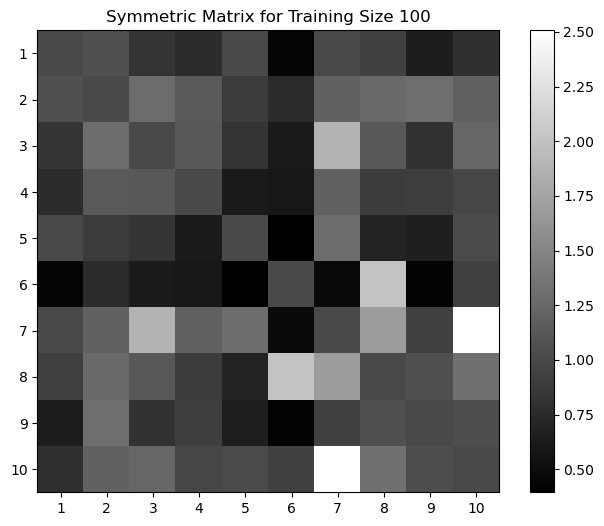

500
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 0.3815276026725769, 0.4033658802509308, 0.30569493770599365, 0.8174464702606201, 0.3072967231273651, 0.3957689106464386, 0.2636697292327881, 0.37852492928504944, 0.26890647411346436]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[0.1624671071767807, 1, 0.24149833619594574, 0.2884843349456787, 0.3161999583244324, 0.3197551667690277, 0.26709768176078796, 0.2353729009628296, 0.25449037551879883, 0.15802805125713348]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.4174546003341675, 0.28919416666030884, 1, 0.28330370783805847, 0.30178964138031006, 0.22899942100048065, 0.8717406392097473, 0.32711711525917053, 0.31146708130836487, 0.4240877330303192]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.19328342378139496, 0.14287182688713074, 0.17177119851112366, 1, 0.2352161407470703, 0.15659116208553314, 0.14997942745685577, 0.21650317311286926, 0.2066863775253296, 0.13695567846298218]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.7136452794075012, 0.25630295276641846

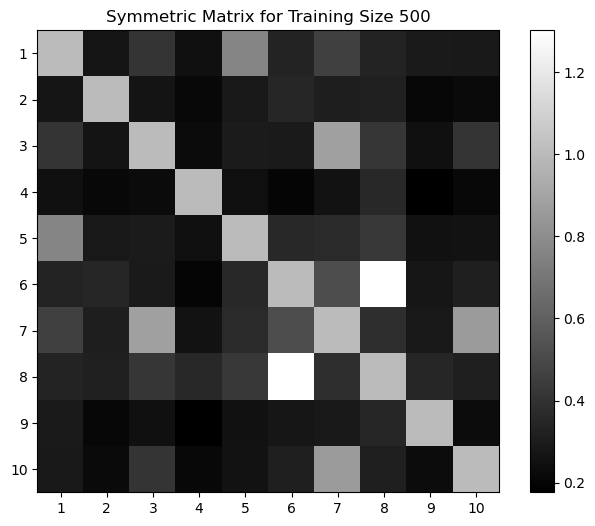

1000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 0.14486399292945862, 0.17995716631412506, 0.12017890810966492, 0.612388551235199, 0.1458888053894043, 0.14372138679027557, 0.16592754423618317, 0.15239545702934265, 0.16289597749710083]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[0.08937540650367737, 1, 0.15800374746322632, 0.0780433714389801, 0.10480786114931107, 0.11077490448951721, 0.14399437606334686, 0.0782611295580864, 0.1261974275112152, 0.0762636661529541]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.24805256724357605, 0.2698763310909271, 1, 0.21978311240673065, 0.2962939739227295, 0.23525768518447876, 0.8400271534919739, 0.27144429087638855, 0.23540648818016052, 0.2752751410007477]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.04531089961528778, 0.061477430164813995, 0.10586509108543396, 1, 0.12967294454574585, 0.09041277319192886, 0.04613877087831497, 0.05865303799510002, 0.07379961013793945, 0.09147121757268906]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.5720232129096985, 0.1718889325

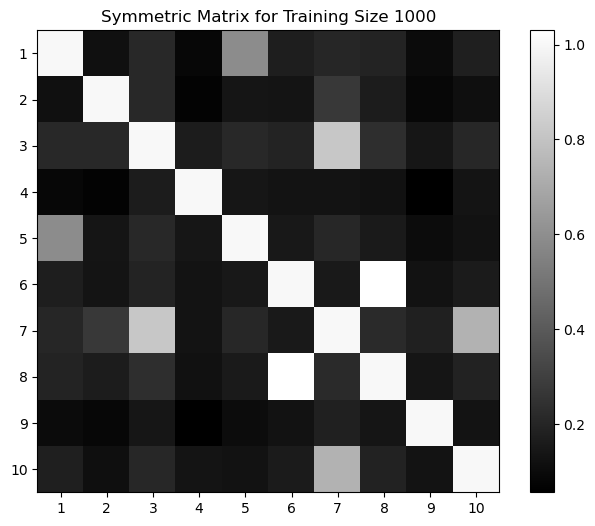

2500
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 0.08792173117399216, 0.11736007034778595, 0.09686564654111862, 0.557374894618988, 0.09193599224090576, 0.10433384031057358, 0.08187822252511978, 0.0869598314166069, 0.09341230988502502]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[0.03691563755273819, 1, 0.042449939996004105, 0.029984571039676666, 0.040828630328178406, 0.023808477446436882, 0.03908315300941467, 0.04598100110888481, 0.048044152557849884, 0.04559195414185524]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.20166964828968048, 0.16834591329097748, 1, 0.190628781914711, 0.16951152682304382, 0.16573774814605713, 0.6888983845710754, 0.15663684904575348, 0.16131019592285156, 0.1849333643913269]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.03642673045396805, 0.037322837859392166, 0.03758818656206131, 1, 0.053465038537979126, 0.04892022907733917, 0.03790319338440895, 0.04415158927440643, 0.045253973454236984, 0.05040556192398071]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.6510732173919678, 0

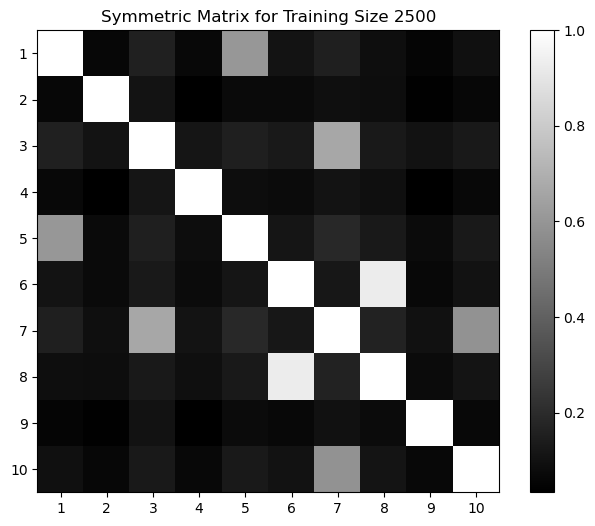

5000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 0.078891322016716, 0.08072467893362045, 0.06436371058225632, 0.5638612508773804, 0.0750533789396286, 0.09207624942064285, 0.09077809751033783, 0.07451189309358597, 0.06463708728551865]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[0.04086583852767944, 1, 0.04344557970762253, 0.017394088208675385, 0.02627667784690857, 0.03880571946501732, 0.030817508697509766, 0.04433560371398926, 0.03496544063091278, 0.031442005187273026]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.1288471817970276, 0.11299432069063187, 1, 0.09456102550029755, 0.1251983642578125, 0.10336045920848846, 0.6875316500663757, 0.11307839304208755, 0.10169544816017151, 0.10967084765434265]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.0166466124355793, 0.01339626032859087, 0.01784532144665718, 1, 0.01328776590526104, 0.010599913075566292, 0.02339036762714386, 0.015875795856118202, 0.015233950689435005, 0.015088996849954128]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.49388670921325684, 0.

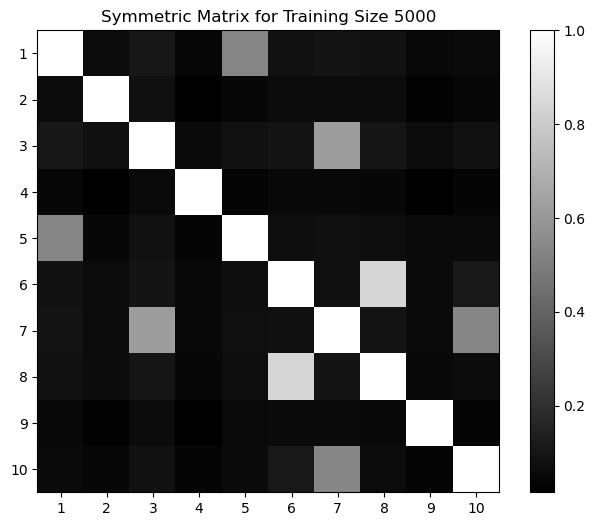

In [23]:

matrices = []
for training_size in training_sizes:
    # Load the models for the current training size
    print(training_size)
    loaded_models = torch.load(f'{save_directory}/tr{training_size}.pth')
    
    model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]

    models = []
    for i in range(num_features):
        model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
        model.load_state_dict(model_state_dicts[i])
        models.append(model)

    precision_matrix = []

    for j in range(num_features):
        Sj = models[j]
        row = []
        Sj.eval()
        kth = j
        non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

        zk = test_samples.detach().requires_grad_(True)
        h = zk[:, non_kth]
        x = zk[:, [kth]]

        sk_zi = Sj(x, h)  
        for i in range(num_features):
            print(i, j)
            if i != j:
                # Precision matrix calculations
                first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
                first_derivative = torch.log(torch.abs(first_derivative))
                second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0]
                third_derivative = torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

                second = torch.abs(third_derivative[:, [i]]).mean().item()
                first_half = -1 / 2 * (sk_zi ** 2)
                # Take the first derivative wrt to k
                first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
                # Take the 2nd derivative wrt to j
                second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

                first = torch.abs(second_half_deriative[:, [i]]).mean().item()
                row.append(first + second)
            else:
                row.append(1) # If the same, then let j=k.

        precision_matrix.append(row)
        print(precision_matrix[-1])

    matrix = np.array(precision_matrix)
    transpose_matrix = matrix.T 
    symmetric_matrix = (transpose_matrix + matrix) / 2

    print(f"Symmetric matrix for training size {training_size}:")
    print(symmetric_matrix)
    matrices.append(symmetric_matrix)
    
    np.save(f'{save_directory}/symmetric_matrix_{training_size}.npy', symmetric_matrix)
    
    # Plot the symmetric matrix
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Symmetric Matrix for Training Size {training_size}')
    plt.savefig(f'{save_directory}/symmetric_matrix_{training_size}.png')
    plt.show()


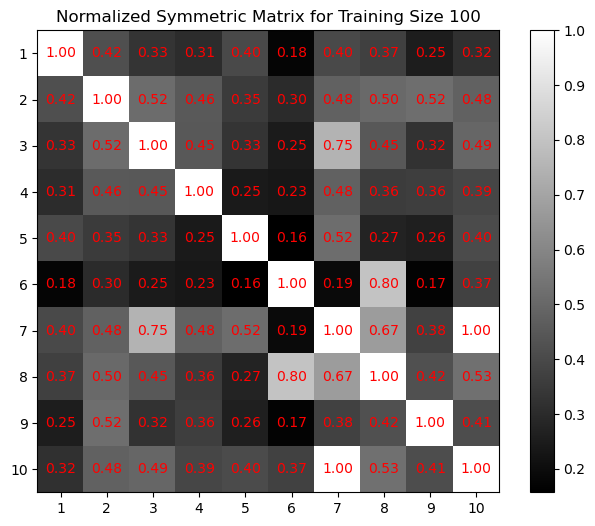

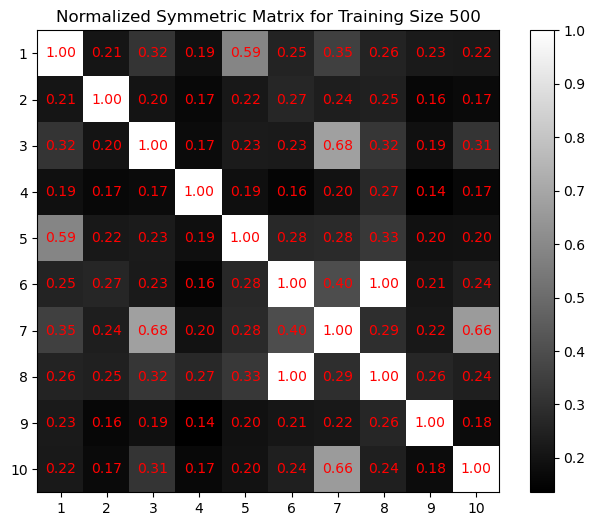

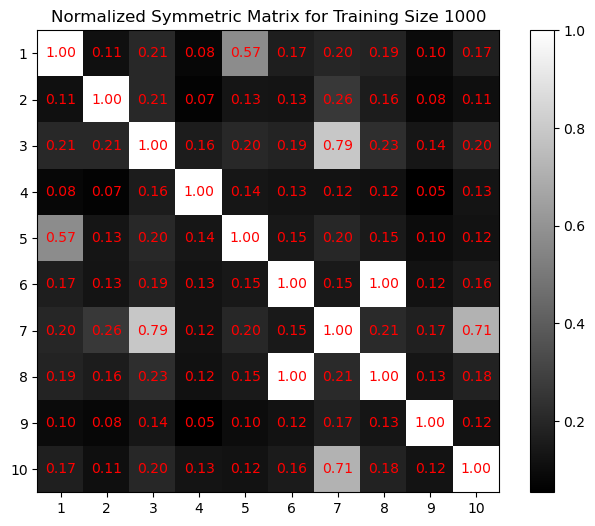

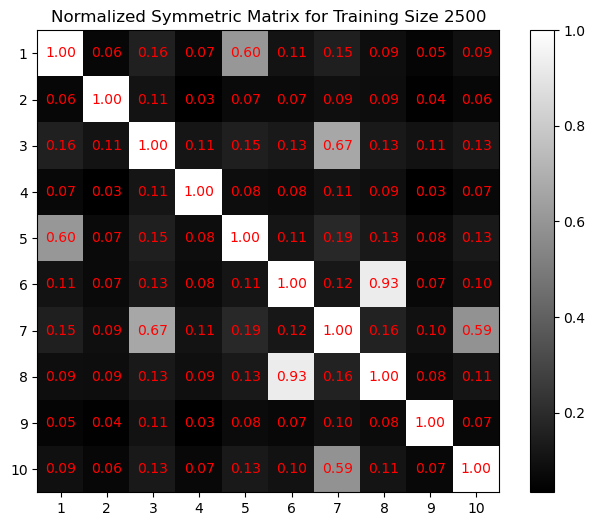

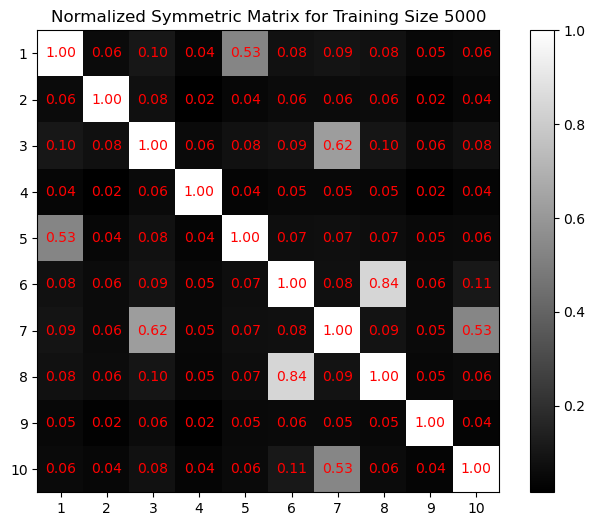

In [24]:

normalized_matrices = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)

    normalized_matrices.append((training_size, normalized_matrix))

for training_size, normalized_matrix in normalized_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Normalized Symmetric Matrix for Training Size {training_size}')
    
    for i in range(len(normalized_matrix)):
        for j in range(len(normalized_matrix[i])):
            plt.text(j, i, f'{normalized_matrix[i, j]:.2f}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/normalized_symmetric_matrix_{training_size}.png')
    plt.show()


[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]]


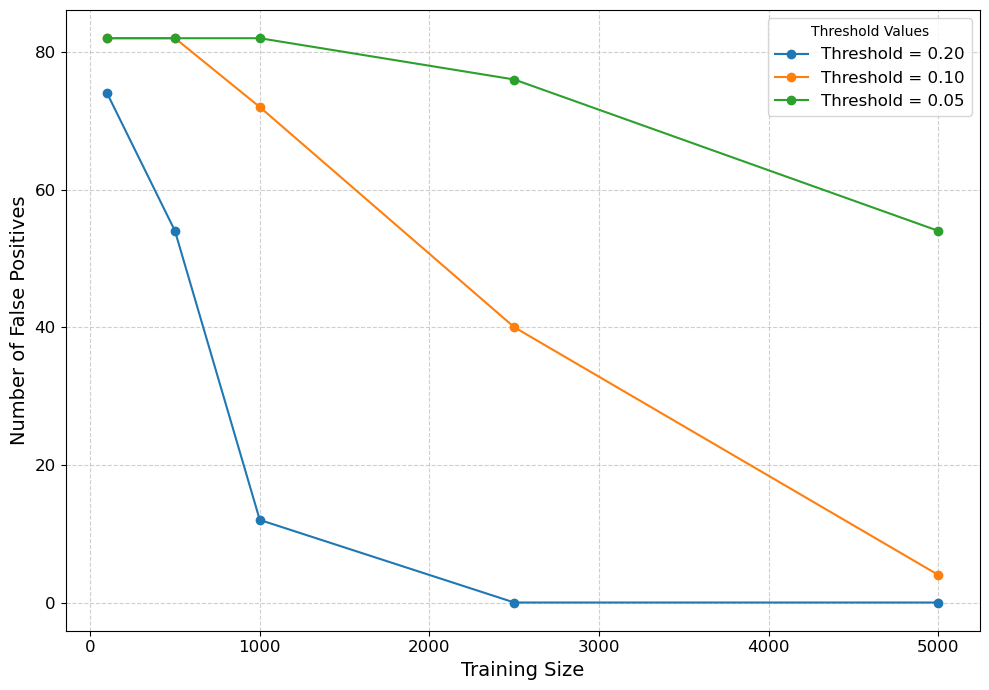

In [66]:
threshold_values = [0.2, 0.1, 0.05]
matrix_size = 10

ground_truth = precision_matrix

max_value = np.max(ground_truth)
normalized_matrix = ground_truth / max_value
ground_truth = np.where(normalized_matrix < 0.1, 0, 1)
print(ground_truth)

plt.figure(figsize=(10, 7))

for threshold in threshold_values:
    false_positives_list = []

    for training_size in training_sizes:
        matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

        max_value = np.max(matrix)
        normalized_matrix = matrix / max_value

        binary_matrix = np.where(normalized_matrix < threshold, 0, 1)

        false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))

        false_positives_list.append(false_positives)

    plt.plot(training_sizes, false_positives_list, marker='o', linestyle='-', label=f'Threshold = {threshold:.2f}')

plt.xlabel('Number of Training Samples', fontsize=14)
plt.xscale('log')
plt.ylabel('Number of False Positives', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Threshold Values', fontsize=12)
plt.tight_layout()

plt.savefig(f'{save_directory}/false_positives_vs_training_size_thresholds.png', dpi=300)

plt.show()

print(false_positives_list)

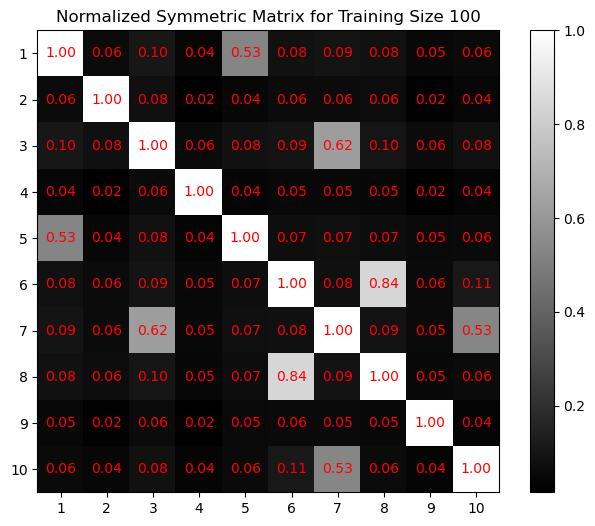

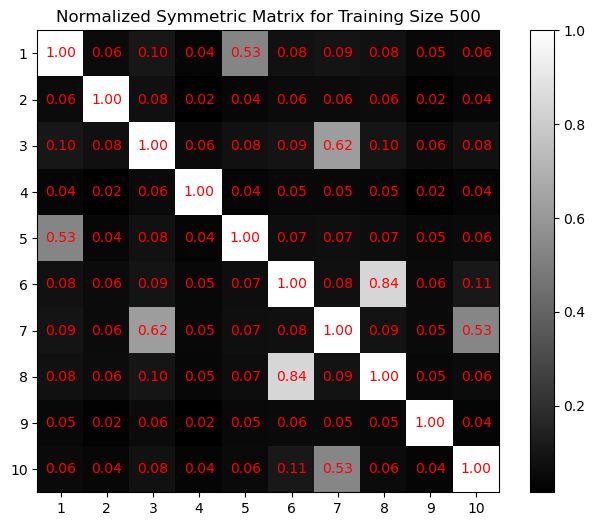

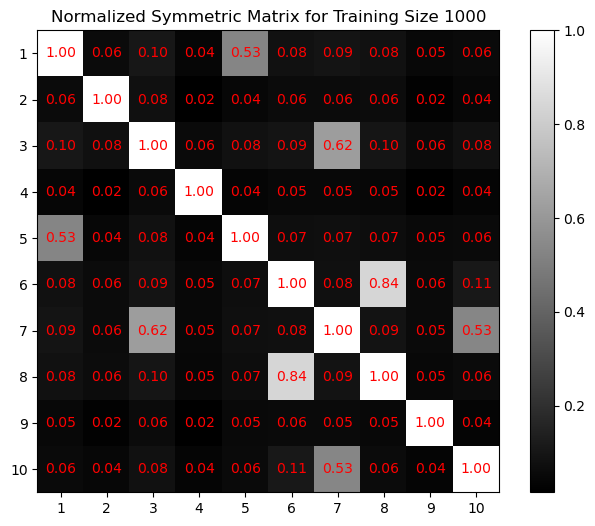

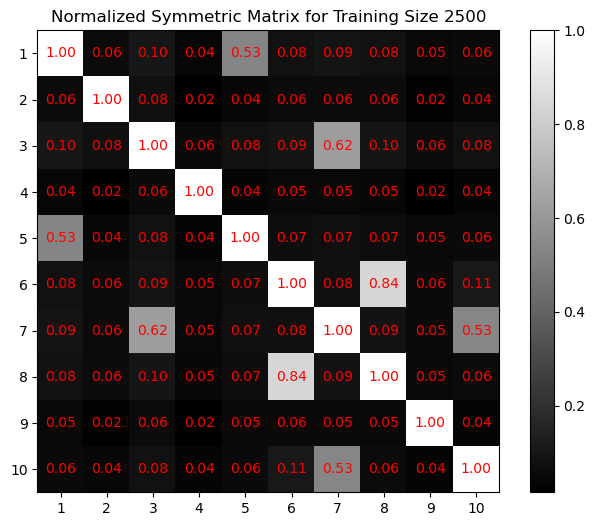

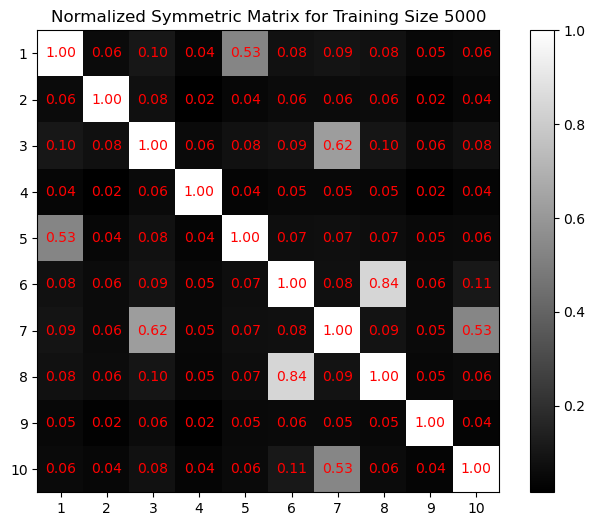

In [81]:

# List to store normalized matrices for later plotting
normalized_matrices = []

for training_size in training_sizes:
    # Load the symmetric matrix
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    # Normalize the matrix by its largest value
    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)
    normalized_matrices.append((training_size, normalized_matrix))

# After the loop, plot all normalized matrices
for training_size, normalized_matrix in normalized_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Normalized Symmetric Matrix for Training Size {training_size}')
    
    # Overlay the matrix values on the heatmap
    for i in range(len(normalized_matrix)):
        for j in range(len(normalized_matrix[i])):
            plt.text(j, i, f'{normalized_matrix[i, j]:.2f}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/normalized_symmetric_matrix_{training_size}.png')
    plt.show()


Training Size: 100, Threshold: 0.2
[[1.         1.05388755 0.8273381  0.76994932 1.01292756 0.43924149
  0.99708006 0.92485286 0.63676119 0.80263764]
 [1.05388755 1.         1.29225606 1.14148366 0.88691539 0.75589965
  1.20591244 1.26570717 1.308779   1.20948809]
 [0.8273381  1.29225606 1.         1.12122753 0.8343187  0.62206829
  1.87761748 1.12469745 0.81011572 1.23637897]
 [0.76994932 1.14148366 1.12122753 1.         0.61596093 0.58866253
  1.2103987  0.8992976  0.90877506 0.97939977]
 [1.01292756 0.88691539 0.8343187  0.61596093 1.         0.39429823
  1.29425892 0.68485682 0.65048182 1.0139136 ]
 [0.43924149 0.75589965 0.62206829 0.58866253 0.39429823 1.
  0.48287109 2.01529437 0.42495035 0.93562004]
 [0.99708006 1.20591244 1.87761748 1.2103987  1.29425892 0.48287109
  1.         1.68388563 0.94250494 2.50750041]
 [0.92485286 1.26570717 1.12469745 0.8992976  0.68485682 2.01529437
  1.68388563 1.         1.0580391  1.32322001]
 [0.63676119 1.308779   0.81011572 0.90877506 0.65048

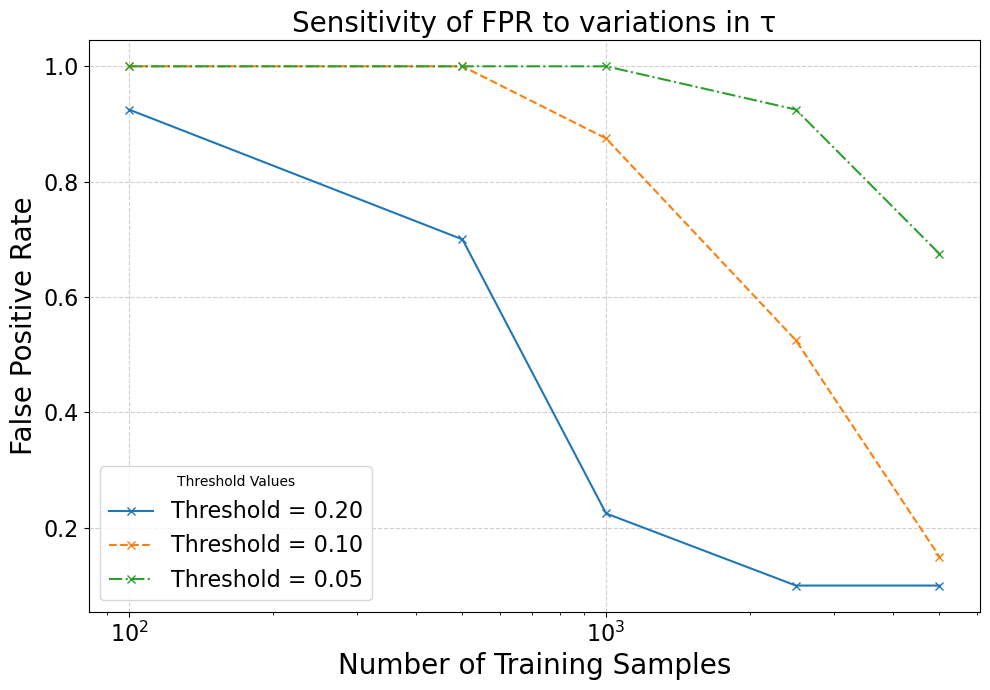

In [6]:

threshold_values = [0.2, 0.1, 0.05]
training_sizes = [100, 500, 1000, 2500, 5000]
matrix_size = 10

ground_truth = np.eye(matrix_size)

for i in range(0, matrix_size, 2):
    ground_truth[i, i+1] = 1
    ground_truth[i+1, i] = 1

total_negatives = np.sum(ground_truth == 0)

plt.figure(figsize=(10, 7))

linestyles = ['-', '--', '-.', ':']

for i, threshold in enumerate(threshold_values):
    false_positive_rates_list = []

    for training_size in training_sizes:
        matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

        max_value = np.max(matrix)
        normalized_matrix = matrix / max_value

        binary_matrix = np.where(normalized_matrix < threshold, 0, 1)

        false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))

        false_positive_rate = false_positives / total_negatives

        false_positive_rates_list.append(false_positive_rate)

    plt.plot(training_sizes, false_positive_rates_list, marker='x', linestyle=linestyles[i], label=f'Threshold = {threshold:.2f}')

plt.xlabel('Number of Training Samples', fontsize=20)
plt.ylabel('False Positive Rate', fontsize=20)
plt.title('Sensitivity of FPR to variations in τ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Threshold Values', fontsize=16)

plt.xscale('log')
plt.tight_layout()

plt.savefig(f'{save_directory}/false_positive_rates_vs_training_size_thresholds.png', dpi=300)

plt.show()


In [29]:
false_positives_list

[0, 0, 0, 0, 0]

In [30]:
precision_matrix

[[1,
  0.078891322016716,
  0.08072467893362045,
  0.06436371058225632,
  0.5638612508773804,
  0.0750533789396286,
  0.09207624942064285,
  0.09077809751033783,
  0.07451189309358597,
  0.06463708728551865],
 [0.04086583852767944,
  1,
  0.04344557970762253,
  0.017394088208675385,
  0.02627667784690857,
  0.03880571946501732,
  0.030817508697509766,
  0.04433560371398926,
  0.03496544063091278,
  0.031442005187273026],
 [0.1288471817970276,
  0.11299432069063187,
  1,
  0.09456102550029755,
  0.1251983642578125,
  0.10336045920848846,
  0.6875316500663757,
  0.11307839304208755,
  0.10169544816017151,
  0.10967084765434265],
 [0.0166466124355793,
  0.01339626032859087,
  0.01784532144665718,
  1,
  0.01328776590526104,
  0.010599913075566292,
  0.02339036762714386,
  0.015875795856118202,
  0.015233950689435005,
  0.015088996849954128],
 [0.49388670921325684,
  0.06201671063899994,
  0.04048194736242294,
  0.06251419335603714,
  1,
  0.052095409482717514,
  0.06044203042984009,
  0.0

[[1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 1 1 1 1 1 1]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 1]
 [0 0 1 0 0 0 1 1 0 1]
 [0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 1]]


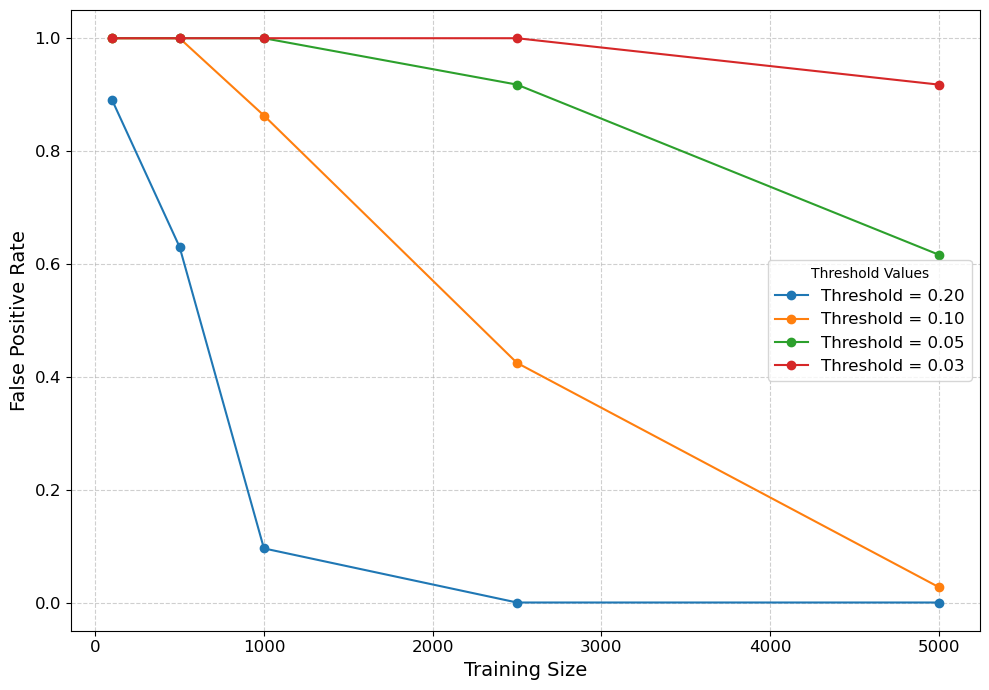

In [41]:

threshold_values = [0.2, 0.1, 0.05, 0.03]
matrix_size = 10
ground_truth = precision_matrix

max_value = np.max(ground_truth)
normalized_matrix = ground_truth / max_value
ground_truth = np.where(normalized_matrix < 0.1, 0, 1)
print(ground_truth)

total_negatives = np.sum(ground_truth == 0)

plt.figure(figsize=(10, 7))

for threshold in threshold_values:
    false_positive_rates_list = []

    for training_size in training_sizes:
        matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')
        max_value = np.max(matrix)
        normalized_matrix = matrix / max_value
        binary_matrix = np.where(normalized_matrix < threshold, 0, 1)

        false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))
        false_positive_rate = false_positives / total_negatives

        false_positive_rates_list.append(false_positive_rate)

    plt.plot(training_sizes, false_positive_rates_list, marker='o', linestyle='-', label=f'Threshold = {threshold:.2f}')

plt.xlabel('Training Size', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Threshold Values', fontsize=12)
plt.tight_layout()

plt.savefig(f'{save_directory}/false_positive_rates_vs_training_size_thresholds.png', dpi=300)
plt.show()


In [42]:
from sklearn.covariance import GraphicalLasso


In [43]:
cov = GraphicalLasso().fit(test_samples)


In [45]:
cov.covariance_

array([[ 9.99999999e-01, -8.69619895e-04,  1.86084826e-05,
        -8.73053184e-05, -4.19477096e-01,  4.29347645e-03,
        -1.42563062e-05, -7.29761766e-03,  4.28770516e-04,
         6.75900811e-06],
       [-8.69619895e-04,  1.00000000e+00,  2.62499344e-07,
        -2.55075038e-05,  3.34068004e-04,  3.63546425e-03,
        -2.03293717e-07, -2.13571230e-03, -3.63774636e-07,
         9.63828820e-08],
       [ 1.86084826e-05,  2.62499344e-07,  9.99999997e-01,
        -9.35824219e-07, -8.45799480e-06,  2.68498292e-05,
        -4.74824359e-01, -1.59034449e-05,  1.14022458e-03,
         2.25117337e-01],
       [-8.73053184e-05, -2.55075038e-05, -9.35824219e-07,
         9.99999997e-01,  2.07884417e-04, -7.03020844e-03,
         6.07315260e-07,  1.19433855e-02, -3.43033150e-04,
        -2.87932140e-07],
       [-4.19477096e-01,  3.34068004e-04, -8.45799480e-06,
         2.07884417e-04,  1.00000000e+00, -1.02416273e-02,
         6.48493526e-06,  1.74006574e-02, -1.79918897e-04,
        -3.

In [73]:
print(test_samples)

[[ 1.35857582e+00 -2.98364907e-01  1.56163123e+00  3.36702762e-01
   1.69819972e+00 -1.99873797e+00 -3.19326844e-01  2.51577787e-02
   1.60260928e+00 -7.80024994e-02]
 [ 2.02657076e+00  2.01811450e+00  1.40719512e+00  7.94298617e-01
  -5.55891992e-01  4.16307511e-01 -6.07240477e-01  7.34265727e-01
  -2.72653578e-01  1.79573932e-01]
 [-1.28241580e+00  7.87525817e-01  4.09148692e-01 -2.12916269e+00
  -2.02532452e+00  9.25697578e-01 -8.45608291e-02 -1.01369166e+00
  -1.42575955e-01  2.45399840e+00]
 [ 9.91140946e-02  8.48712113e-01  1.08710526e+00 -4.75637820e-01
   1.04252113e+00 -1.26812301e-01 -4.69610811e-01 -8.94584558e-01
   5.01435621e-01  2.99204882e-02]
 [ 2.19568323e+00  1.36765767e+00  2.59671802e-01  6.08935085e-01
   6.09911476e-01 -3.72652128e-01  8.42504371e-01 -3.78017056e-01
  -7.67121568e-01 -4.64280052e-01]
 [-8.23098939e-01  6.53033410e-02 -3.19164486e-01 -5.37540884e-01
  -1.55119427e+00  8.53075291e-01  9.00635573e-01  1.44367775e+00
  -5.40267895e-01 -5.14409021e-02

### GLASSO

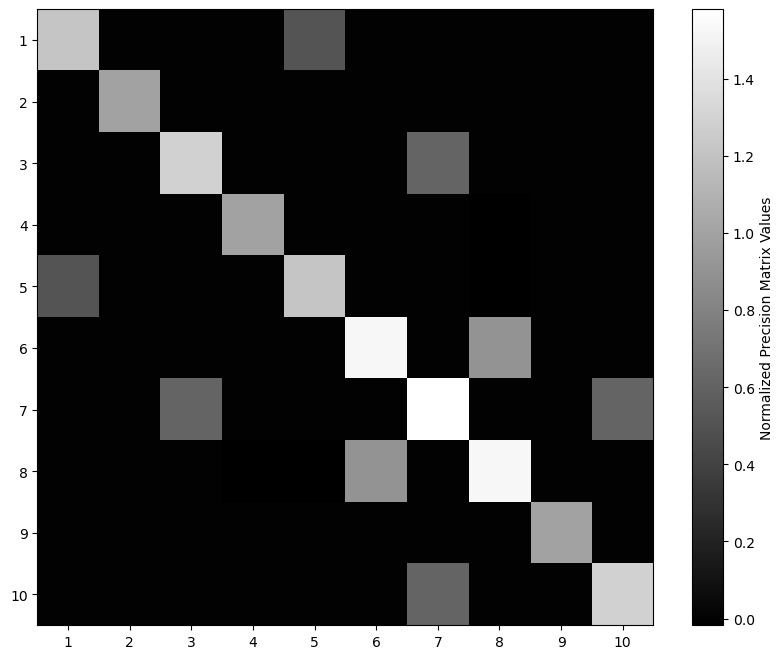

In [85]:

# Fit the Graphical Lasso model
model = GraphicalLasso() 
model.fit(test_samples)

# Extract the precision matrix (inverse covariance matrix)
precision_matrix = model.precision_

# Normalize the precision matrix
normalized_precision_matrix = precision_matrix / np.max(np.abs(precision_matrix))

plt.figure(figsize=(10, 8))
plt.imshow(normalized_precision_matrix, cmap='gray', interpolation='nearest')
plt.colorbar(label='Normalized Precision Matrix Values')
plt.xticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_precision_matrix), 1), np.arange(1, len(normalized_matrix) + 1))

plt.grid(False)  
plt.show()

In [60]:
print(precision_matrix)

[[ 1.21353580e+00  8.85256578e-04  0.00000000e+00 -0.00000000e+00
   5.09050106e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  -4.28720042e-04 -0.00000000e+00]
 [ 8.85256578e-04  1.00001400e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00 -3.63931602e-03 -0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00  1.29109006e+00 -0.00000000e+00
   0.00000000e+00  0.00000000e+00  6.13039016e-01 -0.00000000e+00
  -1.14021812e-03 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00014279e+00
  -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.19450885e-02
   3.42995205e-04  0.00000000e+00]
 [ 5.09050106e-01 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
   1.21383775e+00  0.00000000e+00  0.00000000e+00 -1.74067224e-02
  -0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -3.63931602e-03  0.00000000e+00 -0.00000000e+00
   0.00000000e+00  1.53019452e+00  0.00000000e+00  9.00707230e-01
   0.00000000e+00 -0.00000000e+00